# Import libararies

In [1]:
from itertools import product
from datetime import datetime, timedelta
import os
import random
import string

import numpy as np
import pandas as pd

import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
    GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

import scipy
from scipy.stats import uniform, loguniform

#!conda install -y -c conda-forge  xgboost 
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

import ray
from ray import tune
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest.optuna import OptunaSearch
from ray.tune.logger import DEFAULT_LOGGERS

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# wandb.com is great for real-time tracking but not necessary
# beautiful charts but JS UI is sometimes a bit cursed
# cloud reporting latency can slow down tuning
import wandb
#from ray.tune.integration.wandb import WandbLogger
from ray.tune.integration.wandb import wandb_mixin


/tmp/ipykernel_61965/4239453647.py:29: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
  from ray.tune.suggest import ConcurrencyLimiter
/tmp/ipykernel_61965/4239453647.py:31: DeprecationWarning: The module `ray.tune.suggest.hyperopt` has been moved to `ray.tune.search.hyperopt` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest.hyperopt` with `ray.tune.search.hyperopt`.
  from ray.tune.suggest.hyperopt import HyperOptSearch
/home2/s438167/MLFinal/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import

# Read data and process

In [2]:
data = pd.read_csv("AD.training.csv")
data

RID        PTID   EXAMDATE DX.bl   AGE PTGENDER  PTEDUCAT  APOE4  MMSE  \
0     222  005_S_0222  3/17/2006  LMCI  85.9     Male        18      0    25   
1    1380  072_S_1380   4/4/2007  LMCI  84.7     Male        12      0    29   
2    1321  012_S_1321  3/12/2007  LMCI  83.2     Male        20      0    28   
3    4521  002_S_4521  2/23/2012  LMCI  70.0     Male        18      1    27   
4    4216  073_S_4216  9/19/2011  EMCI  56.4     Male        14      0    29   
..    ...         ...        ...   ...   ...      ...       ...    ...   ...   
379   685  002_S_0685  7/20/2006    CN  89.6   Female        16      0    30   
380  2381  009_S_2381  5/31/2011  EMCI  69.1     Male        16      2    28   
381  4213  002_S_4213  9/13/2011    CN  78.0   Female        14      0    28   
382     3  011_S_0003  9/12/2005    AD  81.3     Male        18      1    20   
383   110  067_S_0110   3/6/2006    AD  82.6   Female        10      0    23   

     MMSE.Change  
0              1  
1              0  
2              1  
3             -2  
4             -2  
..           ...  
379            0  
380            0  
381            1  
382           -1  
383           -2  

[384 rows x 10 columns]

In [3]:
dummies = pd.get_dummies(data[['DX.bl', 'PTGENDER']])
dummies

DX.bl_AD  DX.bl_CN  DX.bl_EMCI  DX.bl_LMCI  PTGENDER_Female  \
0           0         0           0           1                0   
1           0         0           0           1                0   
2           0         0           0           1                0   
3           0         0           0           1                0   
4           0         0           1           0                0   
..        ...       ...         ...         ...              ...   
379         0         1           0           0                1   
380         0         0           1           0                0   
381         0         1           0           0                1   
382         1         0           0           0                0   
383         1         0           0           0                1   

     PTGENDER_Male  
0                1  
1                1  
2                1  
3                1  
4                1  
..             ...  
379              0  
380              1  
381              0  
382              1  
383              0  

[384 rows x 6 columns]

In [4]:
data = pd.concat([data[['AGE', 'PTEDUCAT', 'APOE4', 'MMSE', 'MMSE.Change']], dummies], axis = 1)

In [5]:
data

AGE  PTEDUCAT  APOE4  MMSE  MMSE.Change  DX.bl_AD  DX.bl_CN  DX.bl_EMCI  \
0    85.9        18      0    25            1         0         0           0   
1    84.7        12      0    29            0         0         0           0   
2    83.2        20      0    28            1         0         0           0   
3    70.0        18      1    27           -2         0         0           0   
4    56.4        14      0    29           -2         0         0           1   
..    ...       ...    ...   ...          ...       ...       ...         ...   
379  89.6        16      0    30            0         0         1           0   
380  69.1        16      2    28            0         0         0           1   
381  78.0        14      0    28            1         0         1           0   
382  81.3        18      1    20           -1         1         0           0   
383  82.6        10      0    23           -2         1         0           0   

     DX.bl_LMCI  PTGENDER_Female  PTGENDER_Male  
0             1                0              1  
1             1                0              1  
2             1                0              1  
3             1                0              1  
4             0                0              1  
..          ...              ...            ...  
379           0                1              0  
380           0                0              1  
381           0                1              0  
382           0                0              1  
383           0                1              0  

[384 rows x 11 columns]

<AxesSubplot: ylabel='Density'>

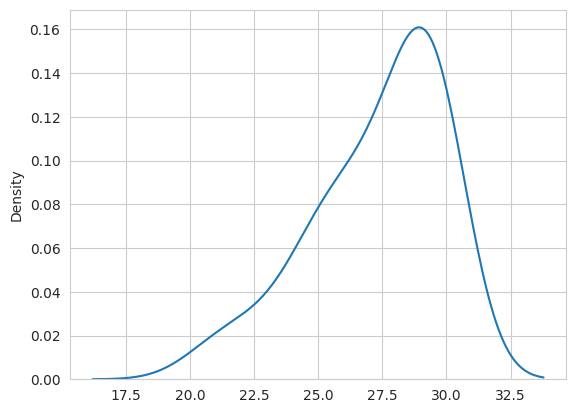

In [6]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(data['MMSE']), bw_method=0.5)

In [7]:
X = data.loc[:, data.columns != 'MMSE.Change']
y = data.loc[:, data.columns == 'MMSE.Change']

X = X.to_numpy()
y = y.to_numpy()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGboost Regression hyperparameter tuning on the original data

In [10]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

RANDOMSTATE = 42

In [11]:
xgb_tune_kwargs = {
    "n_estimators": tune.loguniform(100, 10000),
    "max_depth": tune.randint(0, 5), 
    "subsample": tune.quniform(0.25, 0.75, 0.01),
    "colsample_bytree": tune.quniform(0.05, 0.5, 0.01),
    "colsample_bylevel": tune.quniform(0.05, 0.5, 0.01),    
    "learning_rate": tune.quniform(-3.0, -1.0, 0.5)
}

xgb_tune_params = [k for k in xgb_tune_kwargs.keys() if k != 'wandb']
xgb_tune_params

['n_estimators',
 'max_depth',
 'subsample',
 'colsample_bytree',
 'colsample_bylevel',
 'learning_rate']

In [12]:
# always use same k-folds for reproducibility
kfolds = KFold(n_splits = 4, shuffle=True, random_state=RANDOMSTATE)

# @wandb_mixin
def my_xgb(config):
    
    config['n_estimators'] = int(config['n_estimators'])     
    config['max_depth'] = int(config['max_depth']) + 2
    config['learning_rate'] = 10 ** config['learning_rate']
    
    xgb = XGBRegressor(
        objective='reg:squarederror',
        n_jobs=1,
        random_state=RANDOMSTATE,
        booster='gbtree',   
        scale_pos_weight=1, 
        **config,
    )
    scores = -cross_val_score(xgb, X_train, y_train,
                                      scoring="neg_root_mean_squared_error",
                                      cv=kfolds)
    rmse = np.mean(scores)
    tune.report(rmse=rmse)
    
    return {"rmse": rmse}

In [14]:
# set each to run for about 1 hour for comparability
NUM_SAMPLES=2048

start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))

algo = HyperOptSearch(random_state_seed=RANDOMSTATE)
# to limit number of cores, uncomment and set max_concurrent 
# algo = ConcurrencyLimiter(algo, max_concurrent=10)
scheduler = AsyncHyperBandScheduler()

analysis = tune.run(my_xgb,
                    num_samples=NUM_SAMPLES,
                    config=xgb_tune_kwargs,                    
                    name="hyperopt_xgb",
                    metric="rmse",
                    mode="min",
                    search_alg=algo,
                    scheduler=scheduler,
                    verbose=1,
                    resources_per_trial={"gpu": 0, "cpu": 40}
                   )

end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

2022-11-19 19:51:03,652	WARNING tune.py:686 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2022-11-19 19:51:09,562	ERROR tune.py:754 -- Trials did not complete: [my_xgb_464f16f0, my_xgb_7a88fce2]
2022-11-19 19:51:09,565	INFO tune.py:758 -- Total run time: 105.63 seconds (100.71 seconds for the tuning loop).
2022-11-19 19:51:09,565	WARNING tune.py:764 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


Start Time           2022-11-19 19:49:23.929805
End Time             2022-11-19 19:51:09.581055
0:01:45


###
== Status ==
Current time: 2022-10-25 18:39:31 (running for 02:16:01.19)
Memory usage on this node: 16.1/376.5 GiB
Using AsyncHyperBand: num_stopped=1206 Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -3.223030113202613
Resources requested: 0/72 CPUs, 0/1 GPUs, 0.0/248.68 GiB heap, 0.0/110.57 GiB objects
Current best trial: c6f78b12 with rmse=3.183242723103643 and parameters={'n_estimators': 1079, 'max_depth': 2, 'subsample': 0.31, 'colsample_bytree': 0.33, 'colsample_bylevel': 0.27, 'learning_rate': 0.03162277660168379}
Result logdir: /home2/s438167/ray_results/hyperopt_xgb
Number of trials: 2048/2048 (2048 TERMINATED)

2022-10-25 18:39:31,869	INFO tune.py:758 -- Total run time: 8161.53 seconds (8160.93 seconds for the tuning loop).

Start Time           2022-10-25 16:23:30.341995
End Time             2022-10-25 18:39:36.344252
2:16:06


# Train and test with the tuned hyperparam

[0]	validation_0-rmse:3.39776
[1]	validation_0-rmse:3.35492
[2]	validation_0-rmse:3.31968
[3]	validation_0-rmse:3.30664
[4]	validation_0-rmse:3.28055
[5]	validation_0-rmse:3.26222
[6]	validation_0-rmse:3.24056
[7]	validation_0-rmse:3.22308
[8]	validation_0-rmse:3.21336
[9]	validation_0-rmse:3.18682
[10]	validation_0-rmse:3.17679
[11]	validation_0-rmse:3.16047
[12]	validation_0-rmse:3.14818
[13]	validation_0-rmse:3.13848
[14]	validation_0-rmse:3.12889
[15]	validation_0-rmse:3.12110
[16]	validation_0-rmse:3.11004
[17]	validation_0-rmse:3.10140
[18]	validation_0-rmse:3.09472
[19]	validation_0-rmse:3.08327
[20]	validation_0-rmse:3.07322
[21]	validation_0-rmse:3.06695
[22]	validation_0-rmse:3.06279
[23]	validation_0-rmse:3.05446
[24]	validation_0-rmse:3.03590
[25]	validation_0-rmse:3.03106
[26]	validation_0-rmse:3.02975
[27]	validation_0-rmse:3.02897
[28]	validation_0-rmse:3.02516
[29]	validation_0-rmse:3.02127
[30]	validation_0-rmse:3.01582
[31]	validation_0-rmse:3.01470
[32]	validation_0-

[260]	validation_0-rmse:3.22137
[261]	validation_0-rmse:3.22068
[262]	validation_0-rmse:3.21916
[263]	validation_0-rmse:3.21940
[264]	validation_0-rmse:3.21626
[265]	validation_0-rmse:3.20938
[266]	validation_0-rmse:3.20912
[267]	validation_0-rmse:3.20783
[268]	validation_0-rmse:3.20867
[269]	validation_0-rmse:3.20849
[270]	validation_0-rmse:3.21144
[271]	validation_0-rmse:3.21244
[272]	validation_0-rmse:3.21441
[273]	validation_0-rmse:3.21612
[274]	validation_0-rmse:3.21915
[275]	validation_0-rmse:3.21052
[276]	validation_0-rmse:3.20873
[277]	validation_0-rmse:3.20787
[278]	validation_0-rmse:3.21086
[279]	validation_0-rmse:3.21591
[280]	validation_0-rmse:3.21570
[281]	validation_0-rmse:3.21626
[282]	validation_0-rmse:3.21679
[283]	validation_0-rmse:3.21684
[284]	validation_0-rmse:3.21949
[285]	validation_0-rmse:3.22086
[286]	validation_0-rmse:3.20715
[287]	validation_0-rmse:3.21160
[288]	validation_0-rmse:3.20893
[289]	validation_0-rmse:3.20724
[290]	validation_0-rmse:3.20103
[291]	va

[517]	validation_0-rmse:3.19839
[518]	validation_0-rmse:3.20100
[519]	validation_0-rmse:3.19931
[520]	validation_0-rmse:3.19929
[521]	validation_0-rmse:3.19914
[522]	validation_0-rmse:3.19606
[523]	validation_0-rmse:3.18462
[524]	validation_0-rmse:3.18567
[525]	validation_0-rmse:3.18894
[526]	validation_0-rmse:3.19513
[527]	validation_0-rmse:3.19572
[528]	validation_0-rmse:3.19829
[529]	validation_0-rmse:3.19921
[530]	validation_0-rmse:3.19499
[531]	validation_0-rmse:3.19580
[532]	validation_0-rmse:3.19490
[533]	validation_0-rmse:3.19289
[534]	validation_0-rmse:3.19323
[535]	validation_0-rmse:3.18891
[536]	validation_0-rmse:3.19075
[537]	validation_0-rmse:3.19457
[538]	validation_0-rmse:3.19568
[539]	validation_0-rmse:3.19724
[540]	validation_0-rmse:3.19869
[541]	validation_0-rmse:3.20734
[542]	validation_0-rmse:3.21200
[543]	validation_0-rmse:3.21336
[544]	validation_0-rmse:3.21368
[545]	validation_0-rmse:3.21810
[546]	validation_0-rmse:3.21607
[547]	validation_0-rmse:3.21489
[548]	va

[774]	validation_0-rmse:3.19790
[775]	validation_0-rmse:3.20103
[776]	validation_0-rmse:3.20041
[777]	validation_0-rmse:3.18866
[778]	validation_0-rmse:3.19256
[779]	validation_0-rmse:3.19344
[780]	validation_0-rmse:3.19202
[781]	validation_0-rmse:3.19190
[782]	validation_0-rmse:3.19221
[783]	validation_0-rmse:3.18988
[784]	validation_0-rmse:3.18856
[785]	validation_0-rmse:3.19019
[786]	validation_0-rmse:3.18918
[787]	validation_0-rmse:3.18054
[788]	validation_0-rmse:3.18010
[789]	validation_0-rmse:3.18250
[790]	validation_0-rmse:3.18131
[791]	validation_0-rmse:3.18138
[792]	validation_0-rmse:3.18048
[793]	validation_0-rmse:3.17976
[794]	validation_0-rmse:3.18045
[795]	validation_0-rmse:3.18100
[796]	validation_0-rmse:3.18391
[797]	validation_0-rmse:3.18394
[798]	validation_0-rmse:3.18307
[799]	validation_0-rmse:3.18045
[800]	validation_0-rmse:3.18195
[801]	validation_0-rmse:3.18226
[802]	validation_0-rmse:3.18237
[803]	validation_0-rmse:3.18307
[804]	validation_0-rmse:3.18854
[805]	va

[1030]	validation_0-rmse:3.24694
[1031]	validation_0-rmse:3.24696
[1032]	validation_0-rmse:3.24670
[1033]	validation_0-rmse:3.24822
[1034]	validation_0-rmse:3.25062
[1035]	validation_0-rmse:3.25025
[1036]	validation_0-rmse:3.24947
[1037]	validation_0-rmse:3.24397
[1038]	validation_0-rmse:3.24578
[1039]	validation_0-rmse:3.24948
[1040]	validation_0-rmse:3.25014
[1041]	validation_0-rmse:3.25064
[1042]	validation_0-rmse:3.24769
[1043]	validation_0-rmse:3.24695
[1044]	validation_0-rmse:3.24847
[1045]	validation_0-rmse:3.24810
[1046]	validation_0-rmse:3.24418
[1047]	validation_0-rmse:3.24268
[1048]	validation_0-rmse:3.23889
[1049]	validation_0-rmse:3.23503
[1050]	validation_0-rmse:3.23673
[1051]	validation_0-rmse:3.23415
[1052]	validation_0-rmse:3.23567
[1053]	validation_0-rmse:3.23608
[1054]	validation_0-rmse:3.23765
[1055]	validation_0-rmse:3.23998
[1056]	validation_0-rmse:3.24024
[1057]	validation_0-rmse:3.24014
[1058]	validation_0-rmse:3.23672
[1059]	validation_0-rmse:3.23655
[1060]	val

[209]	validation_0-rmse:3.16159
[210]	validation_0-rmse:3.16195
[211]	validation_0-rmse:3.16142
[212]	validation_0-rmse:3.15708
[213]	validation_0-rmse:3.15320
[214]	validation_0-rmse:3.15344
[215]	validation_0-rmse:3.15808
[216]	validation_0-rmse:3.15599
[217]	validation_0-rmse:3.15498
[218]	validation_0-rmse:3.15486
[219]	validation_0-rmse:3.15432
[220]	validation_0-rmse:3.15526
[221]	validation_0-rmse:3.15556
[222]	validation_0-rmse:3.15677
[223]	validation_0-rmse:3.15367
[224]	validation_0-rmse:3.15566
[225]	validation_0-rmse:3.15533
[226]	validation_0-rmse:3.16209
[227]	validation_0-rmse:3.16517
[228]	validation_0-rmse:3.16633
[229]	validation_0-rmse:3.16978
[230]	validation_0-rmse:3.16737
[231]	validation_0-rmse:3.17480
[232]	validation_0-rmse:3.17598
[233]	validation_0-rmse:3.17584
[234]	validation_0-rmse:3.18303
[235]	validation_0-rmse:3.18344
[236]	validation_0-rmse:3.18304
[237]	validation_0-rmse:3.18210
[238]	validation_0-rmse:3.18446
[239]	validation_0-rmse:3.17842
[240]	va

[466]	validation_0-rmse:3.19789
[467]	validation_0-rmse:3.19790
[468]	validation_0-rmse:3.19926
[469]	validation_0-rmse:3.19820
[470]	validation_0-rmse:3.19741
[471]	validation_0-rmse:3.19838
[472]	validation_0-rmse:3.19702
[473]	validation_0-rmse:3.19477
[474]	validation_0-rmse:3.19178
[475]	validation_0-rmse:3.19135
[476]	validation_0-rmse:3.19488
[477]	validation_0-rmse:3.18964
[478]	validation_0-rmse:3.19189
[479]	validation_0-rmse:3.19881
[480]	validation_0-rmse:3.19952
[481]	validation_0-rmse:3.20196
[482]	validation_0-rmse:3.20343
[483]	validation_0-rmse:3.20375
[484]	validation_0-rmse:3.20545
[485]	validation_0-rmse:3.20589
[486]	validation_0-rmse:3.20989
[487]	validation_0-rmse:3.21691
[488]	validation_0-rmse:3.21043
[489]	validation_0-rmse:3.21323
[490]	validation_0-rmse:3.21659
[491]	validation_0-rmse:3.21893
[492]	validation_0-rmse:3.21839
[493]	validation_0-rmse:3.22039
[494]	validation_0-rmse:3.21961
[495]	validation_0-rmse:3.22089
[496]	validation_0-rmse:3.22167
[497]	va

[723]	validation_0-rmse:3.18123
[724]	validation_0-rmse:3.18218
[725]	validation_0-rmse:3.18229
[726]	validation_0-rmse:3.17859
[727]	validation_0-rmse:3.17953
[728]	validation_0-rmse:3.17958
[729]	validation_0-rmse:3.17901
[730]	validation_0-rmse:3.17940
[731]	validation_0-rmse:3.18257
[732]	validation_0-rmse:3.18151
[733]	validation_0-rmse:3.18333
[734]	validation_0-rmse:3.17780
[735]	validation_0-rmse:3.17422
[736]	validation_0-rmse:3.17214
[737]	validation_0-rmse:3.17323
[738]	validation_0-rmse:3.17432
[739]	validation_0-rmse:3.17471
[740]	validation_0-rmse:3.17410
[741]	validation_0-rmse:3.17274
[742]	validation_0-rmse:3.17384
[743]	validation_0-rmse:3.17417
[744]	validation_0-rmse:3.17232
[745]	validation_0-rmse:3.17133
[746]	validation_0-rmse:3.17155
[747]	validation_0-rmse:3.17041
[748]	validation_0-rmse:3.17021
[749]	validation_0-rmse:3.17035
[750]	validation_0-rmse:3.16914
[751]	validation_0-rmse:3.17304
[752]	validation_0-rmse:3.17689
[753]	validation_0-rmse:3.17248
[754]	va

[980]	validation_0-rmse:3.21525
[981]	validation_0-rmse:3.21514
[982]	validation_0-rmse:3.21444
[983]	validation_0-rmse:3.21443
[984]	validation_0-rmse:3.21321
[985]	validation_0-rmse:3.21435
[986]	validation_0-rmse:3.21989
[987]	validation_0-rmse:3.22165
[988]	validation_0-rmse:3.22581
[989]	validation_0-rmse:3.23263
[990]	validation_0-rmse:3.23743
[991]	validation_0-rmse:3.23951
[992]	validation_0-rmse:3.24410
[993]	validation_0-rmse:3.24429
[994]	validation_0-rmse:3.24508
[995]	validation_0-rmse:3.24381
[996]	validation_0-rmse:3.24129
[997]	validation_0-rmse:3.24012
[998]	validation_0-rmse:3.24146
[999]	validation_0-rmse:3.23092
[1000]	validation_0-rmse:3.23127
[1001]	validation_0-rmse:3.22604
[1002]	validation_0-rmse:3.22905
[1003]	validation_0-rmse:3.22781
[1004]	validation_0-rmse:3.22538
[1005]	validation_0-rmse:3.22641
[1006]	validation_0-rmse:3.22536
[1007]	validation_0-rmse:3.22387
[1008]	validation_0-rmse:3.22413
[1009]	validation_0-rmse:3.22373
[1010]	validation_0-rmse:3.221

[158]	validation_0-rmse:2.61415
[159]	validation_0-rmse:2.61368
[160]	validation_0-rmse:2.61258
[161]	validation_0-rmse:2.61440
[162]	validation_0-rmse:2.61422
[163]	validation_0-rmse:2.61743
[164]	validation_0-rmse:2.61703
[165]	validation_0-rmse:2.61687
[166]	validation_0-rmse:2.61798
[167]	validation_0-rmse:2.61744
[168]	validation_0-rmse:2.61358
[169]	validation_0-rmse:2.61344
[170]	validation_0-rmse:2.61399
[171]	validation_0-rmse:2.61608
[172]	validation_0-rmse:2.61873
[173]	validation_0-rmse:2.61666
[174]	validation_0-rmse:2.61617
[175]	validation_0-rmse:2.61834
[176]	validation_0-rmse:2.61544
[177]	validation_0-rmse:2.60702
[178]	validation_0-rmse:2.60684
[179]	validation_0-rmse:2.60608
[180]	validation_0-rmse:2.60697
[181]	validation_0-rmse:2.60436
[182]	validation_0-rmse:2.60155
[183]	validation_0-rmse:2.60180
[184]	validation_0-rmse:2.60378
[185]	validation_0-rmse:2.60546
[186]	validation_0-rmse:2.60970
[187]	validation_0-rmse:2.60553
[188]	validation_0-rmse:2.60976
[189]	va

[415]	validation_0-rmse:2.60143
[416]	validation_0-rmse:2.60325
[417]	validation_0-rmse:2.60857
[418]	validation_0-rmse:2.60949
[419]	validation_0-rmse:2.60957
[420]	validation_0-rmse:2.61362
[421]	validation_0-rmse:2.61289
[422]	validation_0-rmse:2.61243
[423]	validation_0-rmse:2.60965
[424]	validation_0-rmse:2.60996
[425]	validation_0-rmse:2.61306
[426]	validation_0-rmse:2.61303
[427]	validation_0-rmse:2.61279
[428]	validation_0-rmse:2.60906
[429]	validation_0-rmse:2.61117
[430]	validation_0-rmse:2.61280
[431]	validation_0-rmse:2.60154
[432]	validation_0-rmse:2.60327
[433]	validation_0-rmse:2.60073
[434]	validation_0-rmse:2.60225
[435]	validation_0-rmse:2.60214
[436]	validation_0-rmse:2.60255
[437]	validation_0-rmse:2.60090
[438]	validation_0-rmse:2.60090
[439]	validation_0-rmse:2.59997
[440]	validation_0-rmse:2.59991
[441]	validation_0-rmse:2.59610
[442]	validation_0-rmse:2.58229
[443]	validation_0-rmse:2.58176
[444]	validation_0-rmse:2.58031
[445]	validation_0-rmse:2.58001
[446]	va

[672]	validation_0-rmse:2.59688
[673]	validation_0-rmse:2.58453
[674]	validation_0-rmse:2.58797
[675]	validation_0-rmse:2.58799
[676]	validation_0-rmse:2.58672
[677]	validation_0-rmse:2.58775
[678]	validation_0-rmse:2.58654
[679]	validation_0-rmse:2.58538
[680]	validation_0-rmse:2.58338
[681]	validation_0-rmse:2.58311
[682]	validation_0-rmse:2.57973
[683]	validation_0-rmse:2.57712
[684]	validation_0-rmse:2.57599
[685]	validation_0-rmse:2.57394
[686]	validation_0-rmse:2.57175
[687]	validation_0-rmse:2.57543
[688]	validation_0-rmse:2.57608
[689]	validation_0-rmse:2.57631
[690]	validation_0-rmse:2.57625
[691]	validation_0-rmse:2.57412
[692]	validation_0-rmse:2.57323
[693]	validation_0-rmse:2.57759
[694]	validation_0-rmse:2.57581
[695]	validation_0-rmse:2.57412
[696]	validation_0-rmse:2.57368
[697]	validation_0-rmse:2.57478
[698]	validation_0-rmse:2.57405
[699]	validation_0-rmse:2.57549
[700]	validation_0-rmse:2.57437
[701]	validation_0-rmse:2.57317
[702]	validation_0-rmse:2.57357
[703]	va

[929]	validation_0-rmse:2.58226
[930]	validation_0-rmse:2.58056
[931]	validation_0-rmse:2.57980
[932]	validation_0-rmse:2.57792
[933]	validation_0-rmse:2.57797
[934]	validation_0-rmse:2.57758
[935]	validation_0-rmse:2.57756
[936]	validation_0-rmse:2.57742
[937]	validation_0-rmse:2.57678
[938]	validation_0-rmse:2.57774
[939]	validation_0-rmse:2.57808
[940]	validation_0-rmse:2.57939
[941]	validation_0-rmse:2.57863
[942]	validation_0-rmse:2.58007
[943]	validation_0-rmse:2.57971
[944]	validation_0-rmse:2.57981
[945]	validation_0-rmse:2.57635
[946]	validation_0-rmse:2.57138
[947]	validation_0-rmse:2.57228
[948]	validation_0-rmse:2.57183
[949]	validation_0-rmse:2.57165
[950]	validation_0-rmse:2.57187
[951]	validation_0-rmse:2.57215
[952]	validation_0-rmse:2.57196
[953]	validation_0-rmse:2.57441
[954]	validation_0-rmse:2.57348
[955]	validation_0-rmse:2.57414
[956]	validation_0-rmse:2.57527
[957]	validation_0-rmse:2.57637
[958]	validation_0-rmse:2.57795
[959]	validation_0-rmse:2.57640
[960]	va

[107]	validation_0-rmse:4.26315
[108]	validation_0-rmse:4.25931
[109]	validation_0-rmse:4.25874
[110]	validation_0-rmse:4.25677
[111]	validation_0-rmse:4.24855
[112]	validation_0-rmse:4.24828
[113]	validation_0-rmse:4.24666
[114]	validation_0-rmse:4.23285
[115]	validation_0-rmse:4.23051
[116]	validation_0-rmse:4.23191
[117]	validation_0-rmse:4.22655
[118]	validation_0-rmse:4.22186
[119]	validation_0-rmse:4.22150
[120]	validation_0-rmse:4.22091
[121]	validation_0-rmse:4.21321
[122]	validation_0-rmse:4.21114
[123]	validation_0-rmse:4.21201
[124]	validation_0-rmse:4.21342
[125]	validation_0-rmse:4.21488
[126]	validation_0-rmse:4.20055
[127]	validation_0-rmse:4.19602
[128]	validation_0-rmse:4.19768
[129]	validation_0-rmse:4.19526
[130]	validation_0-rmse:4.19496
[131]	validation_0-rmse:4.19224
[132]	validation_0-rmse:4.19371
[133]	validation_0-rmse:4.18100
[134]	validation_0-rmse:4.17431
[135]	validation_0-rmse:4.17487
[136]	validation_0-rmse:4.17304
[137]	validation_0-rmse:4.17288
[138]	va

[364]	validation_0-rmse:4.13409
[365]	validation_0-rmse:4.13258
[366]	validation_0-rmse:4.13203
[367]	validation_0-rmse:4.14295
[368]	validation_0-rmse:4.14436
[369]	validation_0-rmse:4.13997
[370]	validation_0-rmse:4.14116
[371]	validation_0-rmse:4.13919
[372]	validation_0-rmse:4.13892
[373]	validation_0-rmse:4.13722
[374]	validation_0-rmse:4.13810
[375]	validation_0-rmse:4.13793
[376]	validation_0-rmse:4.13361
[377]	validation_0-rmse:4.14382
[378]	validation_0-rmse:4.14286
[379]	validation_0-rmse:4.14752
[380]	validation_0-rmse:4.14807
[381]	validation_0-rmse:4.15755
[382]	validation_0-rmse:4.15652
[383]	validation_0-rmse:4.15184
[384]	validation_0-rmse:4.15035
[385]	validation_0-rmse:4.14724
[386]	validation_0-rmse:4.13942
[387]	validation_0-rmse:4.13501
[388]	validation_0-rmse:4.13555
[389]	validation_0-rmse:4.13513
[390]	validation_0-rmse:4.13546
[391]	validation_0-rmse:4.13732
[392]	validation_0-rmse:4.13872
[393]	validation_0-rmse:4.13720
[394]	validation_0-rmse:4.13594
[395]	va

[621]	validation_0-rmse:4.11196
[622]	validation_0-rmse:4.11526
[623]	validation_0-rmse:4.11476
[624]	validation_0-rmse:4.11639
[625]	validation_0-rmse:4.11775
[626]	validation_0-rmse:4.11766
[627]	validation_0-rmse:4.11790
[628]	validation_0-rmse:4.11725
[629]	validation_0-rmse:4.11597
[630]	validation_0-rmse:4.11268
[631]	validation_0-rmse:4.11427
[632]	validation_0-rmse:4.10897
[633]	validation_0-rmse:4.10871
[634]	validation_0-rmse:4.10577
[635]	validation_0-rmse:4.10587
[636]	validation_0-rmse:4.10028
[637]	validation_0-rmse:4.10001
[638]	validation_0-rmse:4.09291
[639]	validation_0-rmse:4.09556
[640]	validation_0-rmse:4.09597
[641]	validation_0-rmse:4.09415
[642]	validation_0-rmse:4.09675
[643]	validation_0-rmse:4.10090
[644]	validation_0-rmse:4.09943
[645]	validation_0-rmse:4.10045
[646]	validation_0-rmse:4.10847
[647]	validation_0-rmse:4.10822
[648]	validation_0-rmse:4.10817
[649]	validation_0-rmse:4.10694
[650]	validation_0-rmse:4.10664
[651]	validation_0-rmse:4.10612
[652]	va

[878]	validation_0-rmse:4.07172
[879]	validation_0-rmse:4.07124
[880]	validation_0-rmse:4.07180
[881]	validation_0-rmse:4.07320
[882]	validation_0-rmse:4.07147
[883]	validation_0-rmse:4.06758
[884]	validation_0-rmse:4.06846
[885]	validation_0-rmse:4.06930
[886]	validation_0-rmse:4.06876
[887]	validation_0-rmse:4.06992
[888]	validation_0-rmse:4.06885
[889]	validation_0-rmse:4.06820
[890]	validation_0-rmse:4.06722
[891]	validation_0-rmse:4.06764
[892]	validation_0-rmse:4.06672
[893]	validation_0-rmse:4.06406
[894]	validation_0-rmse:4.06747
[895]	validation_0-rmse:4.06688
[896]	validation_0-rmse:4.06640
[897]	validation_0-rmse:4.06531
[898]	validation_0-rmse:4.06388
[899]	validation_0-rmse:4.06396
[900]	validation_0-rmse:4.06408
[901]	validation_0-rmse:4.05947
[902]	validation_0-rmse:4.06029
[903]	validation_0-rmse:4.06164
[904]	validation_0-rmse:4.05818
[905]	validation_0-rmse:4.05810
[906]	validation_0-rmse:4.05740
[907]	validation_0-rmse:4.05349
[908]	validation_0-rmse:4.05379
[909]	va

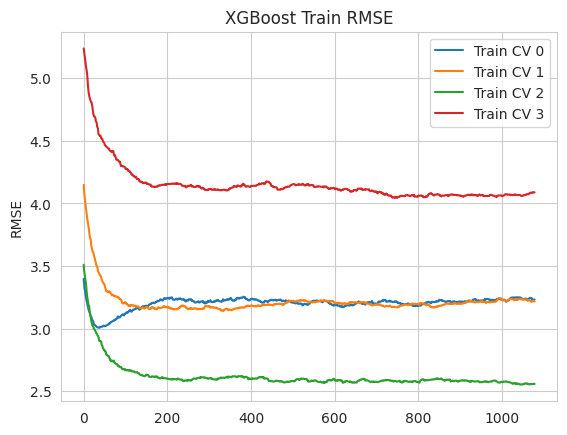

In [27]:
scores = []
fig, ax = plt.subplots()

i = 0
for train_index, test_index in kfolds.split(X_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]


    reg = XGBRegressor(
        n_estimators = 1079, 
        max_depth = 2, 
        subsample = 0.31, 
        colsample_bytree = 0.33, 
        colsample_bylevel = 0.27, 
        learning_rate = 0.03162277660168379,
        verbosity=0
    )
    reg.fit(X_train_cv, y_train_cv, eval_set=[(X_test_cv, y_test_cv)])
    y_pred = reg.predict(X_test)
    score_test = mean_squared_error(y_test, y_pred, squared = False)
    scores.append(score_test)
    
    results = reg.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    ax.plot(x_axis, results['validation_0']['rmse'], label=('Train CV ' + str(i)))
    
    i = i+1

    
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost Train RMSE')
plt.show()
    

In [28]:
# Get Average Score
print(sum(scores)/len(scores))

# Get Best Score
print(min(scores))



3.181776936089342
3.0874586837097104


# Data Augmentation via RHVAE

In [16]:
import torch
from pyraug.trainers.training_config import TrainingConfig
from pyraug.pipelines import TrainingPipeline
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA A100-PCIE-40GB'

In [26]:
config = TrainingConfig(
    output_dir='/home2/s438167/my_model',
    no_cuda = True,
    verbose = True
)

In [28]:
# Train model
pipeline = TrainingPipeline(training_config=config)
pipeline(train_data=np.column_stack((X_train, y_train)))

Data normalized using individual_min_max_scaling.
 -> If this is not the desired behavior pass an instance of DataProcess with 'data_normalization_type' attribute set to desired normalization or None

Created /home2/s438167/my_model folder since did not exist.

Model passed sanity check !

Created /home2/s438167/my_model/training_2022-11-05_15-30-32. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !
----------------------------------
Training ended!
Saved final model in /home2/s438167/my_model/training_2022-11-05_15-30-32/final_model


In [ ]:
from pyraug.pipelines.generation import GenerationPipeline
from pyraug.models import RHVAE
import os
model = RHVAE.load_from_folder('/home2/s438167/my_model/training_2022-11-05_15-30-32/final_model')

In [3]:
model

RHVAE(
  (encoder): Encoder_MLP(
    (layers): Sequential(
      (0): Linear(in_features=11, out_features=500, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=500, out_features=10, bias=True)
    (std): Linear(in_features=500, out_features=10, bias=True)
  )
  (decoder): Decoder_MLP(
    (layers): Sequential(
      (0): Linear(in_features=10, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=11, bias=True)
      (3): Sigmoid()
    )
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=11, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=10, bias=True)
    (lower): Linear(in_features=400, out_features=45, bias=True)
  )
)

In [7]:
# Generate Data
from pyraug.pipelines.generation import GenerationPipeline
from pyraug.models import RHVAE
import os

generation_pipe = GenerationPipeline(
    model=model
)

generation_pipe(3070)

Created dummy_output_dir/generation_2022-11-05_20-04-35. Generated data and sampler config will be saved here.

Generation successfully launched !



# Read in Generated Data, and concat with the original

In [39]:
data = []
for i in range(0,6):
    data.append(
        torch.load(
            "".join(
                ['/home2/s438167/MLFinal/dummy_output_dir/generation_2022-11-05_18-03-13/generated_data_500_', str(i), '.pt']
            )
        ).cpu().numpy()
    )
    
stacked_data = np.vstack(data)
             
stacked_data

array([[1.        , 0.2518712 , 0.05570231, ..., 0.052729  , 0.05218758,
        0.0019598 ],
       [1.        , 0.24189743, 0.03055371, ..., 0.0280695 , 0.03184133,
        0.0036752 ],
       [1.        , 0.2582731 , 0.05862165, ..., 0.05643272, 0.05554174,
        0.00198655],
       ...,
       [1.        , 0.26424858, 0.08206493, ..., 0.0772076 , 0.07549939,
        0.00134816],
       [1.        , 0.25571987, 0.06282961, ..., 0.0593205 , 0.05904571,
        0.00181765],
       [1.        , 0.25396317, 0.05454633, ..., 0.05147713, 0.05179613,
        0.00212604]], dtype=float32)

In [40]:
stacked_data.shape

(3000, 11)

In [41]:
# The VAE algo normalizes the data to 0,1. Transform back to original space
train_data=np.column_stack((X_train, y_train))
augmented_data = stacked_data * (train_data.max() - train_data.min()) + train_data.min()

In [47]:
X_aug = augmented_data[:,0:-1]
y_aug = augmented_data[:,-1].reshape(-1,1)

In [50]:
X_aug100 = np.vstack((X_train, X_aug[:100,:]))
y_aug100 = np.vstack((y_train, y_aug[:100,:]))

X_aug1000 = np.vstack((X_train, X_aug[:1000,:]))
y_aug1000 = np.vstack((y_train, y_aug[:1000,:]))

X_aug3000 = np.vstack((X_train, X_aug))
y_aug3000 = np.vstack((y_train, y_aug))

# Hyperparameter tuning on 3k Augmented Data

In [24]:


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

RANDOMSTATE = 42

xgb_tune_kwargs = {
    "n_estimators": tune.loguniform(100, 10000),
    "max_depth": tune.randint(0, 5), 
    "subsample": tune.quniform(0.25, 0.75, 0.01),
    "colsample_bytree": tune.quniform(0.05, 0.5, 0.01),
    "colsample_bylevel": tune.quniform(0.05, 0.5, 0.01),    
    "learning_rate": tune.quniform(-3.0, -1.0, 0.5)
}

xgb_tune_params = [k for k in xgb_tune_kwargs.keys() if k != 'wandb']
xgb_tune_params

# always use same k-folds for reproducibility
kfolds = KFold(n_splits = 4, shuffle=True, random_state=RANDOMSTATE)

# @wandb_mixin
def my_xgb(config):
    
    config['n_estimators'] = int(config['n_estimators'])     
    config['max_depth'] = int(config['max_depth']) + 2
    config['learning_rate'] = 10 ** config['learning_rate']
    
    xgb = XGBRegressor(
        objective='reg:squarederror',
        n_jobs=1,
        random_state=RANDOMSTATE,
        booster='gbtree',   
        scale_pos_weight=1, 
        **config,
    )
    scores = -cross_val_score(xgb, X_aug, y_aug,
                                      scoring="neg_root_mean_squared_error",
                                      cv=kfolds)
    rmse = np.mean(scores)
    tune.report(rmse=rmse)
    
    return {"rmse": rmse}

# set each to run for about 1 hour for comparability
NUM_SAMPLES=2048

start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))

algo = HyperOptSearch(random_state_seed=RANDOMSTATE)
# to limit number of cores, uncomment and set max_concurrent 
# algo = ConcurrencyLimiter(algo, max_concurrent=10)
scheduler = AsyncHyperBandScheduler()

analysis = tune.run(my_xgb,
                    num_samples=NUM_SAMPLES,
                    config=xgb_tune_kwargs,                    
                    name="hyperopt_xgb",
                    metric="rmse",
                    mode="min",
                    search_alg=algo,
                    scheduler=scheduler,
                    verbose=1,
                    resources_per_trial={"gpu": 1, "cpu": 55}
                   )

end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

2022-11-19 14:11:29,323	WARNING tune.py:686 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2022-11-19 14:11:29,543	ERROR tune.py:754 -- Trials did not complete: [my_xgb_56a0d8ba]
2022-11-19 14:11:29,544	INFO tune.py:758 -- Total run time: 27.09 seconds (26.83 seconds for the tuning loop).
2022-11-19 14:11:29,544	WARNING tune.py:764 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


Start Time           2022-11-19 14:10:57.722594
End Time             2022-11-19 14:11:29.553861
0:00:31


### 
== Status ==
Current time: 2022-11-06 04:02:51 (running for 07:09:59.35)
Memory usage on this node: 28.0/1488.0 GiB
Using AsyncHyperBand: num_stopped=1125 Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -0.9937049492789912
Resources requested: 0/72 CPUs, 0/1 GPUs, 0.0/1277.03 GiB heap, 0.0/186.26 GiB objects
Current best trial: 563261f0 with rmse=0.9913255828507491 and parameters={'n_estimators': 8654, 'max_depth': 3, 'subsample': 0.31, 'colsample_bytree': 0.48, 'colsample_bylevel': 0.1, 'learning_rate': 0.001}
Result logdir: /home2/s438167/ray_results/hyperopt_xgb
Number of trials: 2048/2048 (2048 TERMINATED)

2022-11-06 04:02:51,934	INFO tune.py:758 -- Total run time: 29399.66 seconds (29399.10 seconds for the tuning loop).

Start Time           2022-11-05 20:52:47.334404
End Time             2022-11-06 04:02:57.649565
7:10:10


In [63]:
aug_df = pd.DataFrame(augmented_data)
aug_df.columns = ["AGE",
                  "PTEDUCAT",
                  "APOE4",
                  "MMSE",
                  "DX.bl_AD",
                  "DX.bl_CN",
                  "DX.bl_EMCI",
                  "DX.bl_LMCI",
                  "PTGENDER_Female",
                  "PTGENDER_Male",
                  "MMSE.Change"]
aug_df.to_csv("augmented_data.csv", index = False)

# XGBoost Regression on Augmented Data

[0]	validation_0-rmse:15.56450
[1]	validation_0-rmse:15.54933
[2]	validation_0-rmse:15.53420
[3]	validation_0-rmse:15.51909
[4]	validation_0-rmse:15.50398
[5]	validation_0-rmse:15.48887
[6]	validation_0-rmse:15.47387
[7]	validation_0-rmse:15.45877
[8]	validation_0-rmse:15.44370
[9]	validation_0-rmse:15.42862
[10]	validation_0-rmse:15.41358
[11]	validation_0-rmse:15.39856
[12]	validation_0-rmse:15.38356
[13]	validation_0-rmse:15.36861
[14]	validation_0-rmse:15.35353
[15]	validation_0-rmse:15.33858
[16]	validation_0-rmse:15.32384
[17]	validation_0-rmse:15.30889
[18]	validation_0-rmse:15.29395
[19]	validation_0-rmse:15.27902
[20]	validation_0-rmse:15.26416
[21]	validation_0-rmse:15.24924
[22]	validation_0-rmse:15.23453
[23]	validation_0-rmse:15.21972
[24]	validation_0-rmse:15.20505
[25]	validation_0-rmse:15.19034
[26]	validation_0-rmse:15.17558
[27]	validation_0-rmse:15.16075
[28]	validation_0-rmse:15.14599
[29]	validation_0-rmse:15.13153
[30]	validation_0-rmse:15.11677
[31]	validation_0-

[251]	validation_0-rmse:12.20532
[252]	validation_0-rmse:12.19359
[253]	validation_0-rmse:12.18179
[254]	validation_0-rmse:12.17002
[255]	validation_0-rmse:12.15824
[256]	validation_0-rmse:12.14656
[257]	validation_0-rmse:12.13486
[258]	validation_0-rmse:12.12313
[259]	validation_0-rmse:12.11147
[260]	validation_0-rmse:12.09968
[261]	validation_0-rmse:12.08801
[262]	validation_0-rmse:12.07639
[263]	validation_0-rmse:12.06477
[264]	validation_0-rmse:12.05309
[265]	validation_0-rmse:12.04159
[266]	validation_0-rmse:12.03006
[267]	validation_0-rmse:12.01862
[268]	validation_0-rmse:12.00704
[269]	validation_0-rmse:11.99546
[270]	validation_0-rmse:11.98386
[271]	validation_0-rmse:11.97224
[272]	validation_0-rmse:11.96071
[273]	validation_0-rmse:11.94919
[274]	validation_0-rmse:11.93765
[275]	validation_0-rmse:11.92616
[276]	validation_0-rmse:11.91467
[277]	validation_0-rmse:11.90317
[278]	validation_0-rmse:11.89170
[279]	validation_0-rmse:11.88025
[280]	validation_0-rmse:11.86883
[281]	vali

[501]	validation_0-rmse:9.61017
[502]	validation_0-rmse:9.60134
[503]	validation_0-rmse:9.59221
[504]	validation_0-rmse:9.58327
[505]	validation_0-rmse:9.57418
[506]	validation_0-rmse:9.56510
[507]	validation_0-rmse:9.55600
[508]	validation_0-rmse:9.54698
[509]	validation_0-rmse:9.53811
[510]	validation_0-rmse:9.52916
[511]	validation_0-rmse:9.52015
[512]	validation_0-rmse:9.51110
[513]	validation_0-rmse:9.50206
[514]	validation_0-rmse:9.49308
[515]	validation_0-rmse:9.48403
[516]	validation_0-rmse:9.47505
[517]	validation_0-rmse:9.46610
[518]	validation_0-rmse:9.45711
[519]	validation_0-rmse:9.44814
[520]	validation_0-rmse:9.43920
[521]	validation_0-rmse:9.43034
[522]	validation_0-rmse:9.42152
[523]	validation_0-rmse:9.41259
[524]	validation_0-rmse:9.40365
[525]	validation_0-rmse:9.39477
[526]	validation_0-rmse:9.38588
[527]	validation_0-rmse:9.37701
[528]	validation_0-rmse:9.36804
[529]	validation_0-rmse:9.35919
[530]	validation_0-rmse:9.35029
[531]	validation_0-rmse:9.34168
[532]	va

[757]	validation_0-rmse:7.56361
[758]	validation_0-rmse:7.55665
[759]	validation_0-rmse:7.54969
[760]	validation_0-rmse:7.54269
[761]	validation_0-rmse:7.53579
[762]	validation_0-rmse:7.52881
[763]	validation_0-rmse:7.52184
[764]	validation_0-rmse:7.51488
[765]	validation_0-rmse:7.50791
[766]	validation_0-rmse:7.50099
[767]	validation_0-rmse:7.49406
[768]	validation_0-rmse:7.48718
[769]	validation_0-rmse:7.48028
[770]	validation_0-rmse:7.47342
[771]	validation_0-rmse:7.46648
[772]	validation_0-rmse:7.45961
[773]	validation_0-rmse:7.45278
[774]	validation_0-rmse:7.44593
[775]	validation_0-rmse:7.43906
[776]	validation_0-rmse:7.43223
[777]	validation_0-rmse:7.42529
[778]	validation_0-rmse:7.41841
[779]	validation_0-rmse:7.41156
[780]	validation_0-rmse:7.40471
[781]	validation_0-rmse:7.39790
[782]	validation_0-rmse:7.39111
[783]	validation_0-rmse:7.38432
[784]	validation_0-rmse:7.37755
[785]	validation_0-rmse:7.37072
[786]	validation_0-rmse:7.36400
[787]	validation_0-rmse:7.35716
[788]	va

[1013]	validation_0-rmse:6.00065
[1014]	validation_0-rmse:5.99534
[1015]	validation_0-rmse:5.99004
[1016]	validation_0-rmse:5.98477
[1017]	validation_0-rmse:5.97948
[1018]	validation_0-rmse:5.97417
[1019]	validation_0-rmse:5.96889
[1020]	validation_0-rmse:5.96362
[1021]	validation_0-rmse:5.95837
[1022]	validation_0-rmse:5.95307
[1023]	validation_0-rmse:5.94782
[1024]	validation_0-rmse:5.94257
[1025]	validation_0-rmse:5.93725
[1026]	validation_0-rmse:5.93197
[1027]	validation_0-rmse:5.92674
[1028]	validation_0-rmse:5.92154
[1029]	validation_0-rmse:5.91631
[1030]	validation_0-rmse:5.91103
[1031]	validation_0-rmse:5.90583
[1032]	validation_0-rmse:5.90054
[1033]	validation_0-rmse:5.89536
[1034]	validation_0-rmse:5.89016
[1035]	validation_0-rmse:5.88504
[1036]	validation_0-rmse:5.87989
[1037]	validation_0-rmse:5.87476
[1038]	validation_0-rmse:5.86950
[1039]	validation_0-rmse:5.86438
[1040]	validation_0-rmse:5.85923
[1041]	validation_0-rmse:5.85405
[1042]	validation_0-rmse:5.84885
[1043]	val

[1262]	validation_0-rmse:4.84555
[1263]	validation_0-rmse:4.84151
[1264]	validation_0-rmse:4.83736
[1265]	validation_0-rmse:4.83337
[1266]	validation_0-rmse:4.82936
[1267]	validation_0-rmse:4.82540
[1268]	validation_0-rmse:4.82152
[1269]	validation_0-rmse:4.81758
[1270]	validation_0-rmse:4.81353
[1271]	validation_0-rmse:4.80959
[1272]	validation_0-rmse:4.80558
[1273]	validation_0-rmse:4.80163
[1274]	validation_0-rmse:4.79768
[1275]	validation_0-rmse:4.79373
[1276]	validation_0-rmse:4.78985
[1277]	validation_0-rmse:4.78591
[1278]	validation_0-rmse:4.78197
[1279]	validation_0-rmse:4.77805
[1280]	validation_0-rmse:4.77413
[1281]	validation_0-rmse:4.77020
[1282]	validation_0-rmse:4.76630
[1283]	validation_0-rmse:4.76235
[1284]	validation_0-rmse:4.75844
[1285]	validation_0-rmse:4.75457
[1286]	validation_0-rmse:4.75069
[1287]	validation_0-rmse:4.74679
[1288]	validation_0-rmse:4.74292
[1289]	validation_0-rmse:4.73925
[1290]	validation_0-rmse:4.73533
[1291]	validation_0-rmse:4.73146
[1292]	val

[1511]	validation_0-rmse:3.97607
[1512]	validation_0-rmse:3.97311
[1513]	validation_0-rmse:3.97014
[1514]	validation_0-rmse:3.96714
[1515]	validation_0-rmse:3.96414
[1516]	validation_0-rmse:3.96113
[1517]	validation_0-rmse:3.95817
[1518]	validation_0-rmse:3.95524
[1519]	validation_0-rmse:3.95215
[1520]	validation_0-rmse:3.94918
[1521]	validation_0-rmse:3.94619
[1522]	validation_0-rmse:3.94325
[1523]	validation_0-rmse:3.94031
[1524]	validation_0-rmse:3.93733
[1525]	validation_0-rmse:3.93439
[1526]	validation_0-rmse:3.93146
[1527]	validation_0-rmse:3.92853
[1528]	validation_0-rmse:3.92557
[1529]	validation_0-rmse:3.92259
[1530]	validation_0-rmse:3.91969
[1531]	validation_0-rmse:3.91682
[1532]	validation_0-rmse:3.91393
[1533]	validation_0-rmse:3.91103
[1534]	validation_0-rmse:3.90814
[1535]	validation_0-rmse:3.90517
[1536]	validation_0-rmse:3.90214
[1537]	validation_0-rmse:3.89922
[1538]	validation_0-rmse:3.89625
[1539]	validation_0-rmse:3.89338
[1540]	validation_0-rmse:3.89048
[1541]	val

[1760]	validation_0-rmse:3.33257
[1761]	validation_0-rmse:3.33040
[1762]	validation_0-rmse:3.32813
[1763]	validation_0-rmse:3.32596
[1764]	validation_0-rmse:3.32380
[1765]	validation_0-rmse:3.32164
[1766]	validation_0-rmse:3.31942
[1767]	validation_0-rmse:3.31725
[1768]	validation_0-rmse:3.31506
[1769]	validation_0-rmse:3.31289
[1770]	validation_0-rmse:3.31072
[1771]	validation_0-rmse:3.30852
[1772]	validation_0-rmse:3.30640
[1773]	validation_0-rmse:3.30426
[1774]	validation_0-rmse:3.30196
[1775]	validation_0-rmse:3.29971
[1776]	validation_0-rmse:3.29755
[1777]	validation_0-rmse:3.29542
[1778]	validation_0-rmse:3.29326
[1779]	validation_0-rmse:3.29111
[1780]	validation_0-rmse:3.28894
[1781]	validation_0-rmse:3.28678
[1782]	validation_0-rmse:3.28457
[1783]	validation_0-rmse:3.28235
[1784]	validation_0-rmse:3.28022
[1785]	validation_0-rmse:3.27811
[1786]	validation_0-rmse:3.27595
[1787]	validation_0-rmse:3.27388
[1788]	validation_0-rmse:3.27177
[1789]	validation_0-rmse:3.26970
[1790]	val

[2009]	validation_0-rmse:2.86463
[2010]	validation_0-rmse:2.86305
[2011]	validation_0-rmse:2.86145
[2012]	validation_0-rmse:2.85992
[2013]	validation_0-rmse:2.85837
[2014]	validation_0-rmse:2.85685
[2015]	validation_0-rmse:2.85524
[2016]	validation_0-rmse:2.85360
[2017]	validation_0-rmse:2.85199
[2018]	validation_0-rmse:2.85033
[2019]	validation_0-rmse:2.84876
[2020]	validation_0-rmse:2.84723
[2021]	validation_0-rmse:2.84572
[2022]	validation_0-rmse:2.84404
[2023]	validation_0-rmse:2.84251
[2024]	validation_0-rmse:2.84101
[2025]	validation_0-rmse:2.83950
[2026]	validation_0-rmse:2.83795
[2027]	validation_0-rmse:2.83643
[2028]	validation_0-rmse:2.83493
[2029]	validation_0-rmse:2.83335
[2030]	validation_0-rmse:2.83166
[2031]	validation_0-rmse:2.83002
[2032]	validation_0-rmse:2.82850
[2033]	validation_0-rmse:2.82689
[2034]	validation_0-rmse:2.82541
[2035]	validation_0-rmse:2.82388
[2036]	validation_0-rmse:2.82242
[2037]	validation_0-rmse:2.82079
[2038]	validation_0-rmse:2.81932
[2039]	val

[2258]	validation_0-rmse:2.53208
[2259]	validation_0-rmse:2.53089
[2260]	validation_0-rmse:2.52969
[2261]	validation_0-rmse:2.52858
[2262]	validation_0-rmse:2.52751
[2263]	validation_0-rmse:2.52646
[2264]	validation_0-rmse:2.52538
[2265]	validation_0-rmse:2.52415
[2266]	validation_0-rmse:2.52302
[2267]	validation_0-rmse:2.52196
[2268]	validation_0-rmse:2.52086
[2269]	validation_0-rmse:2.51980
[2270]	validation_0-rmse:2.51876
[2271]	validation_0-rmse:2.51772
[2272]	validation_0-rmse:2.51655
[2273]	validation_0-rmse:2.51535
[2274]	validation_0-rmse:2.51426
[2275]	validation_0-rmse:2.51319
[2276]	validation_0-rmse:2.51212
[2277]	validation_0-rmse:2.51109
[2278]	validation_0-rmse:2.50994
[2279]	validation_0-rmse:2.50887
[2280]	validation_0-rmse:2.50786
[2281]	validation_0-rmse:2.50681
[2282]	validation_0-rmse:2.50580
[2283]	validation_0-rmse:2.50481
[2284]	validation_0-rmse:2.50377
[2285]	validation_0-rmse:2.50263
[2286]	validation_0-rmse:2.50162
[2287]	validation_0-rmse:2.50062
[2288]	val

[2507]	validation_0-rmse:2.29924
[2508]	validation_0-rmse:2.29849
[2509]	validation_0-rmse:2.29769
[2510]	validation_0-rmse:2.29697
[2511]	validation_0-rmse:2.29623
[2512]	validation_0-rmse:2.29542
[2513]	validation_0-rmse:2.29465
[2514]	validation_0-rmse:2.29388
[2515]	validation_0-rmse:2.29313
[2516]	validation_0-rmse:2.29234
[2517]	validation_0-rmse:2.29159
[2518]	validation_0-rmse:2.29091
[2519]	validation_0-rmse:2.29016
[2520]	validation_0-rmse:2.28944
[2521]	validation_0-rmse:2.28867
[2522]	validation_0-rmse:2.28797
[2523]	validation_0-rmse:2.28726
[2524]	validation_0-rmse:2.28650
[2525]	validation_0-rmse:2.28578
[2526]	validation_0-rmse:2.28506
[2527]	validation_0-rmse:2.28432
[2528]	validation_0-rmse:2.28366
[2529]	validation_0-rmse:2.28286
[2530]	validation_0-rmse:2.28221
[2531]	validation_0-rmse:2.28167
[2532]	validation_0-rmse:2.28087
[2533]	validation_0-rmse:2.28014
[2534]	validation_0-rmse:2.27941
[2535]	validation_0-rmse:2.27872
[2536]	validation_0-rmse:2.27803
[2537]	val

[2756]	validation_0-rmse:2.14290
[2757]	validation_0-rmse:2.14240
[2758]	validation_0-rmse:2.14185
[2759]	validation_0-rmse:2.14135
[2760]	validation_0-rmse:2.14084
[2761]	validation_0-rmse:2.14034
[2762]	validation_0-rmse:2.13984
[2763]	validation_0-rmse:2.13930
[2764]	validation_0-rmse:2.13881
[2765]	validation_0-rmse:2.13833
[2766]	validation_0-rmse:2.13788
[2767]	validation_0-rmse:2.13746
[2768]	validation_0-rmse:2.13701
[2769]	validation_0-rmse:2.13655
[2770]	validation_0-rmse:2.13595
[2771]	validation_0-rmse:2.13545
[2772]	validation_0-rmse:2.13494
[2773]	validation_0-rmse:2.13440
[2774]	validation_0-rmse:2.13388
[2775]	validation_0-rmse:2.13337
[2776]	validation_0-rmse:2.13288
[2777]	validation_0-rmse:2.13240
[2778]	validation_0-rmse:2.13191
[2779]	validation_0-rmse:2.13142
[2780]	validation_0-rmse:2.13092
[2781]	validation_0-rmse:2.13047
[2782]	validation_0-rmse:2.13003
[2783]	validation_0-rmse:2.12955
[2784]	validation_0-rmse:2.12905
[2785]	validation_0-rmse:2.12859
[2786]	val

[3005]	validation_0-rmse:2.03711
[3006]	validation_0-rmse:2.03677
[3007]	validation_0-rmse:2.03641
[3008]	validation_0-rmse:2.03609
[3009]	validation_0-rmse:2.03574
[3010]	validation_0-rmse:2.03532
[3011]	validation_0-rmse:2.03502
[3012]	validation_0-rmse:2.03462
[3013]	validation_0-rmse:2.03429
[3014]	validation_0-rmse:2.03394
[3015]	validation_0-rmse:2.03363
[3016]	validation_0-rmse:2.03336
[3017]	validation_0-rmse:2.03305
[3018]	validation_0-rmse:2.03273
[3019]	validation_0-rmse:2.03239
[3020]	validation_0-rmse:2.03200
[3021]	validation_0-rmse:2.03165
[3022]	validation_0-rmse:2.03123
[3023]	validation_0-rmse:2.03085
[3024]	validation_0-rmse:2.03056
[3025]	validation_0-rmse:2.03023
[3026]	validation_0-rmse:2.02995
[3027]	validation_0-rmse:2.02962
[3028]	validation_0-rmse:2.02929
[3029]	validation_0-rmse:2.02898
[3030]	validation_0-rmse:2.02869
[3031]	validation_0-rmse:2.02837
[3032]	validation_0-rmse:2.02807
[3033]	validation_0-rmse:2.02776
[3034]	validation_0-rmse:2.02747
[3035]	val

[3254]	validation_0-rmse:1.96731
[3255]	validation_0-rmse:1.96700
[3256]	validation_0-rmse:1.96680
[3257]	validation_0-rmse:1.96660
[3258]	validation_0-rmse:1.96642
[3259]	validation_0-rmse:1.96613
[3260]	validation_0-rmse:1.96590
[3261]	validation_0-rmse:1.96567
[3262]	validation_0-rmse:1.96543
[3263]	validation_0-rmse:1.96520
[3264]	validation_0-rmse:1.96499
[3265]	validation_0-rmse:1.96469
[3266]	validation_0-rmse:1.96444
[3267]	validation_0-rmse:1.96426
[3268]	validation_0-rmse:1.96413
[3269]	validation_0-rmse:1.96392
[3270]	validation_0-rmse:1.96372
[3271]	validation_0-rmse:1.96348
[3272]	validation_0-rmse:1.96331
[3273]	validation_0-rmse:1.96306
[3274]	validation_0-rmse:1.96293
[3275]	validation_0-rmse:1.96277
[3276]	validation_0-rmse:1.96257
[3277]	validation_0-rmse:1.96239
[3278]	validation_0-rmse:1.96219
[3279]	validation_0-rmse:1.96204
[3280]	validation_0-rmse:1.96181
[3281]	validation_0-rmse:1.96152
[3282]	validation_0-rmse:1.96133
[3283]	validation_0-rmse:1.96109
[3284]	val

[3503]	validation_0-rmse:1.92033
[3504]	validation_0-rmse:1.92012
[3505]	validation_0-rmse:1.91997
[3506]	validation_0-rmse:1.91991
[3507]	validation_0-rmse:1.91974
[3508]	validation_0-rmse:1.91955
[3509]	validation_0-rmse:1.91939
[3510]	validation_0-rmse:1.91925
[3511]	validation_0-rmse:1.91915
[3512]	validation_0-rmse:1.91900
[3513]	validation_0-rmse:1.91885
[3514]	validation_0-rmse:1.91866
[3515]	validation_0-rmse:1.91852
[3516]	validation_0-rmse:1.91827
[3517]	validation_0-rmse:1.91813
[3518]	validation_0-rmse:1.91812
[3519]	validation_0-rmse:1.91799
[3520]	validation_0-rmse:1.91785
[3521]	validation_0-rmse:1.91764
[3522]	validation_0-rmse:1.91754
[3523]	validation_0-rmse:1.91736
[3524]	validation_0-rmse:1.91721
[3525]	validation_0-rmse:1.91708
[3526]	validation_0-rmse:1.91695
[3527]	validation_0-rmse:1.91678
[3528]	validation_0-rmse:1.91665
[3529]	validation_0-rmse:1.91654
[3530]	validation_0-rmse:1.91637
[3531]	validation_0-rmse:1.91605
[3532]	validation_0-rmse:1.91577
[3533]	val

[3752]	validation_0-rmse:1.88748
[3753]	validation_0-rmse:1.88739
[3754]	validation_0-rmse:1.88719
[3755]	validation_0-rmse:1.88703
[3756]	validation_0-rmse:1.88693
[3757]	validation_0-rmse:1.88676
[3758]	validation_0-rmse:1.88666
[3759]	validation_0-rmse:1.88653
[3760]	validation_0-rmse:1.88646
[3761]	validation_0-rmse:1.88627
[3762]	validation_0-rmse:1.88615
[3763]	validation_0-rmse:1.88613
[3764]	validation_0-rmse:1.88602
[3765]	validation_0-rmse:1.88592
[3766]	validation_0-rmse:1.88583
[3767]	validation_0-rmse:1.88568
[3768]	validation_0-rmse:1.88558
[3769]	validation_0-rmse:1.88544
[3770]	validation_0-rmse:1.88534
[3771]	validation_0-rmse:1.88525
[3772]	validation_0-rmse:1.88524
[3773]	validation_0-rmse:1.88510
[3774]	validation_0-rmse:1.88501
[3775]	validation_0-rmse:1.88491
[3776]	validation_0-rmse:1.88480
[3777]	validation_0-rmse:1.88461
[3778]	validation_0-rmse:1.88445
[3779]	validation_0-rmse:1.88430
[3780]	validation_0-rmse:1.88427
[3781]	validation_0-rmse:1.88414
[3782]	val

[4001]	validation_0-rmse:1.86245
[4002]	validation_0-rmse:1.86237
[4003]	validation_0-rmse:1.86218
[4004]	validation_0-rmse:1.86213
[4005]	validation_0-rmse:1.86217
[4006]	validation_0-rmse:1.86210
[4007]	validation_0-rmse:1.86195
[4008]	validation_0-rmse:1.86189
[4009]	validation_0-rmse:1.86182
[4010]	validation_0-rmse:1.86177
[4011]	validation_0-rmse:1.86169
[4012]	validation_0-rmse:1.86158
[4013]	validation_0-rmse:1.86154
[4014]	validation_0-rmse:1.86153
[4015]	validation_0-rmse:1.86143
[4016]	validation_0-rmse:1.86136
[4017]	validation_0-rmse:1.86131
[4018]	validation_0-rmse:1.86127
[4019]	validation_0-rmse:1.86116
[4020]	validation_0-rmse:1.86102
[4021]	validation_0-rmse:1.86091
[4022]	validation_0-rmse:1.86082
[4023]	validation_0-rmse:1.86071
[4024]	validation_0-rmse:1.86058
[4025]	validation_0-rmse:1.86053
[4026]	validation_0-rmse:1.86039
[4027]	validation_0-rmse:1.86034
[4028]	validation_0-rmse:1.86023
[4029]	validation_0-rmse:1.86014
[4030]	validation_0-rmse:1.86011
[4031]	val

[4250]	validation_0-rmse:1.84561
[4251]	validation_0-rmse:1.84556
[4252]	validation_0-rmse:1.84558
[4253]	validation_0-rmse:1.84554
[4254]	validation_0-rmse:1.84549
[4255]	validation_0-rmse:1.84546
[4256]	validation_0-rmse:1.84535
[4257]	validation_0-rmse:1.84532
[4258]	validation_0-rmse:1.84527
[4259]	validation_0-rmse:1.84518
[4260]	validation_0-rmse:1.84514
[4261]	validation_0-rmse:1.84508
[4262]	validation_0-rmse:1.84501
[4263]	validation_0-rmse:1.84508
[4264]	validation_0-rmse:1.84498
[4265]	validation_0-rmse:1.84489
[4266]	validation_0-rmse:1.84487
[4267]	validation_0-rmse:1.84475
[4268]	validation_0-rmse:1.84458
[4269]	validation_0-rmse:1.84449
[4270]	validation_0-rmse:1.84446
[4271]	validation_0-rmse:1.84441
[4272]	validation_0-rmse:1.84427
[4273]	validation_0-rmse:1.84425
[4274]	validation_0-rmse:1.84422
[4275]	validation_0-rmse:1.84413
[4276]	validation_0-rmse:1.84407
[4277]	validation_0-rmse:1.84398
[4278]	validation_0-rmse:1.84387
[4279]	validation_0-rmse:1.84381
[4280]	val

[4499]	validation_0-rmse:1.83377
[4500]	validation_0-rmse:1.83377
[4501]	validation_0-rmse:1.83374
[4502]	validation_0-rmse:1.83362
[4503]	validation_0-rmse:1.83360
[4504]	validation_0-rmse:1.83358
[4505]	validation_0-rmse:1.83358
[4506]	validation_0-rmse:1.83356
[4507]	validation_0-rmse:1.83357
[4508]	validation_0-rmse:1.83348
[4509]	validation_0-rmse:1.83344
[4510]	validation_0-rmse:1.83340
[4511]	validation_0-rmse:1.83339
[4512]	validation_0-rmse:1.83340
[4513]	validation_0-rmse:1.83337
[4514]	validation_0-rmse:1.83332
[4515]	validation_0-rmse:1.83328
[4516]	validation_0-rmse:1.83324
[4517]	validation_0-rmse:1.83317
[4518]	validation_0-rmse:1.83312
[4519]	validation_0-rmse:1.83316
[4520]	validation_0-rmse:1.83315
[4521]	validation_0-rmse:1.83313
[4522]	validation_0-rmse:1.83307
[4523]	validation_0-rmse:1.83304
[4524]	validation_0-rmse:1.83300
[4525]	validation_0-rmse:1.83297
[4526]	validation_0-rmse:1.83296
[4527]	validation_0-rmse:1.83288
[4528]	validation_0-rmse:1.83283
[4529]	val

[4748]	validation_0-rmse:1.82384
[4749]	validation_0-rmse:1.82381
[4750]	validation_0-rmse:1.82379
[4751]	validation_0-rmse:1.82376
[4752]	validation_0-rmse:1.82366
[4753]	validation_0-rmse:1.82360
[4754]	validation_0-rmse:1.82355
[4755]	validation_0-rmse:1.82351
[4756]	validation_0-rmse:1.82349
[4757]	validation_0-rmse:1.82345
[4758]	validation_0-rmse:1.82342
[4759]	validation_0-rmse:1.82340
[4760]	validation_0-rmse:1.82340
[4761]	validation_0-rmse:1.82332
[4762]	validation_0-rmse:1.82334
[4763]	validation_0-rmse:1.82328
[4764]	validation_0-rmse:1.82332
[4765]	validation_0-rmse:1.82325
[4766]	validation_0-rmse:1.82324
[4767]	validation_0-rmse:1.82320
[4768]	validation_0-rmse:1.82320
[4769]	validation_0-rmse:1.82315
[4770]	validation_0-rmse:1.82312
[4771]	validation_0-rmse:1.82309
[4772]	validation_0-rmse:1.82308
[4773]	validation_0-rmse:1.82303
[4774]	validation_0-rmse:1.82304
[4775]	validation_0-rmse:1.82303
[4776]	validation_0-rmse:1.82301
[4777]	validation_0-rmse:1.82304
[4778]	val

[4997]	validation_0-rmse:1.81573
[4998]	validation_0-rmse:1.81567
[4999]	validation_0-rmse:1.81566
[5000]	validation_0-rmse:1.81559
[5001]	validation_0-rmse:1.81548
[5002]	validation_0-rmse:1.81546
[5003]	validation_0-rmse:1.81546
[5004]	validation_0-rmse:1.81543
[5005]	validation_0-rmse:1.81542
[5006]	validation_0-rmse:1.81534
[5007]	validation_0-rmse:1.81525
[5008]	validation_0-rmse:1.81517
[5009]	validation_0-rmse:1.81505
[5010]	validation_0-rmse:1.81503
[5011]	validation_0-rmse:1.81496
[5012]	validation_0-rmse:1.81502
[5013]	validation_0-rmse:1.81508
[5014]	validation_0-rmse:1.81495
[5015]	validation_0-rmse:1.81485
[5016]	validation_0-rmse:1.81480
[5017]	validation_0-rmse:1.81479
[5018]	validation_0-rmse:1.81481
[5019]	validation_0-rmse:1.81475
[5020]	validation_0-rmse:1.81467
[5021]	validation_0-rmse:1.81462
[5022]	validation_0-rmse:1.81461
[5023]	validation_0-rmse:1.81463
[5024]	validation_0-rmse:1.81460
[5025]	validation_0-rmse:1.81454
[5026]	validation_0-rmse:1.81453
[5027]	val

[5246]	validation_0-rmse:1.80851
[5247]	validation_0-rmse:1.80848
[5248]	validation_0-rmse:1.80849
[5249]	validation_0-rmse:1.80835
[5250]	validation_0-rmse:1.80832
[5251]	validation_0-rmse:1.80828
[5252]	validation_0-rmse:1.80817
[5253]	validation_0-rmse:1.80815
[5254]	validation_0-rmse:1.80818
[5255]	validation_0-rmse:1.80809
[5256]	validation_0-rmse:1.80805
[5257]	validation_0-rmse:1.80801
[5258]	validation_0-rmse:1.80794
[5259]	validation_0-rmse:1.80792
[5260]	validation_0-rmse:1.80784
[5261]	validation_0-rmse:1.80780
[5262]	validation_0-rmse:1.80777
[5263]	validation_0-rmse:1.80775
[5264]	validation_0-rmse:1.80775
[5265]	validation_0-rmse:1.80775
[5266]	validation_0-rmse:1.80774
[5267]	validation_0-rmse:1.80772
[5268]	validation_0-rmse:1.80769
[5269]	validation_0-rmse:1.80770
[5270]	validation_0-rmse:1.80769
[5271]	validation_0-rmse:1.80764
[5272]	validation_0-rmse:1.80758
[5273]	validation_0-rmse:1.80757
[5274]	validation_0-rmse:1.80753
[5275]	validation_0-rmse:1.80751
[5276]	val

[5495]	validation_0-rmse:1.80149
[5496]	validation_0-rmse:1.80142
[5497]	validation_0-rmse:1.80149
[5498]	validation_0-rmse:1.80146
[5499]	validation_0-rmse:1.80141
[5500]	validation_0-rmse:1.80132
[5501]	validation_0-rmse:1.80125
[5502]	validation_0-rmse:1.80131
[5503]	validation_0-rmse:1.80137
[5504]	validation_0-rmse:1.80137
[5505]	validation_0-rmse:1.80134
[5506]	validation_0-rmse:1.80132
[5507]	validation_0-rmse:1.80129
[5508]	validation_0-rmse:1.80120
[5509]	validation_0-rmse:1.80120
[5510]	validation_0-rmse:1.80120
[5511]	validation_0-rmse:1.80116
[5512]	validation_0-rmse:1.80112
[5513]	validation_0-rmse:1.80116
[5514]	validation_0-rmse:1.80110
[5515]	validation_0-rmse:1.80104
[5516]	validation_0-rmse:1.80102
[5517]	validation_0-rmse:1.80094
[5518]	validation_0-rmse:1.80094
[5519]	validation_0-rmse:1.80095
[5520]	validation_0-rmse:1.80092
[5521]	validation_0-rmse:1.80095
[5522]	validation_0-rmse:1.80092
[5523]	validation_0-rmse:1.80074
[5524]	validation_0-rmse:1.80077
[5525]	val

[5744]	validation_0-rmse:1.79539
[5745]	validation_0-rmse:1.79541
[5746]	validation_0-rmse:1.79541
[5747]	validation_0-rmse:1.79531
[5748]	validation_0-rmse:1.79539
[5749]	validation_0-rmse:1.79538
[5750]	validation_0-rmse:1.79529
[5751]	validation_0-rmse:1.79524
[5752]	validation_0-rmse:1.79528
[5753]	validation_0-rmse:1.79530
[5754]	validation_0-rmse:1.79525
[5755]	validation_0-rmse:1.79526
[5756]	validation_0-rmse:1.79524
[5757]	validation_0-rmse:1.79526
[5758]	validation_0-rmse:1.79525
[5759]	validation_0-rmse:1.79523
[5760]	validation_0-rmse:1.79519
[5761]	validation_0-rmse:1.79517
[5762]	validation_0-rmse:1.79524
[5763]	validation_0-rmse:1.79523
[5764]	validation_0-rmse:1.79523
[5765]	validation_0-rmse:1.79515
[5766]	validation_0-rmse:1.79515
[5767]	validation_0-rmse:1.79516
[5768]	validation_0-rmse:1.79511
[5769]	validation_0-rmse:1.79512
[5770]	validation_0-rmse:1.79514
[5771]	validation_0-rmse:1.79507
[5772]	validation_0-rmse:1.79498
[5773]	validation_0-rmse:1.79494
[5774]	val

[5993]	validation_0-rmse:1.78978
[5994]	validation_0-rmse:1.78977
[5995]	validation_0-rmse:1.78976
[5996]	validation_0-rmse:1.78965
[5997]	validation_0-rmse:1.78963
[5998]	validation_0-rmse:1.78971
[5999]	validation_0-rmse:1.78967
[6000]	validation_0-rmse:1.78964
[6001]	validation_0-rmse:1.78963
[6002]	validation_0-rmse:1.78966
[6003]	validation_0-rmse:1.78974
[6004]	validation_0-rmse:1.78970
[6005]	validation_0-rmse:1.78969
[6006]	validation_0-rmse:1.78973
[6007]	validation_0-rmse:1.78958
[6008]	validation_0-rmse:1.78955
[6009]	validation_0-rmse:1.78943
[6010]	validation_0-rmse:1.78943
[6011]	validation_0-rmse:1.78940
[6012]	validation_0-rmse:1.78936
[6013]	validation_0-rmse:1.78930
[6014]	validation_0-rmse:1.78928
[6015]	validation_0-rmse:1.78924
[6016]	validation_0-rmse:1.78916
[6017]	validation_0-rmse:1.78916
[6018]	validation_0-rmse:1.78913
[6019]	validation_0-rmse:1.78911
[6020]	validation_0-rmse:1.78910
[6021]	validation_0-rmse:1.78910
[6022]	validation_0-rmse:1.78906
[6023]	val

[6242]	validation_0-rmse:1.78367
[6243]	validation_0-rmse:1.78357
[6244]	validation_0-rmse:1.78356
[6245]	validation_0-rmse:1.78355
[6246]	validation_0-rmse:1.78347
[6247]	validation_0-rmse:1.78340
[6248]	validation_0-rmse:1.78339
[6249]	validation_0-rmse:1.78341
[6250]	validation_0-rmse:1.78337
[6251]	validation_0-rmse:1.78334
[6252]	validation_0-rmse:1.78333
[6253]	validation_0-rmse:1.78331
[6254]	validation_0-rmse:1.78335
[6255]	validation_0-rmse:1.78329
[6256]	validation_0-rmse:1.78328
[6257]	validation_0-rmse:1.78329
[6258]	validation_0-rmse:1.78320
[6259]	validation_0-rmse:1.78317
[6260]	validation_0-rmse:1.78302
[6261]	validation_0-rmse:1.78300
[6262]	validation_0-rmse:1.78296
[6263]	validation_0-rmse:1.78297
[6264]	validation_0-rmse:1.78295
[6265]	validation_0-rmse:1.78295
[6266]	validation_0-rmse:1.78288
[6267]	validation_0-rmse:1.78295
[6268]	validation_0-rmse:1.78294
[6269]	validation_0-rmse:1.78293
[6270]	validation_0-rmse:1.78295
[6271]	validation_0-rmse:1.78293
[6272]	val

[6491]	validation_0-rmse:1.77848
[6492]	validation_0-rmse:1.77849
[6493]	validation_0-rmse:1.77845
[6494]	validation_0-rmse:1.77852
[6495]	validation_0-rmse:1.77855
[6496]	validation_0-rmse:1.77850
[6497]	validation_0-rmse:1.77841
[6498]	validation_0-rmse:1.77844
[6499]	validation_0-rmse:1.77842
[6500]	validation_0-rmse:1.77829
[6501]	validation_0-rmse:1.77824
[6502]	validation_0-rmse:1.77821
[6503]	validation_0-rmse:1.77811
[6504]	validation_0-rmse:1.77805
[6505]	validation_0-rmse:1.77806
[6506]	validation_0-rmse:1.77802
[6507]	validation_0-rmse:1.77802
[6508]	validation_0-rmse:1.77800
[6509]	validation_0-rmse:1.77799
[6510]	validation_0-rmse:1.77799
[6511]	validation_0-rmse:1.77799
[6512]	validation_0-rmse:1.77793
[6513]	validation_0-rmse:1.77792
[6514]	validation_0-rmse:1.77794
[6515]	validation_0-rmse:1.77792
[6516]	validation_0-rmse:1.77793
[6517]	validation_0-rmse:1.77792
[6518]	validation_0-rmse:1.77788
[6519]	validation_0-rmse:1.77787
[6520]	validation_0-rmse:1.77784
[6521]	val

[6740]	validation_0-rmse:1.77263
[6741]	validation_0-rmse:1.77264
[6742]	validation_0-rmse:1.77263
[6743]	validation_0-rmse:1.77264
[6744]	validation_0-rmse:1.77261
[6745]	validation_0-rmse:1.77256
[6746]	validation_0-rmse:1.77256
[6747]	validation_0-rmse:1.77258
[6748]	validation_0-rmse:1.77256
[6749]	validation_0-rmse:1.77254
[6750]	validation_0-rmse:1.77254
[6751]	validation_0-rmse:1.77253
[6752]	validation_0-rmse:1.77241
[6753]	validation_0-rmse:1.77239
[6754]	validation_0-rmse:1.77243
[6755]	validation_0-rmse:1.77245
[6756]	validation_0-rmse:1.77245
[6757]	validation_0-rmse:1.77241
[6758]	validation_0-rmse:1.77245
[6759]	validation_0-rmse:1.77245
[6760]	validation_0-rmse:1.77241
[6761]	validation_0-rmse:1.77243
[6762]	validation_0-rmse:1.77243
[6763]	validation_0-rmse:1.77239
[6764]	validation_0-rmse:1.77237
[6765]	validation_0-rmse:1.77235
[6766]	validation_0-rmse:1.77234
[6767]	validation_0-rmse:1.77231
[6768]	validation_0-rmse:1.77230
[6769]	validation_0-rmse:1.77218
[6770]	val

[6989]	validation_0-rmse:1.76814
[6990]	validation_0-rmse:1.76802
[6991]	validation_0-rmse:1.76802
[6992]	validation_0-rmse:1.76800
[6993]	validation_0-rmse:1.76808
[6994]	validation_0-rmse:1.76801
[6995]	validation_0-rmse:1.76783
[6996]	validation_0-rmse:1.76779
[6997]	validation_0-rmse:1.76777
[6998]	validation_0-rmse:1.76768
[6999]	validation_0-rmse:1.76760
[7000]	validation_0-rmse:1.76762
[7001]	validation_0-rmse:1.76763
[7002]	validation_0-rmse:1.76762
[7003]	validation_0-rmse:1.76757
[7004]	validation_0-rmse:1.76746
[7005]	validation_0-rmse:1.76749
[7006]	validation_0-rmse:1.76748
[7007]	validation_0-rmse:1.76747
[7008]	validation_0-rmse:1.76740
[7009]	validation_0-rmse:1.76740
[7010]	validation_0-rmse:1.76743
[7011]	validation_0-rmse:1.76745
[7012]	validation_0-rmse:1.76742
[7013]	validation_0-rmse:1.76744
[7014]	validation_0-rmse:1.76743
[7015]	validation_0-rmse:1.76739
[7016]	validation_0-rmse:1.76737
[7017]	validation_0-rmse:1.76734
[7018]	validation_0-rmse:1.76740
[7019]	val

[7238]	validation_0-rmse:1.76314
[7239]	validation_0-rmse:1.76304
[7240]	validation_0-rmse:1.76300
[7241]	validation_0-rmse:1.76301
[7242]	validation_0-rmse:1.76300
[7243]	validation_0-rmse:1.76293
[7244]	validation_0-rmse:1.76293
[7245]	validation_0-rmse:1.76292
[7246]	validation_0-rmse:1.76285
[7247]	validation_0-rmse:1.76283
[7248]	validation_0-rmse:1.76275
[7249]	validation_0-rmse:1.76259
[7250]	validation_0-rmse:1.76265
[7251]	validation_0-rmse:1.76251
[7252]	validation_0-rmse:1.76255
[7253]	validation_0-rmse:1.76232
[7254]	validation_0-rmse:1.76230
[7255]	validation_0-rmse:1.76227
[7256]	validation_0-rmse:1.76227
[7257]	validation_0-rmse:1.76214
[7258]	validation_0-rmse:1.76214
[7259]	validation_0-rmse:1.76199
[7260]	validation_0-rmse:1.76199
[7261]	validation_0-rmse:1.76197
[7262]	validation_0-rmse:1.76196
[7263]	validation_0-rmse:1.76194
[7264]	validation_0-rmse:1.76190
[7265]	validation_0-rmse:1.76191
[7266]	validation_0-rmse:1.76191
[7267]	validation_0-rmse:1.76191
[7268]	val

[7487]	validation_0-rmse:1.75899
[7488]	validation_0-rmse:1.75894
[7489]	validation_0-rmse:1.75896
[7490]	validation_0-rmse:1.75896
[7491]	validation_0-rmse:1.75894
[7492]	validation_0-rmse:1.75907
[7493]	validation_0-rmse:1.75906
[7494]	validation_0-rmse:1.75907
[7495]	validation_0-rmse:1.75906
[7496]	validation_0-rmse:1.75898
[7497]	validation_0-rmse:1.75899
[7498]	validation_0-rmse:1.75895
[7499]	validation_0-rmse:1.75895
[7500]	validation_0-rmse:1.75894
[7501]	validation_0-rmse:1.75896
[7502]	validation_0-rmse:1.75895
[7503]	validation_0-rmse:1.75878
[7504]	validation_0-rmse:1.75878
[7505]	validation_0-rmse:1.75877
[7506]	validation_0-rmse:1.75878
[7507]	validation_0-rmse:1.75871
[7508]	validation_0-rmse:1.75857
[7509]	validation_0-rmse:1.75855
[7510]	validation_0-rmse:1.75853
[7511]	validation_0-rmse:1.75853
[7512]	validation_0-rmse:1.75848
[7513]	validation_0-rmse:1.75854
[7514]	validation_0-rmse:1.75842
[7515]	validation_0-rmse:1.75839
[7516]	validation_0-rmse:1.75837
[7517]	val

[7736]	validation_0-rmse:1.75459
[7737]	validation_0-rmse:1.75447
[7738]	validation_0-rmse:1.75446
[7739]	validation_0-rmse:1.75444
[7740]	validation_0-rmse:1.75443
[7741]	validation_0-rmse:1.75443
[7742]	validation_0-rmse:1.75445
[7743]	validation_0-rmse:1.75439
[7744]	validation_0-rmse:1.75438
[7745]	validation_0-rmse:1.75442
[7746]	validation_0-rmse:1.75443
[7747]	validation_0-rmse:1.75446
[7748]	validation_0-rmse:1.75447
[7749]	validation_0-rmse:1.75445
[7750]	validation_0-rmse:1.75444
[7751]	validation_0-rmse:1.75445
[7752]	validation_0-rmse:1.75445
[7753]	validation_0-rmse:1.75444
[7754]	validation_0-rmse:1.75452
[7755]	validation_0-rmse:1.75449
[7756]	validation_0-rmse:1.75449
[7757]	validation_0-rmse:1.75448
[7758]	validation_0-rmse:1.75446
[7759]	validation_0-rmse:1.75446
[7760]	validation_0-rmse:1.75441
[7761]	validation_0-rmse:1.75437
[7762]	validation_0-rmse:1.75434
[7763]	validation_0-rmse:1.75441
[7764]	validation_0-rmse:1.75444
[7765]	validation_0-rmse:1.75444
[7766]	val

[7985]	validation_0-rmse:1.75115
[7986]	validation_0-rmse:1.75116
[7987]	validation_0-rmse:1.75109
[7988]	validation_0-rmse:1.75102
[7989]	validation_0-rmse:1.75100
[7990]	validation_0-rmse:1.75103
[7991]	validation_0-rmse:1.75101
[7992]	validation_0-rmse:1.75105
[7993]	validation_0-rmse:1.75109
[7994]	validation_0-rmse:1.75096
[7995]	validation_0-rmse:1.75090
[7996]	validation_0-rmse:1.75089
[7997]	validation_0-rmse:1.75088
[7998]	validation_0-rmse:1.75063
[7999]	validation_0-rmse:1.75063
[8000]	validation_0-rmse:1.75064
[8001]	validation_0-rmse:1.75064
[8002]	validation_0-rmse:1.75059
[8003]	validation_0-rmse:1.75058
[8004]	validation_0-rmse:1.75052
[8005]	validation_0-rmse:1.75047
[8006]	validation_0-rmse:1.75044
[8007]	validation_0-rmse:1.75044
[8008]	validation_0-rmse:1.75040
[8009]	validation_0-rmse:1.75029
[8010]	validation_0-rmse:1.75016
[8011]	validation_0-rmse:1.75013
[8012]	validation_0-rmse:1.75010
[8013]	validation_0-rmse:1.75006
[8014]	validation_0-rmse:1.75008
[8015]	val

[8234]	validation_0-rmse:1.74621
[8235]	validation_0-rmse:1.74611
[8236]	validation_0-rmse:1.74610
[8237]	validation_0-rmse:1.74608
[8238]	validation_0-rmse:1.74609
[8239]	validation_0-rmse:1.74606
[8240]	validation_0-rmse:1.74604
[8241]	validation_0-rmse:1.74606
[8242]	validation_0-rmse:1.74606
[8243]	validation_0-rmse:1.74605
[8244]	validation_0-rmse:1.74607
[8245]	validation_0-rmse:1.74605
[8246]	validation_0-rmse:1.74603
[8247]	validation_0-rmse:1.74600
[8248]	validation_0-rmse:1.74598
[8249]	validation_0-rmse:1.74599
[8250]	validation_0-rmse:1.74592
[8251]	validation_0-rmse:1.74588
[8252]	validation_0-rmse:1.74583
[8253]	validation_0-rmse:1.74581
[8254]	validation_0-rmse:1.74572
[8255]	validation_0-rmse:1.74572
[8256]	validation_0-rmse:1.74573
[8257]	validation_0-rmse:1.74570
[8258]	validation_0-rmse:1.74563
[8259]	validation_0-rmse:1.74561
[8260]	validation_0-rmse:1.74560
[8261]	validation_0-rmse:1.74560
[8262]	validation_0-rmse:1.74558
[8263]	validation_0-rmse:1.74556
[8264]	val

[8483]	validation_0-rmse:1.74137
[8484]	validation_0-rmse:1.74135
[8485]	validation_0-rmse:1.74141
[8486]	validation_0-rmse:1.74139
[8487]	validation_0-rmse:1.74138
[8488]	validation_0-rmse:1.74136
[8489]	validation_0-rmse:1.74137
[8490]	validation_0-rmse:1.74133
[8491]	validation_0-rmse:1.74134
[8492]	validation_0-rmse:1.74133
[8493]	validation_0-rmse:1.74132
[8494]	validation_0-rmse:1.74127
[8495]	validation_0-rmse:1.74126
[8496]	validation_0-rmse:1.74127
[8497]	validation_0-rmse:1.74125
[8498]	validation_0-rmse:1.74126
[8499]	validation_0-rmse:1.74125
[8500]	validation_0-rmse:1.74120
[8501]	validation_0-rmse:1.74121
[8502]	validation_0-rmse:1.74117
[8503]	validation_0-rmse:1.74116
[8504]	validation_0-rmse:1.74117
[8505]	validation_0-rmse:1.74115
[8506]	validation_0-rmse:1.74119
[8507]	validation_0-rmse:1.74112
[8508]	validation_0-rmse:1.74121
[8509]	validation_0-rmse:1.74118
[8510]	validation_0-rmse:1.74117
[8511]	validation_0-rmse:1.74110
[8512]	validation_0-rmse:1.74111
[8513]	val

[80]	validation_0-rmse:14.15151
[81]	validation_0-rmse:14.13814
[82]	validation_0-rmse:14.12481
[83]	validation_0-rmse:14.11152
[84]	validation_0-rmse:14.09818
[85]	validation_0-rmse:14.08523
[86]	validation_0-rmse:14.07200
[87]	validation_0-rmse:14.05868
[88]	validation_0-rmse:14.04542
[89]	validation_0-rmse:14.03218
[90]	validation_0-rmse:14.01892
[91]	validation_0-rmse:14.00564
[92]	validation_0-rmse:13.99344
[93]	validation_0-rmse:13.98024
[94]	validation_0-rmse:13.96703
[95]	validation_0-rmse:13.95387
[96]	validation_0-rmse:13.94065
[97]	validation_0-rmse:13.92751
[98]	validation_0-rmse:13.91435
[99]	validation_0-rmse:13.90126
[100]	validation_0-rmse:13.88825
[101]	validation_0-rmse:13.87516
[102]	validation_0-rmse:13.86205
[103]	validation_0-rmse:13.84899
[104]	validation_0-rmse:13.83592
[105]	validation_0-rmse:13.82290
[106]	validation_0-rmse:13.80984
[107]	validation_0-rmse:13.79683
[108]	validation_0-rmse:13.78402
[109]	validation_0-rmse:13.77104
[110]	validation_0-rmse:13.758

[329]	validation_0-rmse:11.22226
[330]	validation_0-rmse:11.21197
[331]	validation_0-rmse:11.20169
[332]	validation_0-rmse:11.19137
[333]	validation_0-rmse:11.18110
[334]	validation_0-rmse:11.17086
[335]	validation_0-rmse:11.16048
[336]	validation_0-rmse:11.15037
[337]	validation_0-rmse:11.14012
[338]	validation_0-rmse:11.12992
[339]	validation_0-rmse:11.11971
[340]	validation_0-rmse:11.10950
[341]	validation_0-rmse:11.09919
[342]	validation_0-rmse:11.08900
[343]	validation_0-rmse:11.07874
[344]	validation_0-rmse:11.06875
[345]	validation_0-rmse:11.05855
[346]	validation_0-rmse:11.04841
[347]	validation_0-rmse:11.03831
[348]	validation_0-rmse:11.02814
[349]	validation_0-rmse:11.01802
[350]	validation_0-rmse:11.00796
[351]	validation_0-rmse:10.99781
[352]	validation_0-rmse:10.98768
[353]	validation_0-rmse:10.97754
[354]	validation_0-rmse:10.96746
[355]	validation_0-rmse:10.95740
[356]	validation_0-rmse:10.94740
[357]	validation_0-rmse:10.93735
[358]	validation_0-rmse:10.92813
[359]	vali

[582]	validation_0-rmse:8.93746
[583]	validation_0-rmse:8.92964
[584]	validation_0-rmse:8.92189
[585]	validation_0-rmse:8.91409
[586]	validation_0-rmse:8.90625
[587]	validation_0-rmse:8.89849
[588]	validation_0-rmse:8.89070
[589]	validation_0-rmse:8.88292
[590]	validation_0-rmse:8.87516
[591]	validation_0-rmse:8.86738
[592]	validation_0-rmse:8.85967
[593]	validation_0-rmse:8.85183
[594]	validation_0-rmse:8.84406
[595]	validation_0-rmse:8.83632
[596]	validation_0-rmse:8.82853
[597]	validation_0-rmse:8.82077
[598]	validation_0-rmse:8.81305
[599]	validation_0-rmse:8.80538
[600]	validation_0-rmse:8.79762
[601]	validation_0-rmse:8.79005
[602]	validation_0-rmse:8.78242
[603]	validation_0-rmse:8.77472
[604]	validation_0-rmse:8.76707
[605]	validation_0-rmse:8.75940
[606]	validation_0-rmse:8.75168
[607]	validation_0-rmse:8.74405
[608]	validation_0-rmse:8.73636
[609]	validation_0-rmse:8.72880
[610]	validation_0-rmse:8.72119
[611]	validation_0-rmse:8.71352
[612]	validation_0-rmse:8.70586
[613]	va

[838]	validation_0-rmse:7.18707
[839]	validation_0-rmse:7.18115
[840]	validation_0-rmse:7.17518
[841]	validation_0-rmse:7.16931
[842]	validation_0-rmse:7.16344
[843]	validation_0-rmse:7.15749
[844]	validation_0-rmse:7.15167
[845]	validation_0-rmse:7.14581
[846]	validation_0-rmse:7.13996
[847]	validation_0-rmse:7.13418
[848]	validation_0-rmse:7.12841
[849]	validation_0-rmse:7.12267
[850]	validation_0-rmse:7.11677
[851]	validation_0-rmse:7.11088
[852]	validation_0-rmse:7.10518
[853]	validation_0-rmse:7.09939
[854]	validation_0-rmse:7.09370
[855]	validation_0-rmse:7.08812
[856]	validation_0-rmse:7.08228
[857]	validation_0-rmse:7.07659
[858]	validation_0-rmse:7.07086
[859]	validation_0-rmse:7.06504
[860]	validation_0-rmse:7.05930
[861]	validation_0-rmse:7.05358
[862]	validation_0-rmse:7.04786
[863]	validation_0-rmse:7.04209
[864]	validation_0-rmse:7.03633
[865]	validation_0-rmse:7.03065
[866]	validation_0-rmse:7.02505
[867]	validation_0-rmse:7.01940
[868]	validation_0-rmse:7.01365
[869]	va

[1092]	validation_0-rmse:5.89145
[1093]	validation_0-rmse:5.88714
[1094]	validation_0-rmse:5.88275
[1095]	validation_0-rmse:5.87840
[1096]	validation_0-rmse:5.87419
[1097]	validation_0-rmse:5.86976
[1098]	validation_0-rmse:5.86533
[1099]	validation_0-rmse:5.86101
[1100]	validation_0-rmse:5.85670
[1101]	validation_0-rmse:5.85246
[1102]	validation_0-rmse:5.84817
[1103]	validation_0-rmse:5.84387
[1104]	validation_0-rmse:5.83954
[1105]	validation_0-rmse:5.83534
[1106]	validation_0-rmse:5.83096
[1107]	validation_0-rmse:5.82671
[1108]	validation_0-rmse:5.82250
[1109]	validation_0-rmse:5.81816
[1110]	validation_0-rmse:5.81391
[1111]	validation_0-rmse:5.80953
[1112]	validation_0-rmse:5.80512
[1113]	validation_0-rmse:5.80089
[1114]	validation_0-rmse:5.79666
[1115]	validation_0-rmse:5.79229
[1116]	validation_0-rmse:5.78802
[1117]	validation_0-rmse:5.78394
[1118]	validation_0-rmse:5.77977
[1119]	validation_0-rmse:5.77550
[1120]	validation_0-rmse:5.77128
[1121]	validation_0-rmse:5.76711
[1122]	val

[1341]	validation_0-rmse:4.95724
[1342]	validation_0-rmse:4.95411
[1343]	validation_0-rmse:4.95083
[1344]	validation_0-rmse:4.94763
[1345]	validation_0-rmse:4.94433
[1346]	validation_0-rmse:4.94107
[1347]	validation_0-rmse:4.93797
[1348]	validation_0-rmse:4.93466
[1349]	validation_0-rmse:4.93151
[1350]	validation_0-rmse:4.92834
[1351]	validation_0-rmse:4.92522
[1352]	validation_0-rmse:4.92191
[1353]	validation_0-rmse:4.91883
[1354]	validation_0-rmse:4.91569
[1355]	validation_0-rmse:4.91257
[1356]	validation_0-rmse:4.90947
[1357]	validation_0-rmse:4.90630
[1358]	validation_0-rmse:4.90314
[1359]	validation_0-rmse:4.89990
[1360]	validation_0-rmse:4.89684
[1361]	validation_0-rmse:4.89382
[1362]	validation_0-rmse:4.89075
[1363]	validation_0-rmse:4.88762
[1364]	validation_0-rmse:4.88450
[1365]	validation_0-rmse:4.88121
[1366]	validation_0-rmse:4.87799
[1367]	validation_0-rmse:4.87473
[1368]	validation_0-rmse:4.87151
[1369]	validation_0-rmse:4.86841
[1370]	validation_0-rmse:4.86533
[1371]	val

[1590]	validation_0-rmse:4.27835
[1591]	validation_0-rmse:4.27611
[1592]	validation_0-rmse:4.27368
[1593]	validation_0-rmse:4.27147
[1594]	validation_0-rmse:4.26921
[1595]	validation_0-rmse:4.26700
[1596]	validation_0-rmse:4.26430
[1597]	validation_0-rmse:4.26213
[1598]	validation_0-rmse:4.25991
[1599]	validation_0-rmse:4.25756
[1600]	validation_0-rmse:4.25519
[1601]	validation_0-rmse:4.25294
[1602]	validation_0-rmse:4.25062
[1603]	validation_0-rmse:4.24840
[1604]	validation_0-rmse:4.24615
[1605]	validation_0-rmse:4.24394
[1606]	validation_0-rmse:4.24160
[1607]	validation_0-rmse:4.23930
[1608]	validation_0-rmse:4.23715
[1609]	validation_0-rmse:4.23497
[1610]	validation_0-rmse:4.23281
[1611]	validation_0-rmse:4.23069
[1612]	validation_0-rmse:4.22839
[1613]	validation_0-rmse:4.22622
[1614]	validation_0-rmse:4.22387
[1615]	validation_0-rmse:4.22171
[1616]	validation_0-rmse:4.21957
[1617]	validation_0-rmse:4.21746
[1618]	validation_0-rmse:4.21504
[1619]	validation_0-rmse:4.21290
[1620]	val

[1839]	validation_0-rmse:3.80243
[1840]	validation_0-rmse:3.80096
[1841]	validation_0-rmse:3.79946
[1842]	validation_0-rmse:3.79788
[1843]	validation_0-rmse:3.79637
[1844]	validation_0-rmse:3.79465
[1845]	validation_0-rmse:3.79303
[1846]	validation_0-rmse:3.79153
[1847]	validation_0-rmse:3.78993
[1848]	validation_0-rmse:3.78834
[1849]	validation_0-rmse:3.78682
[1850]	validation_0-rmse:3.78524
[1851]	validation_0-rmse:3.78371
[1852]	validation_0-rmse:3.78226
[1853]	validation_0-rmse:3.78041
[1854]	validation_0-rmse:3.77886
[1855]	validation_0-rmse:3.77741
[1856]	validation_0-rmse:3.77590
[1857]	validation_0-rmse:3.77437
[1858]	validation_0-rmse:3.77281
[1859]	validation_0-rmse:3.77132
[1860]	validation_0-rmse:3.76955
[1861]	validation_0-rmse:3.76806
[1862]	validation_0-rmse:3.76654
[1863]	validation_0-rmse:3.76487
[1864]	validation_0-rmse:3.76345
[1865]	validation_0-rmse:3.76185
[1866]	validation_0-rmse:3.76028
[1867]	validation_0-rmse:3.75871
[1868]	validation_0-rmse:3.75724
[1869]	val

[2088]	validation_0-rmse:3.47134
[2089]	validation_0-rmse:3.47030
[2090]	validation_0-rmse:3.46929
[2091]	validation_0-rmse:3.46817
[2092]	validation_0-rmse:3.46718
[2093]	validation_0-rmse:3.46611
[2094]	validation_0-rmse:3.46502
[2095]	validation_0-rmse:3.46398
[2096]	validation_0-rmse:3.46285
[2097]	validation_0-rmse:3.46178
[2098]	validation_0-rmse:3.46076
[2099]	validation_0-rmse:3.45971
[2100]	validation_0-rmse:3.45870
[2101]	validation_0-rmse:3.45768
[2102]	validation_0-rmse:3.45663
[2103]	validation_0-rmse:3.45562
[2104]	validation_0-rmse:3.45431
[2105]	validation_0-rmse:3.45322
[2106]	validation_0-rmse:3.45202
[2107]	validation_0-rmse:3.45099
[2108]	validation_0-rmse:3.44989
[2109]	validation_0-rmse:3.44881
[2110]	validation_0-rmse:3.44768
[2111]	validation_0-rmse:3.44661
[2112]	validation_0-rmse:3.44560
[2113]	validation_0-rmse:3.44462
[2114]	validation_0-rmse:3.44363
[2115]	validation_0-rmse:3.44266
[2116]	validation_0-rmse:3.44169
[2117]	validation_0-rmse:3.44068
[2118]	val

[2337]	validation_0-rmse:3.24634
[2338]	validation_0-rmse:3.24566
[2339]	validation_0-rmse:3.24491
[2340]	validation_0-rmse:3.24420
[2341]	validation_0-rmse:3.24343
[2342]	validation_0-rmse:3.24275
[2343]	validation_0-rmse:3.24197
[2344]	validation_0-rmse:3.24128
[2345]	validation_0-rmse:3.24067
[2346]	validation_0-rmse:3.23999
[2347]	validation_0-rmse:3.23931
[2348]	validation_0-rmse:3.23858
[2349]	validation_0-rmse:3.23780
[2350]	validation_0-rmse:3.23714
[2351]	validation_0-rmse:3.23638
[2352]	validation_0-rmse:3.23563
[2353]	validation_0-rmse:3.23499
[2354]	validation_0-rmse:3.23419
[2355]	validation_0-rmse:3.23332
[2356]	validation_0-rmse:3.23260
[2357]	validation_0-rmse:3.23197
[2358]	validation_0-rmse:3.23120
[2359]	validation_0-rmse:3.23049
[2360]	validation_0-rmse:3.22975
[2361]	validation_0-rmse:3.22909
[2362]	validation_0-rmse:3.22847
[2363]	validation_0-rmse:3.22780
[2364]	validation_0-rmse:3.22710
[2365]	validation_0-rmse:3.22638
[2366]	validation_0-rmse:3.22570
[2367]	val

[2586]	validation_0-rmse:3.09608
[2587]	validation_0-rmse:3.09561
[2588]	validation_0-rmse:3.09501
[2589]	validation_0-rmse:3.09459
[2590]	validation_0-rmse:3.09416
[2591]	validation_0-rmse:3.09372
[2592]	validation_0-rmse:3.09319
[2593]	validation_0-rmse:3.09276
[2594]	validation_0-rmse:3.09220
[2595]	validation_0-rmse:3.09176
[2596]	validation_0-rmse:3.09132
[2597]	validation_0-rmse:3.09085
[2598]	validation_0-rmse:3.09042
[2599]	validation_0-rmse:3.08998
[2600]	validation_0-rmse:3.08938
[2601]	validation_0-rmse:3.08890
[2602]	validation_0-rmse:3.08846
[2603]	validation_0-rmse:3.08809
[2604]	validation_0-rmse:3.08766
[2605]	validation_0-rmse:3.08729
[2606]	validation_0-rmse:3.08683
[2607]	validation_0-rmse:3.08616
[2608]	validation_0-rmse:3.08568
[2609]	validation_0-rmse:3.08516
[2610]	validation_0-rmse:3.08474
[2611]	validation_0-rmse:3.08431
[2612]	validation_0-rmse:3.08390
[2613]	validation_0-rmse:3.08351
[2614]	validation_0-rmse:3.08294
[2615]	validation_0-rmse:3.08244
[2616]	val

[2835]	validation_0-rmse:2.99542
[2836]	validation_0-rmse:2.99504
[2837]	validation_0-rmse:2.99473
[2838]	validation_0-rmse:2.99423
[2839]	validation_0-rmse:2.99388
[2840]	validation_0-rmse:2.99350
[2841]	validation_0-rmse:2.99333
[2842]	validation_0-rmse:2.99307
[2843]	validation_0-rmse:2.99279
[2844]	validation_0-rmse:2.99249
[2845]	validation_0-rmse:2.99228
[2846]	validation_0-rmse:2.99201
[2847]	validation_0-rmse:2.99171
[2848]	validation_0-rmse:2.99143
[2849]	validation_0-rmse:2.99117
[2850]	validation_0-rmse:2.99091
[2851]	validation_0-rmse:2.99061
[2852]	validation_0-rmse:2.99032
[2853]	validation_0-rmse:2.99003
[2854]	validation_0-rmse:2.98962
[2855]	validation_0-rmse:2.98937
[2856]	validation_0-rmse:2.98911
[2857]	validation_0-rmse:2.98873
[2858]	validation_0-rmse:2.98849
[2859]	validation_0-rmse:2.98830
[2860]	validation_0-rmse:2.98798
[2861]	validation_0-rmse:2.98777
[2862]	validation_0-rmse:2.98750
[2863]	validation_0-rmse:2.98723
[2864]	validation_0-rmse:2.98680
[2865]	val

[3084]	validation_0-rmse:2.92683
[3085]	validation_0-rmse:2.92644
[3086]	validation_0-rmse:2.92606
[3087]	validation_0-rmse:2.92587
[3088]	validation_0-rmse:2.92564
[3089]	validation_0-rmse:2.92553
[3090]	validation_0-rmse:2.92532
[3091]	validation_0-rmse:2.92495
[3092]	validation_0-rmse:2.92472
[3093]	validation_0-rmse:2.92450
[3094]	validation_0-rmse:2.92433
[3095]	validation_0-rmse:2.92412
[3096]	validation_0-rmse:2.92393
[3097]	validation_0-rmse:2.92379
[3098]	validation_0-rmse:2.92365
[3099]	validation_0-rmse:2.92346
[3100]	validation_0-rmse:2.92322
[3101]	validation_0-rmse:2.92301
[3102]	validation_0-rmse:2.92277
[3103]	validation_0-rmse:2.92237
[3104]	validation_0-rmse:2.92218
[3105]	validation_0-rmse:2.92190
[3106]	validation_0-rmse:2.92164
[3107]	validation_0-rmse:2.92139
[3108]	validation_0-rmse:2.92122
[3109]	validation_0-rmse:2.92110
[3110]	validation_0-rmse:2.92084
[3111]	validation_0-rmse:2.92063
[3112]	validation_0-rmse:2.92048
[3113]	validation_0-rmse:2.92029
[3114]	val

[3333]	validation_0-rmse:2.88115
[3334]	validation_0-rmse:2.88105
[3335]	validation_0-rmse:2.88070
[3336]	validation_0-rmse:2.88060
[3337]	validation_0-rmse:2.88046
[3338]	validation_0-rmse:2.88038
[3339]	validation_0-rmse:2.88029
[3340]	validation_0-rmse:2.88007
[3341]	validation_0-rmse:2.87980
[3342]	validation_0-rmse:2.87972
[3343]	validation_0-rmse:2.87942
[3344]	validation_0-rmse:2.87938
[3345]	validation_0-rmse:2.87925
[3346]	validation_0-rmse:2.87898
[3347]	validation_0-rmse:2.87887
[3348]	validation_0-rmse:2.87879
[3349]	validation_0-rmse:2.87838
[3350]	validation_0-rmse:2.87815
[3351]	validation_0-rmse:2.87806
[3352]	validation_0-rmse:2.87764
[3353]	validation_0-rmse:2.87731
[3354]	validation_0-rmse:2.87714
[3355]	validation_0-rmse:2.87704
[3356]	validation_0-rmse:2.87679
[3357]	validation_0-rmse:2.87664
[3358]	validation_0-rmse:2.87649
[3359]	validation_0-rmse:2.87631
[3360]	validation_0-rmse:2.87615
[3361]	validation_0-rmse:2.87608
[3362]	validation_0-rmse:2.87564
[3363]	val

[3582]	validation_0-rmse:2.84701
[3583]	validation_0-rmse:2.84694
[3584]	validation_0-rmse:2.84694
[3585]	validation_0-rmse:2.84692
[3586]	validation_0-rmse:2.84684
[3587]	validation_0-rmse:2.84684
[3588]	validation_0-rmse:2.84673
[3589]	validation_0-rmse:2.84668
[3590]	validation_0-rmse:2.84653
[3591]	validation_0-rmse:2.84622
[3592]	validation_0-rmse:2.84612
[3593]	validation_0-rmse:2.84611
[3594]	validation_0-rmse:2.84598
[3595]	validation_0-rmse:2.84588
[3596]	validation_0-rmse:2.84566
[3597]	validation_0-rmse:2.84547
[3598]	validation_0-rmse:2.84534
[3599]	validation_0-rmse:2.84522
[3600]	validation_0-rmse:2.84517
[3601]	validation_0-rmse:2.84507
[3602]	validation_0-rmse:2.84480
[3603]	validation_0-rmse:2.84471
[3604]	validation_0-rmse:2.84465
[3605]	validation_0-rmse:2.84462
[3606]	validation_0-rmse:2.84437
[3607]	validation_0-rmse:2.84429
[3608]	validation_0-rmse:2.84420
[3609]	validation_0-rmse:2.84416
[3610]	validation_0-rmse:2.84410
[3611]	validation_0-rmse:2.84404
[3612]	val

[3831]	validation_0-rmse:2.82086
[3832]	validation_0-rmse:2.82079
[3833]	validation_0-rmse:2.82074
[3834]	validation_0-rmse:2.82070
[3835]	validation_0-rmse:2.82066
[3836]	validation_0-rmse:2.82056
[3837]	validation_0-rmse:2.82035
[3838]	validation_0-rmse:2.82017
[3839]	validation_0-rmse:2.82009
[3840]	validation_0-rmse:2.81995
[3841]	validation_0-rmse:2.81994
[3842]	validation_0-rmse:2.81994
[3843]	validation_0-rmse:2.81992
[3844]	validation_0-rmse:2.81990
[3845]	validation_0-rmse:2.81985
[3846]	validation_0-rmse:2.81997
[3847]	validation_0-rmse:2.81980
[3848]	validation_0-rmse:2.81975
[3849]	validation_0-rmse:2.81963
[3850]	validation_0-rmse:2.81937
[3851]	validation_0-rmse:2.81931
[3852]	validation_0-rmse:2.81927
[3853]	validation_0-rmse:2.81924
[3854]	validation_0-rmse:2.81920
[3855]	validation_0-rmse:2.81915
[3856]	validation_0-rmse:2.81905
[3857]	validation_0-rmse:2.81899
[3858]	validation_0-rmse:2.81883
[3859]	validation_0-rmse:2.81878
[3860]	validation_0-rmse:2.81873
[3861]	val

[4080]	validation_0-rmse:2.79959
[4081]	validation_0-rmse:2.79952
[4082]	validation_0-rmse:2.79948
[4083]	validation_0-rmse:2.79936
[4084]	validation_0-rmse:2.79925
[4085]	validation_0-rmse:2.79917
[4086]	validation_0-rmse:2.79898
[4087]	validation_0-rmse:2.79895
[4088]	validation_0-rmse:2.79892
[4089]	validation_0-rmse:2.79883
[4090]	validation_0-rmse:2.79871
[4091]	validation_0-rmse:2.79860
[4092]	validation_0-rmse:2.79849
[4093]	validation_0-rmse:2.79846
[4094]	validation_0-rmse:2.79833
[4095]	validation_0-rmse:2.79830
[4096]	validation_0-rmse:2.79841
[4097]	validation_0-rmse:2.79833
[4098]	validation_0-rmse:2.79815
[4099]	validation_0-rmse:2.79804
[4100]	validation_0-rmse:2.79791
[4101]	validation_0-rmse:2.79789
[4102]	validation_0-rmse:2.79777
[4103]	validation_0-rmse:2.79745
[4104]	validation_0-rmse:2.79740
[4105]	validation_0-rmse:2.79734
[4106]	validation_0-rmse:2.79713
[4107]	validation_0-rmse:2.79710
[4108]	validation_0-rmse:2.79704
[4109]	validation_0-rmse:2.79689
[4110]	val

[4329]	validation_0-rmse:2.77968
[4330]	validation_0-rmse:2.77965
[4331]	validation_0-rmse:2.77958
[4332]	validation_0-rmse:2.77936
[4333]	validation_0-rmse:2.77933
[4334]	validation_0-rmse:2.77931
[4335]	validation_0-rmse:2.77932
[4336]	validation_0-rmse:2.77932
[4337]	validation_0-rmse:2.77928
[4338]	validation_0-rmse:2.77909
[4339]	validation_0-rmse:2.77905
[4340]	validation_0-rmse:2.77889
[4341]	validation_0-rmse:2.77868
[4342]	validation_0-rmse:2.77864
[4343]	validation_0-rmse:2.77857
[4344]	validation_0-rmse:2.77837
[4345]	validation_0-rmse:2.77843
[4346]	validation_0-rmse:2.77842
[4347]	validation_0-rmse:2.77838
[4348]	validation_0-rmse:2.77826
[4349]	validation_0-rmse:2.77823
[4350]	validation_0-rmse:2.77816
[4351]	validation_0-rmse:2.77812
[4352]	validation_0-rmse:2.77801
[4353]	validation_0-rmse:2.77782
[4354]	validation_0-rmse:2.77776
[4355]	validation_0-rmse:2.77777
[4356]	validation_0-rmse:2.77770
[4357]	validation_0-rmse:2.77759
[4358]	validation_0-rmse:2.77756
[4359]	val

[4578]	validation_0-rmse:2.76664
[4579]	validation_0-rmse:2.76649
[4580]	validation_0-rmse:2.76640
[4581]	validation_0-rmse:2.76642
[4582]	validation_0-rmse:2.76636
[4583]	validation_0-rmse:2.76629
[4584]	validation_0-rmse:2.76625
[4585]	validation_0-rmse:2.76624
[4586]	validation_0-rmse:2.76615
[4587]	validation_0-rmse:2.76614
[4588]	validation_0-rmse:2.76600
[4589]	validation_0-rmse:2.76584
[4590]	validation_0-rmse:2.76550
[4591]	validation_0-rmse:2.76551
[4592]	validation_0-rmse:2.76543
[4593]	validation_0-rmse:2.76533
[4594]	validation_0-rmse:2.76520
[4595]	validation_0-rmse:2.76518
[4596]	validation_0-rmse:2.76518
[4597]	validation_0-rmse:2.76516
[4598]	validation_0-rmse:2.76518
[4599]	validation_0-rmse:2.76524
[4600]	validation_0-rmse:2.76522
[4601]	validation_0-rmse:2.76498
[4602]	validation_0-rmse:2.76473
[4603]	validation_0-rmse:2.76473
[4604]	validation_0-rmse:2.76474
[4605]	validation_0-rmse:2.76470
[4606]	validation_0-rmse:2.76463
[4607]	validation_0-rmse:2.76470
[4608]	val

[4827]	validation_0-rmse:2.75451
[4828]	validation_0-rmse:2.75444
[4829]	validation_0-rmse:2.75443
[4830]	validation_0-rmse:2.75444
[4831]	validation_0-rmse:2.75451
[4832]	validation_0-rmse:2.75454
[4833]	validation_0-rmse:2.75460
[4834]	validation_0-rmse:2.75444
[4835]	validation_0-rmse:2.75442
[4836]	validation_0-rmse:2.75436
[4837]	validation_0-rmse:2.75429
[4838]	validation_0-rmse:2.75427
[4839]	validation_0-rmse:2.75429
[4840]	validation_0-rmse:2.75430
[4841]	validation_0-rmse:2.75428
[4842]	validation_0-rmse:2.75430
[4843]	validation_0-rmse:2.75410
[4844]	validation_0-rmse:2.75411
[4845]	validation_0-rmse:2.75399
[4846]	validation_0-rmse:2.75391
[4847]	validation_0-rmse:2.75395
[4848]	validation_0-rmse:2.75403
[4849]	validation_0-rmse:2.75405
[4850]	validation_0-rmse:2.75401
[4851]	validation_0-rmse:2.75394
[4852]	validation_0-rmse:2.75382
[4853]	validation_0-rmse:2.75376
[4854]	validation_0-rmse:2.75378
[4855]	validation_0-rmse:2.75380
[4856]	validation_0-rmse:2.75388
[4857]	val

[5076]	validation_0-rmse:2.74434
[5077]	validation_0-rmse:2.74436
[5078]	validation_0-rmse:2.74431
[5079]	validation_0-rmse:2.74426
[5080]	validation_0-rmse:2.74426
[5081]	validation_0-rmse:2.74418
[5082]	validation_0-rmse:2.74419
[5083]	validation_0-rmse:2.74411
[5084]	validation_0-rmse:2.74408
[5085]	validation_0-rmse:2.74406
[5086]	validation_0-rmse:2.74401
[5087]	validation_0-rmse:2.74394
[5088]	validation_0-rmse:2.74384
[5089]	validation_0-rmse:2.74386
[5090]	validation_0-rmse:2.74377
[5091]	validation_0-rmse:2.74384
[5092]	validation_0-rmse:2.74380
[5093]	validation_0-rmse:2.74383
[5094]	validation_0-rmse:2.74372
[5095]	validation_0-rmse:2.74366
[5096]	validation_0-rmse:2.74362
[5097]	validation_0-rmse:2.74354
[5098]	validation_0-rmse:2.74344
[5099]	validation_0-rmse:2.74341
[5100]	validation_0-rmse:2.74330
[5101]	validation_0-rmse:2.74331
[5102]	validation_0-rmse:2.74333
[5103]	validation_0-rmse:2.74319
[5104]	validation_0-rmse:2.74313
[5105]	validation_0-rmse:2.74309
[5106]	val

[5325]	validation_0-rmse:2.73580
[5326]	validation_0-rmse:2.73577
[5327]	validation_0-rmse:2.73577
[5328]	validation_0-rmse:2.73582
[5329]	validation_0-rmse:2.73583
[5330]	validation_0-rmse:2.73577
[5331]	validation_0-rmse:2.73572
[5332]	validation_0-rmse:2.73573
[5333]	validation_0-rmse:2.73563
[5334]	validation_0-rmse:2.73540
[5335]	validation_0-rmse:2.73536
[5336]	validation_0-rmse:2.73533
[5337]	validation_0-rmse:2.73526
[5338]	validation_0-rmse:2.73525
[5339]	validation_0-rmse:2.73527
[5340]	validation_0-rmse:2.73530
[5341]	validation_0-rmse:2.73528
[5342]	validation_0-rmse:2.73522
[5343]	validation_0-rmse:2.73512
[5344]	validation_0-rmse:2.73480
[5345]	validation_0-rmse:2.73465
[5346]	validation_0-rmse:2.73461
[5347]	validation_0-rmse:2.73464
[5348]	validation_0-rmse:2.73454
[5349]	validation_0-rmse:2.73426
[5350]	validation_0-rmse:2.73426
[5351]	validation_0-rmse:2.73419
[5352]	validation_0-rmse:2.73425
[5353]	validation_0-rmse:2.73396
[5354]	validation_0-rmse:2.73384
[5355]	val

[5573]	validation_0-rmse:2.72673
[5574]	validation_0-rmse:2.72675
[5575]	validation_0-rmse:2.72671
[5576]	validation_0-rmse:2.72670
[5577]	validation_0-rmse:2.72677
[5578]	validation_0-rmse:2.72683
[5579]	validation_0-rmse:2.72693
[5580]	validation_0-rmse:2.72701
[5581]	validation_0-rmse:2.72693
[5582]	validation_0-rmse:2.72661
[5583]	validation_0-rmse:2.72673
[5584]	validation_0-rmse:2.72669
[5585]	validation_0-rmse:2.72671
[5586]	validation_0-rmse:2.72669
[5587]	validation_0-rmse:2.72667
[5588]	validation_0-rmse:2.72663
[5589]	validation_0-rmse:2.72644
[5590]	validation_0-rmse:2.72647
[5591]	validation_0-rmse:2.72638
[5592]	validation_0-rmse:2.72635
[5593]	validation_0-rmse:2.72636
[5594]	validation_0-rmse:2.72623
[5595]	validation_0-rmse:2.72614
[5596]	validation_0-rmse:2.72606
[5597]	validation_0-rmse:2.72606
[5598]	validation_0-rmse:2.72605
[5599]	validation_0-rmse:2.72606
[5600]	validation_0-rmse:2.72602
[5601]	validation_0-rmse:2.72601
[5602]	validation_0-rmse:2.72603
[5603]	val

[5822]	validation_0-rmse:2.71903
[5823]	validation_0-rmse:2.71911
[5824]	validation_0-rmse:2.71919
[5825]	validation_0-rmse:2.71918
[5826]	validation_0-rmse:2.71917
[5827]	validation_0-rmse:2.71910
[5828]	validation_0-rmse:2.71914
[5829]	validation_0-rmse:2.71920
[5830]	validation_0-rmse:2.71918
[5831]	validation_0-rmse:2.71899
[5832]	validation_0-rmse:2.71906
[5833]	validation_0-rmse:2.71910
[5834]	validation_0-rmse:2.71914
[5835]	validation_0-rmse:2.71923
[5836]	validation_0-rmse:2.71921
[5837]	validation_0-rmse:2.71918
[5838]	validation_0-rmse:2.71916
[5839]	validation_0-rmse:2.71907
[5840]	validation_0-rmse:2.71913
[5841]	validation_0-rmse:2.71872
[5842]	validation_0-rmse:2.71870
[5843]	validation_0-rmse:2.71865
[5844]	validation_0-rmse:2.71864
[5845]	validation_0-rmse:2.71863
[5846]	validation_0-rmse:2.71863
[5847]	validation_0-rmse:2.71863
[5848]	validation_0-rmse:2.71862
[5849]	validation_0-rmse:2.71861
[5850]	validation_0-rmse:2.71868
[5851]	validation_0-rmse:2.71862
[5852]	val

[6071]	validation_0-rmse:2.71375
[6072]	validation_0-rmse:2.71367
[6073]	validation_0-rmse:2.71366
[6074]	validation_0-rmse:2.71374
[6075]	validation_0-rmse:2.71369
[6076]	validation_0-rmse:2.71365
[6077]	validation_0-rmse:2.71364
[6078]	validation_0-rmse:2.71372
[6079]	validation_0-rmse:2.71376
[6080]	validation_0-rmse:2.71372
[6081]	validation_0-rmse:2.71370
[6082]	validation_0-rmse:2.71344
[6083]	validation_0-rmse:2.71343
[6084]	validation_0-rmse:2.71335
[6085]	validation_0-rmse:2.71332
[6086]	validation_0-rmse:2.71351
[6087]	validation_0-rmse:2.71349
[6088]	validation_0-rmse:2.71342
[6089]	validation_0-rmse:2.71345
[6090]	validation_0-rmse:2.71344
[6091]	validation_0-rmse:2.71324
[6092]	validation_0-rmse:2.71326
[6093]	validation_0-rmse:2.71308
[6094]	validation_0-rmse:2.71300
[6095]	validation_0-rmse:2.71303
[6096]	validation_0-rmse:2.71299
[6097]	validation_0-rmse:2.71299
[6098]	validation_0-rmse:2.71298
[6099]	validation_0-rmse:2.71302
[6100]	validation_0-rmse:2.71303
[6101]	val

[6320]	validation_0-rmse:2.70699
[6321]	validation_0-rmse:2.70698
[6322]	validation_0-rmse:2.70684
[6323]	validation_0-rmse:2.70681
[6324]	validation_0-rmse:2.70682
[6325]	validation_0-rmse:2.70683
[6326]	validation_0-rmse:2.70684
[6327]	validation_0-rmse:2.70681
[6328]	validation_0-rmse:2.70669
[6329]	validation_0-rmse:2.70665
[6330]	validation_0-rmse:2.70664
[6331]	validation_0-rmse:2.70659
[6332]	validation_0-rmse:2.70664
[6333]	validation_0-rmse:2.70665
[6334]	validation_0-rmse:2.70664
[6335]	validation_0-rmse:2.70661
[6336]	validation_0-rmse:2.70654
[6337]	validation_0-rmse:2.70664
[6338]	validation_0-rmse:2.70657
[6339]	validation_0-rmse:2.70657
[6340]	validation_0-rmse:2.70659
[6341]	validation_0-rmse:2.70650
[6342]	validation_0-rmse:2.70652
[6343]	validation_0-rmse:2.70654
[6344]	validation_0-rmse:2.70649
[6345]	validation_0-rmse:2.70654
[6346]	validation_0-rmse:2.70654
[6347]	validation_0-rmse:2.70650
[6348]	validation_0-rmse:2.70652
[6349]	validation_0-rmse:2.70638
[6350]	val

[6569]	validation_0-rmse:2.70155
[6570]	validation_0-rmse:2.70155
[6571]	validation_0-rmse:2.70153
[6572]	validation_0-rmse:2.70153
[6573]	validation_0-rmse:2.70158
[6574]	validation_0-rmse:2.70153
[6575]	validation_0-rmse:2.70153
[6576]	validation_0-rmse:2.70142
[6577]	validation_0-rmse:2.70145
[6578]	validation_0-rmse:2.70148
[6579]	validation_0-rmse:2.70144
[6580]	validation_0-rmse:2.70139
[6581]	validation_0-rmse:2.70116
[6582]	validation_0-rmse:2.70120
[6583]	validation_0-rmse:2.70109
[6584]	validation_0-rmse:2.70111
[6585]	validation_0-rmse:2.70114
[6586]	validation_0-rmse:2.70113
[6587]	validation_0-rmse:2.70112
[6588]	validation_0-rmse:2.70113
[6589]	validation_0-rmse:2.70106
[6590]	validation_0-rmse:2.70102
[6591]	validation_0-rmse:2.70099
[6592]	validation_0-rmse:2.70102
[6593]	validation_0-rmse:2.70109
[6594]	validation_0-rmse:2.70112
[6595]	validation_0-rmse:2.70101
[6596]	validation_0-rmse:2.70098
[6597]	validation_0-rmse:2.70098
[6598]	validation_0-rmse:2.70098
[6599]	val

[6818]	validation_0-rmse:2.69652
[6819]	validation_0-rmse:2.69640
[6820]	validation_0-rmse:2.69635
[6821]	validation_0-rmse:2.69628
[6822]	validation_0-rmse:2.69628
[6823]	validation_0-rmse:2.69615
[6824]	validation_0-rmse:2.69601
[6825]	validation_0-rmse:2.69606
[6826]	validation_0-rmse:2.69606
[6827]	validation_0-rmse:2.69610
[6828]	validation_0-rmse:2.69602
[6829]	validation_0-rmse:2.69595
[6830]	validation_0-rmse:2.69595
[6831]	validation_0-rmse:2.69594
[6832]	validation_0-rmse:2.69578
[6833]	validation_0-rmse:2.69573
[6834]	validation_0-rmse:2.69565
[6835]	validation_0-rmse:2.69559
[6836]	validation_0-rmse:2.69558
[6837]	validation_0-rmse:2.69558
[6838]	validation_0-rmse:2.69560
[6839]	validation_0-rmse:2.69555
[6840]	validation_0-rmse:2.69552
[6841]	validation_0-rmse:2.69552
[6842]	validation_0-rmse:2.69544
[6843]	validation_0-rmse:2.69545
[6844]	validation_0-rmse:2.69538
[6845]	validation_0-rmse:2.69539
[6846]	validation_0-rmse:2.69538
[6847]	validation_0-rmse:2.69535
[6848]	val

[7067]	validation_0-rmse:2.69108
[7068]	validation_0-rmse:2.69114
[7069]	validation_0-rmse:2.69112
[7070]	validation_0-rmse:2.69113
[7071]	validation_0-rmse:2.69111
[7072]	validation_0-rmse:2.69114
[7073]	validation_0-rmse:2.69124
[7074]	validation_0-rmse:2.69122
[7075]	validation_0-rmse:2.69125
[7076]	validation_0-rmse:2.69114
[7077]	validation_0-rmse:2.69092
[7078]	validation_0-rmse:2.69094
[7079]	validation_0-rmse:2.69095
[7080]	validation_0-rmse:2.69097
[7081]	validation_0-rmse:2.69104
[7082]	validation_0-rmse:2.69111
[7083]	validation_0-rmse:2.69107
[7084]	validation_0-rmse:2.69106
[7085]	validation_0-rmse:2.69105
[7086]	validation_0-rmse:2.69121
[7087]	validation_0-rmse:2.69117
[7088]	validation_0-rmse:2.69116
[7089]	validation_0-rmse:2.69120
[7090]	validation_0-rmse:2.69106
[7091]	validation_0-rmse:2.69107
[7092]	validation_0-rmse:2.69098
[7093]	validation_0-rmse:2.69100
[7094]	validation_0-rmse:2.69103
[7095]	validation_0-rmse:2.69104
[7096]	validation_0-rmse:2.69102
[7097]	val

[7316]	validation_0-rmse:2.68663
[7317]	validation_0-rmse:2.68664
[7318]	validation_0-rmse:2.68660
[7319]	validation_0-rmse:2.68656
[7320]	validation_0-rmse:2.68636
[7321]	validation_0-rmse:2.68640
[7322]	validation_0-rmse:2.68640
[7323]	validation_0-rmse:2.68643
[7324]	validation_0-rmse:2.68640
[7325]	validation_0-rmse:2.68624
[7326]	validation_0-rmse:2.68632
[7327]	validation_0-rmse:2.68632
[7328]	validation_0-rmse:2.68628
[7329]	validation_0-rmse:2.68618
[7330]	validation_0-rmse:2.68611
[7331]	validation_0-rmse:2.68608
[7332]	validation_0-rmse:2.68610
[7333]	validation_0-rmse:2.68604
[7334]	validation_0-rmse:2.68602
[7335]	validation_0-rmse:2.68601
[7336]	validation_0-rmse:2.68605
[7337]	validation_0-rmse:2.68604
[7338]	validation_0-rmse:2.68606
[7339]	validation_0-rmse:2.68604
[7340]	validation_0-rmse:2.68605
[7341]	validation_0-rmse:2.68602
[7342]	validation_0-rmse:2.68605
[7343]	validation_0-rmse:2.68597
[7344]	validation_0-rmse:2.68597
[7345]	validation_0-rmse:2.68600
[7346]	val

[7565]	validation_0-rmse:2.68085
[7566]	validation_0-rmse:2.68082
[7567]	validation_0-rmse:2.68080
[7568]	validation_0-rmse:2.68080
[7569]	validation_0-rmse:2.68075
[7570]	validation_0-rmse:2.68072
[7571]	validation_0-rmse:2.68068
[7572]	validation_0-rmse:2.68072
[7573]	validation_0-rmse:2.68068
[7574]	validation_0-rmse:2.68054
[7575]	validation_0-rmse:2.68057
[7576]	validation_0-rmse:2.68046
[7577]	validation_0-rmse:2.68042
[7578]	validation_0-rmse:2.68041
[7579]	validation_0-rmse:2.68041
[7580]	validation_0-rmse:2.68050
[7581]	validation_0-rmse:2.68031
[7582]	validation_0-rmse:2.68035
[7583]	validation_0-rmse:2.68028
[7584]	validation_0-rmse:2.68039
[7585]	validation_0-rmse:2.68031
[7586]	validation_0-rmse:2.68024
[7587]	validation_0-rmse:2.68024
[7588]	validation_0-rmse:2.68014
[7589]	validation_0-rmse:2.68013
[7590]	validation_0-rmse:2.67996
[7591]	validation_0-rmse:2.68002
[7592]	validation_0-rmse:2.68000
[7593]	validation_0-rmse:2.67994
[7594]	validation_0-rmse:2.68006
[7595]	val

[7814]	validation_0-rmse:2.67684
[7815]	validation_0-rmse:2.67682
[7816]	validation_0-rmse:2.67675
[7817]	validation_0-rmse:2.67669
[7818]	validation_0-rmse:2.67673
[7819]	validation_0-rmse:2.67649
[7820]	validation_0-rmse:2.67646
[7821]	validation_0-rmse:2.67645
[7822]	validation_0-rmse:2.67647
[7823]	validation_0-rmse:2.67646
[7824]	validation_0-rmse:2.67647
[7825]	validation_0-rmse:2.67648
[7826]	validation_0-rmse:2.67641
[7827]	validation_0-rmse:2.67638
[7828]	validation_0-rmse:2.67635
[7829]	validation_0-rmse:2.67637
[7830]	validation_0-rmse:2.67630
[7831]	validation_0-rmse:2.67630
[7832]	validation_0-rmse:2.67633
[7833]	validation_0-rmse:2.67625
[7834]	validation_0-rmse:2.67628
[7835]	validation_0-rmse:2.67622
[7836]	validation_0-rmse:2.67623
[7837]	validation_0-rmse:2.67620
[7838]	validation_0-rmse:2.67615
[7839]	validation_0-rmse:2.67613
[7840]	validation_0-rmse:2.67611
[7841]	validation_0-rmse:2.67613
[7842]	validation_0-rmse:2.67621
[7843]	validation_0-rmse:2.67619
[7844]	val

[8063]	validation_0-rmse:2.67111
[8064]	validation_0-rmse:2.67104
[8065]	validation_0-rmse:2.67096
[8066]	validation_0-rmse:2.67100
[8067]	validation_0-rmse:2.67094
[8068]	validation_0-rmse:2.67096
[8069]	validation_0-rmse:2.67088
[8070]	validation_0-rmse:2.67086
[8071]	validation_0-rmse:2.67095
[8072]	validation_0-rmse:2.67084
[8073]	validation_0-rmse:2.67071
[8074]	validation_0-rmse:2.67071
[8075]	validation_0-rmse:2.67064
[8076]	validation_0-rmse:2.67071
[8077]	validation_0-rmse:2.67072
[8078]	validation_0-rmse:2.67073
[8079]	validation_0-rmse:2.67070
[8080]	validation_0-rmse:2.67072
[8081]	validation_0-rmse:2.67073
[8082]	validation_0-rmse:2.67078
[8083]	validation_0-rmse:2.67077
[8084]	validation_0-rmse:2.67078
[8085]	validation_0-rmse:2.67073
[8086]	validation_0-rmse:2.67070
[8087]	validation_0-rmse:2.67058
[8088]	validation_0-rmse:2.67058
[8089]	validation_0-rmse:2.67066
[8090]	validation_0-rmse:2.67078
[8091]	validation_0-rmse:2.67063
[8092]	validation_0-rmse:2.67062
[8093]	val

[8312]	validation_0-rmse:2.66644
[8313]	validation_0-rmse:2.66641
[8314]	validation_0-rmse:2.66645
[8315]	validation_0-rmse:2.66641
[8316]	validation_0-rmse:2.66638
[8317]	validation_0-rmse:2.66637
[8318]	validation_0-rmse:2.66638
[8319]	validation_0-rmse:2.66648
[8320]	validation_0-rmse:2.66622
[8321]	validation_0-rmse:2.66622
[8322]	validation_0-rmse:2.66621
[8323]	validation_0-rmse:2.66618
[8324]	validation_0-rmse:2.66620
[8325]	validation_0-rmse:2.66622
[8326]	validation_0-rmse:2.66632
[8327]	validation_0-rmse:2.66621
[8328]	validation_0-rmse:2.66617
[8329]	validation_0-rmse:2.66618
[8330]	validation_0-rmse:2.66617
[8331]	validation_0-rmse:2.66615
[8332]	validation_0-rmse:2.66615
[8333]	validation_0-rmse:2.66621
[8334]	validation_0-rmse:2.66621
[8335]	validation_0-rmse:2.66616
[8336]	validation_0-rmse:2.66621
[8337]	validation_0-rmse:2.66619
[8338]	validation_0-rmse:2.66611
[8339]	validation_0-rmse:2.66611
[8340]	validation_0-rmse:2.66615
[8341]	validation_0-rmse:2.66606
[8342]	val

[8561]	validation_0-rmse:2.66173
[8562]	validation_0-rmse:2.66171
[8563]	validation_0-rmse:2.66166
[8564]	validation_0-rmse:2.66173
[8565]	validation_0-rmse:2.66170
[8566]	validation_0-rmse:2.66165
[8567]	validation_0-rmse:2.66161
[8568]	validation_0-rmse:2.66156
[8569]	validation_0-rmse:2.66143
[8570]	validation_0-rmse:2.66134
[8571]	validation_0-rmse:2.66128
[8572]	validation_0-rmse:2.66138
[8573]	validation_0-rmse:2.66139
[8574]	validation_0-rmse:2.66135
[8575]	validation_0-rmse:2.66137
[8576]	validation_0-rmse:2.66135
[8577]	validation_0-rmse:2.66137
[8578]	validation_0-rmse:2.66129
[8579]	validation_0-rmse:2.66130
[8580]	validation_0-rmse:2.66132
[8581]	validation_0-rmse:2.66137
[8582]	validation_0-rmse:2.66137
[8583]	validation_0-rmse:2.66136
[8584]	validation_0-rmse:2.66142
[8585]	validation_0-rmse:2.66131
[8586]	validation_0-rmse:2.66136
[8587]	validation_0-rmse:2.66136
[8588]	validation_0-rmse:2.66134
[8589]	validation_0-rmse:2.66135
[8590]	validation_0-rmse:2.66140
[8591]	val

[159]	validation_0-rmse:13.25496
[160]	validation_0-rmse:13.24219
[161]	validation_0-rmse:13.22952
[162]	validation_0-rmse:13.21824
[163]	validation_0-rmse:13.20552
[164]	validation_0-rmse:13.19284
[165]	validation_0-rmse:13.18015
[166]	validation_0-rmse:13.16741
[167]	validation_0-rmse:13.15470
[168]	validation_0-rmse:13.14208
[169]	validation_0-rmse:13.12934
[170]	validation_0-rmse:13.11671
[171]	validation_0-rmse:13.10409
[172]	validation_0-rmse:13.09152
[173]	validation_0-rmse:13.07894
[174]	validation_0-rmse:13.06642
[175]	validation_0-rmse:13.05387
[176]	validation_0-rmse:13.04132
[177]	validation_0-rmse:13.02880
[178]	validation_0-rmse:13.01623
[179]	validation_0-rmse:13.00371
[180]	validation_0-rmse:12.99120
[181]	validation_0-rmse:12.97870
[182]	validation_0-rmse:12.96622
[183]	validation_0-rmse:12.95372
[184]	validation_0-rmse:12.94125
[185]	validation_0-rmse:12.92879
[186]	validation_0-rmse:12.91632
[187]	validation_0-rmse:12.90395
[188]	validation_0-rmse:12.89152
[189]	vali

[408]	validation_0-rmse:10.45102
[409]	validation_0-rmse:10.44109
[410]	validation_0-rmse:10.43121
[411]	validation_0-rmse:10.42202
[412]	validation_0-rmse:10.41220
[413]	validation_0-rmse:10.40238
[414]	validation_0-rmse:10.39253
[415]	validation_0-rmse:10.38281
[416]	validation_0-rmse:10.37299
[417]	validation_0-rmse:10.36309
[418]	validation_0-rmse:10.35332
[419]	validation_0-rmse:10.34348
[420]	validation_0-rmse:10.33375
[421]	validation_0-rmse:10.32397
[422]	validation_0-rmse:10.31426
[423]	validation_0-rmse:10.30455
[424]	validation_0-rmse:10.29476
[425]	validation_0-rmse:10.28510
[426]	validation_0-rmse:10.27543
[427]	validation_0-rmse:10.26575
[428]	validation_0-rmse:10.25607
[429]	validation_0-rmse:10.24641
[430]	validation_0-rmse:10.23672
[431]	validation_0-rmse:10.22706
[432]	validation_0-rmse:10.21742
[433]	validation_0-rmse:10.20774
[434]	validation_0-rmse:10.19806
[435]	validation_0-rmse:10.18841
[436]	validation_0-rmse:10.17884
[437]	validation_0-rmse:10.16926
[438]	vali

[663]	validation_0-rmse:8.23975
[664]	validation_0-rmse:8.23210
[665]	validation_0-rmse:8.22456
[666]	validation_0-rmse:8.21706
[667]	validation_0-rmse:8.20954
[668]	validation_0-rmse:8.20203
[669]	validation_0-rmse:8.19454
[670]	validation_0-rmse:8.18696
[671]	validation_0-rmse:8.17948
[672]	validation_0-rmse:8.17205
[673]	validation_0-rmse:8.16460
[674]	validation_0-rmse:8.15714
[675]	validation_0-rmse:8.14970
[676]	validation_0-rmse:8.14220
[677]	validation_0-rmse:8.13477
[678]	validation_0-rmse:8.12737
[679]	validation_0-rmse:8.11993
[680]	validation_0-rmse:8.11251
[681]	validation_0-rmse:8.10513
[682]	validation_0-rmse:8.09774
[683]	validation_0-rmse:8.09034
[684]	validation_0-rmse:8.08295
[685]	validation_0-rmse:8.07558
[686]	validation_0-rmse:8.06828
[687]	validation_0-rmse:8.06091
[688]	validation_0-rmse:8.05357
[689]	validation_0-rmse:8.04621
[690]	validation_0-rmse:8.03888
[691]	validation_0-rmse:8.03156
[692]	validation_0-rmse:8.02421
[693]	validation_0-rmse:8.01689
[694]	va

[920]	validation_0-rmse:6.54548
[921]	validation_0-rmse:6.53976
[922]	validation_0-rmse:6.53401
[923]	validation_0-rmse:6.52833
[924]	validation_0-rmse:6.52268
[925]	validation_0-rmse:6.51697
[926]	validation_0-rmse:6.51131
[927]	validation_0-rmse:6.50562
[928]	validation_0-rmse:6.49998
[929]	validation_0-rmse:6.49426
[930]	validation_0-rmse:6.48862
[931]	validation_0-rmse:6.48301
[932]	validation_0-rmse:6.47738
[933]	validation_0-rmse:6.47182
[934]	validation_0-rmse:6.46618
[935]	validation_0-rmse:6.46060
[936]	validation_0-rmse:6.45495
[937]	validation_0-rmse:6.44932
[938]	validation_0-rmse:6.44369
[939]	validation_0-rmse:6.43810
[940]	validation_0-rmse:6.43254
[941]	validation_0-rmse:6.42698
[942]	validation_0-rmse:6.42144
[943]	validation_0-rmse:6.41585
[944]	validation_0-rmse:6.41031
[945]	validation_0-rmse:6.40475
[946]	validation_0-rmse:6.39918
[947]	validation_0-rmse:6.39365
[948]	validation_0-rmse:6.38809
[949]	validation_0-rmse:6.38255
[950]	validation_0-rmse:6.37692
[951]	va

[1171]	validation_0-rmse:5.30004
[1172]	validation_0-rmse:5.29572
[1173]	validation_0-rmse:5.29148
[1174]	validation_0-rmse:5.28721
[1175]	validation_0-rmse:5.28293
[1176]	validation_0-rmse:5.27863
[1177]	validation_0-rmse:5.27432
[1178]	validation_0-rmse:5.27011
[1179]	validation_0-rmse:5.26587
[1180]	validation_0-rmse:5.26199
[1181]	validation_0-rmse:5.25774
[1182]	validation_0-rmse:5.25348
[1183]	validation_0-rmse:5.24924
[1184]	validation_0-rmse:5.24505
[1185]	validation_0-rmse:5.24083
[1186]	validation_0-rmse:5.23667
[1187]	validation_0-rmse:5.23248
[1188]	validation_0-rmse:5.22825
[1189]	validation_0-rmse:5.22408
[1190]	validation_0-rmse:5.21986
[1191]	validation_0-rmse:5.21566
[1192]	validation_0-rmse:5.21147
[1193]	validation_0-rmse:5.20727
[1194]	validation_0-rmse:5.20305
[1195]	validation_0-rmse:5.19890
[1196]	validation_0-rmse:5.19476
[1197]	validation_0-rmse:5.19066
[1198]	validation_0-rmse:5.18648
[1199]	validation_0-rmse:5.18237
[1200]	validation_0-rmse:5.17820
[1201]	val

[1420]	validation_0-rmse:4.37963
[1421]	validation_0-rmse:4.37648
[1422]	validation_0-rmse:4.37332
[1423]	validation_0-rmse:4.37019
[1424]	validation_0-rmse:4.36701
[1425]	validation_0-rmse:4.36382
[1426]	validation_0-rmse:4.36065
[1427]	validation_0-rmse:4.35753
[1428]	validation_0-rmse:4.35440
[1429]	validation_0-rmse:4.35127
[1430]	validation_0-rmse:4.34815
[1431]	validation_0-rmse:4.34502
[1432]	validation_0-rmse:4.34188
[1433]	validation_0-rmse:4.33881
[1434]	validation_0-rmse:4.33571
[1435]	validation_0-rmse:4.33261
[1436]	validation_0-rmse:4.32949
[1437]	validation_0-rmse:4.32640
[1438]	validation_0-rmse:4.32336
[1439]	validation_0-rmse:4.32026
[1440]	validation_0-rmse:4.31718
[1441]	validation_0-rmse:4.31416
[1442]	validation_0-rmse:4.31109
[1443]	validation_0-rmse:4.30806
[1444]	validation_0-rmse:4.30501
[1445]	validation_0-rmse:4.30197
[1446]	validation_0-rmse:4.29896
[1447]	validation_0-rmse:4.29587
[1448]	validation_0-rmse:4.29282
[1449]	validation_0-rmse:4.28975
[1450]	val

[1669]	validation_0-rmse:3.70696
[1670]	validation_0-rmse:3.70466
[1671]	validation_0-rmse:3.70233
[1672]	validation_0-rmse:3.70013
[1673]	validation_0-rmse:3.69787
[1674]	validation_0-rmse:3.69553
[1675]	validation_0-rmse:3.69330
[1676]	validation_0-rmse:3.69106
[1677]	validation_0-rmse:3.68879
[1678]	validation_0-rmse:3.68653
[1679]	validation_0-rmse:3.68431
[1680]	validation_0-rmse:3.68206
[1681]	validation_0-rmse:3.67981
[1682]	validation_0-rmse:3.67761
[1683]	validation_0-rmse:3.67542
[1684]	validation_0-rmse:3.67319
[1685]	validation_0-rmse:3.67101
[1686]	validation_0-rmse:3.66905
[1687]	validation_0-rmse:3.66683
[1688]	validation_0-rmse:3.66462
[1689]	validation_0-rmse:3.66243
[1690]	validation_0-rmse:3.66021
[1691]	validation_0-rmse:3.65797
[1692]	validation_0-rmse:3.65581
[1693]	validation_0-rmse:3.65363
[1694]	validation_0-rmse:3.65142
[1695]	validation_0-rmse:3.64940
[1696]	validation_0-rmse:3.64724
[1697]	validation_0-rmse:3.64504
[1698]	validation_0-rmse:3.64282
[1699]	val

[1918]	validation_0-rmse:3.22898
[1919]	validation_0-rmse:3.22735
[1920]	validation_0-rmse:3.22574
[1921]	validation_0-rmse:3.22398
[1922]	validation_0-rmse:3.22237
[1923]	validation_0-rmse:3.22081
[1924]	validation_0-rmse:3.21922
[1925]	validation_0-rmse:3.21765
[1926]	validation_0-rmse:3.21616
[1927]	validation_0-rmse:3.21463
[1928]	validation_0-rmse:3.21306
[1929]	validation_0-rmse:3.21147
[1930]	validation_0-rmse:3.20995
[1931]	validation_0-rmse:3.20841
[1932]	validation_0-rmse:3.20686
[1933]	validation_0-rmse:3.20530
[1934]	validation_0-rmse:3.20373
[1935]	validation_0-rmse:3.20220
[1936]	validation_0-rmse:3.20067
[1937]	validation_0-rmse:3.19913
[1938]	validation_0-rmse:3.19758
[1939]	validation_0-rmse:3.19604
[1940]	validation_0-rmse:3.19453
[1941]	validation_0-rmse:3.19299
[1942]	validation_0-rmse:3.19142
[1943]	validation_0-rmse:3.18991
[1944]	validation_0-rmse:3.18841
[1945]	validation_0-rmse:3.18713
[1946]	validation_0-rmse:3.18562
[1947]	validation_0-rmse:3.18411
[1948]	val

[2167]	validation_0-rmse:2.90029
[2168]	validation_0-rmse:2.89922
[2169]	validation_0-rmse:2.89816
[2170]	validation_0-rmse:2.89710
[2171]	validation_0-rmse:2.89603
[2172]	validation_0-rmse:2.89498
[2173]	validation_0-rmse:2.89396
[2174]	validation_0-rmse:2.89297
[2175]	validation_0-rmse:2.89188
[2176]	validation_0-rmse:2.89082
[2177]	validation_0-rmse:2.88977
[2178]	validation_0-rmse:2.88872
[2179]	validation_0-rmse:2.88763
[2180]	validation_0-rmse:2.88657
[2181]	validation_0-rmse:2.88552
[2182]	validation_0-rmse:2.88449
[2183]	validation_0-rmse:2.88342
[2184]	validation_0-rmse:2.88239
[2185]	validation_0-rmse:2.88136
[2186]	validation_0-rmse:2.88029
[2187]	validation_0-rmse:2.87924
[2188]	validation_0-rmse:2.87821
[2189]	validation_0-rmse:2.87719
[2190]	validation_0-rmse:2.87616
[2191]	validation_0-rmse:2.87511
[2192]	validation_0-rmse:2.87409
[2193]	validation_0-rmse:2.87304
[2194]	validation_0-rmse:2.87201
[2195]	validation_0-rmse:2.87098
[2196]	validation_0-rmse:2.86996
[2197]	val

[2416]	validation_0-rmse:2.68027
[2417]	validation_0-rmse:2.67960
[2418]	validation_0-rmse:2.67890
[2419]	validation_0-rmse:2.67823
[2420]	validation_0-rmse:2.67752
[2421]	validation_0-rmse:2.67679
[2422]	validation_0-rmse:2.67598
[2423]	validation_0-rmse:2.67527
[2424]	validation_0-rmse:2.67456
[2425]	validation_0-rmse:2.67392
[2426]	validation_0-rmse:2.67326
[2427]	validation_0-rmse:2.67242
[2428]	validation_0-rmse:2.67171
[2429]	validation_0-rmse:2.67099
[2430]	validation_0-rmse:2.67032
[2431]	validation_0-rmse:2.66963
[2432]	validation_0-rmse:2.66894
[2433]	validation_0-rmse:2.66825
[2434]	validation_0-rmse:2.66757
[2435]	validation_0-rmse:2.66688
[2436]	validation_0-rmse:2.66620
[2437]	validation_0-rmse:2.66550
[2438]	validation_0-rmse:2.66484
[2439]	validation_0-rmse:2.66421
[2440]	validation_0-rmse:2.66355
[2441]	validation_0-rmse:2.66262
[2442]	validation_0-rmse:2.66186
[2443]	validation_0-rmse:2.66115
[2444]	validation_0-rmse:2.66046
[2445]	validation_0-rmse:2.65980
[2446]	val

[2665]	validation_0-rmse:2.53634
[2666]	validation_0-rmse:2.53585
[2667]	validation_0-rmse:2.53534
[2668]	validation_0-rmse:2.53485
[2669]	validation_0-rmse:2.53440
[2670]	validation_0-rmse:2.53393
[2671]	validation_0-rmse:2.53344
[2672]	validation_0-rmse:2.53295
[2673]	validation_0-rmse:2.53245
[2674]	validation_0-rmse:2.53197
[2675]	validation_0-rmse:2.53151
[2676]	validation_0-rmse:2.53111
[2677]	validation_0-rmse:2.53061
[2678]	validation_0-rmse:2.53013
[2679]	validation_0-rmse:2.52969
[2680]	validation_0-rmse:2.52926
[2681]	validation_0-rmse:2.52881
[2682]	validation_0-rmse:2.52834
[2683]	validation_0-rmse:2.52789
[2684]	validation_0-rmse:2.52750
[2685]	validation_0-rmse:2.52704
[2686]	validation_0-rmse:2.52659
[2687]	validation_0-rmse:2.52605
[2688]	validation_0-rmse:2.52561
[2689]	validation_0-rmse:2.52517
[2690]	validation_0-rmse:2.52472
[2691]	validation_0-rmse:2.52424
[2692]	validation_0-rmse:2.52378
[2693]	validation_0-rmse:2.52335
[2694]	validation_0-rmse:2.52292
[2695]	val

[2914]	validation_0-rmse:2.44519
[2915]	validation_0-rmse:2.44491
[2916]	validation_0-rmse:2.44460
[2917]	validation_0-rmse:2.44432
[2918]	validation_0-rmse:2.44406
[2919]	validation_0-rmse:2.44374
[2920]	validation_0-rmse:2.44347
[2921]	validation_0-rmse:2.44318
[2922]	validation_0-rmse:2.44290
[2923]	validation_0-rmse:2.44262
[2924]	validation_0-rmse:2.44229
[2925]	validation_0-rmse:2.44201
[2926]	validation_0-rmse:2.44176
[2927]	validation_0-rmse:2.44150
[2928]	validation_0-rmse:2.44122
[2929]	validation_0-rmse:2.44103
[2930]	validation_0-rmse:2.44084
[2931]	validation_0-rmse:2.44054
[2932]	validation_0-rmse:2.44026
[2933]	validation_0-rmse:2.44003
[2934]	validation_0-rmse:2.43970
[2935]	validation_0-rmse:2.43943
[2936]	validation_0-rmse:2.43916
[2937]	validation_0-rmse:2.43882
[2938]	validation_0-rmse:2.43854
[2939]	validation_0-rmse:2.43819
[2940]	validation_0-rmse:2.43798
[2941]	validation_0-rmse:2.43765
[2942]	validation_0-rmse:2.43740
[2943]	validation_0-rmse:2.43712
[2944]	val

[3163]	validation_0-rmse:2.38713
[3164]	validation_0-rmse:2.38695
[3165]	validation_0-rmse:2.38678
[3166]	validation_0-rmse:2.38661
[3167]	validation_0-rmse:2.38645
[3168]	validation_0-rmse:2.38628
[3169]	validation_0-rmse:2.38600
[3170]	validation_0-rmse:2.38581
[3171]	validation_0-rmse:2.38549
[3172]	validation_0-rmse:2.38536
[3173]	validation_0-rmse:2.38521
[3174]	validation_0-rmse:2.38502
[3175]	validation_0-rmse:2.38477
[3176]	validation_0-rmse:2.38459
[3177]	validation_0-rmse:2.38443
[3178]	validation_0-rmse:2.38428
[3179]	validation_0-rmse:2.38407
[3180]	validation_0-rmse:2.38381
[3181]	validation_0-rmse:2.38381
[3182]	validation_0-rmse:2.38363
[3183]	validation_0-rmse:2.38346
[3184]	validation_0-rmse:2.38329
[3185]	validation_0-rmse:2.38314
[3186]	validation_0-rmse:2.38297
[3187]	validation_0-rmse:2.38281
[3188]	validation_0-rmse:2.38271
[3189]	validation_0-rmse:2.38256
[3190]	validation_0-rmse:2.38235
[3191]	validation_0-rmse:2.38218
[3192]	validation_0-rmse:2.38202
[3193]	val

[3412]	validation_0-rmse:2.35073
[3413]	validation_0-rmse:2.35059
[3414]	validation_0-rmse:2.35047
[3415]	validation_0-rmse:2.35031
[3416]	validation_0-rmse:2.35021
[3417]	validation_0-rmse:2.35027
[3418]	validation_0-rmse:2.35004
[3419]	validation_0-rmse:2.35000
[3420]	validation_0-rmse:2.34980
[3421]	validation_0-rmse:2.34963
[3422]	validation_0-rmse:2.34954
[3423]	validation_0-rmse:2.34937
[3424]	validation_0-rmse:2.34929
[3425]	validation_0-rmse:2.34919
[3426]	validation_0-rmse:2.34907
[3427]	validation_0-rmse:2.34897
[3428]	validation_0-rmse:2.34884
[3429]	validation_0-rmse:2.34867
[3430]	validation_0-rmse:2.34844
[3431]	validation_0-rmse:2.34833
[3432]	validation_0-rmse:2.34824
[3433]	validation_0-rmse:2.34811
[3434]	validation_0-rmse:2.34797
[3435]	validation_0-rmse:2.34803
[3436]	validation_0-rmse:2.34788
[3437]	validation_0-rmse:2.34784
[3438]	validation_0-rmse:2.34778
[3439]	validation_0-rmse:2.34773
[3440]	validation_0-rmse:2.34764
[3441]	validation_0-rmse:2.34760
[3442]	val

[3661]	validation_0-rmse:2.32911
[3662]	validation_0-rmse:2.32911
[3663]	validation_0-rmse:2.32904
[3664]	validation_0-rmse:2.32893
[3665]	validation_0-rmse:2.32886
[3666]	validation_0-rmse:2.32877
[3667]	validation_0-rmse:2.32867
[3668]	validation_0-rmse:2.32849
[3669]	validation_0-rmse:2.32845
[3670]	validation_0-rmse:2.32840
[3671]	validation_0-rmse:2.32833
[3672]	validation_0-rmse:2.32828
[3673]	validation_0-rmse:2.32824
[3674]	validation_0-rmse:2.32820
[3675]	validation_0-rmse:2.32813
[3676]	validation_0-rmse:2.32802
[3677]	validation_0-rmse:2.32794
[3678]	validation_0-rmse:2.32784
[3679]	validation_0-rmse:2.32777
[3680]	validation_0-rmse:2.32775
[3681]	validation_0-rmse:2.32773
[3682]	validation_0-rmse:2.32764
[3683]	validation_0-rmse:2.32755
[3684]	validation_0-rmse:2.32750
[3685]	validation_0-rmse:2.32744
[3686]	validation_0-rmse:2.32740
[3687]	validation_0-rmse:2.32735
[3688]	validation_0-rmse:2.32729
[3689]	validation_0-rmse:2.32722
[3690]	validation_0-rmse:2.32717
[3691]	val

[3910]	validation_0-rmse:2.31383
[3911]	validation_0-rmse:2.31379
[3912]	validation_0-rmse:2.31360
[3913]	validation_0-rmse:2.31349
[3914]	validation_0-rmse:2.31339
[3915]	validation_0-rmse:2.31339
[3916]	validation_0-rmse:2.31341
[3917]	validation_0-rmse:2.31333
[3918]	validation_0-rmse:2.31329
[3919]	validation_0-rmse:2.31328
[3920]	validation_0-rmse:2.31330
[3921]	validation_0-rmse:2.31324
[3922]	validation_0-rmse:2.31310
[3923]	validation_0-rmse:2.31304
[3924]	validation_0-rmse:2.31299
[3925]	validation_0-rmse:2.31282
[3926]	validation_0-rmse:2.31277
[3927]	validation_0-rmse:2.31276
[3928]	validation_0-rmse:2.31272
[3929]	validation_0-rmse:2.31275
[3930]	validation_0-rmse:2.31270
[3931]	validation_0-rmse:2.31242
[3932]	validation_0-rmse:2.31218
[3933]	validation_0-rmse:2.31214
[3934]	validation_0-rmse:2.31203
[3935]	validation_0-rmse:2.31202
[3936]	validation_0-rmse:2.31196
[3937]	validation_0-rmse:2.31192
[3938]	validation_0-rmse:2.31187
[3939]	validation_0-rmse:2.31184
[3940]	val

[4159]	validation_0-rmse:2.30415
[4160]	validation_0-rmse:2.30415
[4161]	validation_0-rmse:2.30417
[4162]	validation_0-rmse:2.30415
[4163]	validation_0-rmse:2.30415
[4164]	validation_0-rmse:2.30408
[4165]	validation_0-rmse:2.30394
[4166]	validation_0-rmse:2.30392
[4167]	validation_0-rmse:2.30391
[4168]	validation_0-rmse:2.30389
[4169]	validation_0-rmse:2.30384
[4170]	validation_0-rmse:2.30383
[4171]	validation_0-rmse:2.30382
[4172]	validation_0-rmse:2.30387
[4173]	validation_0-rmse:2.30386
[4174]	validation_0-rmse:2.30384
[4175]	validation_0-rmse:2.30384
[4176]	validation_0-rmse:2.30385
[4177]	validation_0-rmse:2.30381
[4178]	validation_0-rmse:2.30378
[4179]	validation_0-rmse:2.30364
[4180]	validation_0-rmse:2.30355
[4181]	validation_0-rmse:2.30355
[4182]	validation_0-rmse:2.30354
[4183]	validation_0-rmse:2.30352
[4184]	validation_0-rmse:2.30355
[4185]	validation_0-rmse:2.30352
[4186]	validation_0-rmse:2.30351
[4187]	validation_0-rmse:2.30345
[4188]	validation_0-rmse:2.30348
[4189]	val

[4408]	validation_0-rmse:2.29845
[4409]	validation_0-rmse:2.29847
[4410]	validation_0-rmse:2.29842
[4411]	validation_0-rmse:2.29841
[4412]	validation_0-rmse:2.29838
[4413]	validation_0-rmse:2.29840
[4414]	validation_0-rmse:2.29843
[4415]	validation_0-rmse:2.29843
[4416]	validation_0-rmse:2.29847
[4417]	validation_0-rmse:2.29843
[4418]	validation_0-rmse:2.29846
[4419]	validation_0-rmse:2.29849
[4420]	validation_0-rmse:2.29845
[4421]	validation_0-rmse:2.29837
[4422]	validation_0-rmse:2.29831
[4423]	validation_0-rmse:2.29830
[4424]	validation_0-rmse:2.29826
[4425]	validation_0-rmse:2.29826
[4426]	validation_0-rmse:2.29823
[4427]	validation_0-rmse:2.29822
[4428]	validation_0-rmse:2.29820
[4429]	validation_0-rmse:2.29827
[4430]	validation_0-rmse:2.29823
[4431]	validation_0-rmse:2.29823
[4432]	validation_0-rmse:2.29820
[4433]	validation_0-rmse:2.29825
[4434]	validation_0-rmse:2.29828
[4435]	validation_0-rmse:2.29811
[4436]	validation_0-rmse:2.29806
[4437]	validation_0-rmse:2.29799
[4438]	val

[4657]	validation_0-rmse:2.29296
[4658]	validation_0-rmse:2.29294
[4659]	validation_0-rmse:2.29293
[4660]	validation_0-rmse:2.29288
[4661]	validation_0-rmse:2.29283
[4662]	validation_0-rmse:2.29281
[4663]	validation_0-rmse:2.29281
[4664]	validation_0-rmse:2.29276
[4665]	validation_0-rmse:2.29274
[4666]	validation_0-rmse:2.29270
[4667]	validation_0-rmse:2.29263
[4668]	validation_0-rmse:2.29255
[4669]	validation_0-rmse:2.29254
[4670]	validation_0-rmse:2.29249
[4671]	validation_0-rmse:2.29246
[4672]	validation_0-rmse:2.29244
[4673]	validation_0-rmse:2.29240
[4674]	validation_0-rmse:2.29239
[4675]	validation_0-rmse:2.29237
[4676]	validation_0-rmse:2.29231
[4677]	validation_0-rmse:2.29233
[4678]	validation_0-rmse:2.29233
[4679]	validation_0-rmse:2.29233
[4680]	validation_0-rmse:2.29230
[4681]	validation_0-rmse:2.29228
[4682]	validation_0-rmse:2.29228
[4683]	validation_0-rmse:2.29230
[4684]	validation_0-rmse:2.29224
[4685]	validation_0-rmse:2.29227
[4686]	validation_0-rmse:2.29227
[4687]	val

[4905]	validation_0-rmse:2.28949
[4906]	validation_0-rmse:2.28959
[4907]	validation_0-rmse:2.28951
[4908]	validation_0-rmse:2.28952
[4909]	validation_0-rmse:2.28945
[4910]	validation_0-rmse:2.28952
[4911]	validation_0-rmse:2.28963
[4912]	validation_0-rmse:2.28963
[4913]	validation_0-rmse:2.28963
[4914]	validation_0-rmse:2.28962
[4915]	validation_0-rmse:2.28960
[4916]	validation_0-rmse:2.28942
[4917]	validation_0-rmse:2.28947
[4918]	validation_0-rmse:2.28952
[4919]	validation_0-rmse:2.28956
[4920]	validation_0-rmse:2.28956
[4921]	validation_0-rmse:2.28952
[4922]	validation_0-rmse:2.28942
[4923]	validation_0-rmse:2.28941
[4924]	validation_0-rmse:2.28942
[4925]	validation_0-rmse:2.28943
[4926]	validation_0-rmse:2.28945
[4927]	validation_0-rmse:2.28947
[4928]	validation_0-rmse:2.28952
[4929]	validation_0-rmse:2.28951
[4930]	validation_0-rmse:2.28948
[4931]	validation_0-rmse:2.28947
[4932]	validation_0-rmse:2.28948
[4933]	validation_0-rmse:2.28940
[4934]	validation_0-rmse:2.28938
[4935]	val

[5154]	validation_0-rmse:2.28834
[5155]	validation_0-rmse:2.28833
[5156]	validation_0-rmse:2.28834
[5157]	validation_0-rmse:2.28837
[5158]	validation_0-rmse:2.28838
[5159]	validation_0-rmse:2.28840
[5160]	validation_0-rmse:2.28844
[5161]	validation_0-rmse:2.28849
[5162]	validation_0-rmse:2.28849
[5163]	validation_0-rmse:2.28850
[5164]	validation_0-rmse:2.28858
[5165]	validation_0-rmse:2.28858
[5166]	validation_0-rmse:2.28841
[5167]	validation_0-rmse:2.28845
[5168]	validation_0-rmse:2.28843
[5169]	validation_0-rmse:2.28845
[5170]	validation_0-rmse:2.28839
[5171]	validation_0-rmse:2.28862
[5172]	validation_0-rmse:2.28860
[5173]	validation_0-rmse:2.28865
[5174]	validation_0-rmse:2.28858
[5175]	validation_0-rmse:2.28861
[5176]	validation_0-rmse:2.28856
[5177]	validation_0-rmse:2.28857
[5178]	validation_0-rmse:2.28858
[5179]	validation_0-rmse:2.28857
[5180]	validation_0-rmse:2.28857
[5181]	validation_0-rmse:2.28857
[5182]	validation_0-rmse:2.28853
[5183]	validation_0-rmse:2.28851
[5184]	val

[5403]	validation_0-rmse:2.28623
[5404]	validation_0-rmse:2.28644
[5405]	validation_0-rmse:2.28645
[5406]	validation_0-rmse:2.28639
[5407]	validation_0-rmse:2.28636
[5408]	validation_0-rmse:2.28629
[5409]	validation_0-rmse:2.28626
[5410]	validation_0-rmse:2.28627
[5411]	validation_0-rmse:2.28629
[5412]	validation_0-rmse:2.28632
[5413]	validation_0-rmse:2.28631
[5414]	validation_0-rmse:2.28631
[5415]	validation_0-rmse:2.28628
[5416]	validation_0-rmse:2.28634
[5417]	validation_0-rmse:2.28632
[5418]	validation_0-rmse:2.28636
[5419]	validation_0-rmse:2.28637
[5420]	validation_0-rmse:2.28641
[5421]	validation_0-rmse:2.28638
[5422]	validation_0-rmse:2.28627
[5423]	validation_0-rmse:2.28614
[5424]	validation_0-rmse:2.28614
[5425]	validation_0-rmse:2.28612
[5426]	validation_0-rmse:2.28613
[5427]	validation_0-rmse:2.28622
[5428]	validation_0-rmse:2.28623
[5429]	validation_0-rmse:2.28622
[5430]	validation_0-rmse:2.28626
[5431]	validation_0-rmse:2.28626
[5432]	validation_0-rmse:2.28624
[5433]	val

[5652]	validation_0-rmse:2.28427
[5653]	validation_0-rmse:2.28439
[5654]	validation_0-rmse:2.28422
[5655]	validation_0-rmse:2.28423
[5656]	validation_0-rmse:2.28420
[5657]	validation_0-rmse:2.28415
[5658]	validation_0-rmse:2.28419
[5659]	validation_0-rmse:2.28422
[5660]	validation_0-rmse:2.28420
[5661]	validation_0-rmse:2.28411
[5662]	validation_0-rmse:2.28408
[5663]	validation_0-rmse:2.28412
[5664]	validation_0-rmse:2.28413
[5665]	validation_0-rmse:2.28412
[5666]	validation_0-rmse:2.28410
[5667]	validation_0-rmse:2.28413
[5668]	validation_0-rmse:2.28412
[5669]	validation_0-rmse:2.28408
[5670]	validation_0-rmse:2.28408
[5671]	validation_0-rmse:2.28397
[5672]	validation_0-rmse:2.28395
[5673]	validation_0-rmse:2.28393
[5674]	validation_0-rmse:2.28394
[5675]	validation_0-rmse:2.28393
[5676]	validation_0-rmse:2.28396
[5677]	validation_0-rmse:2.28408
[5678]	validation_0-rmse:2.28401
[5679]	validation_0-rmse:2.28401
[5680]	validation_0-rmse:2.28413
[5681]	validation_0-rmse:2.28415
[5682]	val

[5901]	validation_0-rmse:2.28189
[5902]	validation_0-rmse:2.28178
[5903]	validation_0-rmse:2.28173
[5904]	validation_0-rmse:2.28167
[5905]	validation_0-rmse:2.28171
[5906]	validation_0-rmse:2.28153
[5907]	validation_0-rmse:2.28139
[5908]	validation_0-rmse:2.28140
[5909]	validation_0-rmse:2.28136
[5910]	validation_0-rmse:2.28132
[5911]	validation_0-rmse:2.28129
[5912]	validation_0-rmse:2.28129
[5913]	validation_0-rmse:2.28126
[5914]	validation_0-rmse:2.28132
[5915]	validation_0-rmse:2.28132
[5916]	validation_0-rmse:2.28121
[5917]	validation_0-rmse:2.28122
[5918]	validation_0-rmse:2.28112
[5919]	validation_0-rmse:2.28113
[5920]	validation_0-rmse:2.28110
[5921]	validation_0-rmse:2.28110
[5922]	validation_0-rmse:2.28113
[5923]	validation_0-rmse:2.28109
[5924]	validation_0-rmse:2.28100
[5925]	validation_0-rmse:2.28098
[5926]	validation_0-rmse:2.28094
[5927]	validation_0-rmse:2.28089
[5928]	validation_0-rmse:2.28092
[5929]	validation_0-rmse:2.28083
[5930]	validation_0-rmse:2.28080
[5931]	val

[6150]	validation_0-rmse:2.27870
[6151]	validation_0-rmse:2.27872
[6152]	validation_0-rmse:2.27879
[6153]	validation_0-rmse:2.27878
[6154]	validation_0-rmse:2.27877
[6155]	validation_0-rmse:2.27875
[6156]	validation_0-rmse:2.27869
[6157]	validation_0-rmse:2.27863
[6158]	validation_0-rmse:2.27860
[6159]	validation_0-rmse:2.27860
[6160]	validation_0-rmse:2.27860
[6161]	validation_0-rmse:2.27864
[6162]	validation_0-rmse:2.27871
[6163]	validation_0-rmse:2.27871
[6164]	validation_0-rmse:2.27870
[6165]	validation_0-rmse:2.27871
[6166]	validation_0-rmse:2.27879
[6167]	validation_0-rmse:2.27879
[6168]	validation_0-rmse:2.27879
[6169]	validation_0-rmse:2.27878
[6170]	validation_0-rmse:2.27880
[6171]	validation_0-rmse:2.27882
[6172]	validation_0-rmse:2.27883
[6173]	validation_0-rmse:2.27880
[6174]	validation_0-rmse:2.27876
[6175]	validation_0-rmse:2.27876
[6176]	validation_0-rmse:2.27866
[6177]	validation_0-rmse:2.27868
[6178]	validation_0-rmse:2.27871
[6179]	validation_0-rmse:2.27870
[6180]	val

[6399]	validation_0-rmse:2.27712
[6400]	validation_0-rmse:2.27709
[6401]	validation_0-rmse:2.27702
[6402]	validation_0-rmse:2.27702
[6403]	validation_0-rmse:2.27698
[6404]	validation_0-rmse:2.27702
[6405]	validation_0-rmse:2.27699
[6406]	validation_0-rmse:2.27708
[6407]	validation_0-rmse:2.27703
[6408]	validation_0-rmse:2.27703
[6409]	validation_0-rmse:2.27712
[6410]	validation_0-rmse:2.27715
[6411]	validation_0-rmse:2.27711
[6412]	validation_0-rmse:2.27704
[6413]	validation_0-rmse:2.27706
[6414]	validation_0-rmse:2.27722
[6415]	validation_0-rmse:2.27721
[6416]	validation_0-rmse:2.27724
[6417]	validation_0-rmse:2.27722
[6418]	validation_0-rmse:2.27716
[6419]	validation_0-rmse:2.27716
[6420]	validation_0-rmse:2.27719
[6421]	validation_0-rmse:2.27710
[6422]	validation_0-rmse:2.27710
[6423]	validation_0-rmse:2.27711
[6424]	validation_0-rmse:2.27710
[6425]	validation_0-rmse:2.27719
[6426]	validation_0-rmse:2.27718
[6427]	validation_0-rmse:2.27715
[6428]	validation_0-rmse:2.27713
[6429]	val

[6648]	validation_0-rmse:2.27474
[6649]	validation_0-rmse:2.27478
[6650]	validation_0-rmse:2.27482
[6651]	validation_0-rmse:2.27480
[6652]	validation_0-rmse:2.27475
[6653]	validation_0-rmse:2.27477
[6654]	validation_0-rmse:2.27476
[6655]	validation_0-rmse:2.27481
[6656]	validation_0-rmse:2.27483
[6657]	validation_0-rmse:2.27488
[6658]	validation_0-rmse:2.27475
[6659]	validation_0-rmse:2.27481
[6660]	validation_0-rmse:2.27485
[6661]	validation_0-rmse:2.27490
[6662]	validation_0-rmse:2.27488
[6663]	validation_0-rmse:2.27488
[6664]	validation_0-rmse:2.27488
[6665]	validation_0-rmse:2.27501
[6666]	validation_0-rmse:2.27511
[6667]	validation_0-rmse:2.27514
[6668]	validation_0-rmse:2.27511
[6669]	validation_0-rmse:2.27513
[6670]	validation_0-rmse:2.27505
[6671]	validation_0-rmse:2.27508
[6672]	validation_0-rmse:2.27511
[6673]	validation_0-rmse:2.27519
[6674]	validation_0-rmse:2.27518
[6675]	validation_0-rmse:2.27527
[6676]	validation_0-rmse:2.27528
[6677]	validation_0-rmse:2.27535
[6678]	val

[6897]	validation_0-rmse:2.27263
[6898]	validation_0-rmse:2.27268
[6899]	validation_0-rmse:2.27264
[6900]	validation_0-rmse:2.27267
[6901]	validation_0-rmse:2.27270
[6902]	validation_0-rmse:2.27270
[6903]	validation_0-rmse:2.27273
[6904]	validation_0-rmse:2.27269
[6905]	validation_0-rmse:2.27268
[6906]	validation_0-rmse:2.27249
[6907]	validation_0-rmse:2.27244
[6908]	validation_0-rmse:2.27243
[6909]	validation_0-rmse:2.27233
[6910]	validation_0-rmse:2.27234
[6911]	validation_0-rmse:2.27245
[6912]	validation_0-rmse:2.27243
[6913]	validation_0-rmse:2.27242
[6914]	validation_0-rmse:2.27234
[6915]	validation_0-rmse:2.27233
[6916]	validation_0-rmse:2.27232
[6917]	validation_0-rmse:2.27226
[6918]	validation_0-rmse:2.27231
[6919]	validation_0-rmse:2.27237
[6920]	validation_0-rmse:2.27226
[6921]	validation_0-rmse:2.27227
[6922]	validation_0-rmse:2.27216
[6923]	validation_0-rmse:2.27218
[6924]	validation_0-rmse:2.27210
[6925]	validation_0-rmse:2.27199
[6926]	validation_0-rmse:2.27200
[6927]	val

[7146]	validation_0-rmse:2.26906
[7147]	validation_0-rmse:2.26913
[7148]	validation_0-rmse:2.26902
[7149]	validation_0-rmse:2.26909
[7150]	validation_0-rmse:2.26910
[7151]	validation_0-rmse:2.26912
[7152]	validation_0-rmse:2.26908
[7153]	validation_0-rmse:2.26910
[7154]	validation_0-rmse:2.26910
[7155]	validation_0-rmse:2.26913
[7156]	validation_0-rmse:2.26923
[7157]	validation_0-rmse:2.26925
[7158]	validation_0-rmse:2.26924
[7159]	validation_0-rmse:2.26927
[7160]	validation_0-rmse:2.26911
[7161]	validation_0-rmse:2.26909
[7162]	validation_0-rmse:2.26914
[7163]	validation_0-rmse:2.26908
[7164]	validation_0-rmse:2.26906
[7165]	validation_0-rmse:2.26907
[7166]	validation_0-rmse:2.26888
[7167]	validation_0-rmse:2.26885
[7168]	validation_0-rmse:2.26886
[7169]	validation_0-rmse:2.26884
[7170]	validation_0-rmse:2.26882
[7171]	validation_0-rmse:2.26884
[7172]	validation_0-rmse:2.26878
[7173]	validation_0-rmse:2.26857
[7174]	validation_0-rmse:2.26856
[7175]	validation_0-rmse:2.26857
[7176]	val

[7395]	validation_0-rmse:2.26798
[7396]	validation_0-rmse:2.26800
[7397]	validation_0-rmse:2.26803
[7398]	validation_0-rmse:2.26808
[7399]	validation_0-rmse:2.26812
[7400]	validation_0-rmse:2.26807
[7401]	validation_0-rmse:2.26798
[7402]	validation_0-rmse:2.26790
[7403]	validation_0-rmse:2.26789
[7404]	validation_0-rmse:2.26790
[7405]	validation_0-rmse:2.26780
[7406]	validation_0-rmse:2.26774
[7407]	validation_0-rmse:2.26771
[7408]	validation_0-rmse:2.26768
[7409]	validation_0-rmse:2.26771
[7410]	validation_0-rmse:2.26770
[7411]	validation_0-rmse:2.26771
[7412]	validation_0-rmse:2.26766
[7413]	validation_0-rmse:2.26764
[7414]	validation_0-rmse:2.26766
[7415]	validation_0-rmse:2.26766
[7416]	validation_0-rmse:2.26767
[7417]	validation_0-rmse:2.26770
[7418]	validation_0-rmse:2.26764
[7419]	validation_0-rmse:2.26759
[7420]	validation_0-rmse:2.26727
[7421]	validation_0-rmse:2.26731
[7422]	validation_0-rmse:2.26731
[7423]	validation_0-rmse:2.26725
[7424]	validation_0-rmse:2.26725
[7425]	val

[7644]	validation_0-rmse:2.26640
[7645]	validation_0-rmse:2.26639
[7646]	validation_0-rmse:2.26633
[7647]	validation_0-rmse:2.26623
[7648]	validation_0-rmse:2.26626
[7649]	validation_0-rmse:2.26620
[7650]	validation_0-rmse:2.26623
[7651]	validation_0-rmse:2.26626
[7652]	validation_0-rmse:2.26627
[7653]	validation_0-rmse:2.26633
[7654]	validation_0-rmse:2.26633
[7655]	validation_0-rmse:2.26637
[7656]	validation_0-rmse:2.26636
[7657]	validation_0-rmse:2.26635
[7658]	validation_0-rmse:2.26636
[7659]	validation_0-rmse:2.26636
[7660]	validation_0-rmse:2.26631
[7661]	validation_0-rmse:2.26629
[7662]	validation_0-rmse:2.26631
[7663]	validation_0-rmse:2.26628
[7664]	validation_0-rmse:2.26632
[7665]	validation_0-rmse:2.26628
[7666]	validation_0-rmse:2.26627
[7667]	validation_0-rmse:2.26628
[7668]	validation_0-rmse:2.26634
[7669]	validation_0-rmse:2.26627
[7670]	validation_0-rmse:2.26620
[7671]	validation_0-rmse:2.26620
[7672]	validation_0-rmse:2.26621
[7673]	validation_0-rmse:2.26623
[7674]	val

[7893]	validation_0-rmse:2.26293
[7894]	validation_0-rmse:2.26304
[7895]	validation_0-rmse:2.26303
[7896]	validation_0-rmse:2.26297
[7897]	validation_0-rmse:2.26299
[7898]	validation_0-rmse:2.26295
[7899]	validation_0-rmse:2.26292
[7900]	validation_0-rmse:2.26293
[7901]	validation_0-rmse:2.26284
[7902]	validation_0-rmse:2.26290
[7903]	validation_0-rmse:2.26285
[7904]	validation_0-rmse:2.26288
[7905]	validation_0-rmse:2.26289
[7906]	validation_0-rmse:2.26286
[7907]	validation_0-rmse:2.26283
[7908]	validation_0-rmse:2.26288
[7909]	validation_0-rmse:2.26264
[7910]	validation_0-rmse:2.26260
[7911]	validation_0-rmse:2.26254
[7912]	validation_0-rmse:2.26233
[7913]	validation_0-rmse:2.26229
[7914]	validation_0-rmse:2.26229
[7915]	validation_0-rmse:2.26228
[7916]	validation_0-rmse:2.26220
[7917]	validation_0-rmse:2.26219
[7918]	validation_0-rmse:2.26223
[7919]	validation_0-rmse:2.26224
[7920]	validation_0-rmse:2.26221
[7921]	validation_0-rmse:2.26220
[7922]	validation_0-rmse:2.26221
[7923]	val

[8142]	validation_0-rmse:2.26021
[8143]	validation_0-rmse:2.26016
[8144]	validation_0-rmse:2.26024
[8145]	validation_0-rmse:2.26023
[8146]	validation_0-rmse:2.26024
[8147]	validation_0-rmse:2.26017
[8148]	validation_0-rmse:2.26008
[8149]	validation_0-rmse:2.26006
[8150]	validation_0-rmse:2.26009
[8151]	validation_0-rmse:2.26004
[8152]	validation_0-rmse:2.26006
[8153]	validation_0-rmse:2.26004
[8154]	validation_0-rmse:2.26010
[8155]	validation_0-rmse:2.26012
[8156]	validation_0-rmse:2.26011
[8157]	validation_0-rmse:2.26012
[8158]	validation_0-rmse:2.26018
[8159]	validation_0-rmse:2.26017
[8160]	validation_0-rmse:2.26020
[8161]	validation_0-rmse:2.26025
[8162]	validation_0-rmse:2.26026
[8163]	validation_0-rmse:2.26023
[8164]	validation_0-rmse:2.26018
[8165]	validation_0-rmse:2.26013
[8166]	validation_0-rmse:2.26018
[8167]	validation_0-rmse:2.26015
[8168]	validation_0-rmse:2.26021
[8169]	validation_0-rmse:2.26024
[8170]	validation_0-rmse:2.26019
[8171]	validation_0-rmse:2.26013
[8172]	val

[8390]	validation_0-rmse:2.25730
[8391]	validation_0-rmse:2.25735
[8392]	validation_0-rmse:2.25730
[8393]	validation_0-rmse:2.25723
[8394]	validation_0-rmse:2.25724
[8395]	validation_0-rmse:2.25721
[8396]	validation_0-rmse:2.25717
[8397]	validation_0-rmse:2.25717
[8398]	validation_0-rmse:2.25703
[8399]	validation_0-rmse:2.25702
[8400]	validation_0-rmse:2.25700
[8401]	validation_0-rmse:2.25698
[8402]	validation_0-rmse:2.25696
[8403]	validation_0-rmse:2.25695
[8404]	validation_0-rmse:2.25695
[8405]	validation_0-rmse:2.25689
[8406]	validation_0-rmse:2.25679
[8407]	validation_0-rmse:2.25676
[8408]	validation_0-rmse:2.25672
[8409]	validation_0-rmse:2.25670
[8410]	validation_0-rmse:2.25672
[8411]	validation_0-rmse:2.25680
[8412]	validation_0-rmse:2.25671
[8413]	validation_0-rmse:2.25669
[8414]	validation_0-rmse:2.25669
[8415]	validation_0-rmse:2.25666
[8416]	validation_0-rmse:2.25665
[8417]	validation_0-rmse:2.25655
[8418]	validation_0-rmse:2.25661
[8419]	validation_0-rmse:2.25639
[8420]	val

[8639]	validation_0-rmse:2.25385
[8640]	validation_0-rmse:2.25387
[8641]	validation_0-rmse:2.25393
[8642]	validation_0-rmse:2.25393
[8643]	validation_0-rmse:2.25388
[8644]	validation_0-rmse:2.25385
[8645]	validation_0-rmse:2.25375
[8646]	validation_0-rmse:2.25379
[8647]	validation_0-rmse:2.25372
[8648]	validation_0-rmse:2.25375
[8649]	validation_0-rmse:2.25371
[8650]	validation_0-rmse:2.25371
[8651]	validation_0-rmse:2.25374
[8652]	validation_0-rmse:2.25372
[8653]	validation_0-rmse:2.25374
[0]	validation_0-rmse:16.19921
[1]	validation_0-rmse:16.18335
[2]	validation_0-rmse:16.16753
[3]	validation_0-rmse:16.15168
[4]	validation_0-rmse:16.13580
[5]	validation_0-rmse:16.12024
[6]	validation_0-rmse:16.10445
[7]	validation_0-rmse:16.08875
[8]	validation_0-rmse:16.07306
[9]	validation_0-rmse:16.05728
[10]	validation_0-rmse:16.04159
[11]	validation_0-rmse:16.02606
[12]	validation_0-rmse:16.01036
[13]	validation_0-rmse:15.99478
[14]	validation_0-rmse:15.97907
[15]	validation_0-rmse:15.96345
[16

[237]	validation_0-rmse:12.86363
[238]	validation_0-rmse:12.85120
[239]	validation_0-rmse:12.83877
[240]	validation_0-rmse:12.82626
[241]	validation_0-rmse:12.81398
[242]	validation_0-rmse:12.80151
[243]	validation_0-rmse:12.78919
[244]	validation_0-rmse:12.77682
[245]	validation_0-rmse:12.76441
[246]	validation_0-rmse:12.75203
[247]	validation_0-rmse:12.73966
[248]	validation_0-rmse:12.72740
[249]	validation_0-rmse:12.71503
[250]	validation_0-rmse:12.70268
[251]	validation_0-rmse:12.69035
[252]	validation_0-rmse:12.67795
[253]	validation_0-rmse:12.66557
[254]	validation_0-rmse:12.65330
[255]	validation_0-rmse:12.64106
[256]	validation_0-rmse:12.62882
[257]	validation_0-rmse:12.61660
[258]	validation_0-rmse:12.60443
[259]	validation_0-rmse:12.59212
[260]	validation_0-rmse:12.58008
[261]	validation_0-rmse:12.56783
[262]	validation_0-rmse:12.55561
[263]	validation_0-rmse:12.54342
[264]	validation_0-rmse:12.53128
[265]	validation_0-rmse:12.51911
[266]	validation_0-rmse:12.50700
[267]	vali

[486]	validation_0-rmse:10.12094
[487]	validation_0-rmse:10.11128
[488]	validation_0-rmse:10.10146
[489]	validation_0-rmse:10.09175
[490]	validation_0-rmse:10.08202
[491]	validation_0-rmse:10.07239
[492]	validation_0-rmse:10.06277
[493]	validation_0-rmse:10.05320
[494]	validation_0-rmse:10.04359
[495]	validation_0-rmse:10.03399
[496]	validation_0-rmse:10.02442
[497]	validation_0-rmse:10.01483
[498]	validation_0-rmse:10.00532
[499]	validation_0-rmse:9.99577
[500]	validation_0-rmse:9.98626
[501]	validation_0-rmse:9.97671
[502]	validation_0-rmse:9.96718
[503]	validation_0-rmse:9.95769
[504]	validation_0-rmse:9.94821
[505]	validation_0-rmse:9.93873
[506]	validation_0-rmse:9.92923
[507]	validation_0-rmse:9.91978
[508]	validation_0-rmse:9.91027
[509]	validation_0-rmse:9.90077
[510]	validation_0-rmse:9.89132
[511]	validation_0-rmse:9.88194
[512]	validation_0-rmse:9.87249
[513]	validation_0-rmse:9.86306
[514]	validation_0-rmse:9.85359
[515]	validation_0-rmse:9.84415
[516]	validation_0-rmse:9.8

[742]	validation_0-rmse:7.94261
[743]	validation_0-rmse:7.93511
[744]	validation_0-rmse:7.92771
[745]	validation_0-rmse:7.92025
[746]	validation_0-rmse:7.91286
[747]	validation_0-rmse:7.90554
[748]	validation_0-rmse:7.89814
[749]	validation_0-rmse:7.89073
[750]	validation_0-rmse:7.88338
[751]	validation_0-rmse:7.87610
[752]	validation_0-rmse:7.86870
[753]	validation_0-rmse:7.86131
[754]	validation_0-rmse:7.85400
[755]	validation_0-rmse:7.84681
[756]	validation_0-rmse:7.83951
[757]	validation_0-rmse:7.83223
[758]	validation_0-rmse:7.82495
[759]	validation_0-rmse:7.81771
[760]	validation_0-rmse:7.81040
[761]	validation_0-rmse:7.80312
[762]	validation_0-rmse:7.79583
[763]	validation_0-rmse:7.78857
[764]	validation_0-rmse:7.78131
[765]	validation_0-rmse:7.77407
[766]	validation_0-rmse:7.76697
[767]	validation_0-rmse:7.75973
[768]	validation_0-rmse:7.75250
[769]	validation_0-rmse:7.74530
[770]	validation_0-rmse:7.73808
[771]	validation_0-rmse:7.73085
[772]	validation_0-rmse:7.72365
[773]	va

[999]	validation_0-rmse:6.27377
[1000]	validation_0-rmse:6.26814
[1001]	validation_0-rmse:6.26251
[1002]	validation_0-rmse:6.25696
[1003]	validation_0-rmse:6.25139
[1004]	validation_0-rmse:6.24569
[1005]	validation_0-rmse:6.24005
[1006]	validation_0-rmse:6.23446
[1007]	validation_0-rmse:6.22887
[1008]	validation_0-rmse:6.22323
[1009]	validation_0-rmse:6.21760
[1010]	validation_0-rmse:6.21202
[1011]	validation_0-rmse:6.20642
[1012]	validation_0-rmse:6.20087
[1013]	validation_0-rmse:6.19538
[1014]	validation_0-rmse:6.18981
[1015]	validation_0-rmse:6.18425
[1016]	validation_0-rmse:6.17874
[1017]	validation_0-rmse:6.17318
[1018]	validation_0-rmse:6.16765
[1019]	validation_0-rmse:6.16200
[1020]	validation_0-rmse:6.15650
[1021]	validation_0-rmse:6.15096
[1022]	validation_0-rmse:6.14542
[1023]	validation_0-rmse:6.13992
[1024]	validation_0-rmse:6.13441
[1025]	validation_0-rmse:6.12891
[1026]	validation_0-rmse:6.12347
[1027]	validation_0-rmse:6.11797
[1028]	validation_0-rmse:6.11245
[1029]	vali

[1248]	validation_0-rmse:5.04234
[1249]	validation_0-rmse:5.03807
[1250]	validation_0-rmse:5.03371
[1251]	validation_0-rmse:5.02942
[1252]	validation_0-rmse:5.02515
[1253]	validation_0-rmse:5.02089
[1254]	validation_0-rmse:5.01664
[1255]	validation_0-rmse:5.01237
[1256]	validation_0-rmse:5.00831
[1257]	validation_0-rmse:5.00400
[1258]	validation_0-rmse:4.99977
[1259]	validation_0-rmse:4.99553
[1260]	validation_0-rmse:4.99113
[1261]	validation_0-rmse:4.98689
[1262]	validation_0-rmse:4.98253
[1263]	validation_0-rmse:4.97829
[1264]	validation_0-rmse:4.97400
[1265]	validation_0-rmse:4.96972
[1266]	validation_0-rmse:4.96554
[1267]	validation_0-rmse:4.96132
[1268]	validation_0-rmse:4.95712
[1269]	validation_0-rmse:4.95287
[1270]	validation_0-rmse:4.94866
[1271]	validation_0-rmse:4.94449
[1272]	validation_0-rmse:4.94035
[1273]	validation_0-rmse:4.93615
[1274]	validation_0-rmse:4.93199
[1275]	validation_0-rmse:4.92787
[1276]	validation_0-rmse:4.92375
[1277]	validation_0-rmse:4.91966
[1278]	val

[1497]	validation_0-rmse:4.11010
[1498]	validation_0-rmse:4.10684
[1499]	validation_0-rmse:4.10357
[1500]	validation_0-rmse:4.10034
[1501]	validation_0-rmse:4.09716
[1502]	validation_0-rmse:4.09394
[1503]	validation_0-rmse:4.09075
[1504]	validation_0-rmse:4.08757
[1505]	validation_0-rmse:4.08453
[1506]	validation_0-rmse:4.08130
[1507]	validation_0-rmse:4.07811
[1508]	validation_0-rmse:4.07493
[1509]	validation_0-rmse:4.07181
[1510]	validation_0-rmse:4.06862
[1511]	validation_0-rmse:4.06541
[1512]	validation_0-rmse:4.06219
[1513]	validation_0-rmse:4.05894
[1514]	validation_0-rmse:4.05575
[1515]	validation_0-rmse:4.05260
[1516]	validation_0-rmse:4.04946
[1517]	validation_0-rmse:4.04633
[1518]	validation_0-rmse:4.04316
[1519]	validation_0-rmse:4.04002
[1520]	validation_0-rmse:4.03689
[1521]	validation_0-rmse:4.03373
[1522]	validation_0-rmse:4.03062
[1523]	validation_0-rmse:4.02742
[1524]	validation_0-rmse:4.02431
[1525]	validation_0-rmse:4.02121
[1526]	validation_0-rmse:4.01806
[1527]	val

[1746]	validation_0-rmse:3.41527
[1747]	validation_0-rmse:3.41290
[1748]	validation_0-rmse:3.41049
[1749]	validation_0-rmse:3.40813
[1750]	validation_0-rmse:3.40574
[1751]	validation_0-rmse:3.40345
[1752]	validation_0-rmse:3.40108
[1753]	validation_0-rmse:3.39873
[1754]	validation_0-rmse:3.39634
[1755]	validation_0-rmse:3.39403
[1756]	validation_0-rmse:3.39169
[1757]	validation_0-rmse:3.38936
[1758]	validation_0-rmse:3.38700
[1759]	validation_0-rmse:3.38468
[1760]	validation_0-rmse:3.38227
[1761]	validation_0-rmse:3.37993
[1762]	validation_0-rmse:3.37759
[1763]	validation_0-rmse:3.37520
[1764]	validation_0-rmse:3.37286
[1765]	validation_0-rmse:3.37058
[1766]	validation_0-rmse:3.36830
[1767]	validation_0-rmse:3.36601
[1768]	validation_0-rmse:3.36367
[1769]	validation_0-rmse:3.36131
[1770]	validation_0-rmse:3.35897
[1771]	validation_0-rmse:3.35664
[1772]	validation_0-rmse:3.35429
[1773]	validation_0-rmse:3.35204
[1774]	validation_0-rmse:3.34976
[1775]	validation_0-rmse:3.34749
[1776]	val

[1995]	validation_0-rmse:2.90898
[1996]	validation_0-rmse:2.90728
[1997]	validation_0-rmse:2.90558
[1998]	validation_0-rmse:2.90384
[1999]	validation_0-rmse:2.90193
[2000]	validation_0-rmse:2.90014
[2001]	validation_0-rmse:2.89854
[2002]	validation_0-rmse:2.89684
[2003]	validation_0-rmse:2.89517
[2004]	validation_0-rmse:2.89346
[2005]	validation_0-rmse:2.89175
[2006]	validation_0-rmse:2.88998
[2007]	validation_0-rmse:2.88823
[2008]	validation_0-rmse:2.88659
[2009]	validation_0-rmse:2.88492
[2010]	validation_0-rmse:2.88323
[2011]	validation_0-rmse:2.88181
[2012]	validation_0-rmse:2.88017
[2013]	validation_0-rmse:2.87852
[2014]	validation_0-rmse:2.87687
[2015]	validation_0-rmse:2.87515
[2016]	validation_0-rmse:2.87337
[2017]	validation_0-rmse:2.87172
[2018]	validation_0-rmse:2.86998
[2019]	validation_0-rmse:2.86831
[2020]	validation_0-rmse:2.86670
[2021]	validation_0-rmse:2.86500
[2022]	validation_0-rmse:2.86337
[2023]	validation_0-rmse:2.86177
[2024]	validation_0-rmse:2.86014
[2025]	val

[2244]	validation_0-rmse:2.54888
[2245]	validation_0-rmse:2.54765
[2246]	validation_0-rmse:2.54648
[2247]	validation_0-rmse:2.54531
[2248]	validation_0-rmse:2.54416
[2249]	validation_0-rmse:2.54298
[2250]	validation_0-rmse:2.54171
[2251]	validation_0-rmse:2.54055
[2252]	validation_0-rmse:2.53936
[2253]	validation_0-rmse:2.53815
[2254]	validation_0-rmse:2.53691
[2255]	validation_0-rmse:2.53573
[2256]	validation_0-rmse:2.53454
[2257]	validation_0-rmse:2.53337
[2258]	validation_0-rmse:2.53220
[2259]	validation_0-rmse:2.53102
[2260]	validation_0-rmse:2.52984
[2261]	validation_0-rmse:2.52858
[2262]	validation_0-rmse:2.52744
[2263]	validation_0-rmse:2.52625
[2264]	validation_0-rmse:2.52499
[2265]	validation_0-rmse:2.52381
[2266]	validation_0-rmse:2.52264
[2267]	validation_0-rmse:2.52152
[2268]	validation_0-rmse:2.52040
[2269]	validation_0-rmse:2.51925
[2270]	validation_0-rmse:2.51813
[2271]	validation_0-rmse:2.51701
[2272]	validation_0-rmse:2.51587
[2273]	validation_0-rmse:2.51473
[2274]	val

[2493]	validation_0-rmse:2.30059
[2494]	validation_0-rmse:2.29980
[2495]	validation_0-rmse:2.29898
[2496]	validation_0-rmse:2.29819
[2497]	validation_0-rmse:2.29741
[2498]	validation_0-rmse:2.29661
[2499]	validation_0-rmse:2.29581
[2500]	validation_0-rmse:2.29502
[2501]	validation_0-rmse:2.29423
[2502]	validation_0-rmse:2.29346
[2503]	validation_0-rmse:2.29268
[2504]	validation_0-rmse:2.29188
[2505]	validation_0-rmse:2.29105
[2506]	validation_0-rmse:2.29017
[2507]	validation_0-rmse:2.28938
[2508]	validation_0-rmse:2.28858
[2509]	validation_0-rmse:2.28773
[2510]	validation_0-rmse:2.28688
[2511]	validation_0-rmse:2.28612
[2512]	validation_0-rmse:2.28542
[2513]	validation_0-rmse:2.28466
[2514]	validation_0-rmse:2.28389
[2515]	validation_0-rmse:2.28310
[2516]	validation_0-rmse:2.28232
[2517]	validation_0-rmse:2.28156
[2518]	validation_0-rmse:2.28069
[2519]	validation_0-rmse:2.27999
[2520]	validation_0-rmse:2.27923
[2521]	validation_0-rmse:2.27846
[2522]	validation_0-rmse:2.27765
[2523]	val

[2742]	validation_0-rmse:2.13293
[2743]	validation_0-rmse:2.13226
[2744]	validation_0-rmse:2.13174
[2745]	validation_0-rmse:2.13120
[2746]	validation_0-rmse:2.13070
[2747]	validation_0-rmse:2.13022
[2748]	validation_0-rmse:2.12971
[2749]	validation_0-rmse:2.12917
[2750]	validation_0-rmse:2.12870
[2751]	validation_0-rmse:2.12815
[2752]	validation_0-rmse:2.12760
[2753]	validation_0-rmse:2.12708
[2754]	validation_0-rmse:2.12655
[2755]	validation_0-rmse:2.12603
[2756]	validation_0-rmse:2.12540
[2757]	validation_0-rmse:2.12489
[2758]	validation_0-rmse:2.12437
[2759]	validation_0-rmse:2.12385
[2760]	validation_0-rmse:2.12331
[2761]	validation_0-rmse:2.12274
[2762]	validation_0-rmse:2.12223
[2763]	validation_0-rmse:2.12166
[2764]	validation_0-rmse:2.12117
[2765]	validation_0-rmse:2.12068
[2766]	validation_0-rmse:2.12012
[2767]	validation_0-rmse:2.11959
[2768]	validation_0-rmse:2.11910
[2769]	validation_0-rmse:2.11854
[2770]	validation_0-rmse:2.11806
[2771]	validation_0-rmse:2.11755
[2772]	val

[2991]	validation_0-rmse:2.02076
[2992]	validation_0-rmse:2.02040
[2993]	validation_0-rmse:2.02001
[2994]	validation_0-rmse:2.01967
[2995]	validation_0-rmse:2.01933
[2996]	validation_0-rmse:2.01888
[2997]	validation_0-rmse:2.01863
[2998]	validation_0-rmse:2.01829
[2999]	validation_0-rmse:2.01797
[3000]	validation_0-rmse:2.01760
[3001]	validation_0-rmse:2.01729
[3002]	validation_0-rmse:2.01694
[3003]	validation_0-rmse:2.01662
[3004]	validation_0-rmse:2.01630
[3005]	validation_0-rmse:2.01597
[3006]	validation_0-rmse:2.01565
[3007]	validation_0-rmse:2.01529
[3008]	validation_0-rmse:2.01494
[3009]	validation_0-rmse:2.01452
[3010]	validation_0-rmse:2.01419
[3011]	validation_0-rmse:2.01388
[3012]	validation_0-rmse:2.01349
[3013]	validation_0-rmse:2.01312
[3014]	validation_0-rmse:2.01278
[3015]	validation_0-rmse:2.01236
[3016]	validation_0-rmse:2.01204
[3017]	validation_0-rmse:2.01168
[3018]	validation_0-rmse:2.01134
[3019]	validation_0-rmse:2.01092
[3020]	validation_0-rmse:2.01054
[3021]	val

[3240]	validation_0-rmse:1.94581
[3241]	validation_0-rmse:1.94571
[3242]	validation_0-rmse:1.94549
[3243]	validation_0-rmse:1.94521
[3244]	validation_0-rmse:1.94490
[3245]	validation_0-rmse:1.94464
[3246]	validation_0-rmse:1.94443
[3247]	validation_0-rmse:1.94423
[3248]	validation_0-rmse:1.94402
[3249]	validation_0-rmse:1.94378
[3250]	validation_0-rmse:1.94361
[3251]	validation_0-rmse:1.94338
[3252]	validation_0-rmse:1.94318
[3253]	validation_0-rmse:1.94295
[3254]	validation_0-rmse:1.94274
[3255]	validation_0-rmse:1.94249
[3256]	validation_0-rmse:1.94222
[3257]	validation_0-rmse:1.94198
[3258]	validation_0-rmse:1.94170
[3259]	validation_0-rmse:1.94148
[3260]	validation_0-rmse:1.94128
[3261]	validation_0-rmse:1.94106
[3262]	validation_0-rmse:1.94081
[3263]	validation_0-rmse:1.94058
[3264]	validation_0-rmse:1.94045
[3265]	validation_0-rmse:1.94023
[3266]	validation_0-rmse:1.93997
[3267]	validation_0-rmse:1.93971
[3268]	validation_0-rmse:1.93947
[3269]	validation_0-rmse:1.93925
[3270]	val

[3489]	validation_0-rmse:1.89555
[3490]	validation_0-rmse:1.89541
[3491]	validation_0-rmse:1.89520
[3492]	validation_0-rmse:1.89497
[3493]	validation_0-rmse:1.89478
[3494]	validation_0-rmse:1.89466
[3495]	validation_0-rmse:1.89449
[3496]	validation_0-rmse:1.89422
[3497]	validation_0-rmse:1.89408
[3498]	validation_0-rmse:1.89399
[3499]	validation_0-rmse:1.89385
[3500]	validation_0-rmse:1.89372
[3501]	validation_0-rmse:1.89360
[3502]	validation_0-rmse:1.89339
[3503]	validation_0-rmse:1.89309
[3504]	validation_0-rmse:1.89296
[3505]	validation_0-rmse:1.89288
[3506]	validation_0-rmse:1.89271
[3507]	validation_0-rmse:1.89254
[3508]	validation_0-rmse:1.89232
[3509]	validation_0-rmse:1.89219
[3510]	validation_0-rmse:1.89205
[3511]	validation_0-rmse:1.89192
[3512]	validation_0-rmse:1.89178
[3513]	validation_0-rmse:1.89161
[3514]	validation_0-rmse:1.89148
[3515]	validation_0-rmse:1.89137
[3516]	validation_0-rmse:1.89122
[3517]	validation_0-rmse:1.89109
[3518]	validation_0-rmse:1.89096
[3519]	val

[3738]	validation_0-rmse:1.86308
[3739]	validation_0-rmse:1.86295
[3740]	validation_0-rmse:1.86286
[3741]	validation_0-rmse:1.86275
[3742]	validation_0-rmse:1.86266
[3743]	validation_0-rmse:1.86256
[3744]	validation_0-rmse:1.86249
[3745]	validation_0-rmse:1.86237
[3746]	validation_0-rmse:1.86228
[3747]	validation_0-rmse:1.86217
[3748]	validation_0-rmse:1.86197
[3749]	validation_0-rmse:1.86187
[3750]	validation_0-rmse:1.86184
[3751]	validation_0-rmse:1.86177
[3752]	validation_0-rmse:1.86176
[3753]	validation_0-rmse:1.86165
[3754]	validation_0-rmse:1.86153
[3755]	validation_0-rmse:1.86144
[3756]	validation_0-rmse:1.86135
[3757]	validation_0-rmse:1.86124
[3758]	validation_0-rmse:1.86117
[3759]	validation_0-rmse:1.86105
[3760]	validation_0-rmse:1.86107
[3761]	validation_0-rmse:1.86102
[3762]	validation_0-rmse:1.86094
[3763]	validation_0-rmse:1.86079
[3764]	validation_0-rmse:1.86069
[3765]	validation_0-rmse:1.86046
[3766]	validation_0-rmse:1.86037
[3767]	validation_0-rmse:1.86028
[3768]	val

[3987]	validation_0-rmse:1.84039
[3988]	validation_0-rmse:1.84030
[3989]	validation_0-rmse:1.84025
[3990]	validation_0-rmse:1.84037
[3991]	validation_0-rmse:1.84031
[3992]	validation_0-rmse:1.84020
[3993]	validation_0-rmse:1.84013
[3994]	validation_0-rmse:1.84005
[3995]	validation_0-rmse:1.83998
[3996]	validation_0-rmse:1.83994
[3997]	validation_0-rmse:1.83984
[3998]	validation_0-rmse:1.83955
[3999]	validation_0-rmse:1.83942
[4000]	validation_0-rmse:1.83933
[4001]	validation_0-rmse:1.83923
[4002]	validation_0-rmse:1.83910
[4003]	validation_0-rmse:1.83895
[4004]	validation_0-rmse:1.83888
[4005]	validation_0-rmse:1.83881
[4006]	validation_0-rmse:1.83876
[4007]	validation_0-rmse:1.83870
[4008]	validation_0-rmse:1.83864
[4009]	validation_0-rmse:1.83850
[4010]	validation_0-rmse:1.83844
[4011]	validation_0-rmse:1.83847
[4012]	validation_0-rmse:1.83839
[4013]	validation_0-rmse:1.83836
[4014]	validation_0-rmse:1.83830
[4015]	validation_0-rmse:1.83822
[4016]	validation_0-rmse:1.83819
[4017]	val

[4236]	validation_0-rmse:1.82581
[4237]	validation_0-rmse:1.82577
[4238]	validation_0-rmse:1.82573
[4239]	validation_0-rmse:1.82570
[4240]	validation_0-rmse:1.82566
[4241]	validation_0-rmse:1.82560
[4242]	validation_0-rmse:1.82552
[4243]	validation_0-rmse:1.82554
[4244]	validation_0-rmse:1.82552
[4245]	validation_0-rmse:1.82548
[4246]	validation_0-rmse:1.82533
[4247]	validation_0-rmse:1.82529
[4248]	validation_0-rmse:1.82523
[4249]	validation_0-rmse:1.82508
[4250]	validation_0-rmse:1.82505
[4251]	validation_0-rmse:1.82496
[4252]	validation_0-rmse:1.82489
[4253]	validation_0-rmse:1.82459
[4254]	validation_0-rmse:1.82456
[4255]	validation_0-rmse:1.82450
[4256]	validation_0-rmse:1.82436
[4257]	validation_0-rmse:1.82427
[4258]	validation_0-rmse:1.82423
[4259]	validation_0-rmse:1.82405
[4260]	validation_0-rmse:1.82385
[4261]	validation_0-rmse:1.82382
[4262]	validation_0-rmse:1.82363
[4263]	validation_0-rmse:1.82361
[4264]	validation_0-rmse:1.82355
[4265]	validation_0-rmse:1.82350
[4266]	val

[4485]	validation_0-rmse:1.81391
[4486]	validation_0-rmse:1.81386
[4487]	validation_0-rmse:1.81380
[4488]	validation_0-rmse:1.81382
[4489]	validation_0-rmse:1.81380
[4490]	validation_0-rmse:1.81378
[4491]	validation_0-rmse:1.81374
[4492]	validation_0-rmse:1.81371
[4493]	validation_0-rmse:1.81355
[4494]	validation_0-rmse:1.81353
[4495]	validation_0-rmse:1.81348
[4496]	validation_0-rmse:1.81336
[4497]	validation_0-rmse:1.81347
[4498]	validation_0-rmse:1.81343
[4499]	validation_0-rmse:1.81341
[4500]	validation_0-rmse:1.81340
[4501]	validation_0-rmse:1.81331
[4502]	validation_0-rmse:1.81314
[4503]	validation_0-rmse:1.81311
[4504]	validation_0-rmse:1.81307
[4505]	validation_0-rmse:1.81301
[4506]	validation_0-rmse:1.81297
[4507]	validation_0-rmse:1.81295
[4508]	validation_0-rmse:1.81291
[4509]	validation_0-rmse:1.81289
[4510]	validation_0-rmse:1.81285
[4511]	validation_0-rmse:1.81282
[4512]	validation_0-rmse:1.81275
[4513]	validation_0-rmse:1.81269
[4514]	validation_0-rmse:1.81268
[4515]	val

[4734]	validation_0-rmse:1.80492
[4735]	validation_0-rmse:1.80486
[4736]	validation_0-rmse:1.80487
[4737]	validation_0-rmse:1.80490
[4738]	validation_0-rmse:1.80487
[4739]	validation_0-rmse:1.80486
[4740]	validation_0-rmse:1.80483
[4741]	validation_0-rmse:1.80480
[4742]	validation_0-rmse:1.80482
[4743]	validation_0-rmse:1.80470
[4744]	validation_0-rmse:1.80478
[4745]	validation_0-rmse:1.80476
[4746]	validation_0-rmse:1.80467
[4747]	validation_0-rmse:1.80457
[4748]	validation_0-rmse:1.80471
[4749]	validation_0-rmse:1.80464
[4750]	validation_0-rmse:1.80466
[4751]	validation_0-rmse:1.80465
[4752]	validation_0-rmse:1.80465
[4753]	validation_0-rmse:1.80462
[4754]	validation_0-rmse:1.80459
[4755]	validation_0-rmse:1.80457
[4756]	validation_0-rmse:1.80447
[4757]	validation_0-rmse:1.80446
[4758]	validation_0-rmse:1.80443
[4759]	validation_0-rmse:1.80441
[4760]	validation_0-rmse:1.80436
[4761]	validation_0-rmse:1.80427
[4762]	validation_0-rmse:1.80426
[4763]	validation_0-rmse:1.80422
[4764]	val

[4983]	validation_0-rmse:1.79697
[4984]	validation_0-rmse:1.79695
[4985]	validation_0-rmse:1.79671
[4986]	validation_0-rmse:1.79670
[4987]	validation_0-rmse:1.79668
[4988]	validation_0-rmse:1.79660
[4989]	validation_0-rmse:1.79660
[4990]	validation_0-rmse:1.79659
[4991]	validation_0-rmse:1.79652
[4992]	validation_0-rmse:1.79654
[4993]	validation_0-rmse:1.79657
[4994]	validation_0-rmse:1.79652
[4995]	validation_0-rmse:1.79642
[4996]	validation_0-rmse:1.79644
[4997]	validation_0-rmse:1.79644
[4998]	validation_0-rmse:1.79642
[4999]	validation_0-rmse:1.79639
[5000]	validation_0-rmse:1.79637
[5001]	validation_0-rmse:1.79633
[5002]	validation_0-rmse:1.79632
[5003]	validation_0-rmse:1.79625
[5004]	validation_0-rmse:1.79623
[5005]	validation_0-rmse:1.79621
[5006]	validation_0-rmse:1.79631
[5007]	validation_0-rmse:1.79624
[5008]	validation_0-rmse:1.79624
[5009]	validation_0-rmse:1.79622
[5010]	validation_0-rmse:1.79617
[5011]	validation_0-rmse:1.79605
[5012]	validation_0-rmse:1.79601
[5013]	val

[5232]	validation_0-rmse:1.79061
[5233]	validation_0-rmse:1.79045
[5234]	validation_0-rmse:1.79043
[5235]	validation_0-rmse:1.79032
[5236]	validation_0-rmse:1.79022
[5237]	validation_0-rmse:1.79023
[5238]	validation_0-rmse:1.79023
[5239]	validation_0-rmse:1.79015
[5240]	validation_0-rmse:1.79018
[5241]	validation_0-rmse:1.79015
[5242]	validation_0-rmse:1.79010
[5243]	validation_0-rmse:1.78998
[5244]	validation_0-rmse:1.78997
[5245]	validation_0-rmse:1.78995
[5246]	validation_0-rmse:1.78988
[5247]	validation_0-rmse:1.78989
[5248]	validation_0-rmse:1.78993
[5249]	validation_0-rmse:1.78989
[5250]	validation_0-rmse:1.78992
[5251]	validation_0-rmse:1.78993
[5252]	validation_0-rmse:1.78998
[5253]	validation_0-rmse:1.78997
[5254]	validation_0-rmse:1.78986
[5255]	validation_0-rmse:1.78983
[5256]	validation_0-rmse:1.78982
[5257]	validation_0-rmse:1.78998
[5258]	validation_0-rmse:1.78997
[5259]	validation_0-rmse:1.78994
[5260]	validation_0-rmse:1.78992
[5261]	validation_0-rmse:1.78992
[5262]	val

[5480]	validation_0-rmse:1.78669
[5481]	validation_0-rmse:1.78670
[5482]	validation_0-rmse:1.78665
[5483]	validation_0-rmse:1.78664
[5484]	validation_0-rmse:1.78665
[5485]	validation_0-rmse:1.78663
[5486]	validation_0-rmse:1.78663
[5487]	validation_0-rmse:1.78665
[5488]	validation_0-rmse:1.78661
[5489]	validation_0-rmse:1.78660
[5490]	validation_0-rmse:1.78660
[5491]	validation_0-rmse:1.78658
[5492]	validation_0-rmse:1.78654
[5493]	validation_0-rmse:1.78653
[5494]	validation_0-rmse:1.78651
[5495]	validation_0-rmse:1.78650
[5496]	validation_0-rmse:1.78649
[5497]	validation_0-rmse:1.78657
[5498]	validation_0-rmse:1.78667
[5499]	validation_0-rmse:1.78667
[5500]	validation_0-rmse:1.78656
[5501]	validation_0-rmse:1.78642
[5502]	validation_0-rmse:1.78639
[5503]	validation_0-rmse:1.78638
[5504]	validation_0-rmse:1.78635
[5505]	validation_0-rmse:1.78630
[5506]	validation_0-rmse:1.78633
[5507]	validation_0-rmse:1.78632
[5508]	validation_0-rmse:1.78632
[5509]	validation_0-rmse:1.78631
[5510]	val

[5729]	validation_0-rmse:1.78228
[5730]	validation_0-rmse:1.78226
[5731]	validation_0-rmse:1.78226
[5732]	validation_0-rmse:1.78226
[5733]	validation_0-rmse:1.78225
[5734]	validation_0-rmse:1.78226
[5735]	validation_0-rmse:1.78226
[5736]	validation_0-rmse:1.78225
[5737]	validation_0-rmse:1.78228
[5738]	validation_0-rmse:1.78224
[5739]	validation_0-rmse:1.78186
[5740]	validation_0-rmse:1.78187
[5741]	validation_0-rmse:1.78183
[5742]	validation_0-rmse:1.78177
[5743]	validation_0-rmse:1.78154
[5744]	validation_0-rmse:1.78156
[5745]	validation_0-rmse:1.78152
[5746]	validation_0-rmse:1.78150
[5747]	validation_0-rmse:1.78147
[5748]	validation_0-rmse:1.78140
[5749]	validation_0-rmse:1.78136
[5750]	validation_0-rmse:1.78121
[5751]	validation_0-rmse:1.78122
[5752]	validation_0-rmse:1.78120
[5753]	validation_0-rmse:1.78113
[5754]	validation_0-rmse:1.78110
[5755]	validation_0-rmse:1.78107
[5756]	validation_0-rmse:1.78106
[5757]	validation_0-rmse:1.78103
[5758]	validation_0-rmse:1.78100
[5759]	val

[5978]	validation_0-rmse:1.77674
[5979]	validation_0-rmse:1.77673
[5980]	validation_0-rmse:1.77674
[5981]	validation_0-rmse:1.77677
[5982]	validation_0-rmse:1.77682
[5983]	validation_0-rmse:1.77689
[5984]	validation_0-rmse:1.77687
[5985]	validation_0-rmse:1.77686
[5986]	validation_0-rmse:1.77681
[5987]	validation_0-rmse:1.77682
[5988]	validation_0-rmse:1.77680
[5989]	validation_0-rmse:1.77680
[5990]	validation_0-rmse:1.77677
[5991]	validation_0-rmse:1.77677
[5992]	validation_0-rmse:1.77682
[5993]	validation_0-rmse:1.77681
[5994]	validation_0-rmse:1.77682
[5995]	validation_0-rmse:1.77679
[5996]	validation_0-rmse:1.77678
[5997]	validation_0-rmse:1.77673
[5998]	validation_0-rmse:1.77674
[5999]	validation_0-rmse:1.77674
[6000]	validation_0-rmse:1.77665
[6001]	validation_0-rmse:1.77664
[6002]	validation_0-rmse:1.77659
[6003]	validation_0-rmse:1.77665
[6004]	validation_0-rmse:1.77665
[6005]	validation_0-rmse:1.77660
[6006]	validation_0-rmse:1.77658
[6007]	validation_0-rmse:1.77658
[6008]	val

[6227]	validation_0-rmse:1.77275
[6228]	validation_0-rmse:1.77271
[6229]	validation_0-rmse:1.77267
[6230]	validation_0-rmse:1.77268
[6231]	validation_0-rmse:1.77254
[6232]	validation_0-rmse:1.77250
[6233]	validation_0-rmse:1.77251
[6234]	validation_0-rmse:1.77251
[6235]	validation_0-rmse:1.77252
[6236]	validation_0-rmse:1.77237
[6237]	validation_0-rmse:1.77236
[6238]	validation_0-rmse:1.77217
[6239]	validation_0-rmse:1.77213
[6240]	validation_0-rmse:1.77208
[6241]	validation_0-rmse:1.77204
[6242]	validation_0-rmse:1.77204
[6243]	validation_0-rmse:1.77202
[6244]	validation_0-rmse:1.77204
[6245]	validation_0-rmse:1.77196
[6246]	validation_0-rmse:1.77200
[6247]	validation_0-rmse:1.77205
[6248]	validation_0-rmse:1.77206
[6249]	validation_0-rmse:1.77206
[6250]	validation_0-rmse:1.77200
[6251]	validation_0-rmse:1.77203
[6252]	validation_0-rmse:1.77201
[6253]	validation_0-rmse:1.77211
[6254]	validation_0-rmse:1.77210
[6255]	validation_0-rmse:1.77209
[6256]	validation_0-rmse:1.77209
[6257]	val

[6476]	validation_0-rmse:1.76855
[6477]	validation_0-rmse:1.76854
[6478]	validation_0-rmse:1.76854
[6479]	validation_0-rmse:1.76862
[6480]	validation_0-rmse:1.76861
[6481]	validation_0-rmse:1.76826
[6482]	validation_0-rmse:1.76826
[6483]	validation_0-rmse:1.76825
[6484]	validation_0-rmse:1.76826
[6485]	validation_0-rmse:1.76825
[6486]	validation_0-rmse:1.76825
[6487]	validation_0-rmse:1.76825
[6488]	validation_0-rmse:1.76824
[6489]	validation_0-rmse:1.76826
[6490]	validation_0-rmse:1.76827
[6491]	validation_0-rmse:1.76826
[6492]	validation_0-rmse:1.76829
[6493]	validation_0-rmse:1.76827
[6494]	validation_0-rmse:1.76826
[6495]	validation_0-rmse:1.76826
[6496]	validation_0-rmse:1.76826
[6497]	validation_0-rmse:1.76817
[6498]	validation_0-rmse:1.76814
[6499]	validation_0-rmse:1.76816
[6500]	validation_0-rmse:1.76816
[6501]	validation_0-rmse:1.76810
[6502]	validation_0-rmse:1.76810
[6503]	validation_0-rmse:1.76799
[6504]	validation_0-rmse:1.76798
[6505]	validation_0-rmse:1.76797
[6506]	val

[6725]	validation_0-rmse:1.76469
[6726]	validation_0-rmse:1.76468
[6727]	validation_0-rmse:1.76461
[6728]	validation_0-rmse:1.76463
[6729]	validation_0-rmse:1.76456
[6730]	validation_0-rmse:1.76453
[6731]	validation_0-rmse:1.76449
[6732]	validation_0-rmse:1.76448
[6733]	validation_0-rmse:1.76448
[6734]	validation_0-rmse:1.76450
[6735]	validation_0-rmse:1.76442
[6736]	validation_0-rmse:1.76444
[6737]	validation_0-rmse:1.76445
[6738]	validation_0-rmse:1.76445
[6739]	validation_0-rmse:1.76440
[6740]	validation_0-rmse:1.76434
[6741]	validation_0-rmse:1.76435
[6742]	validation_0-rmse:1.76435
[6743]	validation_0-rmse:1.76428
[6744]	validation_0-rmse:1.76428
[6745]	validation_0-rmse:1.76428
[6746]	validation_0-rmse:1.76428
[6747]	validation_0-rmse:1.76434
[6748]	validation_0-rmse:1.76433
[6749]	validation_0-rmse:1.76435
[6750]	validation_0-rmse:1.76433
[6751]	validation_0-rmse:1.76436
[6752]	validation_0-rmse:1.76435
[6753]	validation_0-rmse:1.76433
[6754]	validation_0-rmse:1.76427
[6755]	val

[6974]	validation_0-rmse:1.76011
[6975]	validation_0-rmse:1.76012
[6976]	validation_0-rmse:1.76011
[6977]	validation_0-rmse:1.75997
[6978]	validation_0-rmse:1.75987
[6979]	validation_0-rmse:1.75986
[6980]	validation_0-rmse:1.75982
[6981]	validation_0-rmse:1.75986
[6982]	validation_0-rmse:1.75986
[6983]	validation_0-rmse:1.75994
[6984]	validation_0-rmse:1.75993
[6985]	validation_0-rmse:1.75980
[6986]	validation_0-rmse:1.75983
[6987]	validation_0-rmse:1.75983
[6988]	validation_0-rmse:1.75979
[6989]	validation_0-rmse:1.75980
[6990]	validation_0-rmse:1.75981
[6991]	validation_0-rmse:1.75977
[6992]	validation_0-rmse:1.75974
[6993]	validation_0-rmse:1.75978
[6994]	validation_0-rmse:1.75980
[6995]	validation_0-rmse:1.75981
[6996]	validation_0-rmse:1.75982
[6997]	validation_0-rmse:1.75982
[6998]	validation_0-rmse:1.75984
[6999]	validation_0-rmse:1.75979
[7000]	validation_0-rmse:1.75978
[7001]	validation_0-rmse:1.75974
[7002]	validation_0-rmse:1.75969
[7003]	validation_0-rmse:1.75969
[7004]	val

[7223]	validation_0-rmse:1.75643
[7224]	validation_0-rmse:1.75644
[7225]	validation_0-rmse:1.75643
[7226]	validation_0-rmse:1.75646
[7227]	validation_0-rmse:1.75645
[7228]	validation_0-rmse:1.75647
[7229]	validation_0-rmse:1.75641
[7230]	validation_0-rmse:1.75632
[7231]	validation_0-rmse:1.75630
[7232]	validation_0-rmse:1.75631
[7233]	validation_0-rmse:1.75631
[7234]	validation_0-rmse:1.75630
[7235]	validation_0-rmse:1.75627
[7236]	validation_0-rmse:1.75633
[7237]	validation_0-rmse:1.75630
[7238]	validation_0-rmse:1.75629
[7239]	validation_0-rmse:1.75623
[7240]	validation_0-rmse:1.75621
[7241]	validation_0-rmse:1.75621
[7242]	validation_0-rmse:1.75620
[7243]	validation_0-rmse:1.75621
[7244]	validation_0-rmse:1.75604
[7245]	validation_0-rmse:1.75611
[7246]	validation_0-rmse:1.75603
[7247]	validation_0-rmse:1.75605
[7248]	validation_0-rmse:1.75602
[7249]	validation_0-rmse:1.75592
[7250]	validation_0-rmse:1.75588
[7251]	validation_0-rmse:1.75594
[7252]	validation_0-rmse:1.75594
[7253]	val

[7472]	validation_0-rmse:1.75179
[7473]	validation_0-rmse:1.75179
[7474]	validation_0-rmse:1.75179
[7475]	validation_0-rmse:1.75178
[7476]	validation_0-rmse:1.75177
[7477]	validation_0-rmse:1.75142
[7478]	validation_0-rmse:1.75143
[7479]	validation_0-rmse:1.75145
[7480]	validation_0-rmse:1.75147
[7481]	validation_0-rmse:1.75146
[7482]	validation_0-rmse:1.75141
[7483]	validation_0-rmse:1.75142
[7484]	validation_0-rmse:1.75154
[7485]	validation_0-rmse:1.75152
[7486]	validation_0-rmse:1.75152
[7487]	validation_0-rmse:1.75151
[7488]	validation_0-rmse:1.75150
[7489]	validation_0-rmse:1.75150
[7490]	validation_0-rmse:1.75152
[7491]	validation_0-rmse:1.75151
[7492]	validation_0-rmse:1.75148
[7493]	validation_0-rmse:1.75146
[7494]	validation_0-rmse:1.75147
[7495]	validation_0-rmse:1.75152
[7496]	validation_0-rmse:1.75134
[7497]	validation_0-rmse:1.75135
[7498]	validation_0-rmse:1.75127
[7499]	validation_0-rmse:1.75119
[7500]	validation_0-rmse:1.75121
[7501]	validation_0-rmse:1.75113
[7502]	val

[7721]	validation_0-rmse:1.74820
[7722]	validation_0-rmse:1.74821
[7723]	validation_0-rmse:1.74822
[7724]	validation_0-rmse:1.74825
[7725]	validation_0-rmse:1.74819
[7726]	validation_0-rmse:1.74821
[7727]	validation_0-rmse:1.74823
[7728]	validation_0-rmse:1.74815
[7729]	validation_0-rmse:1.74814
[7730]	validation_0-rmse:1.74813
[7731]	validation_0-rmse:1.74815
[7732]	validation_0-rmse:1.74816
[7733]	validation_0-rmse:1.74823
[7734]	validation_0-rmse:1.74806
[7735]	validation_0-rmse:1.74805
[7736]	validation_0-rmse:1.74804
[7737]	validation_0-rmse:1.74801
[7738]	validation_0-rmse:1.74799
[7739]	validation_0-rmse:1.74799
[7740]	validation_0-rmse:1.74799
[7741]	validation_0-rmse:1.74797
[7742]	validation_0-rmse:1.74789
[7743]	validation_0-rmse:1.74778
[7744]	validation_0-rmse:1.74777
[7745]	validation_0-rmse:1.74770
[7746]	validation_0-rmse:1.74771
[7747]	validation_0-rmse:1.74770
[7748]	validation_0-rmse:1.74771
[7749]	validation_0-rmse:1.74784
[7750]	validation_0-rmse:1.74782
[7751]	val

[7970]	validation_0-rmse:1.74463
[7971]	validation_0-rmse:1.74459
[7972]	validation_0-rmse:1.74459
[7973]	validation_0-rmse:1.74460
[7974]	validation_0-rmse:1.74465
[7975]	validation_0-rmse:1.74464
[7976]	validation_0-rmse:1.74466
[7977]	validation_0-rmse:1.74465
[7978]	validation_0-rmse:1.74467
[7979]	validation_0-rmse:1.74455
[7980]	validation_0-rmse:1.74454
[7981]	validation_0-rmse:1.74458
[7982]	validation_0-rmse:1.74456
[7983]	validation_0-rmse:1.74451
[7984]	validation_0-rmse:1.74450
[7985]	validation_0-rmse:1.74446
[7986]	validation_0-rmse:1.74448
[7987]	validation_0-rmse:1.74448
[7988]	validation_0-rmse:1.74448
[7989]	validation_0-rmse:1.74436
[7990]	validation_0-rmse:1.74436
[7991]	validation_0-rmse:1.74436
[7992]	validation_0-rmse:1.74434
[7993]	validation_0-rmse:1.74431
[7994]	validation_0-rmse:1.74429
[7995]	validation_0-rmse:1.74428
[7996]	validation_0-rmse:1.74427
[7997]	validation_0-rmse:1.74419
[7998]	validation_0-rmse:1.74418
[7999]	validation_0-rmse:1.74418
[8000]	val

[8219]	validation_0-rmse:1.74103
[8220]	validation_0-rmse:1.74101
[8221]	validation_0-rmse:1.74094
[8222]	validation_0-rmse:1.74098
[8223]	validation_0-rmse:1.74096
[8224]	validation_0-rmse:1.74096
[8225]	validation_0-rmse:1.74093
[8226]	validation_0-rmse:1.74098
[8227]	validation_0-rmse:1.74097
[8228]	validation_0-rmse:1.74098
[8229]	validation_0-rmse:1.74102
[8230]	validation_0-rmse:1.74108
[8231]	validation_0-rmse:1.74106
[8232]	validation_0-rmse:1.74104
[8233]	validation_0-rmse:1.74106
[8234]	validation_0-rmse:1.74108
[8235]	validation_0-rmse:1.74119
[8236]	validation_0-rmse:1.74119
[8237]	validation_0-rmse:1.74111
[8238]	validation_0-rmse:1.74113
[8239]	validation_0-rmse:1.74124
[8240]	validation_0-rmse:1.74124
[8241]	validation_0-rmse:1.74125
[8242]	validation_0-rmse:1.74123
[8243]	validation_0-rmse:1.74128
[8244]	validation_0-rmse:1.74125
[8245]	validation_0-rmse:1.74125
[8246]	validation_0-rmse:1.74124
[8247]	validation_0-rmse:1.74122
[8248]	validation_0-rmse:1.74125
[8249]	val

[8468]	validation_0-rmse:1.73730
[8469]	validation_0-rmse:1.73725
[8470]	validation_0-rmse:1.73725
[8471]	validation_0-rmse:1.73725
[8472]	validation_0-rmse:1.73727
[8473]	validation_0-rmse:1.73728
[8474]	validation_0-rmse:1.73730
[8475]	validation_0-rmse:1.73730
[8476]	validation_0-rmse:1.73729
[8477]	validation_0-rmse:1.73719
[8478]	validation_0-rmse:1.73717
[8479]	validation_0-rmse:1.73718
[8480]	validation_0-rmse:1.73724
[8481]	validation_0-rmse:1.73718
[8482]	validation_0-rmse:1.73716
[8483]	validation_0-rmse:1.73714
[8484]	validation_0-rmse:1.73713
[8485]	validation_0-rmse:1.73712
[8486]	validation_0-rmse:1.73701
[8487]	validation_0-rmse:1.73693
[8488]	validation_0-rmse:1.73695
[8489]	validation_0-rmse:1.73693
[8490]	validation_0-rmse:1.73691
[8491]	validation_0-rmse:1.73691
[8492]	validation_0-rmse:1.73685
[8493]	validation_0-rmse:1.73685
[8494]	validation_0-rmse:1.73684
[8495]	validation_0-rmse:1.73685
[8496]	validation_0-rmse:1.73671
[8497]	validation_0-rmse:1.73673
[8498]	val

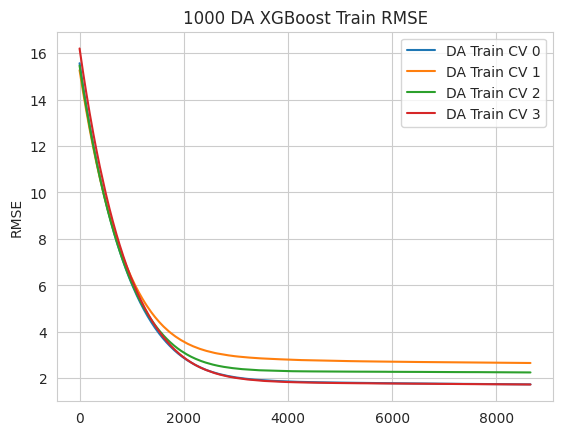

In [51]:
aug1000_scores = []
fig, ax = plt.subplots()

i = 0
for train_index, test_index in kfolds.split(X_aug1000):
    X_train_cv, X_test_cv = X_aug1000[train_index], X_aug1000[test_index]
    y_train_cv, y_test_cv = y_aug1000[train_index], y_aug1000[test_index]


    reg = XGBRegressor(
        n_estimators = 8654, 
        max_depth = 3, 
        subsample = 0.31, 
        colsample_bytree = 0.48, 
        colsample_bylevel = 0.1, 
        learning_rate = 0.001,
        verbose=False
    )
    reg.fit(X_train_cv, y_train_cv, eval_set=[(X_test_cv, y_test_cv)])
    y_pred = reg.predict(X_test)
    score_test = mean_squared_error(y_test, y_pred, squared = False)
    aug1000_scores.append(score_test)
    
    results = reg.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    ax.plot(x_axis, results['validation_0']['rmse'], label=('DA Train CV ' + str(i)))
    
    i = i+1

    
ax.legend()
plt.ylabel('RMSE')
plt.title('1000 DA XGBoost Train RMSE')
plt.show()


[0]	validation_0-rmse:4.09969
[1]	validation_0-rmse:4.09865
[2]	validation_0-rmse:4.09735
[3]	validation_0-rmse:4.09599
[4]	validation_0-rmse:4.09481
[5]	validation_0-rmse:4.09352
[6]	validation_0-rmse:4.09253
[7]	validation_0-rmse:4.09147
[8]	validation_0-rmse:4.09014
[9]	validation_0-rmse:4.08870
[10]	validation_0-rmse:4.08769
[11]	validation_0-rmse:4.08680
[12]	validation_0-rmse:4.08564
[13]	validation_0-rmse:4.08431
[14]	validation_0-rmse:4.08359
[15]	validation_0-rmse:4.08242
[16]	validation_0-rmse:4.08108
[17]	validation_0-rmse:4.08043
[18]	validation_0-rmse:4.07966
[19]	validation_0-rmse:4.07887
[20]	validation_0-rmse:4.07747
[21]	validation_0-rmse:4.07637
[22]	validation_0-rmse:4.07517
[23]	validation_0-rmse:4.07428
[24]	validation_0-rmse:4.07360
[25]	validation_0-rmse:4.07260
[26]	validation_0-rmse:4.07172
[27]	validation_0-rmse:4.06991
[28]	validation_0-rmse:4.06931
[29]	validation_0-rmse:4.06821
[30]	validation_0-rmse:4.06689
[31]	validation_0-rmse:4.06588
[32]	validation_0-

[260]	validation_0-rmse:3.84233
[261]	validation_0-rmse:3.84166
[262]	validation_0-rmse:3.84088
[263]	validation_0-rmse:3.84013
[264]	validation_0-rmse:3.83930
[265]	validation_0-rmse:3.83829
[266]	validation_0-rmse:3.83730
[267]	validation_0-rmse:3.83638
[268]	validation_0-rmse:3.83565
[269]	validation_0-rmse:3.83460
[270]	validation_0-rmse:3.83392
[271]	validation_0-rmse:3.83297
[272]	validation_0-rmse:3.83216
[273]	validation_0-rmse:3.83162
[274]	validation_0-rmse:3.83116
[275]	validation_0-rmse:3.83063
[276]	validation_0-rmse:3.82909
[277]	validation_0-rmse:3.82852
[278]	validation_0-rmse:3.82790
[279]	validation_0-rmse:3.82716
[280]	validation_0-rmse:3.82646
[281]	validation_0-rmse:3.82610
[282]	validation_0-rmse:3.82566
[283]	validation_0-rmse:3.82497
[284]	validation_0-rmse:3.82405
[285]	validation_0-rmse:3.82286
[286]	validation_0-rmse:3.82220
[287]	validation_0-rmse:3.82152
[288]	validation_0-rmse:3.82021
[289]	validation_0-rmse:3.81943
[290]	validation_0-rmse:3.81829
[291]	va

[517]	validation_0-rmse:3.66181
[518]	validation_0-rmse:3.66146
[519]	validation_0-rmse:3.66075
[520]	validation_0-rmse:3.66006
[521]	validation_0-rmse:3.65952
[522]	validation_0-rmse:3.65913
[523]	validation_0-rmse:3.65896
[524]	validation_0-rmse:3.65838
[525]	validation_0-rmse:3.65802
[526]	validation_0-rmse:3.65748
[527]	validation_0-rmse:3.65686
[528]	validation_0-rmse:3.65633
[529]	validation_0-rmse:3.65577
[530]	validation_0-rmse:3.65531
[531]	validation_0-rmse:3.65424
[532]	validation_0-rmse:3.65351
[533]	validation_0-rmse:3.65283
[534]	validation_0-rmse:3.65238
[535]	validation_0-rmse:3.65152
[536]	validation_0-rmse:3.65087
[537]	validation_0-rmse:3.65016
[538]	validation_0-rmse:3.64974
[539]	validation_0-rmse:3.64923
[540]	validation_0-rmse:3.64850
[541]	validation_0-rmse:3.64784
[542]	validation_0-rmse:3.64742
[543]	validation_0-rmse:3.64682
[544]	validation_0-rmse:3.64627
[545]	validation_0-rmse:3.64591
[546]	validation_0-rmse:3.64549
[547]	validation_0-rmse:3.64507
[548]	va

[774]	validation_0-rmse:3.53924
[775]	validation_0-rmse:3.53888
[776]	validation_0-rmse:3.53830
[777]	validation_0-rmse:3.53732
[778]	validation_0-rmse:3.53701
[779]	validation_0-rmse:3.53654
[780]	validation_0-rmse:3.53634
[781]	validation_0-rmse:3.53559
[782]	validation_0-rmse:3.53485
[783]	validation_0-rmse:3.53463
[784]	validation_0-rmse:3.53449
[785]	validation_0-rmse:3.53409
[786]	validation_0-rmse:3.53375
[787]	validation_0-rmse:3.53346
[788]	validation_0-rmse:3.53329
[789]	validation_0-rmse:3.53273
[790]	validation_0-rmse:3.53235
[791]	validation_0-rmse:3.53225
[792]	validation_0-rmse:3.53208
[793]	validation_0-rmse:3.53159
[794]	validation_0-rmse:3.53119
[795]	validation_0-rmse:3.53069
[796]	validation_0-rmse:3.53028
[797]	validation_0-rmse:3.53016
[798]	validation_0-rmse:3.52981
[799]	validation_0-rmse:3.52943
[800]	validation_0-rmse:3.52887
[801]	validation_0-rmse:3.52871
[802]	validation_0-rmse:3.52847
[803]	validation_0-rmse:3.52847
[804]	validation_0-rmse:3.52830
[805]	va

[1030]	validation_0-rmse:3.45118
[1031]	validation_0-rmse:3.45076
[1032]	validation_0-rmse:3.45056
[1033]	validation_0-rmse:3.45023
[1034]	validation_0-rmse:3.44997
[1035]	validation_0-rmse:3.44989
[1036]	validation_0-rmse:3.44955
[1037]	validation_0-rmse:3.44942
[1038]	validation_0-rmse:3.44919
[1039]	validation_0-rmse:3.44906
[1040]	validation_0-rmse:3.44896
[1041]	validation_0-rmse:3.44875
[1042]	validation_0-rmse:3.44840
[1043]	validation_0-rmse:3.44799
[1044]	validation_0-rmse:3.44773
[1045]	validation_0-rmse:3.44735
[1046]	validation_0-rmse:3.44708
[1047]	validation_0-rmse:3.44691
[1048]	validation_0-rmse:3.44668
[1049]	validation_0-rmse:3.44647
[1050]	validation_0-rmse:3.44617
[1051]	validation_0-rmse:3.44623
[1052]	validation_0-rmse:3.44563
[1053]	validation_0-rmse:3.44548
[1054]	validation_0-rmse:3.44517
[1055]	validation_0-rmse:3.44481
[1056]	validation_0-rmse:3.44463
[1057]	validation_0-rmse:3.44443
[1058]	validation_0-rmse:3.44418
[1059]	validation_0-rmse:3.44367
[1060]	val

[1279]	validation_0-rmse:3.38726
[1280]	validation_0-rmse:3.38716
[1281]	validation_0-rmse:3.38724
[1282]	validation_0-rmse:3.38712
[1283]	validation_0-rmse:3.38696
[1284]	validation_0-rmse:3.38695
[1285]	validation_0-rmse:3.38679
[1286]	validation_0-rmse:3.38666
[1287]	validation_0-rmse:3.38636
[1288]	validation_0-rmse:3.38627
[1289]	validation_0-rmse:3.38596
[1290]	validation_0-rmse:3.38547
[1291]	validation_0-rmse:3.38536
[1292]	validation_0-rmse:3.38524
[1293]	validation_0-rmse:3.38513
[1294]	validation_0-rmse:3.38511
[1295]	validation_0-rmse:3.38439
[1296]	validation_0-rmse:3.38417
[1297]	validation_0-rmse:3.38395
[1298]	validation_0-rmse:3.38377
[1299]	validation_0-rmse:3.38361
[1300]	validation_0-rmse:3.38341
[1301]	validation_0-rmse:3.38324
[1302]	validation_0-rmse:3.38294
[1303]	validation_0-rmse:3.38246
[1304]	validation_0-rmse:3.38224
[1305]	validation_0-rmse:3.38222
[1306]	validation_0-rmse:3.38206
[1307]	validation_0-rmse:3.38166
[1308]	validation_0-rmse:3.38132
[1309]	val

[1528]	validation_0-rmse:3.33781
[1529]	validation_0-rmse:3.33771
[1530]	validation_0-rmse:3.33764
[1531]	validation_0-rmse:3.33704
[1532]	validation_0-rmse:3.33704
[1533]	validation_0-rmse:3.33685
[1534]	validation_0-rmse:3.33647
[1535]	validation_0-rmse:3.33632
[1536]	validation_0-rmse:3.33614
[1537]	validation_0-rmse:3.33593
[1538]	validation_0-rmse:3.33595
[1539]	validation_0-rmse:3.33569
[1540]	validation_0-rmse:3.33543
[1541]	validation_0-rmse:3.33535
[1542]	validation_0-rmse:3.33533
[1543]	validation_0-rmse:3.33529
[1544]	validation_0-rmse:3.33536
[1545]	validation_0-rmse:3.33529
[1546]	validation_0-rmse:3.33487
[1547]	validation_0-rmse:3.33475
[1548]	validation_0-rmse:3.33442
[1549]	validation_0-rmse:3.33441
[1550]	validation_0-rmse:3.33437
[1551]	validation_0-rmse:3.33423
[1552]	validation_0-rmse:3.33397
[1553]	validation_0-rmse:3.33376
[1554]	validation_0-rmse:3.33332
[1555]	validation_0-rmse:3.33333
[1556]	validation_0-rmse:3.33308
[1557]	validation_0-rmse:3.33312
[1558]	val

[1777]	validation_0-rmse:3.29618
[1778]	validation_0-rmse:3.29609
[1779]	validation_0-rmse:3.29605
[1780]	validation_0-rmse:3.29588
[1781]	validation_0-rmse:3.29580
[1782]	validation_0-rmse:3.29565
[1783]	validation_0-rmse:3.29553
[1784]	validation_0-rmse:3.29545
[1785]	validation_0-rmse:3.29536
[1786]	validation_0-rmse:3.29537
[1787]	validation_0-rmse:3.29526
[1788]	validation_0-rmse:3.29524
[1789]	validation_0-rmse:3.29525
[1790]	validation_0-rmse:3.29513
[1791]	validation_0-rmse:3.29512
[1792]	validation_0-rmse:3.29512
[1793]	validation_0-rmse:3.29493
[1794]	validation_0-rmse:3.29474
[1795]	validation_0-rmse:3.29478
[1796]	validation_0-rmse:3.29465
[1797]	validation_0-rmse:3.29461
[1798]	validation_0-rmse:3.29448
[1799]	validation_0-rmse:3.29430
[1800]	validation_0-rmse:3.29428
[1801]	validation_0-rmse:3.29424
[1802]	validation_0-rmse:3.29414
[1803]	validation_0-rmse:3.29403
[1804]	validation_0-rmse:3.29402
[1805]	validation_0-rmse:3.29381
[1806]	validation_0-rmse:3.29387
[1807]	val

[2026]	validation_0-rmse:3.26533
[2027]	validation_0-rmse:3.26530
[2028]	validation_0-rmse:3.26520
[2029]	validation_0-rmse:3.26508
[2030]	validation_0-rmse:3.26503
[2031]	validation_0-rmse:3.26499
[2032]	validation_0-rmse:3.26474
[2033]	validation_0-rmse:3.26461
[2034]	validation_0-rmse:3.26458
[2035]	validation_0-rmse:3.26472
[2036]	validation_0-rmse:3.26469
[2037]	validation_0-rmse:3.26441
[2038]	validation_0-rmse:3.26423
[2039]	validation_0-rmse:3.26417
[2040]	validation_0-rmse:3.26406
[2041]	validation_0-rmse:3.26397
[2042]	validation_0-rmse:3.26397
[2043]	validation_0-rmse:3.26395
[2044]	validation_0-rmse:3.26385
[2045]	validation_0-rmse:3.26379
[2046]	validation_0-rmse:3.26348
[2047]	validation_0-rmse:3.26331
[2048]	validation_0-rmse:3.26328
[2049]	validation_0-rmse:3.26303
[2050]	validation_0-rmse:3.26304
[2051]	validation_0-rmse:3.26308
[2052]	validation_0-rmse:3.26310
[2053]	validation_0-rmse:3.26289
[2054]	validation_0-rmse:3.26298
[2055]	validation_0-rmse:3.26289
[2056]	val

[2275]	validation_0-rmse:3.24376
[2276]	validation_0-rmse:3.24367
[2277]	validation_0-rmse:3.24346
[2278]	validation_0-rmse:3.24343
[2279]	validation_0-rmse:3.24336
[2280]	validation_0-rmse:3.24319
[2281]	validation_0-rmse:3.24321
[2282]	validation_0-rmse:3.24285
[2283]	validation_0-rmse:3.24283
[2284]	validation_0-rmse:3.24295
[2285]	validation_0-rmse:3.24294
[2286]	validation_0-rmse:3.24279
[2287]	validation_0-rmse:3.24266
[2288]	validation_0-rmse:3.24260
[2289]	validation_0-rmse:3.24252
[2290]	validation_0-rmse:3.24228
[2291]	validation_0-rmse:3.24216
[2292]	validation_0-rmse:3.24214
[2293]	validation_0-rmse:3.24211
[2294]	validation_0-rmse:3.24204
[2295]	validation_0-rmse:3.24195
[2296]	validation_0-rmse:3.24182
[2297]	validation_0-rmse:3.24184
[2298]	validation_0-rmse:3.24179
[2299]	validation_0-rmse:3.24179
[2300]	validation_0-rmse:3.24169
[2301]	validation_0-rmse:3.24150
[2302]	validation_0-rmse:3.24151
[2303]	validation_0-rmse:3.24139
[2304]	validation_0-rmse:3.24154
[2305]	val

[2524]	validation_0-rmse:3.22327
[2525]	validation_0-rmse:3.22331
[2526]	validation_0-rmse:3.22303
[2527]	validation_0-rmse:3.22294
[2528]	validation_0-rmse:3.22290
[2529]	validation_0-rmse:3.22294
[2530]	validation_0-rmse:3.22279
[2531]	validation_0-rmse:3.22269
[2532]	validation_0-rmse:3.22253
[2533]	validation_0-rmse:3.22232
[2534]	validation_0-rmse:3.22234
[2535]	validation_0-rmse:3.22239
[2536]	validation_0-rmse:3.22238
[2537]	validation_0-rmse:3.22237
[2538]	validation_0-rmse:3.22235
[2539]	validation_0-rmse:3.22242
[2540]	validation_0-rmse:3.22238
[2541]	validation_0-rmse:3.22240
[2542]	validation_0-rmse:3.22231
[2543]	validation_0-rmse:3.22228
[2544]	validation_0-rmse:3.22226
[2545]	validation_0-rmse:3.22232
[2546]	validation_0-rmse:3.22239
[2547]	validation_0-rmse:3.22237
[2548]	validation_0-rmse:3.22231
[2549]	validation_0-rmse:3.22230
[2550]	validation_0-rmse:3.22224
[2551]	validation_0-rmse:3.22223
[2552]	validation_0-rmse:3.22219
[2553]	validation_0-rmse:3.22217
[2554]	val

[2773]	validation_0-rmse:3.20370
[2774]	validation_0-rmse:3.20368
[2775]	validation_0-rmse:3.20366
[2776]	validation_0-rmse:3.20359
[2777]	validation_0-rmse:3.20349
[2778]	validation_0-rmse:3.20346
[2779]	validation_0-rmse:3.20336
[2780]	validation_0-rmse:3.20330
[2781]	validation_0-rmse:3.20323
[2782]	validation_0-rmse:3.20315
[2783]	validation_0-rmse:3.20296
[2784]	validation_0-rmse:3.20264
[2785]	validation_0-rmse:3.20254
[2786]	validation_0-rmse:3.20246
[2787]	validation_0-rmse:3.20229
[2788]	validation_0-rmse:3.20225
[2789]	validation_0-rmse:3.20227
[2790]	validation_0-rmse:3.20227
[2791]	validation_0-rmse:3.20239
[2792]	validation_0-rmse:3.20242
[2793]	validation_0-rmse:3.20232
[2794]	validation_0-rmse:3.20228
[2795]	validation_0-rmse:3.20208
[2796]	validation_0-rmse:3.20182
[2797]	validation_0-rmse:3.20182
[2798]	validation_0-rmse:3.20191
[2799]	validation_0-rmse:3.20188
[2800]	validation_0-rmse:3.20159
[2801]	validation_0-rmse:3.20137
[2802]	validation_0-rmse:3.20133
[2803]	val

[3022]	validation_0-rmse:3.18680
[3023]	validation_0-rmse:3.18686
[3024]	validation_0-rmse:3.18692
[3025]	validation_0-rmse:3.18695
[3026]	validation_0-rmse:3.18697
[3027]	validation_0-rmse:3.18702
[3028]	validation_0-rmse:3.18712
[3029]	validation_0-rmse:3.18714
[3030]	validation_0-rmse:3.18714
[3031]	validation_0-rmse:3.18712
[3032]	validation_0-rmse:3.18708
[3033]	validation_0-rmse:3.18679
[3034]	validation_0-rmse:3.18653
[3035]	validation_0-rmse:3.18655
[3036]	validation_0-rmse:3.18651
[3037]	validation_0-rmse:3.18648
[3038]	validation_0-rmse:3.18650
[3039]	validation_0-rmse:3.18649
[3040]	validation_0-rmse:3.18616
[3041]	validation_0-rmse:3.18606
[3042]	validation_0-rmse:3.18602
[3043]	validation_0-rmse:3.18599
[3044]	validation_0-rmse:3.18598
[3045]	validation_0-rmse:3.18589
[3046]	validation_0-rmse:3.18586
[3047]	validation_0-rmse:3.18582
[3048]	validation_0-rmse:3.18578
[3049]	validation_0-rmse:3.18563
[3050]	validation_0-rmse:3.18552
[3051]	validation_0-rmse:3.18551
[3052]	val

[3271]	validation_0-rmse:3.17243
[3272]	validation_0-rmse:3.17232
[3273]	validation_0-rmse:3.17214
[3274]	validation_0-rmse:3.17219
[3275]	validation_0-rmse:3.17185
[3276]	validation_0-rmse:3.17181
[3277]	validation_0-rmse:3.17182
[3278]	validation_0-rmse:3.17175
[3279]	validation_0-rmse:3.17174
[3280]	validation_0-rmse:3.17167
[3281]	validation_0-rmse:3.17168
[3282]	validation_0-rmse:3.17168
[3283]	validation_0-rmse:3.17166
[3284]	validation_0-rmse:3.17169
[3285]	validation_0-rmse:3.17143
[3286]	validation_0-rmse:3.17144
[3287]	validation_0-rmse:3.17135
[3288]	validation_0-rmse:3.17126
[3289]	validation_0-rmse:3.17133
[3290]	validation_0-rmse:3.17093
[3291]	validation_0-rmse:3.17097
[3292]	validation_0-rmse:3.17100
[3293]	validation_0-rmse:3.17096
[3294]	validation_0-rmse:3.17090
[3295]	validation_0-rmse:3.17062
[3296]	validation_0-rmse:3.17061
[3297]	validation_0-rmse:3.17043
[3298]	validation_0-rmse:3.17034
[3299]	validation_0-rmse:3.17046
[3300]	validation_0-rmse:3.16994
[3301]	val

[3520]	validation_0-rmse:3.16158
[3521]	validation_0-rmse:3.16159
[3522]	validation_0-rmse:3.16141
[3523]	validation_0-rmse:3.16137
[3524]	validation_0-rmse:3.16139
[3525]	validation_0-rmse:3.16122
[3526]	validation_0-rmse:3.16120
[3527]	validation_0-rmse:3.16102
[3528]	validation_0-rmse:3.16090
[3529]	validation_0-rmse:3.16092
[3530]	validation_0-rmse:3.16083
[3531]	validation_0-rmse:3.16103
[3532]	validation_0-rmse:3.16105
[3533]	validation_0-rmse:3.16104
[3534]	validation_0-rmse:3.16089
[3535]	validation_0-rmse:3.16071
[3536]	validation_0-rmse:3.16055
[3537]	validation_0-rmse:3.16053
[3538]	validation_0-rmse:3.16054
[3539]	validation_0-rmse:3.16053
[3540]	validation_0-rmse:3.16048
[3541]	validation_0-rmse:3.16052
[3542]	validation_0-rmse:3.16026
[3543]	validation_0-rmse:3.16017
[3544]	validation_0-rmse:3.16019
[3545]	validation_0-rmse:3.16012
[3546]	validation_0-rmse:3.16009
[3547]	validation_0-rmse:3.15989
[3548]	validation_0-rmse:3.15983
[3549]	validation_0-rmse:3.15987
[3550]	val

[3769]	validation_0-rmse:3.14889
[3770]	validation_0-rmse:3.14887
[3771]	validation_0-rmse:3.14881
[3772]	validation_0-rmse:3.14879
[3773]	validation_0-rmse:3.14871
[3774]	validation_0-rmse:3.14855
[3775]	validation_0-rmse:3.14845
[3776]	validation_0-rmse:3.14848
[3777]	validation_0-rmse:3.14804
[3778]	validation_0-rmse:3.14805
[3779]	validation_0-rmse:3.14766
[3780]	validation_0-rmse:3.14766
[3781]	validation_0-rmse:3.14766
[3782]	validation_0-rmse:3.14759
[3783]	validation_0-rmse:3.14742
[3784]	validation_0-rmse:3.14740
[3785]	validation_0-rmse:3.14728
[3786]	validation_0-rmse:3.14729
[3787]	validation_0-rmse:3.14723
[3788]	validation_0-rmse:3.14725
[3789]	validation_0-rmse:3.14723
[3790]	validation_0-rmse:3.14720
[3791]	validation_0-rmse:3.14710
[3792]	validation_0-rmse:3.14707
[3793]	validation_0-rmse:3.14708
[3794]	validation_0-rmse:3.14708
[3795]	validation_0-rmse:3.14711
[3796]	validation_0-rmse:3.14712
[3797]	validation_0-rmse:3.14706
[3798]	validation_0-rmse:3.14716
[3799]	val

[4018]	validation_0-rmse:3.13968
[4019]	validation_0-rmse:3.13964
[4020]	validation_0-rmse:3.13965
[4021]	validation_0-rmse:3.13962
[4022]	validation_0-rmse:3.13965
[4023]	validation_0-rmse:3.13965
[4024]	validation_0-rmse:3.13955
[4025]	validation_0-rmse:3.13958
[4026]	validation_0-rmse:3.13948
[4027]	validation_0-rmse:3.13938
[4028]	validation_0-rmse:3.13925
[4029]	validation_0-rmse:3.13924
[4030]	validation_0-rmse:3.13897
[4031]	validation_0-rmse:3.13891
[4032]	validation_0-rmse:3.13886
[4033]	validation_0-rmse:3.13877
[4034]	validation_0-rmse:3.13878
[4035]	validation_0-rmse:3.13885
[4036]	validation_0-rmse:3.13880
[4037]	validation_0-rmse:3.13865
[4038]	validation_0-rmse:3.13864
[4039]	validation_0-rmse:3.13858
[4040]	validation_0-rmse:3.13858
[4041]	validation_0-rmse:3.13847
[4042]	validation_0-rmse:3.13847
[4043]	validation_0-rmse:3.13854
[4044]	validation_0-rmse:3.13854
[4045]	validation_0-rmse:3.13854
[4046]	validation_0-rmse:3.13855
[4047]	validation_0-rmse:3.13831
[4048]	val

[4267]	validation_0-rmse:3.13299
[4268]	validation_0-rmse:3.13306
[4269]	validation_0-rmse:3.13306
[4270]	validation_0-rmse:3.13310
[4271]	validation_0-rmse:3.13321
[4272]	validation_0-rmse:3.13320
[4273]	validation_0-rmse:3.13322
[4274]	validation_0-rmse:3.13323
[4275]	validation_0-rmse:3.13325
[4276]	validation_0-rmse:3.13325
[4277]	validation_0-rmse:3.13324
[4278]	validation_0-rmse:3.13325
[4279]	validation_0-rmse:3.13322
[4280]	validation_0-rmse:3.13318
[4281]	validation_0-rmse:3.13315
[4282]	validation_0-rmse:3.13326
[4283]	validation_0-rmse:3.13324
[4284]	validation_0-rmse:3.13307
[4285]	validation_0-rmse:3.13304
[4286]	validation_0-rmse:3.13297
[4287]	validation_0-rmse:3.13300
[4288]	validation_0-rmse:3.13268
[4289]	validation_0-rmse:3.13252
[4290]	validation_0-rmse:3.13257
[4291]	validation_0-rmse:3.13257
[4292]	validation_0-rmse:3.13259
[4293]	validation_0-rmse:3.13244
[4294]	validation_0-rmse:3.13246
[4295]	validation_0-rmse:3.13243
[4296]	validation_0-rmse:3.13243
[4297]	val

[4516]	validation_0-rmse:3.12432
[4517]	validation_0-rmse:3.12427
[4518]	validation_0-rmse:3.12407
[4519]	validation_0-rmse:3.12407
[4520]	validation_0-rmse:3.12408
[4521]	validation_0-rmse:3.12404
[4522]	validation_0-rmse:3.12408
[4523]	validation_0-rmse:3.12412
[4524]	validation_0-rmse:3.12405
[4525]	validation_0-rmse:3.12404
[4526]	validation_0-rmse:3.12407
[4527]	validation_0-rmse:3.12396
[4528]	validation_0-rmse:3.12396
[4529]	validation_0-rmse:3.12398
[4530]	validation_0-rmse:3.12386
[4531]	validation_0-rmse:3.12378
[4532]	validation_0-rmse:3.12380
[4533]	validation_0-rmse:3.12376
[4534]	validation_0-rmse:3.12376
[4535]	validation_0-rmse:3.12374
[4536]	validation_0-rmse:3.12368
[4537]	validation_0-rmse:3.12349
[4538]	validation_0-rmse:3.12354
[4539]	validation_0-rmse:3.12363
[4540]	validation_0-rmse:3.12360
[4541]	validation_0-rmse:3.12355
[4542]	validation_0-rmse:3.12355
[4543]	validation_0-rmse:3.12347
[4544]	validation_0-rmse:3.12345
[4545]	validation_0-rmse:3.12345
[4546]	val

[4765]	validation_0-rmse:3.11631
[4766]	validation_0-rmse:3.11613
[4767]	validation_0-rmse:3.11608
[4768]	validation_0-rmse:3.11608
[4769]	validation_0-rmse:3.11605
[4770]	validation_0-rmse:3.11601
[4771]	validation_0-rmse:3.11602
[4772]	validation_0-rmse:3.11611
[4773]	validation_0-rmse:3.11608
[4774]	validation_0-rmse:3.11587
[4775]	validation_0-rmse:3.11577
[4776]	validation_0-rmse:3.11579
[4777]	validation_0-rmse:3.11592
[4778]	validation_0-rmse:3.11584
[4779]	validation_0-rmse:3.11586
[4780]	validation_0-rmse:3.11585
[4781]	validation_0-rmse:3.11588
[4782]	validation_0-rmse:3.11598
[4783]	validation_0-rmse:3.11601
[4784]	validation_0-rmse:3.11589
[4785]	validation_0-rmse:3.11588
[4786]	validation_0-rmse:3.11582
[4787]	validation_0-rmse:3.11574
[4788]	validation_0-rmse:3.11575
[4789]	validation_0-rmse:3.11560
[4790]	validation_0-rmse:3.11565
[4791]	validation_0-rmse:3.11562
[4792]	validation_0-rmse:3.11559
[4793]	validation_0-rmse:3.11556
[4794]	validation_0-rmse:3.11559
[4795]	val

[5014]	validation_0-rmse:3.10974
[5015]	validation_0-rmse:3.10944
[5016]	validation_0-rmse:3.10943
[5017]	validation_0-rmse:3.10946
[5018]	validation_0-rmse:3.10952
[5019]	validation_0-rmse:3.10948
[5020]	validation_0-rmse:3.10945
[5021]	validation_0-rmse:3.10946
[5022]	validation_0-rmse:3.10940
[5023]	validation_0-rmse:3.10938
[5024]	validation_0-rmse:3.10939
[5025]	validation_0-rmse:3.10940
[5026]	validation_0-rmse:3.10908
[5027]	validation_0-rmse:3.10908
[5028]	validation_0-rmse:3.10906
[5029]	validation_0-rmse:3.10908
[5030]	validation_0-rmse:3.10904
[5031]	validation_0-rmse:3.10903
[5032]	validation_0-rmse:3.10903
[5033]	validation_0-rmse:3.10906
[5034]	validation_0-rmse:3.10893
[5035]	validation_0-rmse:3.10890
[5036]	validation_0-rmse:3.10897
[5037]	validation_0-rmse:3.10897
[5038]	validation_0-rmse:3.10891
[5039]	validation_0-rmse:3.10900
[5040]	validation_0-rmse:3.10894
[5041]	validation_0-rmse:3.10895
[5042]	validation_0-rmse:3.10890
[5043]	validation_0-rmse:3.10871
[5044]	val

[5263]	validation_0-rmse:3.10348
[5264]	validation_0-rmse:3.10333
[5265]	validation_0-rmse:3.10321
[5266]	validation_0-rmse:3.10322
[5267]	validation_0-rmse:3.10325
[5268]	validation_0-rmse:3.10295
[5269]	validation_0-rmse:3.10297
[5270]	validation_0-rmse:3.10297
[5271]	validation_0-rmse:3.10307
[5272]	validation_0-rmse:3.10309
[5273]	validation_0-rmse:3.10305
[5274]	validation_0-rmse:3.10306
[5275]	validation_0-rmse:3.10309
[5276]	validation_0-rmse:3.10311
[5277]	validation_0-rmse:3.10290
[5278]	validation_0-rmse:3.10291
[5279]	validation_0-rmse:3.10278
[5280]	validation_0-rmse:3.10278
[5281]	validation_0-rmse:3.10278
[5282]	validation_0-rmse:3.10253
[5283]	validation_0-rmse:3.10253
[5284]	validation_0-rmse:3.10251
[5285]	validation_0-rmse:3.10265
[5286]	validation_0-rmse:3.10261
[5287]	validation_0-rmse:3.10262
[5288]	validation_0-rmse:3.10247
[5289]	validation_0-rmse:3.10246
[5290]	validation_0-rmse:3.10257
[5291]	validation_0-rmse:3.10258
[5292]	validation_0-rmse:3.10259
[5293]	val

[5512]	validation_0-rmse:3.09409
[5513]	validation_0-rmse:3.09407
[5514]	validation_0-rmse:3.09408
[5515]	validation_0-rmse:3.09402
[5516]	validation_0-rmse:3.09407
[5517]	validation_0-rmse:3.09399
[5518]	validation_0-rmse:3.09398
[5519]	validation_0-rmse:3.09387
[5520]	validation_0-rmse:3.09386
[5521]	validation_0-rmse:3.09375
[5522]	validation_0-rmse:3.09367
[5523]	validation_0-rmse:3.09360
[5524]	validation_0-rmse:3.09361
[5525]	validation_0-rmse:3.09362
[5526]	validation_0-rmse:3.09375
[5527]	validation_0-rmse:3.09357
[5528]	validation_0-rmse:3.09351
[5529]	validation_0-rmse:3.09348
[5530]	validation_0-rmse:3.09348
[5531]	validation_0-rmse:3.09333
[5532]	validation_0-rmse:3.09342
[5533]	validation_0-rmse:3.09338
[5534]	validation_0-rmse:3.09339
[5535]	validation_0-rmse:3.09345
[5536]	validation_0-rmse:3.09336
[5537]	validation_0-rmse:3.09340
[5538]	validation_0-rmse:3.09337
[5539]	validation_0-rmse:3.09331
[5540]	validation_0-rmse:3.09328
[5541]	validation_0-rmse:3.09324
[5542]	val

[5761]	validation_0-rmse:3.08694
[5762]	validation_0-rmse:3.08697
[5763]	validation_0-rmse:3.08700
[5764]	validation_0-rmse:3.08702
[5765]	validation_0-rmse:3.08706
[5766]	validation_0-rmse:3.08707
[5767]	validation_0-rmse:3.08707
[5768]	validation_0-rmse:3.08715
[5769]	validation_0-rmse:3.08721
[5770]	validation_0-rmse:3.08717
[5771]	validation_0-rmse:3.08718
[5772]	validation_0-rmse:3.08716
[5773]	validation_0-rmse:3.08725
[5774]	validation_0-rmse:3.08725
[5775]	validation_0-rmse:3.08672
[5776]	validation_0-rmse:3.08671
[5777]	validation_0-rmse:3.08686
[5778]	validation_0-rmse:3.08632
[5779]	validation_0-rmse:3.08654
[5780]	validation_0-rmse:3.08645
[5781]	validation_0-rmse:3.08631
[5782]	validation_0-rmse:3.08631
[5783]	validation_0-rmse:3.08630
[5784]	validation_0-rmse:3.08595
[5785]	validation_0-rmse:3.08596
[5786]	validation_0-rmse:3.08592
[5787]	validation_0-rmse:3.08574
[5788]	validation_0-rmse:3.08573
[5789]	validation_0-rmse:3.08538
[5790]	validation_0-rmse:3.08556
[5791]	val

[6010]	validation_0-rmse:3.07744
[6011]	validation_0-rmse:3.07739
[6012]	validation_0-rmse:3.07739
[6013]	validation_0-rmse:3.07738
[6014]	validation_0-rmse:3.07732
[6015]	validation_0-rmse:3.07732
[6016]	validation_0-rmse:3.07736
[6017]	validation_0-rmse:3.07737
[6018]	validation_0-rmse:3.07740
[6019]	validation_0-rmse:3.07769
[6020]	validation_0-rmse:3.07771
[6021]	validation_0-rmse:3.07773
[6022]	validation_0-rmse:3.07774
[6023]	validation_0-rmse:3.07777
[6024]	validation_0-rmse:3.07774
[6025]	validation_0-rmse:3.07782
[6026]	validation_0-rmse:3.07781
[6027]	validation_0-rmse:3.07763
[6028]	validation_0-rmse:3.07762
[6029]	validation_0-rmse:3.07767
[6030]	validation_0-rmse:3.07766
[6031]	validation_0-rmse:3.07772
[6032]	validation_0-rmse:3.07774
[6033]	validation_0-rmse:3.07809
[6034]	validation_0-rmse:3.07831
[6035]	validation_0-rmse:3.07827
[6036]	validation_0-rmse:3.07830
[6037]	validation_0-rmse:3.07834
[6038]	validation_0-rmse:3.07839
[6039]	validation_0-rmse:3.07823
[6040]	val

[6259]	validation_0-rmse:3.07274
[6260]	validation_0-rmse:3.07255
[6261]	validation_0-rmse:3.07253
[6262]	validation_0-rmse:3.07254
[6263]	validation_0-rmse:3.07249
[6264]	validation_0-rmse:3.07222
[6265]	validation_0-rmse:3.07217
[6266]	validation_0-rmse:3.07213
[6267]	validation_0-rmse:3.07213
[6268]	validation_0-rmse:3.07202
[6269]	validation_0-rmse:3.07203
[6270]	validation_0-rmse:3.07209
[6271]	validation_0-rmse:3.07210
[6272]	validation_0-rmse:3.07208
[6273]	validation_0-rmse:3.07215
[6274]	validation_0-rmse:3.07209
[6275]	validation_0-rmse:3.07168
[6276]	validation_0-rmse:3.07179
[6277]	validation_0-rmse:3.07168
[6278]	validation_0-rmse:3.07153
[6279]	validation_0-rmse:3.07150
[6280]	validation_0-rmse:3.07144
[6281]	validation_0-rmse:3.07142
[6282]	validation_0-rmse:3.07147
[6283]	validation_0-rmse:3.07139
[6284]	validation_0-rmse:3.07139
[6285]	validation_0-rmse:3.07143
[6286]	validation_0-rmse:3.07141
[6287]	validation_0-rmse:3.07146
[6288]	validation_0-rmse:3.07149
[6289]	val

[6508]	validation_0-rmse:3.06816
[6509]	validation_0-rmse:3.06787
[6510]	validation_0-rmse:3.06793
[6511]	validation_0-rmse:3.06795
[6512]	validation_0-rmse:3.06775
[6513]	validation_0-rmse:3.06785
[6514]	validation_0-rmse:3.06794
[6515]	validation_0-rmse:3.06810
[6516]	validation_0-rmse:3.06781
[6517]	validation_0-rmse:3.06773
[6518]	validation_0-rmse:3.06768
[6519]	validation_0-rmse:3.06756
[6520]	validation_0-rmse:3.06755
[6521]	validation_0-rmse:3.06735
[6522]	validation_0-rmse:3.06731
[6523]	validation_0-rmse:3.06732
[6524]	validation_0-rmse:3.06730
[6525]	validation_0-rmse:3.06732
[6526]	validation_0-rmse:3.06732
[6527]	validation_0-rmse:3.06734
[6528]	validation_0-rmse:3.06732
[6529]	validation_0-rmse:3.06730
[6530]	validation_0-rmse:3.06743
[6531]	validation_0-rmse:3.06744
[6532]	validation_0-rmse:3.06753
[6533]	validation_0-rmse:3.06757
[6534]	validation_0-rmse:3.06745
[6535]	validation_0-rmse:3.06720
[6536]	validation_0-rmse:3.06725
[6537]	validation_0-rmse:3.06726
[6538]	val

[6757]	validation_0-rmse:3.06280
[6758]	validation_0-rmse:3.06279
[6759]	validation_0-rmse:3.06283
[6760]	validation_0-rmse:3.06288
[6761]	validation_0-rmse:3.06285
[6762]	validation_0-rmse:3.06287
[6763]	validation_0-rmse:3.06287
[6764]	validation_0-rmse:3.06287
[6765]	validation_0-rmse:3.06282
[6766]	validation_0-rmse:3.06292
[6767]	validation_0-rmse:3.06289
[6768]	validation_0-rmse:3.06279
[6769]	validation_0-rmse:3.06286
[6770]	validation_0-rmse:3.06294
[6771]	validation_0-rmse:3.06297
[6772]	validation_0-rmse:3.06298
[6773]	validation_0-rmse:3.06282
[6774]	validation_0-rmse:3.06288
[6775]	validation_0-rmse:3.06288
[6776]	validation_0-rmse:3.06288
[6777]	validation_0-rmse:3.06294
[6778]	validation_0-rmse:3.06299
[6779]	validation_0-rmse:3.06317
[6780]	validation_0-rmse:3.06316
[6781]	validation_0-rmse:3.06320
[6782]	validation_0-rmse:3.06319
[6783]	validation_0-rmse:3.06307
[6784]	validation_0-rmse:3.06310
[6785]	validation_0-rmse:3.06297
[6786]	validation_0-rmse:3.06289
[6787]	val

[7006]	validation_0-rmse:3.05826
[7007]	validation_0-rmse:3.05832
[7008]	validation_0-rmse:3.05832
[7009]	validation_0-rmse:3.05822
[7010]	validation_0-rmse:3.05821
[7011]	validation_0-rmse:3.05827
[7012]	validation_0-rmse:3.05820
[7013]	validation_0-rmse:3.05820
[7014]	validation_0-rmse:3.05803
[7015]	validation_0-rmse:3.05802
[7016]	validation_0-rmse:3.05802
[7017]	validation_0-rmse:3.05791
[7018]	validation_0-rmse:3.05791
[7019]	validation_0-rmse:3.05789
[7020]	validation_0-rmse:3.05800
[7021]	validation_0-rmse:3.05801
[7022]	validation_0-rmse:3.05800
[7023]	validation_0-rmse:3.05799
[7024]	validation_0-rmse:3.05800
[7025]	validation_0-rmse:3.05788
[7026]	validation_0-rmse:3.05785
[7027]	validation_0-rmse:3.05786
[7028]	validation_0-rmse:3.05778
[7029]	validation_0-rmse:3.05777
[7030]	validation_0-rmse:3.05756
[7031]	validation_0-rmse:3.05756
[7032]	validation_0-rmse:3.05756
[7033]	validation_0-rmse:3.05752
[7034]	validation_0-rmse:3.05725
[7035]	validation_0-rmse:3.05684
[7036]	val

[7255]	validation_0-rmse:3.05230
[7256]	validation_0-rmse:3.05223
[7257]	validation_0-rmse:3.05219
[7258]	validation_0-rmse:3.05223
[7259]	validation_0-rmse:3.05226
[7260]	validation_0-rmse:3.05228
[7261]	validation_0-rmse:3.05209
[7262]	validation_0-rmse:3.05215
[7263]	validation_0-rmse:3.05214
[7264]	validation_0-rmse:3.05210
[7265]	validation_0-rmse:3.05208
[7266]	validation_0-rmse:3.05223
[7267]	validation_0-rmse:3.05224
[7268]	validation_0-rmse:3.05221
[7269]	validation_0-rmse:3.05199
[7270]	validation_0-rmse:3.05198
[7271]	validation_0-rmse:3.05193
[7272]	validation_0-rmse:3.05202
[7273]	validation_0-rmse:3.05201
[7274]	validation_0-rmse:3.05202
[7275]	validation_0-rmse:3.05214
[7276]	validation_0-rmse:3.05218
[7277]	validation_0-rmse:3.05214
[7278]	validation_0-rmse:3.05212
[7279]	validation_0-rmse:3.05207
[7280]	validation_0-rmse:3.05206
[7281]	validation_0-rmse:3.05194
[7282]	validation_0-rmse:3.05194
[7283]	validation_0-rmse:3.05196
[7284]	validation_0-rmse:3.05213
[7285]	val

[7504]	validation_0-rmse:3.04886
[7505]	validation_0-rmse:3.04888
[7506]	validation_0-rmse:3.04887
[7507]	validation_0-rmse:3.04884
[7508]	validation_0-rmse:3.04886
[7509]	validation_0-rmse:3.04889
[7510]	validation_0-rmse:3.04888
[7511]	validation_0-rmse:3.04890
[7512]	validation_0-rmse:3.04891
[7513]	validation_0-rmse:3.04892
[7514]	validation_0-rmse:3.04897
[7515]	validation_0-rmse:3.04901
[7516]	validation_0-rmse:3.04901
[7517]	validation_0-rmse:3.04912
[7518]	validation_0-rmse:3.04910
[7519]	validation_0-rmse:3.04883
[7520]	validation_0-rmse:3.04885
[7521]	validation_0-rmse:3.04875
[7522]	validation_0-rmse:3.04877
[7523]	validation_0-rmse:3.04867
[7524]	validation_0-rmse:3.04858
[7525]	validation_0-rmse:3.04859
[7526]	validation_0-rmse:3.04859
[7527]	validation_0-rmse:3.04841
[7528]	validation_0-rmse:3.04826
[7529]	validation_0-rmse:3.04818
[7530]	validation_0-rmse:3.04822
[7531]	validation_0-rmse:3.04825
[7532]	validation_0-rmse:3.04823
[7533]	validation_0-rmse:3.04820
[7534]	val

[7753]	validation_0-rmse:3.04410
[7754]	validation_0-rmse:3.04409
[7755]	validation_0-rmse:3.04377
[7756]	validation_0-rmse:3.04367
[7757]	validation_0-rmse:3.04360
[7758]	validation_0-rmse:3.04362
[7759]	validation_0-rmse:3.04342
[7760]	validation_0-rmse:3.04315
[7761]	validation_0-rmse:3.04302
[7762]	validation_0-rmse:3.04288
[7763]	validation_0-rmse:3.04283
[7764]	validation_0-rmse:3.04267
[7765]	validation_0-rmse:3.04267
[7766]	validation_0-rmse:3.04262
[7767]	validation_0-rmse:3.04258
[7768]	validation_0-rmse:3.04260
[7769]	validation_0-rmse:3.04261
[7770]	validation_0-rmse:3.04248
[7771]	validation_0-rmse:3.04247
[7772]	validation_0-rmse:3.04246
[7773]	validation_0-rmse:3.04260
[7774]	validation_0-rmse:3.04260
[7775]	validation_0-rmse:3.04258
[7776]	validation_0-rmse:3.04252
[7777]	validation_0-rmse:3.04248
[7778]	validation_0-rmse:3.04244
[7779]	validation_0-rmse:3.04229
[7780]	validation_0-rmse:3.04218
[7781]	validation_0-rmse:3.04216
[7782]	validation_0-rmse:3.04209
[7783]	val

[8002]	validation_0-rmse:3.03794
[8003]	validation_0-rmse:3.03811
[8004]	validation_0-rmse:3.03809
[8005]	validation_0-rmse:3.03805
[8006]	validation_0-rmse:3.03807
[8007]	validation_0-rmse:3.03812
[8008]	validation_0-rmse:3.03812
[8009]	validation_0-rmse:3.03803
[8010]	validation_0-rmse:3.03807
[8011]	validation_0-rmse:3.03808
[8012]	validation_0-rmse:3.03812
[8013]	validation_0-rmse:3.03820
[8014]	validation_0-rmse:3.03829
[8015]	validation_0-rmse:3.03831
[8016]	validation_0-rmse:3.03833
[8017]	validation_0-rmse:3.03836
[8018]	validation_0-rmse:3.03843
[8019]	validation_0-rmse:3.03835
[8020]	validation_0-rmse:3.03853
[8021]	validation_0-rmse:3.03856
[8022]	validation_0-rmse:3.03852
[8023]	validation_0-rmse:3.03838
[8024]	validation_0-rmse:3.03842
[8025]	validation_0-rmse:3.03842
[8026]	validation_0-rmse:3.03827
[8027]	validation_0-rmse:3.03833
[8028]	validation_0-rmse:3.03824
[8029]	validation_0-rmse:3.03816
[8030]	validation_0-rmse:3.03823
[8031]	validation_0-rmse:3.03800
[8032]	val

[8251]	validation_0-rmse:3.03030
[8252]	validation_0-rmse:3.03031
[8253]	validation_0-rmse:3.03032
[8254]	validation_0-rmse:3.03031
[8255]	validation_0-rmse:3.03025
[8256]	validation_0-rmse:3.03035
[8257]	validation_0-rmse:3.03044
[8258]	validation_0-rmse:3.03005
[8259]	validation_0-rmse:3.03010
[8260]	validation_0-rmse:3.03017
[8261]	validation_0-rmse:3.03025
[8262]	validation_0-rmse:3.03019
[8263]	validation_0-rmse:3.03019
[8264]	validation_0-rmse:3.03008
[8265]	validation_0-rmse:3.03006
[8266]	validation_0-rmse:3.03002
[8267]	validation_0-rmse:3.03004
[8268]	validation_0-rmse:3.03003
[8269]	validation_0-rmse:3.03006
[8270]	validation_0-rmse:3.02990
[8271]	validation_0-rmse:3.02989
[8272]	validation_0-rmse:3.02978
[8273]	validation_0-rmse:3.02980
[8274]	validation_0-rmse:3.02971
[8275]	validation_0-rmse:3.02978
[8276]	validation_0-rmse:3.02977
[8277]	validation_0-rmse:3.02979
[8278]	validation_0-rmse:3.02983
[8279]	validation_0-rmse:3.02976
[8280]	validation_0-rmse:3.02979
[8281]	val

[8500]	validation_0-rmse:3.02661
[8501]	validation_0-rmse:3.02667
[8502]	validation_0-rmse:3.02668
[8503]	validation_0-rmse:3.02669
[8504]	validation_0-rmse:3.02682
[8505]	validation_0-rmse:3.02711
[8506]	validation_0-rmse:3.02698
[8507]	validation_0-rmse:3.02697
[8508]	validation_0-rmse:3.02683
[8509]	validation_0-rmse:3.02672
[8510]	validation_0-rmse:3.02672
[8511]	validation_0-rmse:3.02675
[8512]	validation_0-rmse:3.02681
[8513]	validation_0-rmse:3.02689
[8514]	validation_0-rmse:3.02693
[8515]	validation_0-rmse:3.02699
[8516]	validation_0-rmse:3.02693
[8517]	validation_0-rmse:3.02695
[8518]	validation_0-rmse:3.02695
[8519]	validation_0-rmse:3.02697
[8520]	validation_0-rmse:3.02700
[8521]	validation_0-rmse:3.02695
[8522]	validation_0-rmse:3.02684
[8523]	validation_0-rmse:3.02696
[8524]	validation_0-rmse:3.02690
[8525]	validation_0-rmse:3.02686
[8526]	validation_0-rmse:3.02693
[8527]	validation_0-rmse:3.02694
[8528]	validation_0-rmse:3.02701
[8529]	validation_0-rmse:3.02709
[8530]	val

[101]	validation_0-rmse:4.70996
[102]	validation_0-rmse:4.70920
[103]	validation_0-rmse:4.70826
[104]	validation_0-rmse:4.70681
[105]	validation_0-rmse:4.70530
[106]	validation_0-rmse:4.70424
[107]	validation_0-rmse:4.70342
[108]	validation_0-rmse:4.70247
[109]	validation_0-rmse:4.70139
[110]	validation_0-rmse:4.70053
[111]	validation_0-rmse:4.69934
[112]	validation_0-rmse:4.69842
[113]	validation_0-rmse:4.69749
[114]	validation_0-rmse:4.69608
[115]	validation_0-rmse:4.69494
[116]	validation_0-rmse:4.69393
[117]	validation_0-rmse:4.69251
[118]	validation_0-rmse:4.69057
[119]	validation_0-rmse:4.68969
[120]	validation_0-rmse:4.68855
[121]	validation_0-rmse:4.68775
[122]	validation_0-rmse:4.68662
[123]	validation_0-rmse:4.68561
[124]	validation_0-rmse:4.68460
[125]	validation_0-rmse:4.68343
[126]	validation_0-rmse:4.68267
[127]	validation_0-rmse:4.68177
[128]	validation_0-rmse:4.68063
[129]	validation_0-rmse:4.67963
[130]	validation_0-rmse:4.67910
[131]	validation_0-rmse:4.67821
[132]	va

[358]	validation_0-rmse:4.48146
[359]	validation_0-rmse:4.48093
[360]	validation_0-rmse:4.47991
[361]	validation_0-rmse:4.47920
[362]	validation_0-rmse:4.47863
[363]	validation_0-rmse:4.47824
[364]	validation_0-rmse:4.47744
[365]	validation_0-rmse:4.47678
[366]	validation_0-rmse:4.47563
[367]	validation_0-rmse:4.47436
[368]	validation_0-rmse:4.47333
[369]	validation_0-rmse:4.47287
[370]	validation_0-rmse:4.47220
[371]	validation_0-rmse:4.47161
[372]	validation_0-rmse:4.47124
[373]	validation_0-rmse:4.47081
[374]	validation_0-rmse:4.47011
[375]	validation_0-rmse:4.46937
[376]	validation_0-rmse:4.46860
[377]	validation_0-rmse:4.46809
[378]	validation_0-rmse:4.46744
[379]	validation_0-rmse:4.46712
[380]	validation_0-rmse:4.46626
[381]	validation_0-rmse:4.46565
[382]	validation_0-rmse:4.46443
[383]	validation_0-rmse:4.46394
[384]	validation_0-rmse:4.46296
[385]	validation_0-rmse:4.46241
[386]	validation_0-rmse:4.46121
[387]	validation_0-rmse:4.46077
[388]	validation_0-rmse:4.46024
[389]	va

[615]	validation_0-rmse:4.31641
[616]	validation_0-rmse:4.31603
[617]	validation_0-rmse:4.31572
[618]	validation_0-rmse:4.31449
[619]	validation_0-rmse:4.31410
[620]	validation_0-rmse:4.31375
[621]	validation_0-rmse:4.31336
[622]	validation_0-rmse:4.31264
[623]	validation_0-rmse:4.31160
[624]	validation_0-rmse:4.31055
[625]	validation_0-rmse:4.30978
[626]	validation_0-rmse:4.30893
[627]	validation_0-rmse:4.30834
[628]	validation_0-rmse:4.30765
[629]	validation_0-rmse:4.30751
[630]	validation_0-rmse:4.30719
[631]	validation_0-rmse:4.30705
[632]	validation_0-rmse:4.30633
[633]	validation_0-rmse:4.30601
[634]	validation_0-rmse:4.30543
[635]	validation_0-rmse:4.30515
[636]	validation_0-rmse:4.30469
[637]	validation_0-rmse:4.30429
[638]	validation_0-rmse:4.30320
[639]	validation_0-rmse:4.30270
[640]	validation_0-rmse:4.30197
[641]	validation_0-rmse:4.30165
[642]	validation_0-rmse:4.30120
[643]	validation_0-rmse:4.30059
[644]	validation_0-rmse:4.29999
[645]	validation_0-rmse:4.29934
[646]	va

[872]	validation_0-rmse:4.19488
[873]	validation_0-rmse:4.19463
[874]	validation_0-rmse:4.19395
[875]	validation_0-rmse:4.19322
[876]	validation_0-rmse:4.19293
[877]	validation_0-rmse:4.19247
[878]	validation_0-rmse:4.19209
[879]	validation_0-rmse:4.19142
[880]	validation_0-rmse:4.19115
[881]	validation_0-rmse:4.19091
[882]	validation_0-rmse:4.19000
[883]	validation_0-rmse:4.18980
[884]	validation_0-rmse:4.18958
[885]	validation_0-rmse:4.18931
[886]	validation_0-rmse:4.18872
[887]	validation_0-rmse:4.18817
[888]	validation_0-rmse:4.18796
[889]	validation_0-rmse:4.18773
[890]	validation_0-rmse:4.18747
[891]	validation_0-rmse:4.18709
[892]	validation_0-rmse:4.18630
[893]	validation_0-rmse:4.18593
[894]	validation_0-rmse:4.18528
[895]	validation_0-rmse:4.18503
[896]	validation_0-rmse:4.18472
[897]	validation_0-rmse:4.18435
[898]	validation_0-rmse:4.18404
[899]	validation_0-rmse:4.18340
[900]	validation_0-rmse:4.18324
[901]	validation_0-rmse:4.18296
[902]	validation_0-rmse:4.18255
[903]	va

[1125]	validation_0-rmse:4.10618
[1126]	validation_0-rmse:4.10562
[1127]	validation_0-rmse:4.10483
[1128]	validation_0-rmse:4.10445
[1129]	validation_0-rmse:4.10390
[1130]	validation_0-rmse:4.10366
[1131]	validation_0-rmse:4.10398
[1132]	validation_0-rmse:4.10374
[1133]	validation_0-rmse:4.10342
[1134]	validation_0-rmse:4.10313
[1135]	validation_0-rmse:4.10268
[1136]	validation_0-rmse:4.10248
[1137]	validation_0-rmse:4.10192
[1138]	validation_0-rmse:4.10169
[1139]	validation_0-rmse:4.10141
[1140]	validation_0-rmse:4.10083
[1141]	validation_0-rmse:4.10050
[1142]	validation_0-rmse:4.10032
[1143]	validation_0-rmse:4.10023
[1144]	validation_0-rmse:4.09998
[1145]	validation_0-rmse:4.09972
[1146]	validation_0-rmse:4.09954
[1147]	validation_0-rmse:4.09913
[1148]	validation_0-rmse:4.09886
[1149]	validation_0-rmse:4.09876
[1150]	validation_0-rmse:4.09819
[1151]	validation_0-rmse:4.09792
[1152]	validation_0-rmse:4.09737
[1153]	validation_0-rmse:4.09704
[1154]	validation_0-rmse:4.09659
[1155]	val

[1374]	validation_0-rmse:4.03463
[1375]	validation_0-rmse:4.03437
[1376]	validation_0-rmse:4.03433
[1377]	validation_0-rmse:4.03381
[1378]	validation_0-rmse:4.03376
[1379]	validation_0-rmse:4.03358
[1380]	validation_0-rmse:4.03340
[1381]	validation_0-rmse:4.03333
[1382]	validation_0-rmse:4.03273
[1383]	validation_0-rmse:4.03265
[1384]	validation_0-rmse:4.03263
[1385]	validation_0-rmse:4.03245
[1386]	validation_0-rmse:4.03229
[1387]	validation_0-rmse:4.03220
[1388]	validation_0-rmse:4.03204
[1389]	validation_0-rmse:4.03188
[1390]	validation_0-rmse:4.03178
[1391]	validation_0-rmse:4.03132
[1392]	validation_0-rmse:4.03118
[1393]	validation_0-rmse:4.03067
[1394]	validation_0-rmse:4.03047
[1395]	validation_0-rmse:4.03023
[1396]	validation_0-rmse:4.03010
[1397]	validation_0-rmse:4.03002
[1398]	validation_0-rmse:4.02953
[1399]	validation_0-rmse:4.02943
[1400]	validation_0-rmse:4.02913
[1401]	validation_0-rmse:4.02913
[1402]	validation_0-rmse:4.02909
[1403]	validation_0-rmse:4.02917
[1404]	val

[1623]	validation_0-rmse:3.98126
[1624]	validation_0-rmse:3.98123
[1625]	validation_0-rmse:3.98099
[1626]	validation_0-rmse:3.98086
[1627]	validation_0-rmse:3.98100
[1628]	validation_0-rmse:3.98087
[1629]	validation_0-rmse:3.98070
[1630]	validation_0-rmse:3.98048
[1631]	validation_0-rmse:3.98055
[1632]	validation_0-rmse:3.98042
[1633]	validation_0-rmse:3.97975
[1634]	validation_0-rmse:3.97934
[1635]	validation_0-rmse:3.97929
[1636]	validation_0-rmse:3.97910
[1637]	validation_0-rmse:3.97885
[1638]	validation_0-rmse:3.97845
[1639]	validation_0-rmse:3.97811
[1640]	validation_0-rmse:3.97758
[1641]	validation_0-rmse:3.97770
[1642]	validation_0-rmse:3.97766
[1643]	validation_0-rmse:3.97726
[1644]	validation_0-rmse:3.97677
[1645]	validation_0-rmse:3.97659
[1646]	validation_0-rmse:3.97645
[1647]	validation_0-rmse:3.97621
[1648]	validation_0-rmse:3.97604
[1649]	validation_0-rmse:3.97593
[1650]	validation_0-rmse:3.97590
[1651]	validation_0-rmse:3.97576
[1652]	validation_0-rmse:3.97556
[1653]	val

[1872]	validation_0-rmse:3.94103
[1873]	validation_0-rmse:3.94087
[1874]	validation_0-rmse:3.94074
[1875]	validation_0-rmse:3.94069
[1876]	validation_0-rmse:3.94061
[1877]	validation_0-rmse:3.94047
[1878]	validation_0-rmse:3.94011
[1879]	validation_0-rmse:3.94009
[1880]	validation_0-rmse:3.93990
[1881]	validation_0-rmse:3.93978
[1882]	validation_0-rmse:3.93956
[1883]	validation_0-rmse:3.93900
[1884]	validation_0-rmse:3.93906
[1885]	validation_0-rmse:3.93870
[1886]	validation_0-rmse:3.93868
[1887]	validation_0-rmse:3.93866
[1888]	validation_0-rmse:3.93864
[1889]	validation_0-rmse:3.93858
[1890]	validation_0-rmse:3.93848
[1891]	validation_0-rmse:3.93818
[1892]	validation_0-rmse:3.93802
[1893]	validation_0-rmse:3.93769
[1894]	validation_0-rmse:3.93769
[1895]	validation_0-rmse:3.93744
[1896]	validation_0-rmse:3.93724
[1897]	validation_0-rmse:3.93704
[1898]	validation_0-rmse:3.93683
[1899]	validation_0-rmse:3.93668
[1900]	validation_0-rmse:3.93638
[1901]	validation_0-rmse:3.93599
[1902]	val

[2121]	validation_0-rmse:3.90662
[2122]	validation_0-rmse:3.90654
[2123]	validation_0-rmse:3.90620
[2124]	validation_0-rmse:3.90615
[2125]	validation_0-rmse:3.90576
[2126]	validation_0-rmse:3.90573
[2127]	validation_0-rmse:3.90569
[2128]	validation_0-rmse:3.90567
[2129]	validation_0-rmse:3.90546
[2130]	validation_0-rmse:3.90553
[2131]	validation_0-rmse:3.90521
[2132]	validation_0-rmse:3.90521
[2133]	validation_0-rmse:3.90517
[2134]	validation_0-rmse:3.90520
[2135]	validation_0-rmse:3.90515
[2136]	validation_0-rmse:3.90495
[2137]	validation_0-rmse:3.90499
[2138]	validation_0-rmse:3.90461
[2139]	validation_0-rmse:3.90463
[2140]	validation_0-rmse:3.90450
[2141]	validation_0-rmse:3.90426
[2142]	validation_0-rmse:3.90414
[2143]	validation_0-rmse:3.90397
[2144]	validation_0-rmse:3.90399
[2145]	validation_0-rmse:3.90361
[2146]	validation_0-rmse:3.90356
[2147]	validation_0-rmse:3.90347
[2148]	validation_0-rmse:3.90337
[2149]	validation_0-rmse:3.90328
[2150]	validation_0-rmse:3.90325
[2151]	val

[2370]	validation_0-rmse:3.87675
[2371]	validation_0-rmse:3.87655
[2372]	validation_0-rmse:3.87652
[2373]	validation_0-rmse:3.87640
[2374]	validation_0-rmse:3.87639
[2375]	validation_0-rmse:3.87632
[2376]	validation_0-rmse:3.87607
[2377]	validation_0-rmse:3.87590
[2378]	validation_0-rmse:3.87602
[2379]	validation_0-rmse:3.87581
[2380]	validation_0-rmse:3.87583
[2381]	validation_0-rmse:3.87574
[2382]	validation_0-rmse:3.87569
[2383]	validation_0-rmse:3.87539
[2384]	validation_0-rmse:3.87531
[2385]	validation_0-rmse:3.87539
[2386]	validation_0-rmse:3.87541
[2387]	validation_0-rmse:3.87528
[2388]	validation_0-rmse:3.87518
[2389]	validation_0-rmse:3.87525
[2390]	validation_0-rmse:3.87527
[2391]	validation_0-rmse:3.87519
[2392]	validation_0-rmse:3.87499
[2393]	validation_0-rmse:3.87481
[2394]	validation_0-rmse:3.87475
[2395]	validation_0-rmse:3.87461
[2396]	validation_0-rmse:3.87439
[2397]	validation_0-rmse:3.87418
[2398]	validation_0-rmse:3.87411
[2399]	validation_0-rmse:3.87375
[2400]	val

[2619]	validation_0-rmse:3.85527
[2620]	validation_0-rmse:3.85505
[2621]	validation_0-rmse:3.85501
[2622]	validation_0-rmse:3.85497
[2623]	validation_0-rmse:3.85500
[2624]	validation_0-rmse:3.85464
[2625]	validation_0-rmse:3.85420
[2626]	validation_0-rmse:3.85421
[2627]	validation_0-rmse:3.85406
[2628]	validation_0-rmse:3.85399
[2629]	validation_0-rmse:3.85377
[2630]	validation_0-rmse:3.85380
[2631]	validation_0-rmse:3.85373
[2632]	validation_0-rmse:3.85369
[2633]	validation_0-rmse:3.85359
[2634]	validation_0-rmse:3.85348
[2635]	validation_0-rmse:3.85355
[2636]	validation_0-rmse:3.85357
[2637]	validation_0-rmse:3.85363
[2638]	validation_0-rmse:3.85380
[2639]	validation_0-rmse:3.85386
[2640]	validation_0-rmse:3.85385
[2641]	validation_0-rmse:3.85374
[2642]	validation_0-rmse:3.85346
[2643]	validation_0-rmse:3.85372
[2644]	validation_0-rmse:3.85371
[2645]	validation_0-rmse:3.85347
[2646]	validation_0-rmse:3.85325
[2647]	validation_0-rmse:3.85322
[2648]	validation_0-rmse:3.85316
[2649]	val

[2868]	validation_0-rmse:3.83376
[2869]	validation_0-rmse:3.83380
[2870]	validation_0-rmse:3.83379
[2871]	validation_0-rmse:3.83360
[2872]	validation_0-rmse:3.83318
[2873]	validation_0-rmse:3.83316
[2874]	validation_0-rmse:3.83319
[2875]	validation_0-rmse:3.83317
[2876]	validation_0-rmse:3.83298
[2877]	validation_0-rmse:3.83303
[2878]	validation_0-rmse:3.83298
[2879]	validation_0-rmse:3.83297
[2880]	validation_0-rmse:3.83290
[2881]	validation_0-rmse:3.83280
[2882]	validation_0-rmse:3.83265
[2883]	validation_0-rmse:3.83265
[2884]	validation_0-rmse:3.83272
[2885]	validation_0-rmse:3.83274
[2886]	validation_0-rmse:3.83274
[2887]	validation_0-rmse:3.83251
[2888]	validation_0-rmse:3.83236
[2889]	validation_0-rmse:3.83243
[2890]	validation_0-rmse:3.83243
[2891]	validation_0-rmse:3.83222
[2892]	validation_0-rmse:3.83226
[2893]	validation_0-rmse:3.83233
[2894]	validation_0-rmse:3.83227
[2895]	validation_0-rmse:3.83190
[2896]	validation_0-rmse:3.83163
[2897]	validation_0-rmse:3.83163
[2898]	val

[3117]	validation_0-rmse:3.81314
[3118]	validation_0-rmse:3.81291
[3119]	validation_0-rmse:3.81275
[3120]	validation_0-rmse:3.81276
[3121]	validation_0-rmse:3.81277
[3122]	validation_0-rmse:3.81270
[3123]	validation_0-rmse:3.81267
[3124]	validation_0-rmse:3.81244
[3125]	validation_0-rmse:3.81220
[3126]	validation_0-rmse:3.81223
[3127]	validation_0-rmse:3.81205
[3128]	validation_0-rmse:3.81193
[3129]	validation_0-rmse:3.81188
[3130]	validation_0-rmse:3.81198
[3131]	validation_0-rmse:3.81197
[3132]	validation_0-rmse:3.81199
[3133]	validation_0-rmse:3.81191
[3134]	validation_0-rmse:3.81175
[3135]	validation_0-rmse:3.81172
[3136]	validation_0-rmse:3.81157
[3137]	validation_0-rmse:3.81142
[3138]	validation_0-rmse:3.81132
[3139]	validation_0-rmse:3.81134
[3140]	validation_0-rmse:3.81137
[3141]	validation_0-rmse:3.81133
[3142]	validation_0-rmse:3.81129
[3143]	validation_0-rmse:3.81124
[3144]	validation_0-rmse:3.81111
[3145]	validation_0-rmse:3.81104
[3146]	validation_0-rmse:3.81092
[3147]	val

[3366]	validation_0-rmse:3.79871
[3367]	validation_0-rmse:3.79853
[3368]	validation_0-rmse:3.79857
[3369]	validation_0-rmse:3.79863
[3370]	validation_0-rmse:3.79860
[3371]	validation_0-rmse:3.79841
[3372]	validation_0-rmse:3.79824
[3373]	validation_0-rmse:3.79827
[3374]	validation_0-rmse:3.79837
[3375]	validation_0-rmse:3.79830
[3376]	validation_0-rmse:3.79824
[3377]	validation_0-rmse:3.79803
[3378]	validation_0-rmse:3.79801
[3379]	validation_0-rmse:3.79805
[3380]	validation_0-rmse:3.79815
[3381]	validation_0-rmse:3.79805
[3382]	validation_0-rmse:3.79795
[3383]	validation_0-rmse:3.79793
[3384]	validation_0-rmse:3.79800
[3385]	validation_0-rmse:3.79780
[3386]	validation_0-rmse:3.79783
[3387]	validation_0-rmse:3.79786
[3388]	validation_0-rmse:3.79786
[3389]	validation_0-rmse:3.79789
[3390]	validation_0-rmse:3.79769
[3391]	validation_0-rmse:3.79761
[3392]	validation_0-rmse:3.79766
[3393]	validation_0-rmse:3.79766
[3394]	validation_0-rmse:3.79752
[3395]	validation_0-rmse:3.79756
[3396]	val

[3615]	validation_0-rmse:3.78620
[3616]	validation_0-rmse:3.78595
[3617]	validation_0-rmse:3.78588
[3618]	validation_0-rmse:3.78588
[3619]	validation_0-rmse:3.78585
[3620]	validation_0-rmse:3.78582
[3621]	validation_0-rmse:3.78589
[3622]	validation_0-rmse:3.78587
[3623]	validation_0-rmse:3.78590
[3624]	validation_0-rmse:3.78592
[3625]	validation_0-rmse:3.78597
[3626]	validation_0-rmse:3.78607
[3627]	validation_0-rmse:3.78606
[3628]	validation_0-rmse:3.78606
[3629]	validation_0-rmse:3.78603
[3630]	validation_0-rmse:3.78612
[3631]	validation_0-rmse:3.78607
[3632]	validation_0-rmse:3.78601
[3633]	validation_0-rmse:3.78587
[3634]	validation_0-rmse:3.78579
[3635]	validation_0-rmse:3.78561
[3636]	validation_0-rmse:3.78561
[3637]	validation_0-rmse:3.78533
[3638]	validation_0-rmse:3.78528
[3639]	validation_0-rmse:3.78515
[3640]	validation_0-rmse:3.78512
[3641]	validation_0-rmse:3.78510
[3642]	validation_0-rmse:3.78489
[3643]	validation_0-rmse:3.78479
[3644]	validation_0-rmse:3.78473
[3645]	val

[3864]	validation_0-rmse:3.77541
[3865]	validation_0-rmse:3.77536
[3866]	validation_0-rmse:3.77532
[3867]	validation_0-rmse:3.77528
[3868]	validation_0-rmse:3.77519
[3869]	validation_0-rmse:3.77515
[3870]	validation_0-rmse:3.77503
[3871]	validation_0-rmse:3.77509
[3872]	validation_0-rmse:3.77500
[3873]	validation_0-rmse:3.77499
[3874]	validation_0-rmse:3.77492
[3875]	validation_0-rmse:3.77497
[3876]	validation_0-rmse:3.77521
[3877]	validation_0-rmse:3.77515
[3878]	validation_0-rmse:3.77509
[3879]	validation_0-rmse:3.77523
[3880]	validation_0-rmse:3.77518
[3881]	validation_0-rmse:3.77508
[3882]	validation_0-rmse:3.77498
[3883]	validation_0-rmse:3.77505
[3884]	validation_0-rmse:3.77496
[3885]	validation_0-rmse:3.77493
[3886]	validation_0-rmse:3.77492
[3887]	validation_0-rmse:3.77493
[3888]	validation_0-rmse:3.77487
[3889]	validation_0-rmse:3.77498
[3890]	validation_0-rmse:3.77470
[3891]	validation_0-rmse:3.77427
[3892]	validation_0-rmse:3.77420
[3893]	validation_0-rmse:3.77423
[3894]	val

[4113]	validation_0-rmse:3.76736
[4114]	validation_0-rmse:3.76738
[4115]	validation_0-rmse:3.76733
[4116]	validation_0-rmse:3.76739
[4117]	validation_0-rmse:3.76729
[4118]	validation_0-rmse:3.76717
[4119]	validation_0-rmse:3.76722
[4120]	validation_0-rmse:3.76737
[4121]	validation_0-rmse:3.76731
[4122]	validation_0-rmse:3.76726
[4123]	validation_0-rmse:3.76723
[4124]	validation_0-rmse:3.76709
[4125]	validation_0-rmse:3.76707
[4126]	validation_0-rmse:3.76705
[4127]	validation_0-rmse:3.76685
[4128]	validation_0-rmse:3.76692
[4129]	validation_0-rmse:3.76699
[4130]	validation_0-rmse:3.76699
[4131]	validation_0-rmse:3.76703
[4132]	validation_0-rmse:3.76700
[4133]	validation_0-rmse:3.76705
[4134]	validation_0-rmse:3.76702
[4135]	validation_0-rmse:3.76659
[4136]	validation_0-rmse:3.76664
[4137]	validation_0-rmse:3.76644
[4138]	validation_0-rmse:3.76592
[4139]	validation_0-rmse:3.76578
[4140]	validation_0-rmse:3.76555
[4141]	validation_0-rmse:3.76559
[4142]	validation_0-rmse:3.76561
[4143]	val

[4362]	validation_0-rmse:3.75550
[4363]	validation_0-rmse:3.75551
[4364]	validation_0-rmse:3.75545
[4365]	validation_0-rmse:3.75537
[4366]	validation_0-rmse:3.75522
[4367]	validation_0-rmse:3.75531
[4368]	validation_0-rmse:3.75527
[4369]	validation_0-rmse:3.75531
[4370]	validation_0-rmse:3.75522
[4371]	validation_0-rmse:3.75518
[4372]	validation_0-rmse:3.75482
[4373]	validation_0-rmse:3.75481
[4374]	validation_0-rmse:3.75445
[4375]	validation_0-rmse:3.75442
[4376]	validation_0-rmse:3.75450
[4377]	validation_0-rmse:3.75439
[4378]	validation_0-rmse:3.75400
[4379]	validation_0-rmse:3.75392
[4380]	validation_0-rmse:3.75405
[4381]	validation_0-rmse:3.75404
[4382]	validation_0-rmse:3.75409
[4383]	validation_0-rmse:3.75412
[4384]	validation_0-rmse:3.75428
[4385]	validation_0-rmse:3.75421
[4386]	validation_0-rmse:3.75383
[4387]	validation_0-rmse:3.75374
[4388]	validation_0-rmse:3.75364
[4389]	validation_0-rmse:3.75359
[4390]	validation_0-rmse:3.75346
[4391]	validation_0-rmse:3.75341
[4392]	val

[4611]	validation_0-rmse:3.74557
[4612]	validation_0-rmse:3.74550
[4613]	validation_0-rmse:3.74551
[4614]	validation_0-rmse:3.74560
[4615]	validation_0-rmse:3.74557
[4616]	validation_0-rmse:3.74557
[4617]	validation_0-rmse:3.74560
[4618]	validation_0-rmse:3.74543
[4619]	validation_0-rmse:3.74543
[4620]	validation_0-rmse:3.74526
[4621]	validation_0-rmse:3.74520
[4622]	validation_0-rmse:3.74500
[4623]	validation_0-rmse:3.74496
[4624]	validation_0-rmse:3.74496
[4625]	validation_0-rmse:3.74449
[4626]	validation_0-rmse:3.74449
[4627]	validation_0-rmse:3.74439
[4628]	validation_0-rmse:3.74444
[4629]	validation_0-rmse:3.74439
[4630]	validation_0-rmse:3.74429
[4631]	validation_0-rmse:3.74413
[4632]	validation_0-rmse:3.74414
[4633]	validation_0-rmse:3.74413
[4634]	validation_0-rmse:3.74413
[4635]	validation_0-rmse:3.74417
[4636]	validation_0-rmse:3.74427
[4637]	validation_0-rmse:3.74427
[4638]	validation_0-rmse:3.74427
[4639]	validation_0-rmse:3.74429
[4640]	validation_0-rmse:3.74434
[4641]	val

[4860]	validation_0-rmse:3.73517
[4861]	validation_0-rmse:3.73511
[4862]	validation_0-rmse:3.73506
[4863]	validation_0-rmse:3.73499
[4864]	validation_0-rmse:3.73496
[4865]	validation_0-rmse:3.73499
[4866]	validation_0-rmse:3.73494
[4867]	validation_0-rmse:3.73488
[4868]	validation_0-rmse:3.73482
[4869]	validation_0-rmse:3.73473
[4870]	validation_0-rmse:3.73477
[4871]	validation_0-rmse:3.73470
[4872]	validation_0-rmse:3.73461
[4873]	validation_0-rmse:3.73458
[4874]	validation_0-rmse:3.73462
[4875]	validation_0-rmse:3.73464
[4876]	validation_0-rmse:3.73459
[4877]	validation_0-rmse:3.73451
[4878]	validation_0-rmse:3.73449
[4879]	validation_0-rmse:3.73450
[4880]	validation_0-rmse:3.73441
[4881]	validation_0-rmse:3.73433
[4882]	validation_0-rmse:3.73425
[4883]	validation_0-rmse:3.73403
[4884]	validation_0-rmse:3.73401
[4885]	validation_0-rmse:3.73405
[4886]	validation_0-rmse:3.73397
[4887]	validation_0-rmse:3.73399
[4888]	validation_0-rmse:3.73401
[4889]	validation_0-rmse:3.73385
[4890]	val

[5109]	validation_0-rmse:3.72695
[5110]	validation_0-rmse:3.72692
[5111]	validation_0-rmse:3.72685
[5112]	validation_0-rmse:3.72679
[5113]	validation_0-rmse:3.72682
[5114]	validation_0-rmse:3.72677
[5115]	validation_0-rmse:3.72666
[5116]	validation_0-rmse:3.72668
[5117]	validation_0-rmse:3.72665
[5118]	validation_0-rmse:3.72664
[5119]	validation_0-rmse:3.72662
[5120]	validation_0-rmse:3.72668
[5121]	validation_0-rmse:3.72651
[5122]	validation_0-rmse:3.72643
[5123]	validation_0-rmse:3.72630
[5124]	validation_0-rmse:3.72622
[5125]	validation_0-rmse:3.72618
[5126]	validation_0-rmse:3.72626
[5127]	validation_0-rmse:3.72644
[5128]	validation_0-rmse:3.72639
[5129]	validation_0-rmse:3.72639
[5130]	validation_0-rmse:3.72641
[5131]	validation_0-rmse:3.72641
[5132]	validation_0-rmse:3.72640
[5133]	validation_0-rmse:3.72625
[5134]	validation_0-rmse:3.72624
[5135]	validation_0-rmse:3.72642
[5136]	validation_0-rmse:3.72597
[5137]	validation_0-rmse:3.72590
[5138]	validation_0-rmse:3.72596
[5139]	val

[5358]	validation_0-rmse:3.72113
[5359]	validation_0-rmse:3.72112
[5360]	validation_0-rmse:3.72082
[5361]	validation_0-rmse:3.72089
[5362]	validation_0-rmse:3.72089
[5363]	validation_0-rmse:3.72099
[5364]	validation_0-rmse:3.72089
[5365]	validation_0-rmse:3.72087
[5366]	validation_0-rmse:3.72083
[5367]	validation_0-rmse:3.72101
[5368]	validation_0-rmse:3.72095
[5369]	validation_0-rmse:3.72091
[5370]	validation_0-rmse:3.72084
[5371]	validation_0-rmse:3.72082
[5372]	validation_0-rmse:3.72084
[5373]	validation_0-rmse:3.72088
[5374]	validation_0-rmse:3.72081
[5375]	validation_0-rmse:3.72081
[5376]	validation_0-rmse:3.72078
[5377]	validation_0-rmse:3.72092
[5378]	validation_0-rmse:3.72085
[5379]	validation_0-rmse:3.72097
[5380]	validation_0-rmse:3.72091
[5381]	validation_0-rmse:3.72083
[5382]	validation_0-rmse:3.72083
[5383]	validation_0-rmse:3.72087
[5384]	validation_0-rmse:3.72083
[5385]	validation_0-rmse:3.72087
[5386]	validation_0-rmse:3.72070
[5387]	validation_0-rmse:3.72062
[5388]	val

[5607]	validation_0-rmse:3.71502
[5608]	validation_0-rmse:3.71502
[5609]	validation_0-rmse:3.71509
[5610]	validation_0-rmse:3.71511
[5611]	validation_0-rmse:3.71510
[5612]	validation_0-rmse:3.71488
[5613]	validation_0-rmse:3.71493
[5614]	validation_0-rmse:3.71477
[5615]	validation_0-rmse:3.71476
[5616]	validation_0-rmse:3.71472
[5617]	validation_0-rmse:3.71469
[5618]	validation_0-rmse:3.71462
[5619]	validation_0-rmse:3.71463
[5620]	validation_0-rmse:3.71450
[5621]	validation_0-rmse:3.71439
[5622]	validation_0-rmse:3.71445
[5623]	validation_0-rmse:3.71428
[5624]	validation_0-rmse:3.71415
[5625]	validation_0-rmse:3.71422
[5626]	validation_0-rmse:3.71418
[5627]	validation_0-rmse:3.71418
[5628]	validation_0-rmse:3.71418
[5629]	validation_0-rmse:3.71418
[5630]	validation_0-rmse:3.71417
[5631]	validation_0-rmse:3.71413
[5632]	validation_0-rmse:3.71393
[5633]	validation_0-rmse:3.71392
[5634]	validation_0-rmse:3.71397
[5635]	validation_0-rmse:3.71401
[5636]	validation_0-rmse:3.71409
[5637]	val

[5856]	validation_0-rmse:3.70892
[5857]	validation_0-rmse:3.70886
[5858]	validation_0-rmse:3.70883
[5859]	validation_0-rmse:3.70879
[5860]	validation_0-rmse:3.70879
[5861]	validation_0-rmse:3.70882
[5862]	validation_0-rmse:3.70844
[5863]	validation_0-rmse:3.70847
[5864]	validation_0-rmse:3.70864
[5865]	validation_0-rmse:3.70866
[5866]	validation_0-rmse:3.70862
[5867]	validation_0-rmse:3.70870
[5868]	validation_0-rmse:3.70868
[5869]	validation_0-rmse:3.70861
[5870]	validation_0-rmse:3.70864
[5871]	validation_0-rmse:3.70865
[5872]	validation_0-rmse:3.70869
[5873]	validation_0-rmse:3.70875
[5874]	validation_0-rmse:3.70882
[5875]	validation_0-rmse:3.70889
[5876]	validation_0-rmse:3.70888
[5877]	validation_0-rmse:3.70892
[5878]	validation_0-rmse:3.70866
[5879]	validation_0-rmse:3.70863
[5880]	validation_0-rmse:3.70858
[5881]	validation_0-rmse:3.70839
[5882]	validation_0-rmse:3.70841
[5883]	validation_0-rmse:3.70818
[5884]	validation_0-rmse:3.70827
[5885]	validation_0-rmse:3.70826
[5886]	val

[6105]	validation_0-rmse:3.70356
[6106]	validation_0-rmse:3.70349
[6107]	validation_0-rmse:3.70349
[6108]	validation_0-rmse:3.70343
[6109]	validation_0-rmse:3.70310
[6110]	validation_0-rmse:3.70313
[6111]	validation_0-rmse:3.70313
[6112]	validation_0-rmse:3.70325
[6113]	validation_0-rmse:3.70332
[6114]	validation_0-rmse:3.70315
[6115]	validation_0-rmse:3.70310
[6116]	validation_0-rmse:3.70313
[6117]	validation_0-rmse:3.70319
[6118]	validation_0-rmse:3.70312
[6119]	validation_0-rmse:3.70306
[6120]	validation_0-rmse:3.70308
[6121]	validation_0-rmse:3.70307
[6122]	validation_0-rmse:3.70292
[6123]	validation_0-rmse:3.70289
[6124]	validation_0-rmse:3.70290
[6125]	validation_0-rmse:3.70259
[6126]	validation_0-rmse:3.70254
[6127]	validation_0-rmse:3.70256
[6128]	validation_0-rmse:3.70256
[6129]	validation_0-rmse:3.70250
[6130]	validation_0-rmse:3.70237
[6131]	validation_0-rmse:3.70230
[6132]	validation_0-rmse:3.70236
[6133]	validation_0-rmse:3.70239
[6134]	validation_0-rmse:3.70233
[6135]	val

[6354]	validation_0-rmse:3.69881
[6355]	validation_0-rmse:3.69874
[6356]	validation_0-rmse:3.69880
[6357]	validation_0-rmse:3.69878
[6358]	validation_0-rmse:3.69872
[6359]	validation_0-rmse:3.69869
[6360]	validation_0-rmse:3.69882
[6361]	validation_0-rmse:3.69880
[6362]	validation_0-rmse:3.69881
[6363]	validation_0-rmse:3.69869
[6364]	validation_0-rmse:3.69861
[6365]	validation_0-rmse:3.69878
[6366]	validation_0-rmse:3.69870
[6367]	validation_0-rmse:3.69869
[6368]	validation_0-rmse:3.69864
[6369]	validation_0-rmse:3.69868
[6370]	validation_0-rmse:3.69868
[6371]	validation_0-rmse:3.69867
[6372]	validation_0-rmse:3.69876
[6373]	validation_0-rmse:3.69878
[6374]	validation_0-rmse:3.69879
[6375]	validation_0-rmse:3.69878
[6376]	validation_0-rmse:3.69878
[6377]	validation_0-rmse:3.69880
[6378]	validation_0-rmse:3.69881
[6379]	validation_0-rmse:3.69882
[6380]	validation_0-rmse:3.69880
[6381]	validation_0-rmse:3.69883
[6382]	validation_0-rmse:3.69880
[6383]	validation_0-rmse:3.69877
[6384]	val

[6603]	validation_0-rmse:3.69518
[6604]	validation_0-rmse:3.69521
[6605]	validation_0-rmse:3.69515
[6606]	validation_0-rmse:3.69496
[6607]	validation_0-rmse:3.69501
[6608]	validation_0-rmse:3.69493
[6609]	validation_0-rmse:3.69498
[6610]	validation_0-rmse:3.69506
[6611]	validation_0-rmse:3.69508
[6612]	validation_0-rmse:3.69513
[6613]	validation_0-rmse:3.69517
[6614]	validation_0-rmse:3.69516
[6615]	validation_0-rmse:3.69523
[6616]	validation_0-rmse:3.69528
[6617]	validation_0-rmse:3.69522
[6618]	validation_0-rmse:3.69526
[6619]	validation_0-rmse:3.69543
[6620]	validation_0-rmse:3.69543
[6621]	validation_0-rmse:3.69529
[6622]	validation_0-rmse:3.69537
[6623]	validation_0-rmse:3.69540
[6624]	validation_0-rmse:3.69525
[6625]	validation_0-rmse:3.69522
[6626]	validation_0-rmse:3.69508
[6627]	validation_0-rmse:3.69512
[6628]	validation_0-rmse:3.69513
[6629]	validation_0-rmse:3.69529
[6630]	validation_0-rmse:3.69537
[6631]	validation_0-rmse:3.69539
[6632]	validation_0-rmse:3.69538
[6633]	val

[6852]	validation_0-rmse:3.69083
[6853]	validation_0-rmse:3.69086
[6854]	validation_0-rmse:3.69091
[6855]	validation_0-rmse:3.69096
[6856]	validation_0-rmse:3.69095
[6857]	validation_0-rmse:3.69098
[6858]	validation_0-rmse:3.69101
[6859]	validation_0-rmse:3.69098
[6860]	validation_0-rmse:3.69091
[6861]	validation_0-rmse:3.69089
[6862]	validation_0-rmse:3.69088
[6863]	validation_0-rmse:3.69089
[6864]	validation_0-rmse:3.69088
[6865]	validation_0-rmse:3.69085
[6866]	validation_0-rmse:3.69073
[6867]	validation_0-rmse:3.69081
[6868]	validation_0-rmse:3.69083
[6869]	validation_0-rmse:3.69077
[6870]	validation_0-rmse:3.69065
[6871]	validation_0-rmse:3.69064
[6872]	validation_0-rmse:3.69064
[6873]	validation_0-rmse:3.69066
[6874]	validation_0-rmse:3.69068
[6875]	validation_0-rmse:3.69064
[6876]	validation_0-rmse:3.69065
[6877]	validation_0-rmse:3.69060
[6878]	validation_0-rmse:3.69058
[6879]	validation_0-rmse:3.69051
[6880]	validation_0-rmse:3.69044
[6881]	validation_0-rmse:3.69049
[6882]	val

[7101]	validation_0-rmse:3.68678
[7102]	validation_0-rmse:3.68678
[7103]	validation_0-rmse:3.68678
[7104]	validation_0-rmse:3.68687
[7105]	validation_0-rmse:3.68700
[7106]	validation_0-rmse:3.68698
[7107]	validation_0-rmse:3.68696
[7108]	validation_0-rmse:3.68689
[7109]	validation_0-rmse:3.68683
[7110]	validation_0-rmse:3.68686
[7111]	validation_0-rmse:3.68692
[7112]	validation_0-rmse:3.68690
[7113]	validation_0-rmse:3.68701
[7114]	validation_0-rmse:3.68683
[7115]	validation_0-rmse:3.68685
[7116]	validation_0-rmse:3.68682
[7117]	validation_0-rmse:3.68685
[7118]	validation_0-rmse:3.68682
[7119]	validation_0-rmse:3.68677
[7120]	validation_0-rmse:3.68680
[7121]	validation_0-rmse:3.68673
[7122]	validation_0-rmse:3.68674
[7123]	validation_0-rmse:3.68684
[7124]	validation_0-rmse:3.68677
[7125]	validation_0-rmse:3.68679
[7126]	validation_0-rmse:3.68648
[7127]	validation_0-rmse:3.68670
[7128]	validation_0-rmse:3.68670
[7129]	validation_0-rmse:3.68647
[7130]	validation_0-rmse:3.68651
[7131]	val

[7350]	validation_0-rmse:3.68236
[7351]	validation_0-rmse:3.68225
[7352]	validation_0-rmse:3.68226
[7353]	validation_0-rmse:3.68229
[7354]	validation_0-rmse:3.68223
[7355]	validation_0-rmse:3.68223
[7356]	validation_0-rmse:3.68219
[7357]	validation_0-rmse:3.68187
[7358]	validation_0-rmse:3.68182
[7359]	validation_0-rmse:3.68184
[7360]	validation_0-rmse:3.68183
[7361]	validation_0-rmse:3.68173
[7362]	validation_0-rmse:3.68170
[7363]	validation_0-rmse:3.68164
[7364]	validation_0-rmse:3.68160
[7365]	validation_0-rmse:3.68161
[7366]	validation_0-rmse:3.68161
[7367]	validation_0-rmse:3.68166
[7368]	validation_0-rmse:3.68173
[7369]	validation_0-rmse:3.68169
[7370]	validation_0-rmse:3.68173
[7371]	validation_0-rmse:3.68175
[7372]	validation_0-rmse:3.68172
[7373]	validation_0-rmse:3.68169
[7374]	validation_0-rmse:3.68157
[7375]	validation_0-rmse:3.68161
[7376]	validation_0-rmse:3.68144
[7377]	validation_0-rmse:3.68138
[7378]	validation_0-rmse:3.68139
[7379]	validation_0-rmse:3.68146
[7380]	val

[7599]	validation_0-rmse:3.67839
[7600]	validation_0-rmse:3.67840
[7601]	validation_0-rmse:3.67828
[7602]	validation_0-rmse:3.67830
[7603]	validation_0-rmse:3.67832
[7604]	validation_0-rmse:3.67831
[7605]	validation_0-rmse:3.67831
[7606]	validation_0-rmse:3.67838
[7607]	validation_0-rmse:3.67848
[7608]	validation_0-rmse:3.67855
[7609]	validation_0-rmse:3.67845
[7610]	validation_0-rmse:3.67829
[7611]	validation_0-rmse:3.67833
[7612]	validation_0-rmse:3.67825
[7613]	validation_0-rmse:3.67820
[7614]	validation_0-rmse:3.67814
[7615]	validation_0-rmse:3.67816
[7616]	validation_0-rmse:3.67830
[7617]	validation_0-rmse:3.67846
[7618]	validation_0-rmse:3.67854
[7619]	validation_0-rmse:3.67859
[7620]	validation_0-rmse:3.67855
[7621]	validation_0-rmse:3.67839
[7622]	validation_0-rmse:3.67843
[7623]	validation_0-rmse:3.67853
[7624]	validation_0-rmse:3.67855
[7625]	validation_0-rmse:3.67848
[7626]	validation_0-rmse:3.67848
[7627]	validation_0-rmse:3.67850
[7628]	validation_0-rmse:3.67837
[7629]	val

[7847]	validation_0-rmse:3.67580
[7848]	validation_0-rmse:3.67589
[7849]	validation_0-rmse:3.67592
[7850]	validation_0-rmse:3.67588
[7851]	validation_0-rmse:3.67590
[7852]	validation_0-rmse:3.67614
[7853]	validation_0-rmse:3.67613
[7854]	validation_0-rmse:3.67610
[7855]	validation_0-rmse:3.67608
[7856]	validation_0-rmse:3.67601
[7857]	validation_0-rmse:3.67590
[7858]	validation_0-rmse:3.67583
[7859]	validation_0-rmse:3.67585
[7860]	validation_0-rmse:3.67578
[7861]	validation_0-rmse:3.67579
[7862]	validation_0-rmse:3.67578
[7863]	validation_0-rmse:3.67577
[7864]	validation_0-rmse:3.67576
[7865]	validation_0-rmse:3.67585
[7866]	validation_0-rmse:3.67585
[7867]	validation_0-rmse:3.67566
[7868]	validation_0-rmse:3.67573
[7869]	validation_0-rmse:3.67594
[7870]	validation_0-rmse:3.67588
[7871]	validation_0-rmse:3.67593
[7872]	validation_0-rmse:3.67587
[7873]	validation_0-rmse:3.67597
[7874]	validation_0-rmse:3.67591
[7875]	validation_0-rmse:3.67591
[7876]	validation_0-rmse:3.67597
[7877]	val

[8096]	validation_0-rmse:3.67279
[8097]	validation_0-rmse:3.67289
[8098]	validation_0-rmse:3.67282
[8099]	validation_0-rmse:3.67283
[8100]	validation_0-rmse:3.67286
[8101]	validation_0-rmse:3.67290
[8102]	validation_0-rmse:3.67294
[8103]	validation_0-rmse:3.67269
[8104]	validation_0-rmse:3.67262
[8105]	validation_0-rmse:3.67256
[8106]	validation_0-rmse:3.67248
[8107]	validation_0-rmse:3.67242
[8108]	validation_0-rmse:3.67217
[8109]	validation_0-rmse:3.67219
[8110]	validation_0-rmse:3.67222
[8111]	validation_0-rmse:3.67222
[8112]	validation_0-rmse:3.67220
[8113]	validation_0-rmse:3.67226
[8114]	validation_0-rmse:3.67230
[8115]	validation_0-rmse:3.67237
[8116]	validation_0-rmse:3.67237
[8117]	validation_0-rmse:3.67215
[8118]	validation_0-rmse:3.67215
[8119]	validation_0-rmse:3.67216
[8120]	validation_0-rmse:3.67204
[8121]	validation_0-rmse:3.67206
[8122]	validation_0-rmse:3.67209
[8123]	validation_0-rmse:3.67207
[8124]	validation_0-rmse:3.67197
[8125]	validation_0-rmse:3.67196
[8126]	val

[8345]	validation_0-rmse:3.66803
[8346]	validation_0-rmse:3.66786
[8347]	validation_0-rmse:3.66794
[8348]	validation_0-rmse:3.66778
[8349]	validation_0-rmse:3.66762
[8350]	validation_0-rmse:3.66744
[8351]	validation_0-rmse:3.66749
[8352]	validation_0-rmse:3.66746
[8353]	validation_0-rmse:3.66749
[8354]	validation_0-rmse:3.66750
[8355]	validation_0-rmse:3.66753
[8356]	validation_0-rmse:3.66754
[8357]	validation_0-rmse:3.66782
[8358]	validation_0-rmse:3.66779
[8359]	validation_0-rmse:3.66771
[8360]	validation_0-rmse:3.66783
[8361]	validation_0-rmse:3.66787
[8362]	validation_0-rmse:3.66796
[8363]	validation_0-rmse:3.66803
[8364]	validation_0-rmse:3.66808
[8365]	validation_0-rmse:3.66814
[8366]	validation_0-rmse:3.66805
[8367]	validation_0-rmse:3.66793
[8368]	validation_0-rmse:3.66797
[8369]	validation_0-rmse:3.66801
[8370]	validation_0-rmse:3.66795
[8371]	validation_0-rmse:3.66795
[8372]	validation_0-rmse:3.66798
[8373]	validation_0-rmse:3.66788
[8374]	validation_0-rmse:3.66797
[8375]	val

[8594]	validation_0-rmse:3.66516
[8595]	validation_0-rmse:3.66512
[8596]	validation_0-rmse:3.66518
[8597]	validation_0-rmse:3.66524
[8598]	validation_0-rmse:3.66506
[8599]	validation_0-rmse:3.66505
[8600]	validation_0-rmse:3.66506
[8601]	validation_0-rmse:3.66510
[8602]	validation_0-rmse:3.66506
[8603]	validation_0-rmse:3.66504
[8604]	validation_0-rmse:3.66500
[8605]	validation_0-rmse:3.66477
[8606]	validation_0-rmse:3.66459
[8607]	validation_0-rmse:3.66467
[8608]	validation_0-rmse:3.66426
[8609]	validation_0-rmse:3.66430
[8610]	validation_0-rmse:3.66432
[8611]	validation_0-rmse:3.66426
[8612]	validation_0-rmse:3.66439
[8613]	validation_0-rmse:3.66448
[8614]	validation_0-rmse:3.66461
[8615]	validation_0-rmse:3.66465
[8616]	validation_0-rmse:3.66469
[8617]	validation_0-rmse:3.66469
[8618]	validation_0-rmse:3.66472
[8619]	validation_0-rmse:3.66469
[8620]	validation_0-rmse:3.66463
[8621]	validation_0-rmse:3.66463
[8622]	validation_0-rmse:3.66466
[8623]	validation_0-rmse:3.66475
[8624]	val

[198]	validation_0-rmse:3.29682
[199]	validation_0-rmse:3.29566
[200]	validation_0-rmse:3.29506
[201]	validation_0-rmse:3.29423
[202]	validation_0-rmse:3.29310
[203]	validation_0-rmse:3.29275
[204]	validation_0-rmse:3.29189
[205]	validation_0-rmse:3.29124
[206]	validation_0-rmse:3.29050
[207]	validation_0-rmse:3.29000
[208]	validation_0-rmse:3.28909
[209]	validation_0-rmse:3.28757
[210]	validation_0-rmse:3.28631
[211]	validation_0-rmse:3.28536
[212]	validation_0-rmse:3.28486
[213]	validation_0-rmse:3.28407
[214]	validation_0-rmse:3.28356
[215]	validation_0-rmse:3.28241
[216]	validation_0-rmse:3.28101
[217]	validation_0-rmse:3.28037
[218]	validation_0-rmse:3.27949
[219]	validation_0-rmse:3.27831
[220]	validation_0-rmse:3.27720
[221]	validation_0-rmse:3.27678
[222]	validation_0-rmse:3.27612
[223]	validation_0-rmse:3.27536
[224]	validation_0-rmse:3.27502
[225]	validation_0-rmse:3.27394
[226]	validation_0-rmse:3.27276
[227]	validation_0-rmse:3.27127
[228]	validation_0-rmse:3.27066
[229]	va

[455]	validation_0-rmse:3.10239
[456]	validation_0-rmse:3.10189
[457]	validation_0-rmse:3.10115
[458]	validation_0-rmse:3.10091
[459]	validation_0-rmse:3.10053
[460]	validation_0-rmse:3.09990
[461]	validation_0-rmse:3.09924
[462]	validation_0-rmse:3.09822
[463]	validation_0-rmse:3.09773
[464]	validation_0-rmse:3.09686
[465]	validation_0-rmse:3.09619
[466]	validation_0-rmse:3.09512
[467]	validation_0-rmse:3.09466
[468]	validation_0-rmse:3.09359
[469]	validation_0-rmse:3.09316
[470]	validation_0-rmse:3.09257
[471]	validation_0-rmse:3.09168
[472]	validation_0-rmse:3.09117
[473]	validation_0-rmse:3.09075
[474]	validation_0-rmse:3.08972
[475]	validation_0-rmse:3.08920
[476]	validation_0-rmse:3.08774
[477]	validation_0-rmse:3.08698
[478]	validation_0-rmse:3.08647
[479]	validation_0-rmse:3.08560
[480]	validation_0-rmse:3.08513
[481]	validation_0-rmse:3.08470
[482]	validation_0-rmse:3.08433
[483]	validation_0-rmse:3.08347
[484]	validation_0-rmse:3.08293
[485]	validation_0-rmse:3.08249
[486]	va

[712]	validation_0-rmse:2.96846
[713]	validation_0-rmse:2.96774
[714]	validation_0-rmse:2.96719
[715]	validation_0-rmse:2.96645
[716]	validation_0-rmse:2.96619
[717]	validation_0-rmse:2.96573
[718]	validation_0-rmse:2.96541
[719]	validation_0-rmse:2.96501
[720]	validation_0-rmse:2.96458
[721]	validation_0-rmse:2.96436
[722]	validation_0-rmse:2.96394
[723]	validation_0-rmse:2.96387
[724]	validation_0-rmse:2.96325
[725]	validation_0-rmse:2.96301
[726]	validation_0-rmse:2.96277
[727]	validation_0-rmse:2.96241
[728]	validation_0-rmse:2.96165
[729]	validation_0-rmse:2.96130
[730]	validation_0-rmse:2.96093
[731]	validation_0-rmse:2.96042
[732]	validation_0-rmse:2.95974
[733]	validation_0-rmse:2.95899
[734]	validation_0-rmse:2.95872
[735]	validation_0-rmse:2.95855
[736]	validation_0-rmse:2.95815
[737]	validation_0-rmse:2.95748
[738]	validation_0-rmse:2.95707
[739]	validation_0-rmse:2.95657
[740]	validation_0-rmse:2.95583
[741]	validation_0-rmse:2.95505
[742]	validation_0-rmse:2.95487
[743]	va

[969]	validation_0-rmse:2.87964
[970]	validation_0-rmse:2.87915
[971]	validation_0-rmse:2.87894
[972]	validation_0-rmse:2.87873
[973]	validation_0-rmse:2.87819
[974]	validation_0-rmse:2.87780
[975]	validation_0-rmse:2.87728
[976]	validation_0-rmse:2.87671
[977]	validation_0-rmse:2.87626
[978]	validation_0-rmse:2.87590
[979]	validation_0-rmse:2.87528
[980]	validation_0-rmse:2.87511
[981]	validation_0-rmse:2.87462
[982]	validation_0-rmse:2.87381
[983]	validation_0-rmse:2.87371
[984]	validation_0-rmse:2.87350
[985]	validation_0-rmse:2.87296
[986]	validation_0-rmse:2.87261
[987]	validation_0-rmse:2.87223
[988]	validation_0-rmse:2.87195
[989]	validation_0-rmse:2.87170
[990]	validation_0-rmse:2.87134
[991]	validation_0-rmse:2.87132
[992]	validation_0-rmse:2.87097
[993]	validation_0-rmse:2.87067
[994]	validation_0-rmse:2.87055
[995]	validation_0-rmse:2.87014
[996]	validation_0-rmse:2.86943
[997]	validation_0-rmse:2.86954
[998]	validation_0-rmse:2.86931
[999]	validation_0-rmse:2.86878
[1000]	v

[1219]	validation_0-rmse:2.81174
[1220]	validation_0-rmse:2.81158
[1221]	validation_0-rmse:2.81137
[1222]	validation_0-rmse:2.81129
[1223]	validation_0-rmse:2.81105
[1224]	validation_0-rmse:2.81080
[1225]	validation_0-rmse:2.81059
[1226]	validation_0-rmse:2.81035
[1227]	validation_0-rmse:2.81029
[1228]	validation_0-rmse:2.81006
[1229]	validation_0-rmse:2.80998
[1230]	validation_0-rmse:2.80982
[1231]	validation_0-rmse:2.80950
[1232]	validation_0-rmse:2.80912
[1233]	validation_0-rmse:2.80856
[1234]	validation_0-rmse:2.80837
[1235]	validation_0-rmse:2.80819
[1236]	validation_0-rmse:2.80800
[1237]	validation_0-rmse:2.80780
[1238]	validation_0-rmse:2.80758
[1239]	validation_0-rmse:2.80723
[1240]	validation_0-rmse:2.80685
[1241]	validation_0-rmse:2.80660
[1242]	validation_0-rmse:2.80656
[1243]	validation_0-rmse:2.80650
[1244]	validation_0-rmse:2.80661
[1245]	validation_0-rmse:2.80659
[1246]	validation_0-rmse:2.80644
[1247]	validation_0-rmse:2.80636
[1248]	validation_0-rmse:2.80597
[1249]	val

[1468]	validation_0-rmse:2.76910
[1469]	validation_0-rmse:2.76875
[1470]	validation_0-rmse:2.76883
[1471]	validation_0-rmse:2.76839
[1472]	validation_0-rmse:2.76822
[1473]	validation_0-rmse:2.76785
[1474]	validation_0-rmse:2.76774
[1475]	validation_0-rmse:2.76759
[1476]	validation_0-rmse:2.76754
[1477]	validation_0-rmse:2.76754
[1478]	validation_0-rmse:2.76741
[1479]	validation_0-rmse:2.76743
[1480]	validation_0-rmse:2.76712
[1481]	validation_0-rmse:2.76683
[1482]	validation_0-rmse:2.76646
[1483]	validation_0-rmse:2.76611
[1484]	validation_0-rmse:2.76622
[1485]	validation_0-rmse:2.76615
[1486]	validation_0-rmse:2.76605
[1487]	validation_0-rmse:2.76563
[1488]	validation_0-rmse:2.76568
[1489]	validation_0-rmse:2.76495
[1490]	validation_0-rmse:2.76482
[1491]	validation_0-rmse:2.76483
[1492]	validation_0-rmse:2.76423
[1493]	validation_0-rmse:2.76410
[1494]	validation_0-rmse:2.76419
[1495]	validation_0-rmse:2.76406
[1496]	validation_0-rmse:2.76398
[1497]	validation_0-rmse:2.76390
[1498]	val

[1717]	validation_0-rmse:2.73819
[1718]	validation_0-rmse:2.73815
[1719]	validation_0-rmse:2.73824
[1720]	validation_0-rmse:2.73778
[1721]	validation_0-rmse:2.73769
[1722]	validation_0-rmse:2.73774
[1723]	validation_0-rmse:2.73743
[1724]	validation_0-rmse:2.73731
[1725]	validation_0-rmse:2.73709
[1726]	validation_0-rmse:2.73694
[1727]	validation_0-rmse:2.73686
[1728]	validation_0-rmse:2.73686
[1729]	validation_0-rmse:2.73675
[1730]	validation_0-rmse:2.73667
[1731]	validation_0-rmse:2.73647
[1732]	validation_0-rmse:2.73643
[1733]	validation_0-rmse:2.73639
[1734]	validation_0-rmse:2.73604
[1735]	validation_0-rmse:2.73598
[1736]	validation_0-rmse:2.73565
[1737]	validation_0-rmse:2.73570
[1738]	validation_0-rmse:2.73557
[1739]	validation_0-rmse:2.73531
[1740]	validation_0-rmse:2.73514
[1741]	validation_0-rmse:2.73502
[1742]	validation_0-rmse:2.73495
[1743]	validation_0-rmse:2.73489
[1744]	validation_0-rmse:2.73469
[1745]	validation_0-rmse:2.73456
[1746]	validation_0-rmse:2.73450
[1747]	val

[1966]	validation_0-rmse:2.71234
[1967]	validation_0-rmse:2.71230
[1968]	validation_0-rmse:2.71222
[1969]	validation_0-rmse:2.71226
[1970]	validation_0-rmse:2.71225
[1971]	validation_0-rmse:2.71228
[1972]	validation_0-rmse:2.71224
[1973]	validation_0-rmse:2.71222
[1974]	validation_0-rmse:2.71205
[1975]	validation_0-rmse:2.71194
[1976]	validation_0-rmse:2.71178
[1977]	validation_0-rmse:2.71173
[1978]	validation_0-rmse:2.71155
[1979]	validation_0-rmse:2.71169
[1980]	validation_0-rmse:2.71167
[1981]	validation_0-rmse:2.71139
[1982]	validation_0-rmse:2.71128
[1983]	validation_0-rmse:2.71121
[1984]	validation_0-rmse:2.71117
[1985]	validation_0-rmse:2.71114
[1986]	validation_0-rmse:2.71108
[1987]	validation_0-rmse:2.71102
[1988]	validation_0-rmse:2.71083
[1989]	validation_0-rmse:2.71083
[1990]	validation_0-rmse:2.71076
[1991]	validation_0-rmse:2.71065
[1992]	validation_0-rmse:2.71043
[1993]	validation_0-rmse:2.71020
[1994]	validation_0-rmse:2.70999
[1995]	validation_0-rmse:2.70995
[1996]	val

[2215]	validation_0-rmse:2.69266
[2216]	validation_0-rmse:2.69235
[2217]	validation_0-rmse:2.69219
[2218]	validation_0-rmse:2.69213
[2219]	validation_0-rmse:2.69205
[2220]	validation_0-rmse:2.69195
[2221]	validation_0-rmse:2.69202
[2222]	validation_0-rmse:2.69213
[2223]	validation_0-rmse:2.69204
[2224]	validation_0-rmse:2.69205
[2225]	validation_0-rmse:2.69182
[2226]	validation_0-rmse:2.69181
[2227]	validation_0-rmse:2.69188
[2228]	validation_0-rmse:2.69167
[2229]	validation_0-rmse:2.69168
[2230]	validation_0-rmse:2.69167
[2231]	validation_0-rmse:2.69154
[2232]	validation_0-rmse:2.69153
[2233]	validation_0-rmse:2.69152
[2234]	validation_0-rmse:2.69126
[2235]	validation_0-rmse:2.69093
[2236]	validation_0-rmse:2.69074
[2237]	validation_0-rmse:2.69064
[2238]	validation_0-rmse:2.69076
[2239]	validation_0-rmse:2.69066
[2240]	validation_0-rmse:2.69054
[2241]	validation_0-rmse:2.69049
[2242]	validation_0-rmse:2.69036
[2243]	validation_0-rmse:2.69025
[2244]	validation_0-rmse:2.69024
[2245]	val

[2464]	validation_0-rmse:2.67521
[2465]	validation_0-rmse:2.67512
[2466]	validation_0-rmse:2.67499
[2467]	validation_0-rmse:2.67517
[2468]	validation_0-rmse:2.67505
[2469]	validation_0-rmse:2.67488
[2470]	validation_0-rmse:2.67501
[2471]	validation_0-rmse:2.67501
[2472]	validation_0-rmse:2.67498
[2473]	validation_0-rmse:2.67489
[2474]	validation_0-rmse:2.67487
[2475]	validation_0-rmse:2.67475
[2476]	validation_0-rmse:2.67471
[2477]	validation_0-rmse:2.67465
[2478]	validation_0-rmse:2.67460
[2479]	validation_0-rmse:2.67453
[2480]	validation_0-rmse:2.67450
[2481]	validation_0-rmse:2.67461
[2482]	validation_0-rmse:2.67455
[2483]	validation_0-rmse:2.67471
[2484]	validation_0-rmse:2.67467
[2485]	validation_0-rmse:2.67467
[2486]	validation_0-rmse:2.67475
[2487]	validation_0-rmse:2.67475
[2488]	validation_0-rmse:2.67486
[2489]	validation_0-rmse:2.67487
[2490]	validation_0-rmse:2.67464
[2491]	validation_0-rmse:2.67464
[2492]	validation_0-rmse:2.67426
[2493]	validation_0-rmse:2.67427
[2494]	val

[2713]	validation_0-rmse:2.66584
[2714]	validation_0-rmse:2.66573
[2715]	validation_0-rmse:2.66573
[2716]	validation_0-rmse:2.66569
[2717]	validation_0-rmse:2.66568
[2718]	validation_0-rmse:2.66548
[2719]	validation_0-rmse:2.66539
[2720]	validation_0-rmse:2.66485
[2721]	validation_0-rmse:2.66483
[2722]	validation_0-rmse:2.66426
[2723]	validation_0-rmse:2.66426
[2724]	validation_0-rmse:2.66430
[2725]	validation_0-rmse:2.66428
[2726]	validation_0-rmse:2.66436
[2727]	validation_0-rmse:2.66431
[2728]	validation_0-rmse:2.66427
[2729]	validation_0-rmse:2.66425
[2730]	validation_0-rmse:2.66423
[2731]	validation_0-rmse:2.66423
[2732]	validation_0-rmse:2.66424
[2733]	validation_0-rmse:2.66430
[2734]	validation_0-rmse:2.66421
[2735]	validation_0-rmse:2.66419
[2736]	validation_0-rmse:2.66419
[2737]	validation_0-rmse:2.66424
[2738]	validation_0-rmse:2.66422
[2739]	validation_0-rmse:2.66403
[2740]	validation_0-rmse:2.66399
[2741]	validation_0-rmse:2.66398
[2742]	validation_0-rmse:2.66404
[2743]	val

[2962]	validation_0-rmse:2.65411
[2963]	validation_0-rmse:2.65407
[2964]	validation_0-rmse:2.65366
[2965]	validation_0-rmse:2.65337
[2966]	validation_0-rmse:2.65338
[2967]	validation_0-rmse:2.65340
[2968]	validation_0-rmse:2.65322
[2969]	validation_0-rmse:2.65315
[2970]	validation_0-rmse:2.65320
[2971]	validation_0-rmse:2.65313
[2972]	validation_0-rmse:2.65313
[2973]	validation_0-rmse:2.65315
[2974]	validation_0-rmse:2.65307
[2975]	validation_0-rmse:2.65308
[2976]	validation_0-rmse:2.65308
[2977]	validation_0-rmse:2.65308
[2978]	validation_0-rmse:2.65304
[2979]	validation_0-rmse:2.65303
[2980]	validation_0-rmse:2.65315
[2981]	validation_0-rmse:2.65306
[2982]	validation_0-rmse:2.65296
[2983]	validation_0-rmse:2.65301
[2984]	validation_0-rmse:2.65298
[2985]	validation_0-rmse:2.65263
[2986]	validation_0-rmse:2.65265
[2987]	validation_0-rmse:2.65265
[2988]	validation_0-rmse:2.65265
[2989]	validation_0-rmse:2.65264
[2990]	validation_0-rmse:2.65261
[2991]	validation_0-rmse:2.65267
[2992]	val

[3211]	validation_0-rmse:2.64532
[3212]	validation_0-rmse:2.64534
[3213]	validation_0-rmse:2.64529
[3214]	validation_0-rmse:2.64533
[3215]	validation_0-rmse:2.64488
[3216]	validation_0-rmse:2.64446
[3217]	validation_0-rmse:2.64435
[3218]	validation_0-rmse:2.64433
[3219]	validation_0-rmse:2.64435
[3220]	validation_0-rmse:2.64433
[3221]	validation_0-rmse:2.64438
[3222]	validation_0-rmse:2.64421
[3223]	validation_0-rmse:2.64425
[3224]	validation_0-rmse:2.64457
[3225]	validation_0-rmse:2.64443
[3226]	validation_0-rmse:2.64433
[3227]	validation_0-rmse:2.64429
[3228]	validation_0-rmse:2.64427
[3229]	validation_0-rmse:2.64420
[3230]	validation_0-rmse:2.64411
[3231]	validation_0-rmse:2.64414
[3232]	validation_0-rmse:2.64418
[3233]	validation_0-rmse:2.64415
[3234]	validation_0-rmse:2.64416
[3235]	validation_0-rmse:2.64397
[3236]	validation_0-rmse:2.64386
[3237]	validation_0-rmse:2.64361
[3238]	validation_0-rmse:2.64350
[3239]	validation_0-rmse:2.64317
[3240]	validation_0-rmse:2.64314
[3241]	val

[3459]	validation_0-rmse:2.63686
[3460]	validation_0-rmse:2.63679
[3461]	validation_0-rmse:2.63677
[3462]	validation_0-rmse:2.63672
[3463]	validation_0-rmse:2.63683
[3464]	validation_0-rmse:2.63700
[3465]	validation_0-rmse:2.63698
[3466]	validation_0-rmse:2.63699
[3467]	validation_0-rmse:2.63700
[3468]	validation_0-rmse:2.63704
[3469]	validation_0-rmse:2.63712
[3470]	validation_0-rmse:2.63711
[3471]	validation_0-rmse:2.63719
[3472]	validation_0-rmse:2.63720
[3473]	validation_0-rmse:2.63715
[3474]	validation_0-rmse:2.63715
[3475]	validation_0-rmse:2.63719
[3476]	validation_0-rmse:2.63717
[3477]	validation_0-rmse:2.63715
[3478]	validation_0-rmse:2.63719
[3479]	validation_0-rmse:2.63719
[3480]	validation_0-rmse:2.63720
[3481]	validation_0-rmse:2.63718
[3482]	validation_0-rmse:2.63717
[3483]	validation_0-rmse:2.63715
[3484]	validation_0-rmse:2.63714
[3485]	validation_0-rmse:2.63717
[3486]	validation_0-rmse:2.63715
[3487]	validation_0-rmse:2.63718
[3488]	validation_0-rmse:2.63698
[3489]	val

[3708]	validation_0-rmse:2.63143
[3709]	validation_0-rmse:2.63111
[3710]	validation_0-rmse:2.63111
[3711]	validation_0-rmse:2.63111
[3712]	validation_0-rmse:2.63079
[3713]	validation_0-rmse:2.63082
[3714]	validation_0-rmse:2.63082
[3715]	validation_0-rmse:2.63073
[3716]	validation_0-rmse:2.63072
[3717]	validation_0-rmse:2.63026
[3718]	validation_0-rmse:2.63007
[3719]	validation_0-rmse:2.63006
[3720]	validation_0-rmse:2.62999
[3721]	validation_0-rmse:2.62947
[3722]	validation_0-rmse:2.62943
[3723]	validation_0-rmse:2.62931
[3724]	validation_0-rmse:2.62920
[3725]	validation_0-rmse:2.62919
[3726]	validation_0-rmse:2.62918
[3727]	validation_0-rmse:2.62921
[3728]	validation_0-rmse:2.62922
[3729]	validation_0-rmse:2.62916
[3730]	validation_0-rmse:2.62913
[3731]	validation_0-rmse:2.62912
[3732]	validation_0-rmse:2.62915
[3733]	validation_0-rmse:2.62917
[3734]	validation_0-rmse:2.62917
[3735]	validation_0-rmse:2.62915
[3736]	validation_0-rmse:2.62912
[3737]	validation_0-rmse:2.62905
[3738]	val

[3957]	validation_0-rmse:2.62643
[3958]	validation_0-rmse:2.62624
[3959]	validation_0-rmse:2.62625
[3960]	validation_0-rmse:2.62625
[3961]	validation_0-rmse:2.62624
[3962]	validation_0-rmse:2.62625
[3963]	validation_0-rmse:2.62636
[3964]	validation_0-rmse:2.62637
[3965]	validation_0-rmse:2.62636
[3966]	validation_0-rmse:2.62638
[3967]	validation_0-rmse:2.62608
[3968]	validation_0-rmse:2.62605
[3969]	validation_0-rmse:2.62605
[3970]	validation_0-rmse:2.62602
[3971]	validation_0-rmse:2.62598
[3972]	validation_0-rmse:2.62594
[3973]	validation_0-rmse:2.62594
[3974]	validation_0-rmse:2.62594
[3975]	validation_0-rmse:2.62589
[3976]	validation_0-rmse:2.62583
[3977]	validation_0-rmse:2.62585
[3978]	validation_0-rmse:2.62569
[3979]	validation_0-rmse:2.62575
[3980]	validation_0-rmse:2.62531
[3981]	validation_0-rmse:2.62532
[3982]	validation_0-rmse:2.62533
[3983]	validation_0-rmse:2.62528
[3984]	validation_0-rmse:2.62530
[3985]	validation_0-rmse:2.62530
[3986]	validation_0-rmse:2.62531
[3987]	val

[4206]	validation_0-rmse:2.61831
[4207]	validation_0-rmse:2.61815
[4208]	validation_0-rmse:2.61815
[4209]	validation_0-rmse:2.61838
[4210]	validation_0-rmse:2.61806
[4211]	validation_0-rmse:2.61804
[4212]	validation_0-rmse:2.61802
[4213]	validation_0-rmse:2.61795
[4214]	validation_0-rmse:2.61790
[4215]	validation_0-rmse:2.61788
[4216]	validation_0-rmse:2.61792
[4217]	validation_0-rmse:2.61792
[4218]	validation_0-rmse:2.61796
[4219]	validation_0-rmse:2.61792
[4220]	validation_0-rmse:2.61787
[4221]	validation_0-rmse:2.61777
[4222]	validation_0-rmse:2.61776
[4223]	validation_0-rmse:2.61776
[4224]	validation_0-rmse:2.61768
[4225]	validation_0-rmse:2.61770
[4226]	validation_0-rmse:2.61773
[4227]	validation_0-rmse:2.61768
[4228]	validation_0-rmse:2.61727
[4229]	validation_0-rmse:2.61726
[4230]	validation_0-rmse:2.61740
[4231]	validation_0-rmse:2.61743
[4232]	validation_0-rmse:2.61743
[4233]	validation_0-rmse:2.61725
[4234]	validation_0-rmse:2.61725
[4235]	validation_0-rmse:2.61721
[4236]	val

[4455]	validation_0-rmse:2.61383
[4456]	validation_0-rmse:2.61387
[4457]	validation_0-rmse:2.61388
[4458]	validation_0-rmse:2.61381
[4459]	validation_0-rmse:2.61380
[4460]	validation_0-rmse:2.61385
[4461]	validation_0-rmse:2.61386
[4462]	validation_0-rmse:2.61388
[4463]	validation_0-rmse:2.61392
[4464]	validation_0-rmse:2.61395
[4465]	validation_0-rmse:2.61394
[4466]	validation_0-rmse:2.61394
[4467]	validation_0-rmse:2.61393
[4468]	validation_0-rmse:2.61389
[4469]	validation_0-rmse:2.61389
[4470]	validation_0-rmse:2.61366
[4471]	validation_0-rmse:2.61365
[4472]	validation_0-rmse:2.61364
[4473]	validation_0-rmse:2.61362
[4474]	validation_0-rmse:2.61352
[4475]	validation_0-rmse:2.61355
[4476]	validation_0-rmse:2.61356
[4477]	validation_0-rmse:2.61362
[4478]	validation_0-rmse:2.61362
[4479]	validation_0-rmse:2.61363
[4480]	validation_0-rmse:2.61356
[4481]	validation_0-rmse:2.61356
[4482]	validation_0-rmse:2.61364
[4483]	validation_0-rmse:2.61363
[4484]	validation_0-rmse:2.61370
[4485]	val

[4704]	validation_0-rmse:2.61040
[4705]	validation_0-rmse:2.61041
[4706]	validation_0-rmse:2.61041
[4707]	validation_0-rmse:2.61036
[4708]	validation_0-rmse:2.61045
[4709]	validation_0-rmse:2.61040
[4710]	validation_0-rmse:2.61038
[4711]	validation_0-rmse:2.61027
[4712]	validation_0-rmse:2.61005
[4713]	validation_0-rmse:2.61004
[4714]	validation_0-rmse:2.61000
[4715]	validation_0-rmse:2.61001
[4716]	validation_0-rmse:2.60983
[4717]	validation_0-rmse:2.60993
[4718]	validation_0-rmse:2.60996
[4719]	validation_0-rmse:2.61000
[4720]	validation_0-rmse:2.61004
[4721]	validation_0-rmse:2.61006
[4722]	validation_0-rmse:2.61023
[4723]	validation_0-rmse:2.61023
[4724]	validation_0-rmse:2.61022
[4725]	validation_0-rmse:2.61023
[4726]	validation_0-rmse:2.61023
[4727]	validation_0-rmse:2.61019
[4728]	validation_0-rmse:2.61017
[4729]	validation_0-rmse:2.60977
[4730]	validation_0-rmse:2.60963
[4731]	validation_0-rmse:2.60962
[4732]	validation_0-rmse:2.60961
[4733]	validation_0-rmse:2.60967
[4734]	val

[4953]	validation_0-rmse:2.60275
[4954]	validation_0-rmse:2.60293
[4955]	validation_0-rmse:2.60258
[4956]	validation_0-rmse:2.60245
[4957]	validation_0-rmse:2.60198
[4958]	validation_0-rmse:2.60201
[4959]	validation_0-rmse:2.60205
[4960]	validation_0-rmse:2.60204
[4961]	validation_0-rmse:2.60203
[4962]	validation_0-rmse:2.60179
[4963]	validation_0-rmse:2.60177
[4964]	validation_0-rmse:2.60179
[4965]	validation_0-rmse:2.60181
[4966]	validation_0-rmse:2.60181
[4967]	validation_0-rmse:2.60183
[4968]	validation_0-rmse:2.60181
[4969]	validation_0-rmse:2.60176
[4970]	validation_0-rmse:2.60174
[4971]	validation_0-rmse:2.60170
[4972]	validation_0-rmse:2.60167
[4973]	validation_0-rmse:2.60174
[4974]	validation_0-rmse:2.60176
[4975]	validation_0-rmse:2.60183
[4976]	validation_0-rmse:2.60176
[4977]	validation_0-rmse:2.60170
[4978]	validation_0-rmse:2.60170
[4979]	validation_0-rmse:2.60171
[4980]	validation_0-rmse:2.60187
[4981]	validation_0-rmse:2.60188
[4982]	validation_0-rmse:2.60188
[4983]	val

[5202]	validation_0-rmse:2.59872
[5203]	validation_0-rmse:2.59882
[5204]	validation_0-rmse:2.59883
[5205]	validation_0-rmse:2.59888
[5206]	validation_0-rmse:2.59891
[5207]	validation_0-rmse:2.59898
[5208]	validation_0-rmse:2.59897
[5209]	validation_0-rmse:2.59897
[5210]	validation_0-rmse:2.59900
[5211]	validation_0-rmse:2.59900
[5212]	validation_0-rmse:2.59929
[5213]	validation_0-rmse:2.59928
[5214]	validation_0-rmse:2.59948
[5215]	validation_0-rmse:2.59945
[5216]	validation_0-rmse:2.59936
[5217]	validation_0-rmse:2.59932
[5218]	validation_0-rmse:2.59914
[5219]	validation_0-rmse:2.59913
[5220]	validation_0-rmse:2.59904
[5221]	validation_0-rmse:2.59904
[5222]	validation_0-rmse:2.59904
[5223]	validation_0-rmse:2.59906
[5224]	validation_0-rmse:2.59903
[5225]	validation_0-rmse:2.59874
[5226]	validation_0-rmse:2.59885
[5227]	validation_0-rmse:2.59884
[5228]	validation_0-rmse:2.59873
[5229]	validation_0-rmse:2.59877
[5230]	validation_0-rmse:2.59879
[5231]	validation_0-rmse:2.59873
[5232]	val

[5451]	validation_0-rmse:2.59281
[5452]	validation_0-rmse:2.59287
[5453]	validation_0-rmse:2.59287
[5454]	validation_0-rmse:2.59295
[5455]	validation_0-rmse:2.59296
[5456]	validation_0-rmse:2.59304
[5457]	validation_0-rmse:2.59297
[5458]	validation_0-rmse:2.59282
[5459]	validation_0-rmse:2.59287
[5460]	validation_0-rmse:2.59287
[5461]	validation_0-rmse:2.59295
[5462]	validation_0-rmse:2.59307
[5463]	validation_0-rmse:2.59297
[5464]	validation_0-rmse:2.59296
[5465]	validation_0-rmse:2.59281
[5466]	validation_0-rmse:2.59281
[5467]	validation_0-rmse:2.59293
[5468]	validation_0-rmse:2.59269
[5469]	validation_0-rmse:2.59268
[5470]	validation_0-rmse:2.59271
[5471]	validation_0-rmse:2.59298
[5472]	validation_0-rmse:2.59281
[5473]	validation_0-rmse:2.59260
[5474]	validation_0-rmse:2.59260
[5475]	validation_0-rmse:2.59248
[5476]	validation_0-rmse:2.59244
[5477]	validation_0-rmse:2.59248
[5478]	validation_0-rmse:2.59248
[5479]	validation_0-rmse:2.59254
[5480]	validation_0-rmse:2.59254
[5481]	val

[5700]	validation_0-rmse:2.58852
[5701]	validation_0-rmse:2.58854
[5702]	validation_0-rmse:2.58826
[5703]	validation_0-rmse:2.58819
[5704]	validation_0-rmse:2.58789
[5705]	validation_0-rmse:2.58757
[5706]	validation_0-rmse:2.58757
[5707]	validation_0-rmse:2.58749
[5708]	validation_0-rmse:2.58767
[5709]	validation_0-rmse:2.58762
[5710]	validation_0-rmse:2.58762
[5711]	validation_0-rmse:2.58740
[5712]	validation_0-rmse:2.58746
[5713]	validation_0-rmse:2.58748
[5714]	validation_0-rmse:2.58736
[5715]	validation_0-rmse:2.58731
[5716]	validation_0-rmse:2.58719
[5717]	validation_0-rmse:2.58721
[5718]	validation_0-rmse:2.58717
[5719]	validation_0-rmse:2.58717
[5720]	validation_0-rmse:2.58716
[5721]	validation_0-rmse:2.58697
[5722]	validation_0-rmse:2.58697
[5723]	validation_0-rmse:2.58691
[5724]	validation_0-rmse:2.58686
[5725]	validation_0-rmse:2.58678
[5726]	validation_0-rmse:2.58660
[5727]	validation_0-rmse:2.58671
[5728]	validation_0-rmse:2.58663
[5729]	validation_0-rmse:2.58660
[5730]	val

[5949]	validation_0-rmse:2.58047
[5950]	validation_0-rmse:2.58047
[5951]	validation_0-rmse:2.58046
[5952]	validation_0-rmse:2.58043
[5953]	validation_0-rmse:2.58044
[5954]	validation_0-rmse:2.58039
[5955]	validation_0-rmse:2.58043
[5956]	validation_0-rmse:2.58040
[5957]	validation_0-rmse:2.58045
[5958]	validation_0-rmse:2.58045
[5959]	validation_0-rmse:2.58037
[5960]	validation_0-rmse:2.58035
[5961]	validation_0-rmse:2.58004
[5962]	validation_0-rmse:2.58003
[5963]	validation_0-rmse:2.58002
[5964]	validation_0-rmse:2.58011
[5965]	validation_0-rmse:2.58015
[5966]	validation_0-rmse:2.58015
[5967]	validation_0-rmse:2.58015
[5968]	validation_0-rmse:2.58025
[5969]	validation_0-rmse:2.58025
[5970]	validation_0-rmse:2.58025
[5971]	validation_0-rmse:2.58024
[5972]	validation_0-rmse:2.58008
[5973]	validation_0-rmse:2.58017
[5974]	validation_0-rmse:2.58014
[5975]	validation_0-rmse:2.58005
[5976]	validation_0-rmse:2.58007
[5977]	validation_0-rmse:2.58008
[5978]	validation_0-rmse:2.58008
[5979]	val

[6198]	validation_0-rmse:2.57648
[6199]	validation_0-rmse:2.57653
[6200]	validation_0-rmse:2.57615
[6201]	validation_0-rmse:2.57612
[6202]	validation_0-rmse:2.57613
[6203]	validation_0-rmse:2.57620
[6204]	validation_0-rmse:2.57616
[6205]	validation_0-rmse:2.57621
[6206]	validation_0-rmse:2.57620
[6207]	validation_0-rmse:2.57617
[6208]	validation_0-rmse:2.57623
[6209]	validation_0-rmse:2.57620
[6210]	validation_0-rmse:2.57612
[6211]	validation_0-rmse:2.57612
[6212]	validation_0-rmse:2.57585
[6213]	validation_0-rmse:2.57577
[6214]	validation_0-rmse:2.57577
[6215]	validation_0-rmse:2.57579
[6216]	validation_0-rmse:2.57572
[6217]	validation_0-rmse:2.57580
[6218]	validation_0-rmse:2.57581
[6219]	validation_0-rmse:2.57580
[6220]	validation_0-rmse:2.57566
[6221]	validation_0-rmse:2.57546
[6222]	validation_0-rmse:2.57546
[6223]	validation_0-rmse:2.57553
[6224]	validation_0-rmse:2.57552
[6225]	validation_0-rmse:2.57534
[6226]	validation_0-rmse:2.57535
[6227]	validation_0-rmse:2.57538
[6228]	val

[6447]	validation_0-rmse:2.57256
[6448]	validation_0-rmse:2.57255
[6449]	validation_0-rmse:2.57246
[6450]	validation_0-rmse:2.57240
[6451]	validation_0-rmse:2.57226
[6452]	validation_0-rmse:2.57192
[6453]	validation_0-rmse:2.57181
[6454]	validation_0-rmse:2.57181
[6455]	validation_0-rmse:2.57192
[6456]	validation_0-rmse:2.57201
[6457]	validation_0-rmse:2.57205
[6458]	validation_0-rmse:2.57211
[6459]	validation_0-rmse:2.57208
[6460]	validation_0-rmse:2.57208
[6461]	validation_0-rmse:2.57202
[6462]	validation_0-rmse:2.57197
[6463]	validation_0-rmse:2.57193
[6464]	validation_0-rmse:2.57192
[6465]	validation_0-rmse:2.57189
[6466]	validation_0-rmse:2.57188
[6467]	validation_0-rmse:2.57169
[6468]	validation_0-rmse:2.57180
[6469]	validation_0-rmse:2.57171
[6470]	validation_0-rmse:2.57172
[6471]	validation_0-rmse:2.57165
[6472]	validation_0-rmse:2.57144
[6473]	validation_0-rmse:2.57140
[6474]	validation_0-rmse:2.57141
[6475]	validation_0-rmse:2.57136
[6476]	validation_0-rmse:2.57147
[6477]	val

[6695]	validation_0-rmse:2.56732
[6696]	validation_0-rmse:2.56727
[6697]	validation_0-rmse:2.56727
[6698]	validation_0-rmse:2.56732
[6699]	validation_0-rmse:2.56727
[6700]	validation_0-rmse:2.56718
[6701]	validation_0-rmse:2.56720
[6702]	validation_0-rmse:2.56702
[6703]	validation_0-rmse:2.56706
[6704]	validation_0-rmse:2.56701
[6705]	validation_0-rmse:2.56702
[6706]	validation_0-rmse:2.56696
[6707]	validation_0-rmse:2.56697
[6708]	validation_0-rmse:2.56701
[6709]	validation_0-rmse:2.56701
[6710]	validation_0-rmse:2.56701
[6711]	validation_0-rmse:2.56701
[6712]	validation_0-rmse:2.56699
[6713]	validation_0-rmse:2.56699
[6714]	validation_0-rmse:2.56697
[6715]	validation_0-rmse:2.56681
[6716]	validation_0-rmse:2.56682
[6717]	validation_0-rmse:2.56687
[6718]	validation_0-rmse:2.56692
[6719]	validation_0-rmse:2.56698
[6720]	validation_0-rmse:2.56672
[6721]	validation_0-rmse:2.56670
[6722]	validation_0-rmse:2.56671
[6723]	validation_0-rmse:2.56676
[6724]	validation_0-rmse:2.56672
[6725]	val

[6944]	validation_0-rmse:2.56183
[6945]	validation_0-rmse:2.56184
[6946]	validation_0-rmse:2.56192
[6947]	validation_0-rmse:2.56193
[6948]	validation_0-rmse:2.56195
[6949]	validation_0-rmse:2.56206
[6950]	validation_0-rmse:2.56201
[6951]	validation_0-rmse:2.56207
[6952]	validation_0-rmse:2.56189
[6953]	validation_0-rmse:2.56189
[6954]	validation_0-rmse:2.56188
[6955]	validation_0-rmse:2.56188
[6956]	validation_0-rmse:2.56191
[6957]	validation_0-rmse:2.56166
[6958]	validation_0-rmse:2.56177
[6959]	validation_0-rmse:2.56186
[6960]	validation_0-rmse:2.56188
[6961]	validation_0-rmse:2.56183
[6962]	validation_0-rmse:2.56183
[6963]	validation_0-rmse:2.56185
[6964]	validation_0-rmse:2.56182
[6965]	validation_0-rmse:2.56190
[6966]	validation_0-rmse:2.56183
[6967]	validation_0-rmse:2.56191
[6968]	validation_0-rmse:2.56184
[6969]	validation_0-rmse:2.56181
[6970]	validation_0-rmse:2.56183
[6971]	validation_0-rmse:2.56179
[6972]	validation_0-rmse:2.56172
[6973]	validation_0-rmse:2.56174
[6974]	val

[7193]	validation_0-rmse:2.55788
[7194]	validation_0-rmse:2.55783
[7195]	validation_0-rmse:2.55776
[7196]	validation_0-rmse:2.55776
[7197]	validation_0-rmse:2.55790
[7198]	validation_0-rmse:2.55780
[7199]	validation_0-rmse:2.55776
[7200]	validation_0-rmse:2.55779
[7201]	validation_0-rmse:2.55749
[7202]	validation_0-rmse:2.55753
[7203]	validation_0-rmse:2.55753
[7204]	validation_0-rmse:2.55753
[7205]	validation_0-rmse:2.55755
[7206]	validation_0-rmse:2.55754
[7207]	validation_0-rmse:2.55749
[7208]	validation_0-rmse:2.55747
[7209]	validation_0-rmse:2.55748
[7210]	validation_0-rmse:2.55753
[7211]	validation_0-rmse:2.55752
[7212]	validation_0-rmse:2.55724
[7213]	validation_0-rmse:2.55726
[7214]	validation_0-rmse:2.55720
[7215]	validation_0-rmse:2.55709
[7216]	validation_0-rmse:2.55709
[7217]	validation_0-rmse:2.55711
[7218]	validation_0-rmse:2.55726
[7219]	validation_0-rmse:2.55723
[7220]	validation_0-rmse:2.55716
[7221]	validation_0-rmse:2.55707
[7222]	validation_0-rmse:2.55705
[7223]	val

[7442]	validation_0-rmse:2.55325
[7443]	validation_0-rmse:2.55325
[7444]	validation_0-rmse:2.55324
[7445]	validation_0-rmse:2.55313
[7446]	validation_0-rmse:2.55303
[7447]	validation_0-rmse:2.55303
[7448]	validation_0-rmse:2.55308
[7449]	validation_0-rmse:2.55309
[7450]	validation_0-rmse:2.55307
[7451]	validation_0-rmse:2.55300
[7452]	validation_0-rmse:2.55303
[7453]	validation_0-rmse:2.55303
[7454]	validation_0-rmse:2.55303
[7455]	validation_0-rmse:2.55303
[7456]	validation_0-rmse:2.55292
[7457]	validation_0-rmse:2.55294
[7458]	validation_0-rmse:2.55298
[7459]	validation_0-rmse:2.55303
[7460]	validation_0-rmse:2.55304
[7461]	validation_0-rmse:2.55307
[7462]	validation_0-rmse:2.55303
[7463]	validation_0-rmse:2.55307
[7464]	validation_0-rmse:2.55316
[7465]	validation_0-rmse:2.55312
[7466]	validation_0-rmse:2.55302
[7467]	validation_0-rmse:2.55310
[7468]	validation_0-rmse:2.55299
[7469]	validation_0-rmse:2.55310
[7470]	validation_0-rmse:2.55308
[7471]	validation_0-rmse:2.55307
[7472]	val

[7691]	validation_0-rmse:2.54879
[7692]	validation_0-rmse:2.54880
[7693]	validation_0-rmse:2.54886
[7694]	validation_0-rmse:2.54887
[7695]	validation_0-rmse:2.54881
[7696]	validation_0-rmse:2.54893
[7697]	validation_0-rmse:2.54882
[7698]	validation_0-rmse:2.54896
[7699]	validation_0-rmse:2.54887
[7700]	validation_0-rmse:2.54893
[7701]	validation_0-rmse:2.54903
[7702]	validation_0-rmse:2.54920
[7703]	validation_0-rmse:2.54922
[7704]	validation_0-rmse:2.54923
[7705]	validation_0-rmse:2.54932
[7706]	validation_0-rmse:2.54931
[7707]	validation_0-rmse:2.54935
[7708]	validation_0-rmse:2.54940
[7709]	validation_0-rmse:2.54931
[7710]	validation_0-rmse:2.54906
[7711]	validation_0-rmse:2.54909
[7712]	validation_0-rmse:2.54894
[7713]	validation_0-rmse:2.54897
[7714]	validation_0-rmse:2.54895
[7715]	validation_0-rmse:2.54896
[7716]	validation_0-rmse:2.54875
[7717]	validation_0-rmse:2.54875
[7718]	validation_0-rmse:2.54873
[7719]	validation_0-rmse:2.54876
[7720]	validation_0-rmse:2.54876
[7721]	val

[7940]	validation_0-rmse:2.54434
[7941]	validation_0-rmse:2.54396
[7942]	validation_0-rmse:2.54385
[7943]	validation_0-rmse:2.54384
[7944]	validation_0-rmse:2.54388
[7945]	validation_0-rmse:2.54384
[7946]	validation_0-rmse:2.54383
[7947]	validation_0-rmse:2.54398
[7948]	validation_0-rmse:2.54397
[7949]	validation_0-rmse:2.54397
[7950]	validation_0-rmse:2.54385
[7951]	validation_0-rmse:2.54385
[7952]	validation_0-rmse:2.54385
[7953]	validation_0-rmse:2.54385
[7954]	validation_0-rmse:2.54393
[7955]	validation_0-rmse:2.54393
[7956]	validation_0-rmse:2.54397
[7957]	validation_0-rmse:2.54401
[7958]	validation_0-rmse:2.54406
[7959]	validation_0-rmse:2.54408
[7960]	validation_0-rmse:2.54428
[7961]	validation_0-rmse:2.54412
[7962]	validation_0-rmse:2.54417
[7963]	validation_0-rmse:2.54410
[7964]	validation_0-rmse:2.54405
[7965]	validation_0-rmse:2.54405
[7966]	validation_0-rmse:2.54416
[7967]	validation_0-rmse:2.54397
[7968]	validation_0-rmse:2.54387
[7969]	validation_0-rmse:2.54382
[7970]	val

[8189]	validation_0-rmse:2.54056
[8190]	validation_0-rmse:2.54058
[8191]	validation_0-rmse:2.54057
[8192]	validation_0-rmse:2.54064
[8193]	validation_0-rmse:2.54056
[8194]	validation_0-rmse:2.54050
[8195]	validation_0-rmse:2.54032
[8196]	validation_0-rmse:2.54034
[8197]	validation_0-rmse:2.54035
[8198]	validation_0-rmse:2.54035
[8199]	validation_0-rmse:2.54035
[8200]	validation_0-rmse:2.54034
[8201]	validation_0-rmse:2.54047
[8202]	validation_0-rmse:2.54038
[8203]	validation_0-rmse:2.54038
[8204]	validation_0-rmse:2.54037
[8205]	validation_0-rmse:2.54032
[8206]	validation_0-rmse:2.54040
[8207]	validation_0-rmse:2.54050
[8208]	validation_0-rmse:2.54048
[8209]	validation_0-rmse:2.54046
[8210]	validation_0-rmse:2.54046
[8211]	validation_0-rmse:2.54052
[8212]	validation_0-rmse:2.54053
[8213]	validation_0-rmse:2.54057
[8214]	validation_0-rmse:2.54058
[8215]	validation_0-rmse:2.54039
[8216]	validation_0-rmse:2.54046
[8217]	validation_0-rmse:2.54052
[8218]	validation_0-rmse:2.54065
[8219]	val

[8438]	validation_0-rmse:2.53656
[8439]	validation_0-rmse:2.53654
[8440]	validation_0-rmse:2.53654
[8441]	validation_0-rmse:2.53627
[8442]	validation_0-rmse:2.53619
[8443]	validation_0-rmse:2.53617
[8444]	validation_0-rmse:2.53617
[8445]	validation_0-rmse:2.53620
[8446]	validation_0-rmse:2.53604
[8447]	validation_0-rmse:2.53605
[8448]	validation_0-rmse:2.53607
[8449]	validation_0-rmse:2.53606
[8450]	validation_0-rmse:2.53596
[8451]	validation_0-rmse:2.53597
[8452]	validation_0-rmse:2.53589
[8453]	validation_0-rmse:2.53589
[8454]	validation_0-rmse:2.53588
[8455]	validation_0-rmse:2.53576
[8456]	validation_0-rmse:2.53562
[8457]	validation_0-rmse:2.53561
[8458]	validation_0-rmse:2.53581
[8459]	validation_0-rmse:2.53579
[8460]	validation_0-rmse:2.53578
[8461]	validation_0-rmse:2.53579
[8462]	validation_0-rmse:2.53559
[8463]	validation_0-rmse:2.53563
[8464]	validation_0-rmse:2.53558
[8465]	validation_0-rmse:2.53559
[8466]	validation_0-rmse:2.53559
[8467]	validation_0-rmse:2.53559
[8468]	val

[35]	validation_0-rmse:4.40196
[36]	validation_0-rmse:4.40066
[37]	validation_0-rmse:4.39981
[38]	validation_0-rmse:4.39834
[39]	validation_0-rmse:4.39752
[40]	validation_0-rmse:4.39666
[41]	validation_0-rmse:4.39603
[42]	validation_0-rmse:4.39465
[43]	validation_0-rmse:4.39400
[44]	validation_0-rmse:4.39289
[45]	validation_0-rmse:4.39201
[46]	validation_0-rmse:4.39106
[47]	validation_0-rmse:4.39022
[48]	validation_0-rmse:4.38940
[49]	validation_0-rmse:4.38853
[50]	validation_0-rmse:4.38734
[51]	validation_0-rmse:4.38659
[52]	validation_0-rmse:4.38577
[53]	validation_0-rmse:4.38468
[54]	validation_0-rmse:4.38324
[55]	validation_0-rmse:4.38200
[56]	validation_0-rmse:4.38118
[57]	validation_0-rmse:4.38015
[58]	validation_0-rmse:4.37883
[59]	validation_0-rmse:4.37732
[60]	validation_0-rmse:4.37643
[61]	validation_0-rmse:4.37515
[62]	validation_0-rmse:4.37363
[63]	validation_0-rmse:4.37257
[64]	validation_0-rmse:4.37154
[65]	validation_0-rmse:4.37058
[66]	validation_0-rmse:4.36978
[67]	val

[294]	validation_0-rmse:4.16754
[295]	validation_0-rmse:4.16703
[296]	validation_0-rmse:4.16671
[297]	validation_0-rmse:4.16630
[298]	validation_0-rmse:4.16561
[299]	validation_0-rmse:4.16516
[300]	validation_0-rmse:4.16473
[301]	validation_0-rmse:4.16385
[302]	validation_0-rmse:4.16327
[303]	validation_0-rmse:4.16201
[304]	validation_0-rmse:4.16152
[305]	validation_0-rmse:4.16106
[306]	validation_0-rmse:4.16017
[307]	validation_0-rmse:4.15962
[308]	validation_0-rmse:4.15909
[309]	validation_0-rmse:4.15817
[310]	validation_0-rmse:4.15760
[311]	validation_0-rmse:4.15706
[312]	validation_0-rmse:4.15633
[313]	validation_0-rmse:4.15589
[314]	validation_0-rmse:4.15411
[315]	validation_0-rmse:4.15276
[316]	validation_0-rmse:4.15160
[317]	validation_0-rmse:4.15057
[318]	validation_0-rmse:4.14937
[319]	validation_0-rmse:4.14884
[320]	validation_0-rmse:4.14783
[321]	validation_0-rmse:4.14720
[322]	validation_0-rmse:4.14651
[323]	validation_0-rmse:4.14464
[324]	validation_0-rmse:4.14314
[325]	va

[551]	validation_0-rmse:3.99633
[552]	validation_0-rmse:3.99607
[553]	validation_0-rmse:3.99558
[554]	validation_0-rmse:3.99465
[555]	validation_0-rmse:3.99423
[556]	validation_0-rmse:3.99366
[557]	validation_0-rmse:3.99311
[558]	validation_0-rmse:3.99227
[559]	validation_0-rmse:3.99196
[560]	validation_0-rmse:3.99171
[561]	validation_0-rmse:3.99062
[562]	validation_0-rmse:3.99032
[563]	validation_0-rmse:3.98883
[564]	validation_0-rmse:3.98833
[565]	validation_0-rmse:3.98793
[566]	validation_0-rmse:3.98780
[567]	validation_0-rmse:3.98724
[568]	validation_0-rmse:3.98686
[569]	validation_0-rmse:3.98649
[570]	validation_0-rmse:3.98582
[571]	validation_0-rmse:3.98479
[572]	validation_0-rmse:3.98428
[573]	validation_0-rmse:3.98352
[574]	validation_0-rmse:3.98274
[575]	validation_0-rmse:3.98222
[576]	validation_0-rmse:3.98162
[577]	validation_0-rmse:3.98129
[578]	validation_0-rmse:3.98107
[579]	validation_0-rmse:3.98082
[580]	validation_0-rmse:3.98066
[581]	validation_0-rmse:3.97987
[582]	va

[808]	validation_0-rmse:3.88239
[809]	validation_0-rmse:3.88217
[810]	validation_0-rmse:3.88187
[811]	validation_0-rmse:3.88105
[812]	validation_0-rmse:3.88094
[813]	validation_0-rmse:3.88054
[814]	validation_0-rmse:3.88022
[815]	validation_0-rmse:3.88001
[816]	validation_0-rmse:3.87960
[817]	validation_0-rmse:3.87866
[818]	validation_0-rmse:3.87753
[819]	validation_0-rmse:3.87636
[820]	validation_0-rmse:3.87593
[821]	validation_0-rmse:3.87551
[822]	validation_0-rmse:3.87503
[823]	validation_0-rmse:3.87389
[824]	validation_0-rmse:3.87361
[825]	validation_0-rmse:3.87340
[826]	validation_0-rmse:3.87285
[827]	validation_0-rmse:3.87256
[828]	validation_0-rmse:3.87249
[829]	validation_0-rmse:3.87221
[830]	validation_0-rmse:3.87173
[831]	validation_0-rmse:3.87124
[832]	validation_0-rmse:3.87111
[833]	validation_0-rmse:3.87066
[834]	validation_0-rmse:3.87057
[835]	validation_0-rmse:3.86902
[836]	validation_0-rmse:3.86873
[837]	validation_0-rmse:3.86834
[838]	validation_0-rmse:3.86699
[839]	va

[1063]	validation_0-rmse:3.79221
[1064]	validation_0-rmse:3.79198
[1065]	validation_0-rmse:3.79172
[1066]	validation_0-rmse:3.79093
[1067]	validation_0-rmse:3.79076
[1068]	validation_0-rmse:3.79054
[1069]	validation_0-rmse:3.78999
[1070]	validation_0-rmse:3.78964
[1071]	validation_0-rmse:3.78946
[1072]	validation_0-rmse:3.78929
[1073]	validation_0-rmse:3.78913
[1074]	validation_0-rmse:3.78900
[1075]	validation_0-rmse:3.78892
[1076]	validation_0-rmse:3.78895
[1077]	validation_0-rmse:3.78842
[1078]	validation_0-rmse:3.78829
[1079]	validation_0-rmse:3.78822
[1080]	validation_0-rmse:3.78802
[1081]	validation_0-rmse:3.78754
[1082]	validation_0-rmse:3.78736
[1083]	validation_0-rmse:3.78696
[1084]	validation_0-rmse:3.78666
[1085]	validation_0-rmse:3.78668
[1086]	validation_0-rmse:3.78672
[1087]	validation_0-rmse:3.78651
[1088]	validation_0-rmse:3.78561
[1089]	validation_0-rmse:3.78553
[1090]	validation_0-rmse:3.78546
[1091]	validation_0-rmse:3.78520
[1092]	validation_0-rmse:3.78448
[1093]	val

[1312]	validation_0-rmse:3.72673
[1313]	validation_0-rmse:3.72551
[1314]	validation_0-rmse:3.72463
[1315]	validation_0-rmse:3.72459
[1316]	validation_0-rmse:3.72404
[1317]	validation_0-rmse:3.72389
[1318]	validation_0-rmse:3.72324
[1319]	validation_0-rmse:3.72319
[1320]	validation_0-rmse:3.72324
[1321]	validation_0-rmse:3.72296
[1322]	validation_0-rmse:3.72291
[1323]	validation_0-rmse:3.72267
[1324]	validation_0-rmse:3.72235
[1325]	validation_0-rmse:3.72245
[1326]	validation_0-rmse:3.72196
[1327]	validation_0-rmse:3.72190
[1328]	validation_0-rmse:3.72154
[1329]	validation_0-rmse:3.72112
[1330]	validation_0-rmse:3.72081
[1331]	validation_0-rmse:3.72083
[1332]	validation_0-rmse:3.72068
[1333]	validation_0-rmse:3.72060
[1334]	validation_0-rmse:3.72056
[1335]	validation_0-rmse:3.72059
[1336]	validation_0-rmse:3.72007
[1337]	validation_0-rmse:3.71987
[1338]	validation_0-rmse:3.71982
[1339]	validation_0-rmse:3.71960
[1340]	validation_0-rmse:3.71915
[1341]	validation_0-rmse:3.71858
[1342]	val

[1561]	validation_0-rmse:3.67358
[1562]	validation_0-rmse:3.67337
[1563]	validation_0-rmse:3.67318
[1564]	validation_0-rmse:3.67278
[1565]	validation_0-rmse:3.67248
[1566]	validation_0-rmse:3.67222
[1567]	validation_0-rmse:3.67202
[1568]	validation_0-rmse:3.67190
[1569]	validation_0-rmse:3.67170
[1570]	validation_0-rmse:3.67108
[1571]	validation_0-rmse:3.67106
[1572]	validation_0-rmse:3.67106
[1573]	validation_0-rmse:3.67111
[1574]	validation_0-rmse:3.67108
[1575]	validation_0-rmse:3.67096
[1576]	validation_0-rmse:3.67082
[1577]	validation_0-rmse:3.67063
[1578]	validation_0-rmse:3.67058
[1579]	validation_0-rmse:3.67047
[1580]	validation_0-rmse:3.67039
[1581]	validation_0-rmse:3.67037
[1582]	validation_0-rmse:3.67037
[1583]	validation_0-rmse:3.67033
[1584]	validation_0-rmse:3.67017
[1585]	validation_0-rmse:3.67012
[1586]	validation_0-rmse:3.67003
[1587]	validation_0-rmse:3.66994
[1588]	validation_0-rmse:3.66929
[1589]	validation_0-rmse:3.66925
[1590]	validation_0-rmse:3.66934
[1591]	val

[1810]	validation_0-rmse:3.63293
[1811]	validation_0-rmse:3.63286
[1812]	validation_0-rmse:3.63286
[1813]	validation_0-rmse:3.63281
[1814]	validation_0-rmse:3.63277
[1815]	validation_0-rmse:3.63273
[1816]	validation_0-rmse:3.63252
[1817]	validation_0-rmse:3.63226
[1818]	validation_0-rmse:3.63213
[1819]	validation_0-rmse:3.63211
[1820]	validation_0-rmse:3.63201
[1821]	validation_0-rmse:3.63186
[1822]	validation_0-rmse:3.63164
[1823]	validation_0-rmse:3.63158
[1824]	validation_0-rmse:3.63156
[1825]	validation_0-rmse:3.63156
[1826]	validation_0-rmse:3.63164
[1827]	validation_0-rmse:3.63160
[1828]	validation_0-rmse:3.63130
[1829]	validation_0-rmse:3.63138
[1830]	validation_0-rmse:3.63159
[1831]	validation_0-rmse:3.63152
[1832]	validation_0-rmse:3.63127
[1833]	validation_0-rmse:3.63109
[1834]	validation_0-rmse:3.63114
[1835]	validation_0-rmse:3.63066
[1836]	validation_0-rmse:3.63045
[1837]	validation_0-rmse:3.62999
[1838]	validation_0-rmse:3.63000
[1839]	validation_0-rmse:3.62997
[1840]	val

[2059]	validation_0-rmse:3.59843
[2060]	validation_0-rmse:3.59843
[2061]	validation_0-rmse:3.59845
[2062]	validation_0-rmse:3.59810
[2063]	validation_0-rmse:3.59809
[2064]	validation_0-rmse:3.59814
[2065]	validation_0-rmse:3.59832
[2066]	validation_0-rmse:3.59744
[2067]	validation_0-rmse:3.59746
[2068]	validation_0-rmse:3.59742
[2069]	validation_0-rmse:3.59726
[2070]	validation_0-rmse:3.59723
[2071]	validation_0-rmse:3.59712
[2072]	validation_0-rmse:3.59709
[2073]	validation_0-rmse:3.59696
[2074]	validation_0-rmse:3.59660
[2075]	validation_0-rmse:3.59604
[2076]	validation_0-rmse:3.59604
[2077]	validation_0-rmse:3.59608
[2078]	validation_0-rmse:3.59603
[2079]	validation_0-rmse:3.59606
[2080]	validation_0-rmse:3.59599
[2081]	validation_0-rmse:3.59592
[2082]	validation_0-rmse:3.59581
[2083]	validation_0-rmse:3.59575
[2084]	validation_0-rmse:3.59571
[2085]	validation_0-rmse:3.59559
[2086]	validation_0-rmse:3.59565
[2087]	validation_0-rmse:3.59564
[2088]	validation_0-rmse:3.59547
[2089]	val

[2308]	validation_0-rmse:3.56284
[2309]	validation_0-rmse:3.56284
[2310]	validation_0-rmse:3.56287
[2311]	validation_0-rmse:3.56278
[2312]	validation_0-rmse:3.56254
[2313]	validation_0-rmse:3.56222
[2314]	validation_0-rmse:3.56211
[2315]	validation_0-rmse:3.56197
[2316]	validation_0-rmse:3.56191
[2317]	validation_0-rmse:3.56191
[2318]	validation_0-rmse:3.56117
[2319]	validation_0-rmse:3.56095
[2320]	validation_0-rmse:3.56072
[2321]	validation_0-rmse:3.56053
[2322]	validation_0-rmse:3.56045
[2323]	validation_0-rmse:3.56037
[2324]	validation_0-rmse:3.56036
[2325]	validation_0-rmse:3.56033
[2326]	validation_0-rmse:3.55994
[2327]	validation_0-rmse:3.56002
[2328]	validation_0-rmse:3.55948
[2329]	validation_0-rmse:3.55944
[2330]	validation_0-rmse:3.55920
[2331]	validation_0-rmse:3.55897
[2332]	validation_0-rmse:3.55904
[2333]	validation_0-rmse:3.55905
[2334]	validation_0-rmse:3.55898
[2335]	validation_0-rmse:3.55863
[2336]	validation_0-rmse:3.55857
[2337]	validation_0-rmse:3.55860
[2338]	val

[2557]	validation_0-rmse:3.53455
[2558]	validation_0-rmse:3.53455
[2559]	validation_0-rmse:3.53450
[2560]	validation_0-rmse:3.53452
[2561]	validation_0-rmse:3.53454
[2562]	validation_0-rmse:3.53454
[2563]	validation_0-rmse:3.53450
[2564]	validation_0-rmse:3.53448
[2565]	validation_0-rmse:3.53452
[2566]	validation_0-rmse:3.53437
[2567]	validation_0-rmse:3.53417
[2568]	validation_0-rmse:3.53411
[2569]	validation_0-rmse:3.53417
[2570]	validation_0-rmse:3.53418
[2571]	validation_0-rmse:3.53419
[2572]	validation_0-rmse:3.53374
[2573]	validation_0-rmse:3.53381
[2574]	validation_0-rmse:3.53390
[2575]	validation_0-rmse:3.53380
[2576]	validation_0-rmse:3.53370
[2577]	validation_0-rmse:3.53349
[2578]	validation_0-rmse:3.53345
[2579]	validation_0-rmse:3.53340
[2580]	validation_0-rmse:3.53337
[2581]	validation_0-rmse:3.53335
[2582]	validation_0-rmse:3.53313
[2583]	validation_0-rmse:3.53309
[2584]	validation_0-rmse:3.53311
[2585]	validation_0-rmse:3.53313
[2586]	validation_0-rmse:3.53307
[2587]	val

[2806]	validation_0-rmse:3.51267
[2807]	validation_0-rmse:3.51255
[2808]	validation_0-rmse:3.51241
[2809]	validation_0-rmse:3.51229
[2810]	validation_0-rmse:3.51225
[2811]	validation_0-rmse:3.51219
[2812]	validation_0-rmse:3.51216
[2813]	validation_0-rmse:3.51216
[2814]	validation_0-rmse:3.51226
[2815]	validation_0-rmse:3.51193
[2816]	validation_0-rmse:3.51193
[2817]	validation_0-rmse:3.51178
[2818]	validation_0-rmse:3.51177
[2819]	validation_0-rmse:3.51162
[2820]	validation_0-rmse:3.51168
[2821]	validation_0-rmse:3.51163
[2822]	validation_0-rmse:3.51158
[2823]	validation_0-rmse:3.51158
[2824]	validation_0-rmse:3.51154
[2825]	validation_0-rmse:3.51155
[2826]	validation_0-rmse:3.51160
[2827]	validation_0-rmse:3.51160
[2828]	validation_0-rmse:3.51161
[2829]	validation_0-rmse:3.51149
[2830]	validation_0-rmse:3.51145
[2831]	validation_0-rmse:3.51143
[2832]	validation_0-rmse:3.51122
[2833]	validation_0-rmse:3.51128
[2834]	validation_0-rmse:3.51124
[2835]	validation_0-rmse:3.51092
[2836]	val

[3055]	validation_0-rmse:3.49279
[3056]	validation_0-rmse:3.49273
[3057]	validation_0-rmse:3.49248
[3058]	validation_0-rmse:3.49242
[3059]	validation_0-rmse:3.49247
[3060]	validation_0-rmse:3.49241
[3061]	validation_0-rmse:3.49230
[3062]	validation_0-rmse:3.49232
[3063]	validation_0-rmse:3.49212
[3064]	validation_0-rmse:3.49201
[3065]	validation_0-rmse:3.49184
[3066]	validation_0-rmse:3.49183
[3067]	validation_0-rmse:3.49179
[3068]	validation_0-rmse:3.49177
[3069]	validation_0-rmse:3.49165
[3070]	validation_0-rmse:3.49163
[3071]	validation_0-rmse:3.49158
[3072]	validation_0-rmse:3.49155
[3073]	validation_0-rmse:3.49153
[3074]	validation_0-rmse:3.49154
[3075]	validation_0-rmse:3.49153
[3076]	validation_0-rmse:3.49149
[3077]	validation_0-rmse:3.49136
[3078]	validation_0-rmse:3.49098
[3079]	validation_0-rmse:3.49099
[3080]	validation_0-rmse:3.49087
[3081]	validation_0-rmse:3.49081
[3082]	validation_0-rmse:3.49083
[3083]	validation_0-rmse:3.49081
[3084]	validation_0-rmse:3.49083
[3085]	val

[3304]	validation_0-rmse:3.47428
[3305]	validation_0-rmse:3.47377
[3306]	validation_0-rmse:3.47378
[3307]	validation_0-rmse:3.47377
[3308]	validation_0-rmse:3.47387
[3309]	validation_0-rmse:3.47387
[3310]	validation_0-rmse:3.47391
[3311]	validation_0-rmse:3.47389
[3312]	validation_0-rmse:3.47389
[3313]	validation_0-rmse:3.47383
[3314]	validation_0-rmse:3.47381
[3315]	validation_0-rmse:3.47376
[3316]	validation_0-rmse:3.47382
[3317]	validation_0-rmse:3.47385
[3318]	validation_0-rmse:3.47392
[3319]	validation_0-rmse:3.47371
[3320]	validation_0-rmse:3.47374
[3321]	validation_0-rmse:3.47375
[3322]	validation_0-rmse:3.47370
[3323]	validation_0-rmse:3.47349
[3324]	validation_0-rmse:3.47333
[3325]	validation_0-rmse:3.47297
[3326]	validation_0-rmse:3.47252
[3327]	validation_0-rmse:3.47248
[3328]	validation_0-rmse:3.47231
[3329]	validation_0-rmse:3.47238
[3330]	validation_0-rmse:3.47235
[3331]	validation_0-rmse:3.47238
[3332]	validation_0-rmse:3.47206
[3333]	validation_0-rmse:3.47201
[3334]	val

[3552]	validation_0-rmse:3.45549
[3553]	validation_0-rmse:3.45511
[3554]	validation_0-rmse:3.45512
[3555]	validation_0-rmse:3.45510
[3556]	validation_0-rmse:3.45494
[3557]	validation_0-rmse:3.45479
[3558]	validation_0-rmse:3.45471
[3559]	validation_0-rmse:3.45468
[3560]	validation_0-rmse:3.45455
[3561]	validation_0-rmse:3.45453
[3562]	validation_0-rmse:3.45446
[3563]	validation_0-rmse:3.45454
[3564]	validation_0-rmse:3.45458
[3565]	validation_0-rmse:3.45454
[3566]	validation_0-rmse:3.45452
[3567]	validation_0-rmse:3.45454
[3568]	validation_0-rmse:3.45437
[3569]	validation_0-rmse:3.45423
[3570]	validation_0-rmse:3.45427
[3571]	validation_0-rmse:3.45431
[3572]	validation_0-rmse:3.45405
[3573]	validation_0-rmse:3.45405
[3574]	validation_0-rmse:3.45400
[3575]	validation_0-rmse:3.45387
[3576]	validation_0-rmse:3.45389
[3577]	validation_0-rmse:3.45385
[3578]	validation_0-rmse:3.45385
[3579]	validation_0-rmse:3.45357
[3580]	validation_0-rmse:3.45368
[3581]	validation_0-rmse:3.45338
[3582]	val

[3801]	validation_0-rmse:3.44370
[3802]	validation_0-rmse:3.44353
[3803]	validation_0-rmse:3.44339
[3804]	validation_0-rmse:3.44321
[3805]	validation_0-rmse:3.44301
[3806]	validation_0-rmse:3.44296
[3807]	validation_0-rmse:3.44295
[3808]	validation_0-rmse:3.44298
[3809]	validation_0-rmse:3.44299
[3810]	validation_0-rmse:3.44292
[3811]	validation_0-rmse:3.44270
[3812]	validation_0-rmse:3.44267
[3813]	validation_0-rmse:3.44265
[3814]	validation_0-rmse:3.44244
[3815]	validation_0-rmse:3.44237
[3816]	validation_0-rmse:3.44235
[3817]	validation_0-rmse:3.44228
[3818]	validation_0-rmse:3.44232
[3819]	validation_0-rmse:3.44242
[3820]	validation_0-rmse:3.44246
[3821]	validation_0-rmse:3.44233
[3822]	validation_0-rmse:3.44253
[3823]	validation_0-rmse:3.44250
[3824]	validation_0-rmse:3.44248
[3825]	validation_0-rmse:3.44250
[3826]	validation_0-rmse:3.44235
[3827]	validation_0-rmse:3.44225
[3828]	validation_0-rmse:3.44226
[3829]	validation_0-rmse:3.44215
[3830]	validation_0-rmse:3.44214
[3831]	val

[4050]	validation_0-rmse:3.43080
[4051]	validation_0-rmse:3.43061
[4052]	validation_0-rmse:3.43063
[4053]	validation_0-rmse:3.43056
[4054]	validation_0-rmse:3.43053
[4055]	validation_0-rmse:3.43050
[4056]	validation_0-rmse:3.43052
[4057]	validation_0-rmse:3.43029
[4058]	validation_0-rmse:3.43012
[4059]	validation_0-rmse:3.43019
[4060]	validation_0-rmse:3.43019
[4061]	validation_0-rmse:3.43018
[4062]	validation_0-rmse:3.43042
[4063]	validation_0-rmse:3.43036
[4064]	validation_0-rmse:3.43046
[4065]	validation_0-rmse:3.43057
[4066]	validation_0-rmse:3.43056
[4067]	validation_0-rmse:3.43056
[4068]	validation_0-rmse:3.43054
[4069]	validation_0-rmse:3.43043
[4070]	validation_0-rmse:3.43044
[4071]	validation_0-rmse:3.43033
[4072]	validation_0-rmse:3.43027
[4073]	validation_0-rmse:3.43012
[4074]	validation_0-rmse:3.42985
[4075]	validation_0-rmse:3.42982
[4076]	validation_0-rmse:3.42971
[4077]	validation_0-rmse:3.42979
[4078]	validation_0-rmse:3.42954
[4079]	validation_0-rmse:3.42954
[4080]	val

[4299]	validation_0-rmse:3.41856
[4300]	validation_0-rmse:3.41857
[4301]	validation_0-rmse:3.41822
[4302]	validation_0-rmse:3.41807
[4303]	validation_0-rmse:3.41809
[4304]	validation_0-rmse:3.41796
[4305]	validation_0-rmse:3.41798
[4306]	validation_0-rmse:3.41792
[4307]	validation_0-rmse:3.41790
[4308]	validation_0-rmse:3.41796
[4309]	validation_0-rmse:3.41778
[4310]	validation_0-rmse:3.41775
[4311]	validation_0-rmse:3.41779
[4312]	validation_0-rmse:3.41782
[4313]	validation_0-rmse:3.41786
[4314]	validation_0-rmse:3.41786
[4315]	validation_0-rmse:3.41784
[4316]	validation_0-rmse:3.41775
[4317]	validation_0-rmse:3.41771
[4318]	validation_0-rmse:3.41754
[4319]	validation_0-rmse:3.41743
[4320]	validation_0-rmse:3.41730
[4321]	validation_0-rmse:3.41772
[4322]	validation_0-rmse:3.41778
[4323]	validation_0-rmse:3.41777
[4324]	validation_0-rmse:3.41735
[4325]	validation_0-rmse:3.41725
[4326]	validation_0-rmse:3.41707
[4327]	validation_0-rmse:3.41706
[4328]	validation_0-rmse:3.41704
[4329]	val

[4548]	validation_0-rmse:3.41004
[4549]	validation_0-rmse:3.41003
[4550]	validation_0-rmse:3.41003
[4551]	validation_0-rmse:3.40987
[4552]	validation_0-rmse:3.40987
[4553]	validation_0-rmse:3.40994
[4554]	validation_0-rmse:3.40999
[4555]	validation_0-rmse:3.40995
[4556]	validation_0-rmse:3.40980
[4557]	validation_0-rmse:3.40983
[4558]	validation_0-rmse:3.40978
[4559]	validation_0-rmse:3.40982
[4560]	validation_0-rmse:3.40971
[4561]	validation_0-rmse:3.40972
[4562]	validation_0-rmse:3.40972
[4563]	validation_0-rmse:3.40936
[4564]	validation_0-rmse:3.40933
[4565]	validation_0-rmse:3.40890
[4566]	validation_0-rmse:3.40884
[4567]	validation_0-rmse:3.40883
[4568]	validation_0-rmse:3.40879
[4569]	validation_0-rmse:3.40878
[4570]	validation_0-rmse:3.40879
[4571]	validation_0-rmse:3.40867
[4572]	validation_0-rmse:3.40868
[4573]	validation_0-rmse:3.40871
[4574]	validation_0-rmse:3.40869
[4575]	validation_0-rmse:3.40856
[4576]	validation_0-rmse:3.40833
[4577]	validation_0-rmse:3.40865
[4578]	val

[4797]	validation_0-rmse:3.40079
[4798]	validation_0-rmse:3.40045
[4799]	validation_0-rmse:3.40040
[4800]	validation_0-rmse:3.40036
[4801]	validation_0-rmse:3.40033
[4802]	validation_0-rmse:3.40032
[4803]	validation_0-rmse:3.40031
[4804]	validation_0-rmse:3.40029
[4805]	validation_0-rmse:3.40054
[4806]	validation_0-rmse:3.40052
[4807]	validation_0-rmse:3.40048
[4808]	validation_0-rmse:3.40049
[4809]	validation_0-rmse:3.40045
[4810]	validation_0-rmse:3.40052
[4811]	validation_0-rmse:3.40053
[4812]	validation_0-rmse:3.40046
[4813]	validation_0-rmse:3.40038
[4814]	validation_0-rmse:3.40041
[4815]	validation_0-rmse:3.40027
[4816]	validation_0-rmse:3.40029
[4817]	validation_0-rmse:3.40032
[4818]	validation_0-rmse:3.40032
[4819]	validation_0-rmse:3.40036
[4820]	validation_0-rmse:3.40038
[4821]	validation_0-rmse:3.40051
[4822]	validation_0-rmse:3.40030
[4823]	validation_0-rmse:3.40019
[4824]	validation_0-rmse:3.40010
[4825]	validation_0-rmse:3.39998
[4826]	validation_0-rmse:3.40002
[4827]	val

[5046]	validation_0-rmse:3.39081
[5047]	validation_0-rmse:3.39078
[5048]	validation_0-rmse:3.39078
[5049]	validation_0-rmse:3.39092
[5050]	validation_0-rmse:3.39096
[5051]	validation_0-rmse:3.39049
[5052]	validation_0-rmse:3.39048
[5053]	validation_0-rmse:3.39039
[5054]	validation_0-rmse:3.39041
[5055]	validation_0-rmse:3.39053
[5056]	validation_0-rmse:3.39055
[5057]	validation_0-rmse:3.39060
[5058]	validation_0-rmse:3.39060
[5059]	validation_0-rmse:3.39057
[5060]	validation_0-rmse:3.39055
[5061]	validation_0-rmse:3.39036
[5062]	validation_0-rmse:3.39030
[5063]	validation_0-rmse:3.39029
[5064]	validation_0-rmse:3.39010
[5065]	validation_0-rmse:3.39005
[5066]	validation_0-rmse:3.39003
[5067]	validation_0-rmse:3.39001
[5068]	validation_0-rmse:3.38996
[5069]	validation_0-rmse:3.38997
[5070]	validation_0-rmse:3.38995
[5071]	validation_0-rmse:3.38995
[5072]	validation_0-rmse:3.38971
[5073]	validation_0-rmse:3.38986
[5074]	validation_0-rmse:3.38965
[5075]	validation_0-rmse:3.38959
[5076]	val

[5295]	validation_0-rmse:3.38079
[5296]	validation_0-rmse:3.38052
[5297]	validation_0-rmse:3.38051
[5298]	validation_0-rmse:3.38050
[5299]	validation_0-rmse:3.38041
[5300]	validation_0-rmse:3.38035
[5301]	validation_0-rmse:3.38031
[5302]	validation_0-rmse:3.38031
[5303]	validation_0-rmse:3.38013
[5304]	validation_0-rmse:3.37992
[5305]	validation_0-rmse:3.38001
[5306]	validation_0-rmse:3.37995
[5307]	validation_0-rmse:3.37994
[5308]	validation_0-rmse:3.37989
[5309]	validation_0-rmse:3.37983
[5310]	validation_0-rmse:3.37984
[5311]	validation_0-rmse:3.37983
[5312]	validation_0-rmse:3.37977
[5313]	validation_0-rmse:3.37958
[5314]	validation_0-rmse:3.37968
[5315]	validation_0-rmse:3.37966
[5316]	validation_0-rmse:3.37964
[5317]	validation_0-rmse:3.37936
[5318]	validation_0-rmse:3.37910
[5319]	validation_0-rmse:3.37906
[5320]	validation_0-rmse:3.37905
[5321]	validation_0-rmse:3.37903
[5322]	validation_0-rmse:3.37901
[5323]	validation_0-rmse:3.37906
[5324]	validation_0-rmse:3.37900
[5325]	val

[5544]	validation_0-rmse:3.37446
[5545]	validation_0-rmse:3.37426
[5546]	validation_0-rmse:3.37425
[5547]	validation_0-rmse:3.37421
[5548]	validation_0-rmse:3.37442
[5549]	validation_0-rmse:3.37445
[5550]	validation_0-rmse:3.37443
[5551]	validation_0-rmse:3.37397
[5552]	validation_0-rmse:3.37395
[5553]	validation_0-rmse:3.37402
[5554]	validation_0-rmse:3.37382
[5555]	validation_0-rmse:3.37381
[5556]	validation_0-rmse:3.37354
[5557]	validation_0-rmse:3.37354
[5558]	validation_0-rmse:3.37352
[5559]	validation_0-rmse:3.37350
[5560]	validation_0-rmse:3.37348
[5561]	validation_0-rmse:3.37354
[5562]	validation_0-rmse:3.37322
[5563]	validation_0-rmse:3.37317
[5564]	validation_0-rmse:3.37315
[5565]	validation_0-rmse:3.37321
[5566]	validation_0-rmse:3.37322
[5567]	validation_0-rmse:3.37318
[5568]	validation_0-rmse:3.37296
[5569]	validation_0-rmse:3.37302
[5570]	validation_0-rmse:3.37305
[5571]	validation_0-rmse:3.37297
[5572]	validation_0-rmse:3.37277
[5573]	validation_0-rmse:3.37278
[5574]	val

[5793]	validation_0-rmse:3.36522
[5794]	validation_0-rmse:3.36520
[5795]	validation_0-rmse:3.36528
[5796]	validation_0-rmse:3.36527
[5797]	validation_0-rmse:3.36513
[5798]	validation_0-rmse:3.36513
[5799]	validation_0-rmse:3.36507
[5800]	validation_0-rmse:3.36514
[5801]	validation_0-rmse:3.36520
[5802]	validation_0-rmse:3.36516
[5803]	validation_0-rmse:3.36525
[5804]	validation_0-rmse:3.36519
[5805]	validation_0-rmse:3.36450
[5806]	validation_0-rmse:3.36453
[5807]	validation_0-rmse:3.36449
[5808]	validation_0-rmse:3.36443
[5809]	validation_0-rmse:3.36438
[5810]	validation_0-rmse:3.36430
[5811]	validation_0-rmse:3.36429
[5812]	validation_0-rmse:3.36410
[5813]	validation_0-rmse:3.36402
[5814]	validation_0-rmse:3.36357
[5815]	validation_0-rmse:3.36357
[5816]	validation_0-rmse:3.36351
[5817]	validation_0-rmse:3.36350
[5818]	validation_0-rmse:3.36347
[5819]	validation_0-rmse:3.36347
[5820]	validation_0-rmse:3.36352
[5821]	validation_0-rmse:3.36351
[5822]	validation_0-rmse:3.36352
[5823]	val

[6042]	validation_0-rmse:3.35720
[6043]	validation_0-rmse:3.35721
[6044]	validation_0-rmse:3.35721
[6045]	validation_0-rmse:3.35717
[6046]	validation_0-rmse:3.35714
[6047]	validation_0-rmse:3.35709
[6048]	validation_0-rmse:3.35689
[6049]	validation_0-rmse:3.35699
[6050]	validation_0-rmse:3.35688
[6051]	validation_0-rmse:3.35691
[6052]	validation_0-rmse:3.35677
[6053]	validation_0-rmse:3.35674
[6054]	validation_0-rmse:3.35671
[6055]	validation_0-rmse:3.35664
[6056]	validation_0-rmse:3.35653
[6057]	validation_0-rmse:3.35655
[6058]	validation_0-rmse:3.35650
[6059]	validation_0-rmse:3.35653
[6060]	validation_0-rmse:3.35647
[6061]	validation_0-rmse:3.35635
[6062]	validation_0-rmse:3.35617
[6063]	validation_0-rmse:3.35618
[6064]	validation_0-rmse:3.35609
[6065]	validation_0-rmse:3.35606
[6066]	validation_0-rmse:3.35603
[6067]	validation_0-rmse:3.35596
[6068]	validation_0-rmse:3.35606
[6069]	validation_0-rmse:3.35611
[6070]	validation_0-rmse:3.35609
[6071]	validation_0-rmse:3.35608
[6072]	val

[6291]	validation_0-rmse:3.34972
[6292]	validation_0-rmse:3.34975
[6293]	validation_0-rmse:3.34981
[6294]	validation_0-rmse:3.34977
[6295]	validation_0-rmse:3.34978
[6296]	validation_0-rmse:3.34990
[6297]	validation_0-rmse:3.34985
[6298]	validation_0-rmse:3.34997
[6299]	validation_0-rmse:3.34996
[6300]	validation_0-rmse:3.34974
[6301]	validation_0-rmse:3.34969
[6302]	validation_0-rmse:3.34973
[6303]	validation_0-rmse:3.34977
[6304]	validation_0-rmse:3.34974
[6305]	validation_0-rmse:3.34973
[6306]	validation_0-rmse:3.34991
[6307]	validation_0-rmse:3.35015
[6308]	validation_0-rmse:3.35012
[6309]	validation_0-rmse:3.34997
[6310]	validation_0-rmse:3.34995
[6311]	validation_0-rmse:3.34991
[6312]	validation_0-rmse:3.34993
[6313]	validation_0-rmse:3.34992
[6314]	validation_0-rmse:3.34986
[6315]	validation_0-rmse:3.34990
[6316]	validation_0-rmse:3.34973
[6317]	validation_0-rmse:3.34969
[6318]	validation_0-rmse:3.34972
[6319]	validation_0-rmse:3.34961
[6320]	validation_0-rmse:3.34963
[6321]	val

[6540]	validation_0-rmse:3.34453
[6541]	validation_0-rmse:3.34452
[6542]	validation_0-rmse:3.34463
[6543]	validation_0-rmse:3.34467
[6544]	validation_0-rmse:3.34466
[6545]	validation_0-rmse:3.34477
[6546]	validation_0-rmse:3.34478
[6547]	validation_0-rmse:3.34485
[6548]	validation_0-rmse:3.34476
[6549]	validation_0-rmse:3.34478
[6550]	validation_0-rmse:3.34503
[6551]	validation_0-rmse:3.34500
[6552]	validation_0-rmse:3.34497
[6553]	validation_0-rmse:3.34496
[6554]	validation_0-rmse:3.34504
[6555]	validation_0-rmse:3.34521
[6556]	validation_0-rmse:3.34521
[6557]	validation_0-rmse:3.34523
[6558]	validation_0-rmse:3.34528
[6559]	validation_0-rmse:3.34518
[6560]	validation_0-rmse:3.34515
[6561]	validation_0-rmse:3.34517
[6562]	validation_0-rmse:3.34530
[6563]	validation_0-rmse:3.34530
[6564]	validation_0-rmse:3.34528
[6565]	validation_0-rmse:3.34522
[6566]	validation_0-rmse:3.34530
[6567]	validation_0-rmse:3.34525
[6568]	validation_0-rmse:3.34530
[6569]	validation_0-rmse:3.34532
[6570]	val

[6789]	validation_0-rmse:3.33837
[6790]	validation_0-rmse:3.33845
[6791]	validation_0-rmse:3.33855
[6792]	validation_0-rmse:3.33853
[6793]	validation_0-rmse:3.33855
[6794]	validation_0-rmse:3.33858
[6795]	validation_0-rmse:3.33849
[6796]	validation_0-rmse:3.33861
[6797]	validation_0-rmse:3.33860
[6798]	validation_0-rmse:3.33859
[6799]	validation_0-rmse:3.33866
[6800]	validation_0-rmse:3.33861
[6801]	validation_0-rmse:3.33869
[6802]	validation_0-rmse:3.33855
[6803]	validation_0-rmse:3.33860
[6804]	validation_0-rmse:3.33840
[6805]	validation_0-rmse:3.33818
[6806]	validation_0-rmse:3.33803
[6807]	validation_0-rmse:3.33786
[6808]	validation_0-rmse:3.33785
[6809]	validation_0-rmse:3.33780
[6810]	validation_0-rmse:3.33780
[6811]	validation_0-rmse:3.33780
[6812]	validation_0-rmse:3.33775
[6813]	validation_0-rmse:3.33784
[6814]	validation_0-rmse:3.33765
[6815]	validation_0-rmse:3.33757
[6816]	validation_0-rmse:3.33758
[6817]	validation_0-rmse:3.33762
[6818]	validation_0-rmse:3.33761
[6819]	val

[7038]	validation_0-rmse:3.33451
[7039]	validation_0-rmse:3.33424
[7040]	validation_0-rmse:3.33416
[7041]	validation_0-rmse:3.33416
[7042]	validation_0-rmse:3.33414
[7043]	validation_0-rmse:3.33405
[7044]	validation_0-rmse:3.33404
[7045]	validation_0-rmse:3.33405
[7046]	validation_0-rmse:3.33412
[7047]	validation_0-rmse:3.33396
[7048]	validation_0-rmse:3.33384
[7049]	validation_0-rmse:3.33379
[7050]	validation_0-rmse:3.33377
[7051]	validation_0-rmse:3.33378
[7052]	validation_0-rmse:3.33359
[7053]	validation_0-rmse:3.33362
[7054]	validation_0-rmse:3.33364
[7055]	validation_0-rmse:3.33363
[7056]	validation_0-rmse:3.33370
[7057]	validation_0-rmse:3.33350
[7058]	validation_0-rmse:3.33350
[7059]	validation_0-rmse:3.33348
[7060]	validation_0-rmse:3.33373
[7061]	validation_0-rmse:3.33369
[7062]	validation_0-rmse:3.33370
[7063]	validation_0-rmse:3.33374
[7064]	validation_0-rmse:3.33319
[7065]	validation_0-rmse:3.33324
[7066]	validation_0-rmse:3.33315
[7067]	validation_0-rmse:3.33314
[7068]	val

[7287]	validation_0-rmse:3.33192
[7288]	validation_0-rmse:3.33194
[7289]	validation_0-rmse:3.33186
[7290]	validation_0-rmse:3.33190
[7291]	validation_0-rmse:3.33189
[7292]	validation_0-rmse:3.33187
[7293]	validation_0-rmse:3.33182
[7294]	validation_0-rmse:3.33171
[7295]	validation_0-rmse:3.33153
[7296]	validation_0-rmse:3.33159
[7297]	validation_0-rmse:3.33155
[7298]	validation_0-rmse:3.33147
[7299]	validation_0-rmse:3.33145
[7300]	validation_0-rmse:3.33130
[7301]	validation_0-rmse:3.33126
[7302]	validation_0-rmse:3.33135
[7303]	validation_0-rmse:3.33129
[7304]	validation_0-rmse:3.33130
[7305]	validation_0-rmse:3.33121
[7306]	validation_0-rmse:3.33127
[7307]	validation_0-rmse:3.33133
[7308]	validation_0-rmse:3.33135
[7309]	validation_0-rmse:3.33137
[7310]	validation_0-rmse:3.33135
[7311]	validation_0-rmse:3.33134
[7312]	validation_0-rmse:3.33138
[7313]	validation_0-rmse:3.33112
[7314]	validation_0-rmse:3.33105
[7315]	validation_0-rmse:3.33109
[7316]	validation_0-rmse:3.33096
[7317]	val

[7536]	validation_0-rmse:3.32525
[7537]	validation_0-rmse:3.32526
[7538]	validation_0-rmse:3.32523
[7539]	validation_0-rmse:3.32525
[7540]	validation_0-rmse:3.32524
[7541]	validation_0-rmse:3.32530
[7542]	validation_0-rmse:3.32521
[7543]	validation_0-rmse:3.32519
[7544]	validation_0-rmse:3.32513
[7545]	validation_0-rmse:3.32510
[7546]	validation_0-rmse:3.32471
[7547]	validation_0-rmse:3.32478
[7548]	validation_0-rmse:3.32493
[7549]	validation_0-rmse:3.32485
[7550]	validation_0-rmse:3.32487
[7551]	validation_0-rmse:3.32479
[7552]	validation_0-rmse:3.32473
[7553]	validation_0-rmse:3.32459
[7554]	validation_0-rmse:3.32453
[7555]	validation_0-rmse:3.32456
[7556]	validation_0-rmse:3.32457
[7557]	validation_0-rmse:3.32462
[7558]	validation_0-rmse:3.32455
[7559]	validation_0-rmse:3.32454
[7560]	validation_0-rmse:3.32453
[7561]	validation_0-rmse:3.32446
[7562]	validation_0-rmse:3.32441
[7563]	validation_0-rmse:3.32437
[7564]	validation_0-rmse:3.32436
[7565]	validation_0-rmse:3.32435
[7566]	val

[7785]	validation_0-rmse:3.32059
[7786]	validation_0-rmse:3.32057
[7787]	validation_0-rmse:3.32048
[7788]	validation_0-rmse:3.32055
[7789]	validation_0-rmse:3.32063
[7790]	validation_0-rmse:3.32063
[7791]	validation_0-rmse:3.32052
[7792]	validation_0-rmse:3.32054
[7793]	validation_0-rmse:3.32054
[7794]	validation_0-rmse:3.32044
[7795]	validation_0-rmse:3.32020
[7796]	validation_0-rmse:3.32020
[7797]	validation_0-rmse:3.32011
[7798]	validation_0-rmse:3.31997
[7799]	validation_0-rmse:3.31992
[7800]	validation_0-rmse:3.31995
[7801]	validation_0-rmse:3.32003
[7802]	validation_0-rmse:3.32002
[7803]	validation_0-rmse:3.31996
[7804]	validation_0-rmse:3.31982
[7805]	validation_0-rmse:3.31970
[7806]	validation_0-rmse:3.31971
[7807]	validation_0-rmse:3.31968
[7808]	validation_0-rmse:3.31967
[7809]	validation_0-rmse:3.31960
[7810]	validation_0-rmse:3.31960
[7811]	validation_0-rmse:3.31966
[7812]	validation_0-rmse:3.31950
[7813]	validation_0-rmse:3.31956
[7814]	validation_0-rmse:3.31965
[7815]	val

[8034]	validation_0-rmse:3.31735
[8035]	validation_0-rmse:3.31728
[8036]	validation_0-rmse:3.31733
[8037]	validation_0-rmse:3.31730
[8038]	validation_0-rmse:3.31730
[8039]	validation_0-rmse:3.31727
[8040]	validation_0-rmse:3.31731
[8041]	validation_0-rmse:3.31734
[8042]	validation_0-rmse:3.31742
[8043]	validation_0-rmse:3.31741
[8044]	validation_0-rmse:3.31731
[8045]	validation_0-rmse:3.31727
[8046]	validation_0-rmse:3.31719
[8047]	validation_0-rmse:3.31715
[8048]	validation_0-rmse:3.31714
[8049]	validation_0-rmse:3.31714
[8050]	validation_0-rmse:3.31720
[8051]	validation_0-rmse:3.31718
[8052]	validation_0-rmse:3.31722
[8053]	validation_0-rmse:3.31720
[8054]	validation_0-rmse:3.31723
[8055]	validation_0-rmse:3.31716
[8056]	validation_0-rmse:3.31722
[8057]	validation_0-rmse:3.31717
[8058]	validation_0-rmse:3.31713
[8059]	validation_0-rmse:3.31722
[8060]	validation_0-rmse:3.31724
[8061]	validation_0-rmse:3.31724
[8062]	validation_0-rmse:3.31728
[8063]	validation_0-rmse:3.31724
[8064]	val

[8283]	validation_0-rmse:3.31397
[8284]	validation_0-rmse:3.31393
[8285]	validation_0-rmse:3.31391
[8286]	validation_0-rmse:3.31390
[8287]	validation_0-rmse:3.31385
[8288]	validation_0-rmse:3.31378
[8289]	validation_0-rmse:3.31382
[8290]	validation_0-rmse:3.31379
[8291]	validation_0-rmse:3.31379
[8292]	validation_0-rmse:3.31377
[8293]	validation_0-rmse:3.31373
[8294]	validation_0-rmse:3.31370
[8295]	validation_0-rmse:3.31366
[8296]	validation_0-rmse:3.31366
[8297]	validation_0-rmse:3.31367
[8298]	validation_0-rmse:3.31357
[8299]	validation_0-rmse:3.31350
[8300]	validation_0-rmse:3.31358
[8301]	validation_0-rmse:3.31359
[8302]	validation_0-rmse:3.31356
[8303]	validation_0-rmse:3.31361
[8304]	validation_0-rmse:3.31341
[8305]	validation_0-rmse:3.31335
[8306]	validation_0-rmse:3.31329
[8307]	validation_0-rmse:3.31312
[8308]	validation_0-rmse:3.31298
[8309]	validation_0-rmse:3.31300
[8310]	validation_0-rmse:3.31300
[8311]	validation_0-rmse:3.31301
[8312]	validation_0-rmse:3.31290
[8313]	val

[8532]	validation_0-rmse:3.31197
[8533]	validation_0-rmse:3.31200
[8534]	validation_0-rmse:3.31196
[8535]	validation_0-rmse:3.31204
[8536]	validation_0-rmse:3.31214
[8537]	validation_0-rmse:3.31192
[8538]	validation_0-rmse:3.31188
[8539]	validation_0-rmse:3.31190
[8540]	validation_0-rmse:3.31192
[8541]	validation_0-rmse:3.31190
[8542]	validation_0-rmse:3.31192
[8543]	validation_0-rmse:3.31188
[8544]	validation_0-rmse:3.31183
[8545]	validation_0-rmse:3.31175
[8546]	validation_0-rmse:3.31172
[8547]	validation_0-rmse:3.31175
[8548]	validation_0-rmse:3.31174
[8549]	validation_0-rmse:3.31180
[8550]	validation_0-rmse:3.31183
[8551]	validation_0-rmse:3.31178
[8552]	validation_0-rmse:3.31193
[8553]	validation_0-rmse:3.31200
[8554]	validation_0-rmse:3.31201
[8555]	validation_0-rmse:3.31203
[8556]	validation_0-rmse:3.31208
[8557]	validation_0-rmse:3.31207
[8558]	validation_0-rmse:3.31201
[8559]	validation_0-rmse:3.31193
[8560]	validation_0-rmse:3.31189
[8561]	validation_0-rmse:3.31188
[8562]	val

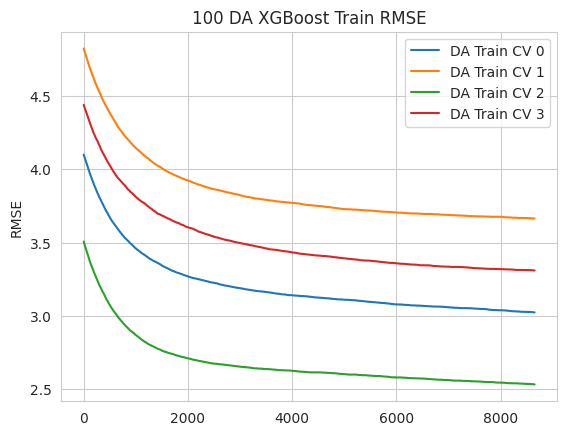

In [52]:
aug100_scores = []
fig, ax = plt.subplots()

i = 0
for train_index, test_index in kfolds.split(X_aug100):
    X_train_cv, X_test_cv = X_aug100[train_index], X_aug100[test_index]
    y_train_cv, y_test_cv = y_aug100[train_index], y_aug100[test_index]


    reg = XGBRegressor(
        n_estimators = 8654, 
        max_depth = 3, 
        subsample = 0.31, 
        colsample_bytree = 0.48, 
        colsample_bylevel = 0.1, 
        learning_rate = 0.001,
        verbose=False
    )
    reg.fit(X_train_cv, y_train_cv, eval_set=[(X_test_cv, y_test_cv)])
    y_pred = reg.predict(X_test)
    score_test = mean_squared_error(y_test, y_pred, squared = False)
    aug100_scores.append(score_test)
    
    results = reg.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    ax.plot(x_axis, results['validation_0']['rmse'], label=('DA Train CV ' + str(i)))
    
    i = i+1

    
ax.legend()
plt.ylabel('RMSE')
plt.title('100 DA XGBoost Train RMSE')
plt.show()


[0]	validation_0-rmse:16.47300
[1]	validation_0-rmse:16.45693
[2]	validation_0-rmse:16.44083
[3]	validation_0-rmse:16.42471
[4]	validation_0-rmse:16.40870
[5]	validation_0-rmse:16.39268
[6]	validation_0-rmse:16.37664
[7]	validation_0-rmse:16.36065
[8]	validation_0-rmse:16.34463
[9]	validation_0-rmse:16.32868
[10]	validation_0-rmse:16.31272
[11]	validation_0-rmse:16.29678
[12]	validation_0-rmse:16.28219
[13]	validation_0-rmse:16.26630
[14]	validation_0-rmse:16.25039
[15]	validation_0-rmse:16.23454
[16]	validation_0-rmse:16.21869
[17]	validation_0-rmse:16.20283
[18]	validation_0-rmse:16.18703
[19]	validation_0-rmse:16.17119
[20]	validation_0-rmse:16.15541
[21]	validation_0-rmse:16.13965
[22]	validation_0-rmse:16.12388
[23]	validation_0-rmse:16.10830
[24]	validation_0-rmse:16.09266
[25]	validation_0-rmse:16.07693
[26]	validation_0-rmse:16.06123
[27]	validation_0-rmse:16.04556
[28]	validation_0-rmse:16.02992
[29]	validation_0-rmse:16.01429
[30]	validation_0-rmse:15.99866
[31]	validation_0-

[252]	validation_0-rmse:12.89853
[253]	validation_0-rmse:12.88611
[254]	validation_0-rmse:12.87366
[255]	validation_0-rmse:12.86123
[256]	validation_0-rmse:12.84880
[257]	validation_0-rmse:12.83638
[258]	validation_0-rmse:12.82398
[259]	validation_0-rmse:12.81159
[260]	validation_0-rmse:12.79922
[261]	validation_0-rmse:12.78691
[262]	validation_0-rmse:12.77456
[263]	validation_0-rmse:12.76227
[264]	validation_0-rmse:12.74996
[265]	validation_0-rmse:12.73760
[266]	validation_0-rmse:12.72527
[267]	validation_0-rmse:12.71319
[268]	validation_0-rmse:12.70098
[269]	validation_0-rmse:12.68870
[270]	validation_0-rmse:12.67648
[271]	validation_0-rmse:12.66427
[272]	validation_0-rmse:12.65201
[273]	validation_0-rmse:12.63981
[274]	validation_0-rmse:12.62757
[275]	validation_0-rmse:12.61537
[276]	validation_0-rmse:12.60323
[277]	validation_0-rmse:12.59106
[278]	validation_0-rmse:12.57892
[279]	validation_0-rmse:12.56680
[280]	validation_0-rmse:12.55470
[281]	validation_0-rmse:12.54259
[282]	vali

[501]	validation_0-rmse:10.16359
[502]	validation_0-rmse:10.15397
[503]	validation_0-rmse:10.14437
[504]	validation_0-rmse:10.13475
[505]	validation_0-rmse:10.12514
[506]	validation_0-rmse:10.11555
[507]	validation_0-rmse:10.10597
[508]	validation_0-rmse:10.09638
[509]	validation_0-rmse:10.08684
[510]	validation_0-rmse:10.07727
[511]	validation_0-rmse:10.06768
[512]	validation_0-rmse:10.05809
[513]	validation_0-rmse:10.04860
[514]	validation_0-rmse:10.03907
[515]	validation_0-rmse:10.02954
[516]	validation_0-rmse:10.02003
[517]	validation_0-rmse:10.01054
[518]	validation_0-rmse:10.00104
[519]	validation_0-rmse:9.99156
[520]	validation_0-rmse:9.98210
[521]	validation_0-rmse:9.97265
[522]	validation_0-rmse:9.96322
[523]	validation_0-rmse:9.95379
[524]	validation_0-rmse:9.94433
[525]	validation_0-rmse:9.93492
[526]	validation_0-rmse:9.92553
[527]	validation_0-rmse:9.91609
[528]	validation_0-rmse:9.90672
[529]	validation_0-rmse:9.89736
[530]	validation_0-rmse:9.88803
[531]	validation_0-rms

[757]	validation_0-rmse:8.00017
[758]	validation_0-rmse:7.99280
[759]	validation_0-rmse:7.98547
[760]	validation_0-rmse:7.97808
[761]	validation_0-rmse:7.97074
[762]	validation_0-rmse:7.96346
[763]	validation_0-rmse:7.95614
[764]	validation_0-rmse:7.94882
[765]	validation_0-rmse:7.94148
[766]	validation_0-rmse:7.93419
[767]	validation_0-rmse:7.92692
[768]	validation_0-rmse:7.91965
[769]	validation_0-rmse:7.91240
[770]	validation_0-rmse:7.90512
[771]	validation_0-rmse:7.89786
[772]	validation_0-rmse:7.89061
[773]	validation_0-rmse:7.88335
[774]	validation_0-rmse:7.87615
[775]	validation_0-rmse:7.86888
[776]	validation_0-rmse:7.86166
[777]	validation_0-rmse:7.85449
[778]	validation_0-rmse:7.84730
[779]	validation_0-rmse:7.84008
[780]	validation_0-rmse:7.83291
[781]	validation_0-rmse:7.82577
[782]	validation_0-rmse:7.81857
[783]	validation_0-rmse:7.81136
[784]	validation_0-rmse:7.80420
[785]	validation_0-rmse:7.79707
[786]	validation_0-rmse:7.78993
[787]	validation_0-rmse:7.78280
[788]	va

[1013]	validation_0-rmse:6.35404
[1014]	validation_0-rmse:6.34842
[1015]	validation_0-rmse:6.34283
[1016]	validation_0-rmse:6.33729
[1017]	validation_0-rmse:6.33173
[1018]	validation_0-rmse:6.32612
[1019]	validation_0-rmse:6.32056
[1020]	validation_0-rmse:6.31503
[1021]	validation_0-rmse:6.30951
[1022]	validation_0-rmse:6.30404
[1023]	validation_0-rmse:6.29852
[1024]	validation_0-rmse:6.29303
[1025]	validation_0-rmse:6.28753
[1026]	validation_0-rmse:6.28207
[1027]	validation_0-rmse:6.27654
[1028]	validation_0-rmse:6.27103
[1029]	validation_0-rmse:6.26552
[1030]	validation_0-rmse:6.25994
[1031]	validation_0-rmse:6.25450
[1032]	validation_0-rmse:6.24902
[1033]	validation_0-rmse:6.24359
[1034]	validation_0-rmse:6.23811
[1035]	validation_0-rmse:6.23266
[1036]	validation_0-rmse:6.22724
[1037]	validation_0-rmse:6.22176
[1038]	validation_0-rmse:6.21632
[1039]	validation_0-rmse:6.21089
[1040]	validation_0-rmse:6.20549
[1041]	validation_0-rmse:6.20008
[1042]	validation_0-rmse:6.19471
[1043]	val

[1262]	validation_0-rmse:5.14306
[1263]	validation_0-rmse:5.13884
[1264]	validation_0-rmse:5.13468
[1265]	validation_0-rmse:5.13047
[1266]	validation_0-rmse:5.12629
[1267]	validation_0-rmse:5.12212
[1268]	validation_0-rmse:5.11789
[1269]	validation_0-rmse:5.11374
[1270]	validation_0-rmse:5.10964
[1271]	validation_0-rmse:5.10545
[1272]	validation_0-rmse:5.10130
[1273]	validation_0-rmse:5.09714
[1274]	validation_0-rmse:5.09298
[1275]	validation_0-rmse:5.08885
[1276]	validation_0-rmse:5.08477
[1277]	validation_0-rmse:5.08055
[1278]	validation_0-rmse:5.07639
[1279]	validation_0-rmse:5.07229
[1280]	validation_0-rmse:5.06812
[1281]	validation_0-rmse:5.06400
[1282]	validation_0-rmse:5.05987
[1283]	validation_0-rmse:5.05577
[1284]	validation_0-rmse:5.05168
[1285]	validation_0-rmse:5.04757
[1286]	validation_0-rmse:5.04348
[1287]	validation_0-rmse:5.03943
[1288]	validation_0-rmse:5.03534
[1289]	validation_0-rmse:5.03125
[1290]	validation_0-rmse:5.02718
[1291]	validation_0-rmse:5.02309
[1292]	val

[1511]	validation_0-rmse:4.23677
[1512]	validation_0-rmse:4.23363
[1513]	validation_0-rmse:4.23057
[1514]	validation_0-rmse:4.22751
[1515]	validation_0-rmse:4.22443
[1516]	validation_0-rmse:4.22134
[1517]	validation_0-rmse:4.21827
[1518]	validation_0-rmse:4.21520
[1519]	validation_0-rmse:4.21213
[1520]	validation_0-rmse:4.20907
[1521]	validation_0-rmse:4.20600
[1522]	validation_0-rmse:4.20295
[1523]	validation_0-rmse:4.19984
[1524]	validation_0-rmse:4.19674
[1525]	validation_0-rmse:4.19369
[1526]	validation_0-rmse:4.19066
[1527]	validation_0-rmse:4.18765
[1528]	validation_0-rmse:4.18460
[1529]	validation_0-rmse:4.18153
[1530]	validation_0-rmse:4.17848
[1531]	validation_0-rmse:4.17541
[1532]	validation_0-rmse:4.17238
[1533]	validation_0-rmse:4.16938
[1534]	validation_0-rmse:4.16636
[1535]	validation_0-rmse:4.16336
[1536]	validation_0-rmse:4.16037
[1537]	validation_0-rmse:4.15736
[1538]	validation_0-rmse:4.15434
[1539]	validation_0-rmse:4.15129
[1540]	validation_0-rmse:4.14828
[1541]	val

[1760]	validation_0-rmse:3.57160
[1761]	validation_0-rmse:3.56932
[1762]	validation_0-rmse:3.56708
[1763]	validation_0-rmse:3.56479
[1764]	validation_0-rmse:3.56254
[1765]	validation_0-rmse:3.56031
[1766]	validation_0-rmse:3.55802
[1767]	validation_0-rmse:3.55580
[1768]	validation_0-rmse:3.55342
[1769]	validation_0-rmse:3.55114
[1770]	validation_0-rmse:3.54894
[1771]	validation_0-rmse:3.54669
[1772]	validation_0-rmse:3.54448
[1773]	validation_0-rmse:3.54231
[1774]	validation_0-rmse:3.54009
[1775]	validation_0-rmse:3.53789
[1776]	validation_0-rmse:3.53563
[1777]	validation_0-rmse:3.53347
[1778]	validation_0-rmse:3.53131
[1779]	validation_0-rmse:3.52928
[1780]	validation_0-rmse:3.52714
[1781]	validation_0-rmse:3.52495
[1782]	validation_0-rmse:3.52275
[1783]	validation_0-rmse:3.52057
[1784]	validation_0-rmse:3.51839
[1785]	validation_0-rmse:3.51619
[1786]	validation_0-rmse:3.51402
[1787]	validation_0-rmse:3.51187
[1788]	validation_0-rmse:3.50973
[1789]	validation_0-rmse:3.50759
[1790]	val

[2009]	validation_0-rmse:3.09419
[2010]	validation_0-rmse:3.09262
[2011]	validation_0-rmse:3.09102
[2012]	validation_0-rmse:3.08940
[2013]	validation_0-rmse:3.08781
[2014]	validation_0-rmse:3.08625
[2015]	validation_0-rmse:3.08464
[2016]	validation_0-rmse:3.08301
[2017]	validation_0-rmse:3.08148
[2018]	validation_0-rmse:3.07989
[2019]	validation_0-rmse:3.07829
[2020]	validation_0-rmse:3.07668
[2021]	validation_0-rmse:3.07512
[2022]	validation_0-rmse:3.07345
[2023]	validation_0-rmse:3.07194
[2024]	validation_0-rmse:3.07034
[2025]	validation_0-rmse:3.06878
[2026]	validation_0-rmse:3.06717
[2027]	validation_0-rmse:3.06561
[2028]	validation_0-rmse:3.06408
[2029]	validation_0-rmse:3.06231
[2030]	validation_0-rmse:3.06070
[2031]	validation_0-rmse:3.05916
[2032]	validation_0-rmse:3.05764
[2033]	validation_0-rmse:3.05613
[2034]	validation_0-rmse:3.05454
[2035]	validation_0-rmse:3.05303
[2036]	validation_0-rmse:3.05151
[2037]	validation_0-rmse:3.05000
[2038]	validation_0-rmse:3.04849
[2039]	val

[2257]	validation_0-rmse:2.76089
[2258]	validation_0-rmse:2.75983
[2259]	validation_0-rmse:2.75875
[2260]	validation_0-rmse:2.75768
[2261]	validation_0-rmse:2.75657
[2262]	validation_0-rmse:2.75538
[2263]	validation_0-rmse:2.75426
[2264]	validation_0-rmse:2.75317
[2265]	validation_0-rmse:2.75209
[2266]	validation_0-rmse:2.75104
[2267]	validation_0-rmse:2.74987
[2268]	validation_0-rmse:2.74878
[2269]	validation_0-rmse:2.74765
[2270]	validation_0-rmse:2.74655
[2271]	validation_0-rmse:2.74548
[2272]	validation_0-rmse:2.74444
[2273]	validation_0-rmse:2.74335
[2274]	validation_0-rmse:2.74230
[2275]	validation_0-rmse:2.74118
[2276]	validation_0-rmse:2.74012
[2277]	validation_0-rmse:2.73906
[2278]	validation_0-rmse:2.73797
[2279]	validation_0-rmse:2.73670
[2280]	validation_0-rmse:2.73558
[2281]	validation_0-rmse:2.73452
[2282]	validation_0-rmse:2.73349
[2283]	validation_0-rmse:2.73246
[2284]	validation_0-rmse:2.73138
[2285]	validation_0-rmse:2.73032
[2286]	validation_0-rmse:2.72919
[2287]	val

[2506]	validation_0-rmse:2.53218
[2507]	validation_0-rmse:2.53147
[2508]	validation_0-rmse:2.53076
[2509]	validation_0-rmse:2.53002
[2510]	validation_0-rmse:2.52932
[2511]	validation_0-rmse:2.52860
[2512]	validation_0-rmse:2.52786
[2513]	validation_0-rmse:2.52710
[2514]	validation_0-rmse:2.52634
[2515]	validation_0-rmse:2.52564
[2516]	validation_0-rmse:2.52493
[2517]	validation_0-rmse:2.52420
[2518]	validation_0-rmse:2.52351
[2519]	validation_0-rmse:2.52278
[2520]	validation_0-rmse:2.52202
[2521]	validation_0-rmse:2.52135
[2522]	validation_0-rmse:2.52063
[2523]	validation_0-rmse:2.51994
[2524]	validation_0-rmse:2.51920
[2525]	validation_0-rmse:2.51848
[2526]	validation_0-rmse:2.51779
[2527]	validation_0-rmse:2.51706
[2528]	validation_0-rmse:2.51637
[2529]	validation_0-rmse:2.51568
[2530]	validation_0-rmse:2.51496
[2531]	validation_0-rmse:2.51424
[2532]	validation_0-rmse:2.51356
[2533]	validation_0-rmse:2.51285
[2534]	validation_0-rmse:2.51214
[2535]	validation_0-rmse:2.51146
[2536]	val

[2755]	validation_0-rmse:2.37921
[2756]	validation_0-rmse:2.37872
[2757]	validation_0-rmse:2.37823
[2758]	validation_0-rmse:2.37773
[2759]	validation_0-rmse:2.37727
[2760]	validation_0-rmse:2.37678
[2761]	validation_0-rmse:2.37631
[2762]	validation_0-rmse:2.37583
[2763]	validation_0-rmse:2.37536
[2764]	validation_0-rmse:2.37489
[2765]	validation_0-rmse:2.37437
[2766]	validation_0-rmse:2.37388
[2767]	validation_0-rmse:2.37343
[2768]	validation_0-rmse:2.37297
[2769]	validation_0-rmse:2.37250
[2770]	validation_0-rmse:2.37200
[2771]	validation_0-rmse:2.37154
[2772]	validation_0-rmse:2.37103
[2773]	validation_0-rmse:2.37058
[2774]	validation_0-rmse:2.37013
[2775]	validation_0-rmse:2.36964
[2776]	validation_0-rmse:2.36916
[2777]	validation_0-rmse:2.36863
[2778]	validation_0-rmse:2.36818
[2779]	validation_0-rmse:2.36764
[2780]	validation_0-rmse:2.36690
[2781]	validation_0-rmse:2.36645
[2782]	validation_0-rmse:2.36603
[2783]	validation_0-rmse:2.36556
[2784]	validation_0-rmse:2.36496
[2785]	val

[3004]	validation_0-rmse:2.27870
[3005]	validation_0-rmse:2.27836
[3006]	validation_0-rmse:2.27808
[3007]	validation_0-rmse:2.27773
[3008]	validation_0-rmse:2.27741
[3009]	validation_0-rmse:2.27711
[3010]	validation_0-rmse:2.27675
[3011]	validation_0-rmse:2.27642
[3012]	validation_0-rmse:2.27615
[3013]	validation_0-rmse:2.27586
[3014]	validation_0-rmse:2.27552
[3015]	validation_0-rmse:2.27524
[3016]	validation_0-rmse:2.27494
[3017]	validation_0-rmse:2.27463
[3018]	validation_0-rmse:2.27431
[3019]	validation_0-rmse:2.27401
[3020]	validation_0-rmse:2.27366
[3021]	validation_0-rmse:2.27325
[3022]	validation_0-rmse:2.27296
[3023]	validation_0-rmse:2.27258
[3024]	validation_0-rmse:2.27230
[3025]	validation_0-rmse:2.27200
[3026]	validation_0-rmse:2.27170
[3027]	validation_0-rmse:2.27141
[3028]	validation_0-rmse:2.27112
[3029]	validation_0-rmse:2.27075
[3030]	validation_0-rmse:2.27043
[3031]	validation_0-rmse:2.27006
[3032]	validation_0-rmse:2.26979
[3033]	validation_0-rmse:2.26951
[3034]	val

[3253]	validation_0-rmse:2.21187
[3254]	validation_0-rmse:2.21167
[3255]	validation_0-rmse:2.21142
[3256]	validation_0-rmse:2.21125
[3257]	validation_0-rmse:2.21102
[3258]	validation_0-rmse:2.21072
[3259]	validation_0-rmse:2.21056
[3260]	validation_0-rmse:2.21033
[3261]	validation_0-rmse:2.21020
[3262]	validation_0-rmse:2.20999
[3263]	validation_0-rmse:2.20981
[3264]	validation_0-rmse:2.20960
[3265]	validation_0-rmse:2.20939
[3266]	validation_0-rmse:2.20919
[3267]	validation_0-rmse:2.20896
[3268]	validation_0-rmse:2.20858
[3269]	validation_0-rmse:2.20836
[3270]	validation_0-rmse:2.20815
[3271]	validation_0-rmse:2.20786
[3272]	validation_0-rmse:2.20762
[3273]	validation_0-rmse:2.20742
[3274]	validation_0-rmse:2.20728
[3275]	validation_0-rmse:2.20702
[3276]	validation_0-rmse:2.20682
[3277]	validation_0-rmse:2.20655
[3278]	validation_0-rmse:2.20638
[3279]	validation_0-rmse:2.20623
[3280]	validation_0-rmse:2.20599
[3281]	validation_0-rmse:2.20581
[3282]	validation_0-rmse:2.20567
[3283]	val

[3501]	validation_0-rmse:2.16803
[3502]	validation_0-rmse:2.16769
[3503]	validation_0-rmse:2.16756
[3504]	validation_0-rmse:2.16746
[3505]	validation_0-rmse:2.16732
[3506]	validation_0-rmse:2.16717
[3507]	validation_0-rmse:2.16707
[3508]	validation_0-rmse:2.16689
[3509]	validation_0-rmse:2.16670
[3510]	validation_0-rmse:2.16661
[3511]	validation_0-rmse:2.16646
[3512]	validation_0-rmse:2.16632
[3513]	validation_0-rmse:2.16617
[3514]	validation_0-rmse:2.16605
[3515]	validation_0-rmse:2.16589
[3516]	validation_0-rmse:2.16582
[3517]	validation_0-rmse:2.16571
[3518]	validation_0-rmse:2.16562
[3519]	validation_0-rmse:2.16550
[3520]	validation_0-rmse:2.16537
[3521]	validation_0-rmse:2.16525
[3522]	validation_0-rmse:2.16512
[3523]	validation_0-rmse:2.16501
[3524]	validation_0-rmse:2.16489
[3525]	validation_0-rmse:2.16479
[3526]	validation_0-rmse:2.16466
[3527]	validation_0-rmse:2.16451
[3528]	validation_0-rmse:2.16436
[3529]	validation_0-rmse:2.16424
[3530]	validation_0-rmse:2.16414
[3531]	val

[3750]	validation_0-rmse:2.13842
[3751]	validation_0-rmse:2.13829
[3752]	validation_0-rmse:2.13820
[3753]	validation_0-rmse:2.13813
[3754]	validation_0-rmse:2.13808
[3755]	validation_0-rmse:2.13792
[3756]	validation_0-rmse:2.13778
[3757]	validation_0-rmse:2.13770
[3758]	validation_0-rmse:2.13763
[3759]	validation_0-rmse:2.13756
[3760]	validation_0-rmse:2.13743
[3761]	validation_0-rmse:2.13733
[3762]	validation_0-rmse:2.13728
[3763]	validation_0-rmse:2.13720
[3764]	validation_0-rmse:2.13713
[3765]	validation_0-rmse:2.13705
[3766]	validation_0-rmse:2.13693
[3767]	validation_0-rmse:2.13672
[3768]	validation_0-rmse:2.13663
[3769]	validation_0-rmse:2.13655
[3770]	validation_0-rmse:2.13647
[3771]	validation_0-rmse:2.13640
[3772]	validation_0-rmse:2.13633
[3773]	validation_0-rmse:2.13622
[3774]	validation_0-rmse:2.13613
[3775]	validation_0-rmse:2.13602
[3776]	validation_0-rmse:2.13596
[3777]	validation_0-rmse:2.13585
[3778]	validation_0-rmse:2.13579
[3779]	validation_0-rmse:2.13565
[3780]	val

[3999]	validation_0-rmse:2.11778
[4000]	validation_0-rmse:2.11772
[4001]	validation_0-rmse:2.11766
[4002]	validation_0-rmse:2.11757
[4003]	validation_0-rmse:2.11752
[4004]	validation_0-rmse:2.11727
[4005]	validation_0-rmse:2.11713
[4006]	validation_0-rmse:2.11706
[4007]	validation_0-rmse:2.11694
[4008]	validation_0-rmse:2.11687
[4009]	validation_0-rmse:2.11675
[4010]	validation_0-rmse:2.11667
[4011]	validation_0-rmse:2.11661
[4012]	validation_0-rmse:2.11652
[4013]	validation_0-rmse:2.11647
[4014]	validation_0-rmse:2.11638
[4015]	validation_0-rmse:2.11631
[4016]	validation_0-rmse:2.11627
[4017]	validation_0-rmse:2.11614
[4018]	validation_0-rmse:2.11610
[4019]	validation_0-rmse:2.11606
[4020]	validation_0-rmse:2.11604
[4021]	validation_0-rmse:2.11600
[4022]	validation_0-rmse:2.11591
[4023]	validation_0-rmse:2.11584
[4024]	validation_0-rmse:2.11579
[4025]	validation_0-rmse:2.11570
[4026]	validation_0-rmse:2.11565
[4027]	validation_0-rmse:2.11531
[4028]	validation_0-rmse:2.11526
[4029]	val

[4248]	validation_0-rmse:2.10206
[4249]	validation_0-rmse:2.10191
[4250]	validation_0-rmse:2.10187
[4251]	validation_0-rmse:2.10185
[4252]	validation_0-rmse:2.10180
[4253]	validation_0-rmse:2.10172
[4254]	validation_0-rmse:2.10170
[4255]	validation_0-rmse:2.10167
[4256]	validation_0-rmse:2.10163
[4257]	validation_0-rmse:2.10162
[4258]	validation_0-rmse:2.10159
[4259]	validation_0-rmse:2.10155
[4260]	validation_0-rmse:2.10143
[4261]	validation_0-rmse:2.10139
[4262]	validation_0-rmse:2.10137
[4263]	validation_0-rmse:2.10131
[4264]	validation_0-rmse:2.10117
[4265]	validation_0-rmse:2.10111
[4266]	validation_0-rmse:2.10103
[4267]	validation_0-rmse:2.10101
[4268]	validation_0-rmse:2.10097
[4269]	validation_0-rmse:2.10090
[4270]	validation_0-rmse:2.10086
[4271]	validation_0-rmse:2.10086
[4272]	validation_0-rmse:2.10084
[4273]	validation_0-rmse:2.10082
[4274]	validation_0-rmse:2.10073
[4275]	validation_0-rmse:2.10070
[4276]	validation_0-rmse:2.10063
[4277]	validation_0-rmse:2.10055
[4278]	val

[4497]	validation_0-rmse:2.09102
[4498]	validation_0-rmse:2.09095
[4499]	validation_0-rmse:2.09087
[4500]	validation_0-rmse:2.09079
[4501]	validation_0-rmse:2.09074
[4502]	validation_0-rmse:2.09072
[4503]	validation_0-rmse:2.09071
[4504]	validation_0-rmse:2.09067
[4505]	validation_0-rmse:2.09066
[4506]	validation_0-rmse:2.09065
[4507]	validation_0-rmse:2.09064
[4508]	validation_0-rmse:2.09062
[4509]	validation_0-rmse:2.09061
[4510]	validation_0-rmse:2.09058
[4511]	validation_0-rmse:2.09056
[4512]	validation_0-rmse:2.09053
[4513]	validation_0-rmse:2.09045
[4514]	validation_0-rmse:2.09041
[4515]	validation_0-rmse:2.09027
[4516]	validation_0-rmse:2.09026
[4517]	validation_0-rmse:2.09023
[4518]	validation_0-rmse:2.09025
[4519]	validation_0-rmse:2.09023
[4520]	validation_0-rmse:2.09019
[4521]	validation_0-rmse:2.09016
[4522]	validation_0-rmse:2.09015
[4523]	validation_0-rmse:2.09015
[4524]	validation_0-rmse:2.09015
[4525]	validation_0-rmse:2.09017
[4526]	validation_0-rmse:2.09014
[4527]	val

[4746]	validation_0-rmse:2.08263
[4747]	validation_0-rmse:2.08261
[4748]	validation_0-rmse:2.08260
[4749]	validation_0-rmse:2.08254
[4750]	validation_0-rmse:2.08248
[4751]	validation_0-rmse:2.08247
[4752]	validation_0-rmse:2.08243
[4753]	validation_0-rmse:2.08242
[4754]	validation_0-rmse:2.08239
[4755]	validation_0-rmse:2.08235
[4756]	validation_0-rmse:2.08233
[4757]	validation_0-rmse:2.08229
[4758]	validation_0-rmse:2.08228
[4759]	validation_0-rmse:2.08225
[4760]	validation_0-rmse:2.08220
[4761]	validation_0-rmse:2.08213
[4762]	validation_0-rmse:2.08213
[4763]	validation_0-rmse:2.08213
[4764]	validation_0-rmse:2.08209
[4765]	validation_0-rmse:2.08208
[4766]	validation_0-rmse:2.08209
[4767]	validation_0-rmse:2.08208
[4768]	validation_0-rmse:2.08207
[4769]	validation_0-rmse:2.08216
[4770]	validation_0-rmse:2.08213
[4771]	validation_0-rmse:2.08204
[4772]	validation_0-rmse:2.08202
[4773]	validation_0-rmse:2.08189
[4774]	validation_0-rmse:2.08192
[4775]	validation_0-rmse:2.08194
[4776]	val

[4995]	validation_0-rmse:2.07396
[4996]	validation_0-rmse:2.07395
[4997]	validation_0-rmse:2.07387
[4998]	validation_0-rmse:2.07384
[4999]	validation_0-rmse:2.07377
[5000]	validation_0-rmse:2.07374
[5001]	validation_0-rmse:2.07371
[5002]	validation_0-rmse:2.07370
[5003]	validation_0-rmse:2.07369
[5004]	validation_0-rmse:2.07370
[5005]	validation_0-rmse:2.07370
[5006]	validation_0-rmse:2.07362
[5007]	validation_0-rmse:2.07360
[5008]	validation_0-rmse:2.07359
[5009]	validation_0-rmse:2.07354
[5010]	validation_0-rmse:2.07353
[5011]	validation_0-rmse:2.07351
[5012]	validation_0-rmse:2.07349
[5013]	validation_0-rmse:2.07347
[5014]	validation_0-rmse:2.07345
[5015]	validation_0-rmse:2.07330
[5016]	validation_0-rmse:2.07323
[5017]	validation_0-rmse:2.07323
[5018]	validation_0-rmse:2.07311
[5019]	validation_0-rmse:2.07305
[5020]	validation_0-rmse:2.07286
[5021]	validation_0-rmse:2.07283
[5022]	validation_0-rmse:2.07283
[5023]	validation_0-rmse:2.07281
[5024]	validation_0-rmse:2.07285
[5025]	val

[5244]	validation_0-rmse:2.06594
[5245]	validation_0-rmse:2.06593
[5246]	validation_0-rmse:2.06587
[5247]	validation_0-rmse:2.06579
[5248]	validation_0-rmse:2.06576
[5249]	validation_0-rmse:2.06578
[5250]	validation_0-rmse:2.06573
[5251]	validation_0-rmse:2.06569
[5252]	validation_0-rmse:2.06564
[5253]	validation_0-rmse:2.06562
[5254]	validation_0-rmse:2.06553
[5255]	validation_0-rmse:2.06549
[5256]	validation_0-rmse:2.06549
[5257]	validation_0-rmse:2.06549
[5258]	validation_0-rmse:2.06549
[5259]	validation_0-rmse:2.06544
[5260]	validation_0-rmse:2.06542
[5261]	validation_0-rmse:2.06533
[5262]	validation_0-rmse:2.06535
[5263]	validation_0-rmse:2.06529
[5264]	validation_0-rmse:2.06528
[5265]	validation_0-rmse:2.06528
[5266]	validation_0-rmse:2.06526
[5267]	validation_0-rmse:2.06529
[5268]	validation_0-rmse:2.06532
[5269]	validation_0-rmse:2.06529
[5270]	validation_0-rmse:2.06526
[5271]	validation_0-rmse:2.06526
[5272]	validation_0-rmse:2.06525
[5273]	validation_0-rmse:2.06518
[5274]	val

[5493]	validation_0-rmse:2.05965
[5494]	validation_0-rmse:2.05963
[5495]	validation_0-rmse:2.05961
[5496]	validation_0-rmse:2.05960
[5497]	validation_0-rmse:2.05958
[5498]	validation_0-rmse:2.05942
[5499]	validation_0-rmse:2.05941
[5500]	validation_0-rmse:2.05941
[5501]	validation_0-rmse:2.05943
[5502]	validation_0-rmse:2.05943
[5503]	validation_0-rmse:2.05941
[5504]	validation_0-rmse:2.05937
[5505]	validation_0-rmse:2.05911
[5506]	validation_0-rmse:2.05905
[5507]	validation_0-rmse:2.05900
[5508]	validation_0-rmse:2.05896
[5509]	validation_0-rmse:2.05896
[5510]	validation_0-rmse:2.05893
[5511]	validation_0-rmse:2.05892
[5512]	validation_0-rmse:2.05893
[5513]	validation_0-rmse:2.05893
[5514]	validation_0-rmse:2.05892
[5515]	validation_0-rmse:2.05890
[5516]	validation_0-rmse:2.05887
[5517]	validation_0-rmse:2.05887
[5518]	validation_0-rmse:2.05887
[5519]	validation_0-rmse:2.05883
[5520]	validation_0-rmse:2.05887
[5521]	validation_0-rmse:2.05889
[5522]	validation_0-rmse:2.05881
[5523]	val

[5742]	validation_0-rmse:2.05296
[5743]	validation_0-rmse:2.05290
[5744]	validation_0-rmse:2.05263
[5745]	validation_0-rmse:2.05262
[5746]	validation_0-rmse:2.05261
[5747]	validation_0-rmse:2.05257
[5748]	validation_0-rmse:2.05256
[5749]	validation_0-rmse:2.05255
[5750]	validation_0-rmse:2.05261
[5751]	validation_0-rmse:2.05259
[5752]	validation_0-rmse:2.05255
[5753]	validation_0-rmse:2.05253
[5754]	validation_0-rmse:2.05251
[5755]	validation_0-rmse:2.05247
[5756]	validation_0-rmse:2.05239
[5757]	validation_0-rmse:2.05236
[5758]	validation_0-rmse:2.05234
[5759]	validation_0-rmse:2.05234
[5760]	validation_0-rmse:2.05236
[5761]	validation_0-rmse:2.05236
[5762]	validation_0-rmse:2.05240
[5763]	validation_0-rmse:2.05238
[5764]	validation_0-rmse:2.05229
[5765]	validation_0-rmse:2.05228
[5766]	validation_0-rmse:2.05224
[5767]	validation_0-rmse:2.05221
[5768]	validation_0-rmse:2.05220
[5769]	validation_0-rmse:2.05220
[5770]	validation_0-rmse:2.05215
[5771]	validation_0-rmse:2.05204
[5772]	val

[5991]	validation_0-rmse:2.04526
[5992]	validation_0-rmse:2.04525
[5993]	validation_0-rmse:2.04524
[5994]	validation_0-rmse:2.04522
[5995]	validation_0-rmse:2.04516
[5996]	validation_0-rmse:2.04514
[5997]	validation_0-rmse:2.04514
[5998]	validation_0-rmse:2.04508
[5999]	validation_0-rmse:2.04504
[6000]	validation_0-rmse:2.04506
[6001]	validation_0-rmse:2.04500
[6002]	validation_0-rmse:2.04500
[6003]	validation_0-rmse:2.04501
[6004]	validation_0-rmse:2.04503
[6005]	validation_0-rmse:2.04503
[6006]	validation_0-rmse:2.04495
[6007]	validation_0-rmse:2.04496
[6008]	validation_0-rmse:2.04495
[6009]	validation_0-rmse:2.04494
[6010]	validation_0-rmse:2.04497
[6011]	validation_0-rmse:2.04493
[6012]	validation_0-rmse:2.04493
[6013]	validation_0-rmse:2.04489
[6014]	validation_0-rmse:2.04487
[6015]	validation_0-rmse:2.04487
[6016]	validation_0-rmse:2.04486
[6017]	validation_0-rmse:2.04482
[6018]	validation_0-rmse:2.04484
[6019]	validation_0-rmse:2.04485
[6020]	validation_0-rmse:2.04483
[6021]	val

[6239]	validation_0-rmse:2.04026
[6240]	validation_0-rmse:2.04021
[6241]	validation_0-rmse:2.04021
[6242]	validation_0-rmse:2.04021
[6243]	validation_0-rmse:2.04014
[6244]	validation_0-rmse:2.04015
[6245]	validation_0-rmse:2.04014
[6246]	validation_0-rmse:2.04014
[6247]	validation_0-rmse:2.04004
[6248]	validation_0-rmse:2.03994
[6249]	validation_0-rmse:2.03994
[6250]	validation_0-rmse:2.03992
[6251]	validation_0-rmse:2.03996
[6252]	validation_0-rmse:2.03996
[6253]	validation_0-rmse:2.03992
[6254]	validation_0-rmse:2.03991
[6255]	validation_0-rmse:2.03980
[6256]	validation_0-rmse:2.03981
[6257]	validation_0-rmse:2.03981
[6258]	validation_0-rmse:2.03981
[6259]	validation_0-rmse:2.03983
[6260]	validation_0-rmse:2.03977
[6261]	validation_0-rmse:2.03976
[6262]	validation_0-rmse:2.03972
[6263]	validation_0-rmse:2.03976
[6264]	validation_0-rmse:2.03975
[6265]	validation_0-rmse:2.03974
[6266]	validation_0-rmse:2.03970
[6267]	validation_0-rmse:2.03963
[6268]	validation_0-rmse:2.03962
[6269]	val

[6488]	validation_0-rmse:2.03400
[6489]	validation_0-rmse:2.03399
[6490]	validation_0-rmse:2.03400
[6491]	validation_0-rmse:2.03406
[6492]	validation_0-rmse:2.03407
[6493]	validation_0-rmse:2.03407
[6494]	validation_0-rmse:2.03408
[6495]	validation_0-rmse:2.03407
[6496]	validation_0-rmse:2.03406
[6497]	validation_0-rmse:2.03409
[6498]	validation_0-rmse:2.03405
[6499]	validation_0-rmse:2.03406
[6500]	validation_0-rmse:2.03399
[6501]	validation_0-rmse:2.03400
[6502]	validation_0-rmse:2.03398
[6503]	validation_0-rmse:2.03393
[6504]	validation_0-rmse:2.03391
[6505]	validation_0-rmse:2.03390
[6506]	validation_0-rmse:2.03390
[6507]	validation_0-rmse:2.03390
[6508]	validation_0-rmse:2.03384
[6509]	validation_0-rmse:2.03387
[6510]	validation_0-rmse:2.03385
[6511]	validation_0-rmse:2.03385
[6512]	validation_0-rmse:2.03382
[6513]	validation_0-rmse:2.03379
[6514]	validation_0-rmse:2.03371
[6515]	validation_0-rmse:2.03372
[6516]	validation_0-rmse:2.03369
[6517]	validation_0-rmse:2.03368
[6518]	val

[6737]	validation_0-rmse:2.02878
[6738]	validation_0-rmse:2.02877
[6739]	validation_0-rmse:2.02872
[6740]	validation_0-rmse:2.02872
[6741]	validation_0-rmse:2.02848
[6742]	validation_0-rmse:2.02848
[6743]	validation_0-rmse:2.02828
[6744]	validation_0-rmse:2.02823
[6745]	validation_0-rmse:2.02821
[6746]	validation_0-rmse:2.02820
[6747]	validation_0-rmse:2.02817
[6748]	validation_0-rmse:2.02793
[6749]	validation_0-rmse:2.02795
[6750]	validation_0-rmse:2.02794
[6751]	validation_0-rmse:2.02794
[6752]	validation_0-rmse:2.02795
[6753]	validation_0-rmse:2.02794
[6754]	validation_0-rmse:2.02792
[6755]	validation_0-rmse:2.02792
[6756]	validation_0-rmse:2.02793
[6757]	validation_0-rmse:2.02790
[6758]	validation_0-rmse:2.02786
[6759]	validation_0-rmse:2.02786
[6760]	validation_0-rmse:2.02785
[6761]	validation_0-rmse:2.02783
[6762]	validation_0-rmse:2.02785
[6763]	validation_0-rmse:2.02785
[6764]	validation_0-rmse:2.02785
[6765]	validation_0-rmse:2.02786
[6766]	validation_0-rmse:2.02788
[6767]	val

[6986]	validation_0-rmse:2.02310
[6987]	validation_0-rmse:2.02310
[6988]	validation_0-rmse:2.02295
[6989]	validation_0-rmse:2.02294
[6990]	validation_0-rmse:2.02293
[6991]	validation_0-rmse:2.02289
[6992]	validation_0-rmse:2.02289
[6993]	validation_0-rmse:2.02285
[6994]	validation_0-rmse:2.02286
[6995]	validation_0-rmse:2.02279
[6996]	validation_0-rmse:2.02278
[6997]	validation_0-rmse:2.02277
[6998]	validation_0-rmse:2.02273
[6999]	validation_0-rmse:2.02269
[7000]	validation_0-rmse:2.02266
[7001]	validation_0-rmse:2.02265
[7002]	validation_0-rmse:2.02266
[7003]	validation_0-rmse:2.02262
[7004]	validation_0-rmse:2.02263
[7005]	validation_0-rmse:2.02264
[7006]	validation_0-rmse:2.02261
[7007]	validation_0-rmse:2.02261
[7008]	validation_0-rmse:2.02260
[7009]	validation_0-rmse:2.02257
[7010]	validation_0-rmse:2.02254
[7011]	validation_0-rmse:2.02255
[7012]	validation_0-rmse:2.02247
[7013]	validation_0-rmse:2.02247
[7014]	validation_0-rmse:2.02249
[7015]	validation_0-rmse:2.02240
[7016]	val

[7235]	validation_0-rmse:2.01719
[7236]	validation_0-rmse:2.01717
[7237]	validation_0-rmse:2.01715
[7238]	validation_0-rmse:2.01713
[7239]	validation_0-rmse:2.01707
[7240]	validation_0-rmse:2.01696
[7241]	validation_0-rmse:2.01673
[7242]	validation_0-rmse:2.01670
[7243]	validation_0-rmse:2.01671
[7244]	validation_0-rmse:2.01665
[7245]	validation_0-rmse:2.01662
[7246]	validation_0-rmse:2.01662
[7247]	validation_0-rmse:2.01661
[7248]	validation_0-rmse:2.01661
[7249]	validation_0-rmse:2.01662
[7250]	validation_0-rmse:2.01663
[7251]	validation_0-rmse:2.01659
[7252]	validation_0-rmse:2.01662
[7253]	validation_0-rmse:2.01658
[7254]	validation_0-rmse:2.01657
[7255]	validation_0-rmse:2.01657
[7256]	validation_0-rmse:2.01659
[7257]	validation_0-rmse:2.01656
[7258]	validation_0-rmse:2.01658
[7259]	validation_0-rmse:2.01659
[7260]	validation_0-rmse:2.01658
[7261]	validation_0-rmse:2.01659
[7262]	validation_0-rmse:2.01650
[7263]	validation_0-rmse:2.01651
[7264]	validation_0-rmse:2.01651
[7265]	val

[7484]	validation_0-rmse:2.01197
[7485]	validation_0-rmse:2.01196
[7486]	validation_0-rmse:2.01196
[7487]	validation_0-rmse:2.01195
[7488]	validation_0-rmse:2.01199
[7489]	validation_0-rmse:2.01199
[7490]	validation_0-rmse:2.01199
[7491]	validation_0-rmse:2.01201
[7492]	validation_0-rmse:2.01199
[7493]	validation_0-rmse:2.01197
[7494]	validation_0-rmse:2.01196
[7495]	validation_0-rmse:2.01198
[7496]	validation_0-rmse:2.01196
[7497]	validation_0-rmse:2.01196
[7498]	validation_0-rmse:2.01195
[7499]	validation_0-rmse:2.01196
[7500]	validation_0-rmse:2.01197
[7501]	validation_0-rmse:2.01197
[7502]	validation_0-rmse:2.01185
[7503]	validation_0-rmse:2.01185
[7504]	validation_0-rmse:2.01185
[7505]	validation_0-rmse:2.01188
[7506]	validation_0-rmse:2.01186
[7507]	validation_0-rmse:2.01185
[7508]	validation_0-rmse:2.01184
[7509]	validation_0-rmse:2.01185
[7510]	validation_0-rmse:2.01182
[7511]	validation_0-rmse:2.01175
[7512]	validation_0-rmse:2.01180
[7513]	validation_0-rmse:2.01180
[7514]	val

[7733]	validation_0-rmse:2.00813
[7734]	validation_0-rmse:2.00805
[7735]	validation_0-rmse:2.00798
[7736]	validation_0-rmse:2.00794
[7737]	validation_0-rmse:2.00790
[7738]	validation_0-rmse:2.00788
[7739]	validation_0-rmse:2.00788
[7740]	validation_0-rmse:2.00787
[7741]	validation_0-rmse:2.00788
[7742]	validation_0-rmse:2.00787
[7743]	validation_0-rmse:2.00787
[7744]	validation_0-rmse:2.00783
[7745]	validation_0-rmse:2.00775
[7746]	validation_0-rmse:2.00774
[7747]	validation_0-rmse:2.00768
[7748]	validation_0-rmse:2.00768
[7749]	validation_0-rmse:2.00768
[7750]	validation_0-rmse:2.00768
[7751]	validation_0-rmse:2.00770
[7752]	validation_0-rmse:2.00759
[7753]	validation_0-rmse:2.00756
[7754]	validation_0-rmse:2.00756
[7755]	validation_0-rmse:2.00755
[7756]	validation_0-rmse:2.00755
[7757]	validation_0-rmse:2.00754
[7758]	validation_0-rmse:2.00758
[7759]	validation_0-rmse:2.00758
[7760]	validation_0-rmse:2.00756
[7761]	validation_0-rmse:2.00758
[7762]	validation_0-rmse:2.00755
[7763]	val

[7982]	validation_0-rmse:2.00294
[7983]	validation_0-rmse:2.00290
[7984]	validation_0-rmse:2.00288
[7985]	validation_0-rmse:2.00272
[7986]	validation_0-rmse:2.00272
[7987]	validation_0-rmse:2.00271
[7988]	validation_0-rmse:2.00270
[7989]	validation_0-rmse:2.00262
[7990]	validation_0-rmse:2.00262
[7991]	validation_0-rmse:2.00261
[7992]	validation_0-rmse:2.00258
[7993]	validation_0-rmse:2.00258
[7994]	validation_0-rmse:2.00257
[7995]	validation_0-rmse:2.00258
[7996]	validation_0-rmse:2.00255
[7997]	validation_0-rmse:2.00254
[7998]	validation_0-rmse:2.00255
[7999]	validation_0-rmse:2.00248
[8000]	validation_0-rmse:2.00247
[8001]	validation_0-rmse:2.00245
[8002]	validation_0-rmse:2.00247
[8003]	validation_0-rmse:2.00241
[8004]	validation_0-rmse:2.00238
[8005]	validation_0-rmse:2.00236
[8006]	validation_0-rmse:2.00237
[8007]	validation_0-rmse:2.00233
[8008]	validation_0-rmse:2.00214
[8009]	validation_0-rmse:2.00218
[8010]	validation_0-rmse:2.00218
[8011]	validation_0-rmse:2.00218
[8012]	val

[8231]	validation_0-rmse:1.99791
[8232]	validation_0-rmse:1.99792
[8233]	validation_0-rmse:1.99790
[8234]	validation_0-rmse:1.99790
[8235]	validation_0-rmse:1.99790
[8236]	validation_0-rmse:1.99785
[8237]	validation_0-rmse:1.99785
[8238]	validation_0-rmse:1.99788
[8239]	validation_0-rmse:1.99784
[8240]	validation_0-rmse:1.99781
[8241]	validation_0-rmse:1.99777
[8242]	validation_0-rmse:1.99779
[8243]	validation_0-rmse:1.99779
[8244]	validation_0-rmse:1.99777
[8245]	validation_0-rmse:1.99777
[8246]	validation_0-rmse:1.99769
[8247]	validation_0-rmse:1.99766
[8248]	validation_0-rmse:1.99764
[8249]	validation_0-rmse:1.99765
[8250]	validation_0-rmse:1.99762
[8251]	validation_0-rmse:1.99761
[8252]	validation_0-rmse:1.99759
[8253]	validation_0-rmse:1.99752
[8254]	validation_0-rmse:1.99749
[8255]	validation_0-rmse:1.99749
[8256]	validation_0-rmse:1.99753
[8257]	validation_0-rmse:1.99752
[8258]	validation_0-rmse:1.99746
[8259]	validation_0-rmse:1.99746
[8260]	validation_0-rmse:1.99746
[8261]	val

[8480]	validation_0-rmse:1.99406
[8481]	validation_0-rmse:1.99406
[8482]	validation_0-rmse:1.99408
[8483]	validation_0-rmse:1.99407
[8484]	validation_0-rmse:1.99411
[8485]	validation_0-rmse:1.99411
[8486]	validation_0-rmse:1.99406
[8487]	validation_0-rmse:1.99402
[8488]	validation_0-rmse:1.99403
[8489]	validation_0-rmse:1.99402
[8490]	validation_0-rmse:1.99400
[8491]	validation_0-rmse:1.99397
[8492]	validation_0-rmse:1.99395
[8493]	validation_0-rmse:1.99396
[8494]	validation_0-rmse:1.99396
[8495]	validation_0-rmse:1.99393
[8496]	validation_0-rmse:1.99392
[8497]	validation_0-rmse:1.99393
[8498]	validation_0-rmse:1.99394
[8499]	validation_0-rmse:1.99392
[8500]	validation_0-rmse:1.99393
[8501]	validation_0-rmse:1.99395
[8502]	validation_0-rmse:1.99392
[8503]	validation_0-rmse:1.99395
[8504]	validation_0-rmse:1.99394
[8505]	validation_0-rmse:1.99394
[8506]	validation_0-rmse:1.99395
[8507]	validation_0-rmse:1.99402
[8508]	validation_0-rmse:1.99401
[8509]	validation_0-rmse:1.99394
[8510]	val

[77]	validation_0-rmse:15.28281
[78]	validation_0-rmse:15.26800
[79]	validation_0-rmse:15.25333
[80]	validation_0-rmse:15.23865
[81]	validation_0-rmse:15.22393
[82]	validation_0-rmse:15.20925
[83]	validation_0-rmse:15.19455
[84]	validation_0-rmse:15.17982
[85]	validation_0-rmse:15.16515
[86]	validation_0-rmse:15.15051
[87]	validation_0-rmse:15.13585
[88]	validation_0-rmse:15.12126
[89]	validation_0-rmse:15.10667
[90]	validation_0-rmse:15.09211
[91]	validation_0-rmse:15.07754
[92]	validation_0-rmse:15.06301
[93]	validation_0-rmse:15.04845
[94]	validation_0-rmse:15.03391
[95]	validation_0-rmse:15.01944
[96]	validation_0-rmse:15.00500
[97]	validation_0-rmse:14.99040
[98]	validation_0-rmse:14.97594
[99]	validation_0-rmse:14.96141
[100]	validation_0-rmse:14.94695
[101]	validation_0-rmse:14.93258
[102]	validation_0-rmse:14.91818
[103]	validation_0-rmse:14.90375
[104]	validation_0-rmse:14.89005
[105]	validation_0-rmse:14.87572
[106]	validation_0-rmse:14.86135
[107]	validation_0-rmse:14.84697


[326]	validation_0-rmse:12.03403
[327]	validation_0-rmse:12.02261
[328]	validation_0-rmse:12.01120
[329]	validation_0-rmse:11.99984
[330]	validation_0-rmse:11.98859
[331]	validation_0-rmse:11.97720
[332]	validation_0-rmse:11.96578
[333]	validation_0-rmse:11.95445
[334]	validation_0-rmse:11.94307
[335]	validation_0-rmse:11.93164
[336]	validation_0-rmse:11.92033
[337]	validation_0-rmse:11.90904
[338]	validation_0-rmse:11.89770
[339]	validation_0-rmse:11.88645
[340]	validation_0-rmse:11.87519
[341]	validation_0-rmse:11.86395
[342]	validation_0-rmse:11.85259
[343]	validation_0-rmse:11.84134
[344]	validation_0-rmse:11.83012
[345]	validation_0-rmse:11.81892
[346]	validation_0-rmse:11.80765
[347]	validation_0-rmse:11.79642
[348]	validation_0-rmse:11.78518
[349]	validation_0-rmse:11.77395
[350]	validation_0-rmse:11.76281
[351]	validation_0-rmse:11.75164
[352]	validation_0-rmse:11.74048
[353]	validation_0-rmse:11.72932
[354]	validation_0-rmse:11.71821
[355]	validation_0-rmse:11.70712
[356]	vali

[576]	validation_0-rmse:9.51263
[577]	validation_0-rmse:9.50381
[578]	validation_0-rmse:9.49502
[579]	validation_0-rmse:9.48630
[580]	validation_0-rmse:9.47751
[581]	validation_0-rmse:9.46870
[582]	validation_0-rmse:9.45995
[583]	validation_0-rmse:9.45120
[584]	validation_0-rmse:9.44247
[585]	validation_0-rmse:9.43371
[586]	validation_0-rmse:9.42497
[587]	validation_0-rmse:9.41628
[588]	validation_0-rmse:9.40748
[589]	validation_0-rmse:9.39878
[590]	validation_0-rmse:9.39009
[591]	validation_0-rmse:9.38146
[592]	validation_0-rmse:9.37273
[593]	validation_0-rmse:9.36407
[594]	validation_0-rmse:9.35542
[595]	validation_0-rmse:9.34678
[596]	validation_0-rmse:9.33815
[597]	validation_0-rmse:9.32946
[598]	validation_0-rmse:9.32083
[599]	validation_0-rmse:9.31216
[600]	validation_0-rmse:9.30353
[601]	validation_0-rmse:9.29489
[602]	validation_0-rmse:9.28632
[603]	validation_0-rmse:9.27776
[604]	validation_0-rmse:9.26910
[605]	validation_0-rmse:9.26057
[606]	validation_0-rmse:9.25205
[607]	va

[833]	validation_0-rmse:7.53030
[834]	validation_0-rmse:7.52360
[835]	validation_0-rmse:7.51694
[836]	validation_0-rmse:7.51030
[837]	validation_0-rmse:7.50362
[838]	validation_0-rmse:7.49696
[839]	validation_0-rmse:7.49036
[840]	validation_0-rmse:7.48372
[841]	validation_0-rmse:7.47707
[842]	validation_0-rmse:7.47044
[843]	validation_0-rmse:7.46381
[844]	validation_0-rmse:7.45723
[845]	validation_0-rmse:7.45055
[846]	validation_0-rmse:7.44396
[847]	validation_0-rmse:7.43740
[848]	validation_0-rmse:7.43085
[849]	validation_0-rmse:7.42433
[850]	validation_0-rmse:7.41778
[851]	validation_0-rmse:7.41115
[852]	validation_0-rmse:7.40463
[853]	validation_0-rmse:7.39813
[854]	validation_0-rmse:7.39153
[855]	validation_0-rmse:7.38502
[856]	validation_0-rmse:7.37851
[857]	validation_0-rmse:7.37201
[858]	validation_0-rmse:7.36551
[859]	validation_0-rmse:7.35896
[860]	validation_0-rmse:7.35250
[861]	validation_0-rmse:7.34592
[862]	validation_0-rmse:7.33949
[863]	validation_0-rmse:7.33297
[864]	va

[1087]	validation_0-rmse:6.04719
[1088]	validation_0-rmse:6.04207
[1089]	validation_0-rmse:6.03705
[1090]	validation_0-rmse:6.03204
[1091]	validation_0-rmse:6.02698
[1092]	validation_0-rmse:6.02193
[1093]	validation_0-rmse:6.01691
[1094]	validation_0-rmse:6.01192
[1095]	validation_0-rmse:6.00695
[1096]	validation_0-rmse:6.00198
[1097]	validation_0-rmse:5.99688
[1098]	validation_0-rmse:5.99178
[1099]	validation_0-rmse:5.98683
[1100]	validation_0-rmse:5.98189
[1101]	validation_0-rmse:5.97694
[1102]	validation_0-rmse:5.97202
[1103]	validation_0-rmse:5.96703
[1104]	validation_0-rmse:5.96200
[1105]	validation_0-rmse:5.95709
[1106]	validation_0-rmse:5.95216
[1107]	validation_0-rmse:5.94723
[1108]	validation_0-rmse:5.94226
[1109]	validation_0-rmse:5.93730
[1110]	validation_0-rmse:5.93238
[1111]	validation_0-rmse:5.92746
[1112]	validation_0-rmse:5.92258
[1113]	validation_0-rmse:5.91758
[1114]	validation_0-rmse:5.91275
[1115]	validation_0-rmse:5.90789
[1116]	validation_0-rmse:5.90301
[1117]	val

[1336]	validation_0-rmse:4.95567
[1337]	validation_0-rmse:4.95197
[1338]	validation_0-rmse:4.94825
[1339]	validation_0-rmse:4.94453
[1340]	validation_0-rmse:4.94083
[1341]	validation_0-rmse:4.93719
[1342]	validation_0-rmse:4.93351
[1343]	validation_0-rmse:4.92983
[1344]	validation_0-rmse:4.92612
[1345]	validation_0-rmse:4.92238
[1346]	validation_0-rmse:4.91868
[1347]	validation_0-rmse:4.91487
[1348]	validation_0-rmse:4.91116
[1349]	validation_0-rmse:4.90751
[1350]	validation_0-rmse:4.90374
[1351]	validation_0-rmse:4.89996
[1352]	validation_0-rmse:4.89630
[1353]	validation_0-rmse:4.89263
[1354]	validation_0-rmse:4.88897
[1355]	validation_0-rmse:4.88529
[1356]	validation_0-rmse:4.88162
[1357]	validation_0-rmse:4.87800
[1358]	validation_0-rmse:4.87431
[1359]	validation_0-rmse:4.87070
[1360]	validation_0-rmse:4.86691
[1361]	validation_0-rmse:4.86326
[1362]	validation_0-rmse:4.85963
[1363]	validation_0-rmse:4.85584
[1364]	validation_0-rmse:4.85220
[1365]	validation_0-rmse:4.84858
[1366]	val

[1585]	validation_0-rmse:4.14680
[1586]	validation_0-rmse:4.14405
[1587]	validation_0-rmse:4.14128
[1588]	validation_0-rmse:4.13851
[1589]	validation_0-rmse:4.13577
[1590]	validation_0-rmse:4.13302
[1591]	validation_0-rmse:4.13033
[1592]	validation_0-rmse:4.12766
[1593]	validation_0-rmse:4.12498
[1594]	validation_0-rmse:4.12204
[1595]	validation_0-rmse:4.11931
[1596]	validation_0-rmse:4.11661
[1597]	validation_0-rmse:4.11392
[1598]	validation_0-rmse:4.11128
[1599]	validation_0-rmse:4.10862
[1600]	validation_0-rmse:4.10593
[1601]	validation_0-rmse:4.10327
[1602]	validation_0-rmse:4.10056
[1603]	validation_0-rmse:4.09784
[1604]	validation_0-rmse:4.09502
[1605]	validation_0-rmse:4.09245
[1606]	validation_0-rmse:4.08980
[1607]	validation_0-rmse:4.08712
[1608]	validation_0-rmse:4.08447
[1609]	validation_0-rmse:4.08187
[1610]	validation_0-rmse:4.07912
[1611]	validation_0-rmse:4.07656
[1612]	validation_0-rmse:4.07387
[1613]	validation_0-rmse:4.07107
[1614]	validation_0-rmse:4.06827
[1615]	val

[1834]	validation_0-rmse:3.55956
[1835]	validation_0-rmse:3.55758
[1836]	validation_0-rmse:3.55563
[1837]	validation_0-rmse:3.55369
[1838]	validation_0-rmse:3.55178
[1839]	validation_0-rmse:3.54992
[1840]	validation_0-rmse:3.54801
[1841]	validation_0-rmse:3.54611
[1842]	validation_0-rmse:3.54419
[1843]	validation_0-rmse:3.54230
[1844]	validation_0-rmse:3.54031
[1845]	validation_0-rmse:3.53839
[1846]	validation_0-rmse:3.53646
[1847]	validation_0-rmse:3.53444
[1848]	validation_0-rmse:3.53251
[1849]	validation_0-rmse:3.53061
[1850]	validation_0-rmse:3.52871
[1851]	validation_0-rmse:3.52678
[1852]	validation_0-rmse:3.52484
[1853]	validation_0-rmse:3.52294
[1854]	validation_0-rmse:3.52106
[1855]	validation_0-rmse:3.51914
[1856]	validation_0-rmse:3.51720
[1857]	validation_0-rmse:3.51533
[1858]	validation_0-rmse:3.51336
[1859]	validation_0-rmse:3.51150
[1860]	validation_0-rmse:3.50969
[1861]	validation_0-rmse:3.50787
[1862]	validation_0-rmse:3.50601
[1863]	validation_0-rmse:3.50410
[1864]	val

[2083]	validation_0-rmse:3.14568
[2084]	validation_0-rmse:3.14433
[2085]	validation_0-rmse:3.14288
[2086]	validation_0-rmse:3.14154
[2087]	validation_0-rmse:3.14022
[2088]	validation_0-rmse:3.13889
[2089]	validation_0-rmse:3.13751
[2090]	validation_0-rmse:3.13620
[2091]	validation_0-rmse:3.13461
[2092]	validation_0-rmse:3.13329
[2093]	validation_0-rmse:3.13187
[2094]	validation_0-rmse:3.13048
[2095]	validation_0-rmse:3.12916
[2096]	validation_0-rmse:3.12787
[2097]	validation_0-rmse:3.12654
[2098]	validation_0-rmse:3.12509
[2099]	validation_0-rmse:3.12377
[2100]	validation_0-rmse:3.12248
[2101]	validation_0-rmse:3.12116
[2102]	validation_0-rmse:3.11980
[2103]	validation_0-rmse:3.11839
[2104]	validation_0-rmse:3.11697
[2105]	validation_0-rmse:3.11564
[2106]	validation_0-rmse:3.11432
[2107]	validation_0-rmse:3.11301
[2108]	validation_0-rmse:3.11164
[2109]	validation_0-rmse:3.11029
[2110]	validation_0-rmse:3.10899
[2111]	validation_0-rmse:3.10764
[2112]	validation_0-rmse:3.10632
[2113]	val

[2332]	validation_0-rmse:2.85844
[2333]	validation_0-rmse:2.85750
[2334]	validation_0-rmse:2.85661
[2335]	validation_0-rmse:2.85563
[2336]	validation_0-rmse:2.85471
[2337]	validation_0-rmse:2.85388
[2338]	validation_0-rmse:2.85285
[2339]	validation_0-rmse:2.85178
[2340]	validation_0-rmse:2.85086
[2341]	validation_0-rmse:2.85000
[2342]	validation_0-rmse:2.84915
[2343]	validation_0-rmse:2.84828
[2344]	validation_0-rmse:2.84730
[2345]	validation_0-rmse:2.84619
[2346]	validation_0-rmse:2.84519
[2347]	validation_0-rmse:2.84419
[2348]	validation_0-rmse:2.84332
[2349]	validation_0-rmse:2.84238
[2350]	validation_0-rmse:2.84133
[2351]	validation_0-rmse:2.84026
[2352]	validation_0-rmse:2.83939
[2353]	validation_0-rmse:2.83854
[2354]	validation_0-rmse:2.83770
[2355]	validation_0-rmse:2.83683
[2356]	validation_0-rmse:2.83596
[2357]	validation_0-rmse:2.83506
[2358]	validation_0-rmse:2.83413
[2359]	validation_0-rmse:2.83323
[2360]	validation_0-rmse:2.83229
[2361]	validation_0-rmse:2.83138
[2362]	val

[2581]	validation_0-rmse:2.66440
[2582]	validation_0-rmse:2.66374
[2583]	validation_0-rmse:2.66316
[2584]	validation_0-rmse:2.66254
[2585]	validation_0-rmse:2.66181
[2586]	validation_0-rmse:2.66101
[2587]	validation_0-rmse:2.66045
[2588]	validation_0-rmse:2.65988
[2589]	validation_0-rmse:2.65921
[2590]	validation_0-rmse:2.65865
[2591]	validation_0-rmse:2.65786
[2592]	validation_0-rmse:2.65721
[2593]	validation_0-rmse:2.65660
[2594]	validation_0-rmse:2.65602
[2595]	validation_0-rmse:2.65537
[2596]	validation_0-rmse:2.65475
[2597]	validation_0-rmse:2.65415
[2598]	validation_0-rmse:2.65356
[2599]	validation_0-rmse:2.65302
[2600]	validation_0-rmse:2.65237
[2601]	validation_0-rmse:2.65176
[2602]	validation_0-rmse:2.65116
[2603]	validation_0-rmse:2.65056
[2604]	validation_0-rmse:2.64999
[2605]	validation_0-rmse:2.64941
[2606]	validation_0-rmse:2.64884
[2607]	validation_0-rmse:2.64812
[2608]	validation_0-rmse:2.64747
[2609]	validation_0-rmse:2.64690
[2610]	validation_0-rmse:2.64629
[2611]	val

[2830]	validation_0-rmse:2.53440
[2831]	validation_0-rmse:2.53400
[2832]	validation_0-rmse:2.53364
[2833]	validation_0-rmse:2.53320
[2834]	validation_0-rmse:2.53285
[2835]	validation_0-rmse:2.53239
[2836]	validation_0-rmse:2.53196
[2837]	validation_0-rmse:2.53143
[2838]	validation_0-rmse:2.53111
[2839]	validation_0-rmse:2.53071
[2840]	validation_0-rmse:2.53033
[2841]	validation_0-rmse:2.52979
[2842]	validation_0-rmse:2.52940
[2843]	validation_0-rmse:2.52897
[2844]	validation_0-rmse:2.52860
[2845]	validation_0-rmse:2.52822
[2846]	validation_0-rmse:2.52789
[2847]	validation_0-rmse:2.52751
[2848]	validation_0-rmse:2.52715
[2849]	validation_0-rmse:2.52680
[2850]	validation_0-rmse:2.52638
[2851]	validation_0-rmse:2.52590
[2852]	validation_0-rmse:2.52552
[2853]	validation_0-rmse:2.52507
[2854]	validation_0-rmse:2.52458
[2855]	validation_0-rmse:2.52424
[2856]	validation_0-rmse:2.52370
[2857]	validation_0-rmse:2.52331
[2858]	validation_0-rmse:2.52293
[2859]	validation_0-rmse:2.52260
[2860]	val

[3078]	validation_0-rmse:2.44790
[3079]	validation_0-rmse:2.44765
[3080]	validation_0-rmse:2.44739
[3081]	validation_0-rmse:2.44712
[3082]	validation_0-rmse:2.44672
[3083]	validation_0-rmse:2.44646
[3084]	validation_0-rmse:2.44618
[3085]	validation_0-rmse:2.44578
[3086]	validation_0-rmse:2.44553
[3087]	validation_0-rmse:2.44529
[3088]	validation_0-rmse:2.44504
[3089]	validation_0-rmse:2.44475
[3090]	validation_0-rmse:2.44449
[3091]	validation_0-rmse:2.44418
[3092]	validation_0-rmse:2.44382
[3093]	validation_0-rmse:2.44346
[3094]	validation_0-rmse:2.44321
[3095]	validation_0-rmse:2.44299
[3096]	validation_0-rmse:2.44273
[3097]	validation_0-rmse:2.44243
[3098]	validation_0-rmse:2.44211
[3099]	validation_0-rmse:2.44167
[3100]	validation_0-rmse:2.44143
[3101]	validation_0-rmse:2.44119
[3102]	validation_0-rmse:2.44094
[3103]	validation_0-rmse:2.44066
[3104]	validation_0-rmse:2.44039
[3105]	validation_0-rmse:2.44015
[3106]	validation_0-rmse:2.43995
[3107]	validation_0-rmse:2.43959
[3108]	val

[3327]	validation_0-rmse:2.38922
[3328]	validation_0-rmse:2.38907
[3329]	validation_0-rmse:2.38895
[3330]	validation_0-rmse:2.38882
[3331]	validation_0-rmse:2.38862
[3332]	validation_0-rmse:2.38838
[3333]	validation_0-rmse:2.38799
[3334]	validation_0-rmse:2.38786
[3335]	validation_0-rmse:2.38770
[3336]	validation_0-rmse:2.38760
[3337]	validation_0-rmse:2.38726
[3338]	validation_0-rmse:2.38711
[3339]	validation_0-rmse:2.38684
[3340]	validation_0-rmse:2.38665
[3341]	validation_0-rmse:2.38644
[3342]	validation_0-rmse:2.38636
[3343]	validation_0-rmse:2.38623
[3344]	validation_0-rmse:2.38604
[3345]	validation_0-rmse:2.38587
[3346]	validation_0-rmse:2.38555
[3347]	validation_0-rmse:2.38540
[3348]	validation_0-rmse:2.38522
[3349]	validation_0-rmse:2.38509
[3350]	validation_0-rmse:2.38493
[3351]	validation_0-rmse:2.38479
[3352]	validation_0-rmse:2.38458
[3353]	validation_0-rmse:2.38446
[3354]	validation_0-rmse:2.38432
[3355]	validation_0-rmse:2.38420
[3356]	validation_0-rmse:2.38403
[3357]	val

[3576]	validation_0-rmse:2.34923
[3577]	validation_0-rmse:2.34901
[3578]	validation_0-rmse:2.34885
[3579]	validation_0-rmse:2.34867
[3580]	validation_0-rmse:2.34866
[3581]	validation_0-rmse:2.34853
[3582]	validation_0-rmse:2.34838
[3583]	validation_0-rmse:2.34814
[3584]	validation_0-rmse:2.34803
[3585]	validation_0-rmse:2.34784
[3586]	validation_0-rmse:2.34760
[3587]	validation_0-rmse:2.34755
[3588]	validation_0-rmse:2.34734
[3589]	validation_0-rmse:2.34723
[3590]	validation_0-rmse:2.34714
[3591]	validation_0-rmse:2.34691
[3592]	validation_0-rmse:2.34682
[3593]	validation_0-rmse:2.34669
[3594]	validation_0-rmse:2.34655
[3595]	validation_0-rmse:2.34645
[3596]	validation_0-rmse:2.34629
[3597]	validation_0-rmse:2.34614
[3598]	validation_0-rmse:2.34604
[3599]	validation_0-rmse:2.34587
[3600]	validation_0-rmse:2.34565
[3601]	validation_0-rmse:2.34559
[3602]	validation_0-rmse:2.34555
[3603]	validation_0-rmse:2.34544
[3604]	validation_0-rmse:2.34536
[3605]	validation_0-rmse:2.34529
[3606]	val

[3825]	validation_0-rmse:2.31911
[3826]	validation_0-rmse:2.31896
[3827]	validation_0-rmse:2.31888
[3828]	validation_0-rmse:2.31880
[3829]	validation_0-rmse:2.31873
[3830]	validation_0-rmse:2.31872
[3831]	validation_0-rmse:2.31862
[3832]	validation_0-rmse:2.31851
[3833]	validation_0-rmse:2.31847
[3834]	validation_0-rmse:2.31828
[3835]	validation_0-rmse:2.31821
[3836]	validation_0-rmse:2.31809
[3837]	validation_0-rmse:2.31800
[3838]	validation_0-rmse:2.31775
[3839]	validation_0-rmse:2.31765
[3840]	validation_0-rmse:2.31757
[3841]	validation_0-rmse:2.31753
[3842]	validation_0-rmse:2.31745
[3843]	validation_0-rmse:2.31739
[3844]	validation_0-rmse:2.31730
[3845]	validation_0-rmse:2.31720
[3846]	validation_0-rmse:2.31712
[3847]	validation_0-rmse:2.31709
[3848]	validation_0-rmse:2.31700
[3849]	validation_0-rmse:2.31693
[3850]	validation_0-rmse:2.31690
[3851]	validation_0-rmse:2.31680
[3852]	validation_0-rmse:2.31672
[3853]	validation_0-rmse:2.31654
[3854]	validation_0-rmse:2.31638
[3855]	val

[4074]	validation_0-rmse:2.29844
[4075]	validation_0-rmse:2.29838
[4076]	validation_0-rmse:2.29827
[4077]	validation_0-rmse:2.29824
[4078]	validation_0-rmse:2.29819
[4079]	validation_0-rmse:2.29811
[4080]	validation_0-rmse:2.29801
[4081]	validation_0-rmse:2.29788
[4082]	validation_0-rmse:2.29779
[4083]	validation_0-rmse:2.29772
[4084]	validation_0-rmse:2.29774
[4085]	validation_0-rmse:2.29764
[4086]	validation_0-rmse:2.29754
[4087]	validation_0-rmse:2.29740
[4088]	validation_0-rmse:2.29744
[4089]	validation_0-rmse:2.29736
[4090]	validation_0-rmse:2.29731
[4091]	validation_0-rmse:2.29718
[4092]	validation_0-rmse:2.29704
[4093]	validation_0-rmse:2.29703
[4094]	validation_0-rmse:2.29701
[4095]	validation_0-rmse:2.29692
[4096]	validation_0-rmse:2.29689
[4097]	validation_0-rmse:2.29681
[4098]	validation_0-rmse:2.29670
[4099]	validation_0-rmse:2.29676
[4100]	validation_0-rmse:2.29676
[4101]	validation_0-rmse:2.29674
[4102]	validation_0-rmse:2.29672
[4103]	validation_0-rmse:2.29654
[4104]	val

[4323]	validation_0-rmse:2.28117
[4324]	validation_0-rmse:2.28112
[4325]	validation_0-rmse:2.28107
[4326]	validation_0-rmse:2.28105
[4327]	validation_0-rmse:2.28101
[4328]	validation_0-rmse:2.28097
[4329]	validation_0-rmse:2.28100
[4330]	validation_0-rmse:2.28094
[4331]	validation_0-rmse:2.28085
[4332]	validation_0-rmse:2.28082
[4333]	validation_0-rmse:2.28075
[4334]	validation_0-rmse:2.28075
[4335]	validation_0-rmse:2.28067
[4336]	validation_0-rmse:2.28063
[4337]	validation_0-rmse:2.28061
[4338]	validation_0-rmse:2.28059
[4339]	validation_0-rmse:2.28055
[4340]	validation_0-rmse:2.28053
[4341]	validation_0-rmse:2.28053
[4342]	validation_0-rmse:2.28043
[4343]	validation_0-rmse:2.28039
[4344]	validation_0-rmse:2.28039
[4345]	validation_0-rmse:2.28034
[4346]	validation_0-rmse:2.28025
[4347]	validation_0-rmse:2.28024
[4348]	validation_0-rmse:2.28013
[4349]	validation_0-rmse:2.28002
[4350]	validation_0-rmse:2.27998
[4351]	validation_0-rmse:2.27992
[4352]	validation_0-rmse:2.27991
[4353]	val

[4572]	validation_0-rmse:2.26783
[4573]	validation_0-rmse:2.26763
[4574]	validation_0-rmse:2.26761
[4575]	validation_0-rmse:2.26760
[4576]	validation_0-rmse:2.26757
[4577]	validation_0-rmse:2.26754
[4578]	validation_0-rmse:2.26750
[4579]	validation_0-rmse:2.26740
[4580]	validation_0-rmse:2.26740
[4581]	validation_0-rmse:2.26716
[4582]	validation_0-rmse:2.26711
[4583]	validation_0-rmse:2.26708
[4584]	validation_0-rmse:2.26710
[4585]	validation_0-rmse:2.26710
[4586]	validation_0-rmse:2.26708
[4587]	validation_0-rmse:2.26700
[4588]	validation_0-rmse:2.26705
[4589]	validation_0-rmse:2.26703
[4590]	validation_0-rmse:2.26701
[4591]	validation_0-rmse:2.26708
[4592]	validation_0-rmse:2.26700
[4593]	validation_0-rmse:2.26679
[4594]	validation_0-rmse:2.26666
[4595]	validation_0-rmse:2.26660
[4596]	validation_0-rmse:2.26654
[4597]	validation_0-rmse:2.26653
[4598]	validation_0-rmse:2.26649
[4599]	validation_0-rmse:2.26657
[4600]	validation_0-rmse:2.26654
[4601]	validation_0-rmse:2.26645
[4602]	val

[4821]	validation_0-rmse:2.25580
[4822]	validation_0-rmse:2.25576
[4823]	validation_0-rmse:2.25578
[4824]	validation_0-rmse:2.25577
[4825]	validation_0-rmse:2.25574
[4826]	validation_0-rmse:2.25574
[4827]	validation_0-rmse:2.25566
[4828]	validation_0-rmse:2.25567
[4829]	validation_0-rmse:2.25569
[4830]	validation_0-rmse:2.25540
[4831]	validation_0-rmse:2.25550
[4832]	validation_0-rmse:2.25545
[4833]	validation_0-rmse:2.25543
[4834]	validation_0-rmse:2.25541
[4835]	validation_0-rmse:2.25534
[4836]	validation_0-rmse:2.25533
[4837]	validation_0-rmse:2.25530
[4838]	validation_0-rmse:2.25526
[4839]	validation_0-rmse:2.25528
[4840]	validation_0-rmse:2.25520
[4841]	validation_0-rmse:2.25526
[4842]	validation_0-rmse:2.25517
[4843]	validation_0-rmse:2.25509
[4844]	validation_0-rmse:2.25502
[4845]	validation_0-rmse:2.25495
[4846]	validation_0-rmse:2.25495
[4847]	validation_0-rmse:2.25484
[4848]	validation_0-rmse:2.25486
[4849]	validation_0-rmse:2.25475
[4850]	validation_0-rmse:2.25472
[4851]	val

[5070]	validation_0-rmse:2.24505
[5071]	validation_0-rmse:2.24503
[5072]	validation_0-rmse:2.24507
[5073]	validation_0-rmse:2.24508
[5074]	validation_0-rmse:2.24500
[5075]	validation_0-rmse:2.24500
[5076]	validation_0-rmse:2.24494
[5077]	validation_0-rmse:2.24494
[5078]	validation_0-rmse:2.24494
[5079]	validation_0-rmse:2.24493
[5080]	validation_0-rmse:2.24489
[5081]	validation_0-rmse:2.24496
[5082]	validation_0-rmse:2.24488
[5083]	validation_0-rmse:2.24487
[5084]	validation_0-rmse:2.24488
[5085]	validation_0-rmse:2.24492
[5086]	validation_0-rmse:2.24476
[5087]	validation_0-rmse:2.24477
[5088]	validation_0-rmse:2.24476
[5089]	validation_0-rmse:2.24473
[5090]	validation_0-rmse:2.24465
[5091]	validation_0-rmse:2.24461
[5092]	validation_0-rmse:2.24464
[5093]	validation_0-rmse:2.24464
[5094]	validation_0-rmse:2.24451
[5095]	validation_0-rmse:2.24441
[5096]	validation_0-rmse:2.24437
[5097]	validation_0-rmse:2.24432
[5098]	validation_0-rmse:2.24431
[5099]	validation_0-rmse:2.24432
[5100]	val

[5319]	validation_0-rmse:2.23632
[5320]	validation_0-rmse:2.23636
[5321]	validation_0-rmse:2.23638
[5322]	validation_0-rmse:2.23617
[5323]	validation_0-rmse:2.23619
[5324]	validation_0-rmse:2.23613
[5325]	validation_0-rmse:2.23614
[5326]	validation_0-rmse:2.23617
[5327]	validation_0-rmse:2.23612
[5328]	validation_0-rmse:2.23614
[5329]	validation_0-rmse:2.23613
[5330]	validation_0-rmse:2.23613
[5331]	validation_0-rmse:2.23598
[5332]	validation_0-rmse:2.23597
[5333]	validation_0-rmse:2.23586
[5334]	validation_0-rmse:2.23584
[5335]	validation_0-rmse:2.23587
[5336]	validation_0-rmse:2.23586
[5337]	validation_0-rmse:2.23573
[5338]	validation_0-rmse:2.23566
[5339]	validation_0-rmse:2.23562
[5340]	validation_0-rmse:2.23565
[5341]	validation_0-rmse:2.23562
[5342]	validation_0-rmse:2.23557
[5343]	validation_0-rmse:2.23558
[5344]	validation_0-rmse:2.23555
[5345]	validation_0-rmse:2.23556
[5346]	validation_0-rmse:2.23519
[5347]	validation_0-rmse:2.23518
[5348]	validation_0-rmse:2.23519
[5349]	val

[5568]	validation_0-rmse:2.22656
[5569]	validation_0-rmse:2.22653
[5570]	validation_0-rmse:2.22649
[5571]	validation_0-rmse:2.22646
[5572]	validation_0-rmse:2.22645
[5573]	validation_0-rmse:2.22647
[5574]	validation_0-rmse:2.22639
[5575]	validation_0-rmse:2.22629
[5576]	validation_0-rmse:2.22622
[5577]	validation_0-rmse:2.22620
[5578]	validation_0-rmse:2.22619
[5579]	validation_0-rmse:2.22612
[5580]	validation_0-rmse:2.22610
[5581]	validation_0-rmse:2.22595
[5582]	validation_0-rmse:2.22591
[5583]	validation_0-rmse:2.22587
[5584]	validation_0-rmse:2.22588
[5585]	validation_0-rmse:2.22584
[5586]	validation_0-rmse:2.22585
[5587]	validation_0-rmse:2.22579
[5588]	validation_0-rmse:2.22578
[5589]	validation_0-rmse:2.22582
[5590]	validation_0-rmse:2.22583
[5591]	validation_0-rmse:2.22572
[5592]	validation_0-rmse:2.22563
[5593]	validation_0-rmse:2.22560
[5594]	validation_0-rmse:2.22561
[5595]	validation_0-rmse:2.22552
[5596]	validation_0-rmse:2.22551
[5597]	validation_0-rmse:2.22549
[5598]	val

[5817]	validation_0-rmse:2.21885
[5818]	validation_0-rmse:2.21885
[5819]	validation_0-rmse:2.21885
[5820]	validation_0-rmse:2.21887
[5821]	validation_0-rmse:2.21885
[5822]	validation_0-rmse:2.21866
[5823]	validation_0-rmse:2.21860
[5824]	validation_0-rmse:2.21860
[5825]	validation_0-rmse:2.21852
[5826]	validation_0-rmse:2.21852
[5827]	validation_0-rmse:2.21854
[5828]	validation_0-rmse:2.21844
[5829]	validation_0-rmse:2.21835
[5830]	validation_0-rmse:2.21840
[5831]	validation_0-rmse:2.21842
[5832]	validation_0-rmse:2.21842
[5833]	validation_0-rmse:2.21838
[5834]	validation_0-rmse:2.21832
[5835]	validation_0-rmse:2.21829
[5836]	validation_0-rmse:2.21829
[5837]	validation_0-rmse:2.21827
[5838]	validation_0-rmse:2.21826
[5839]	validation_0-rmse:2.21819
[5840]	validation_0-rmse:2.21819
[5841]	validation_0-rmse:2.21809
[5842]	validation_0-rmse:2.21806
[5843]	validation_0-rmse:2.21800
[5844]	validation_0-rmse:2.21798
[5845]	validation_0-rmse:2.21785
[5846]	validation_0-rmse:2.21785
[5847]	val

[6066]	validation_0-rmse:2.21059
[6067]	validation_0-rmse:2.21057
[6068]	validation_0-rmse:2.21056
[6069]	validation_0-rmse:2.21054
[6070]	validation_0-rmse:2.21053
[6071]	validation_0-rmse:2.21050
[6072]	validation_0-rmse:2.21030
[6073]	validation_0-rmse:2.21021
[6074]	validation_0-rmse:2.21012
[6075]	validation_0-rmse:2.21012
[6076]	validation_0-rmse:2.21013
[6077]	validation_0-rmse:2.21000
[6078]	validation_0-rmse:2.20994
[6079]	validation_0-rmse:2.20988
[6080]	validation_0-rmse:2.20976
[6081]	validation_0-rmse:2.20976
[6082]	validation_0-rmse:2.20976
[6083]	validation_0-rmse:2.20975
[6084]	validation_0-rmse:2.20972
[6085]	validation_0-rmse:2.20971
[6086]	validation_0-rmse:2.20964
[6087]	validation_0-rmse:2.20951
[6088]	validation_0-rmse:2.20951
[6089]	validation_0-rmse:2.20950
[6090]	validation_0-rmse:2.20950
[6091]	validation_0-rmse:2.20954
[6092]	validation_0-rmse:2.20950
[6093]	validation_0-rmse:2.20944
[6094]	validation_0-rmse:2.20949
[6095]	validation_0-rmse:2.20949
[6096]	val

[6314]	validation_0-rmse:2.20336
[6315]	validation_0-rmse:2.20335
[6316]	validation_0-rmse:2.20334
[6317]	validation_0-rmse:2.20335
[6318]	validation_0-rmse:2.20334
[6319]	validation_0-rmse:2.20333
[6320]	validation_0-rmse:2.20331
[6321]	validation_0-rmse:2.20330
[6322]	validation_0-rmse:2.20332
[6323]	validation_0-rmse:2.20328
[6324]	validation_0-rmse:2.20327
[6325]	validation_0-rmse:2.20327
[6326]	validation_0-rmse:2.20322
[6327]	validation_0-rmse:2.20321
[6328]	validation_0-rmse:2.20315
[6329]	validation_0-rmse:2.20286
[6330]	validation_0-rmse:2.20285
[6331]	validation_0-rmse:2.20287
[6332]	validation_0-rmse:2.20284
[6333]	validation_0-rmse:2.20290
[6334]	validation_0-rmse:2.20296
[6335]	validation_0-rmse:2.20292
[6336]	validation_0-rmse:2.20289
[6337]	validation_0-rmse:2.20291
[6338]	validation_0-rmse:2.20285
[6339]	validation_0-rmse:2.20286
[6340]	validation_0-rmse:2.20272
[6341]	validation_0-rmse:2.20271
[6342]	validation_0-rmse:2.20268
[6343]	validation_0-rmse:2.20268
[6344]	val

[6563]	validation_0-rmse:2.19519
[6564]	validation_0-rmse:2.19519
[6565]	validation_0-rmse:2.19516
[6566]	validation_0-rmse:2.19528
[6567]	validation_0-rmse:2.19519
[6568]	validation_0-rmse:2.19508
[6569]	validation_0-rmse:2.19506
[6570]	validation_0-rmse:2.19499
[6571]	validation_0-rmse:2.19495
[6572]	validation_0-rmse:2.19495
[6573]	validation_0-rmse:2.19493
[6574]	validation_0-rmse:2.19494
[6575]	validation_0-rmse:2.19486
[6576]	validation_0-rmse:2.19480
[6577]	validation_0-rmse:2.19480
[6578]	validation_0-rmse:2.19481
[6579]	validation_0-rmse:2.19478
[6580]	validation_0-rmse:2.19478
[6581]	validation_0-rmse:2.19461
[6582]	validation_0-rmse:2.19461
[6583]	validation_0-rmse:2.19454
[6584]	validation_0-rmse:2.19452
[6585]	validation_0-rmse:2.19448
[6586]	validation_0-rmse:2.19453
[6587]	validation_0-rmse:2.19450
[6588]	validation_0-rmse:2.19452
[6589]	validation_0-rmse:2.19446
[6590]	validation_0-rmse:2.19439
[6591]	validation_0-rmse:2.19423
[6592]	validation_0-rmse:2.19417
[6593]	val

[6812]	validation_0-rmse:2.18863
[6813]	validation_0-rmse:2.18861
[6814]	validation_0-rmse:2.18861
[6815]	validation_0-rmse:2.18863
[6816]	validation_0-rmse:2.18847
[6817]	validation_0-rmse:2.18846
[6818]	validation_0-rmse:2.18837
[6819]	validation_0-rmse:2.18830
[6820]	validation_0-rmse:2.18822
[6821]	validation_0-rmse:2.18820
[6822]	validation_0-rmse:2.18817
[6823]	validation_0-rmse:2.18813
[6824]	validation_0-rmse:2.18817
[6825]	validation_0-rmse:2.18823
[6826]	validation_0-rmse:2.18822
[6827]	validation_0-rmse:2.18823
[6828]	validation_0-rmse:2.18822
[6829]	validation_0-rmse:2.18821
[6830]	validation_0-rmse:2.18821
[6831]	validation_0-rmse:2.18821
[6832]	validation_0-rmse:2.18821
[6833]	validation_0-rmse:2.18824
[6834]	validation_0-rmse:2.18825
[6835]	validation_0-rmse:2.18819
[6836]	validation_0-rmse:2.18820
[6837]	validation_0-rmse:2.18814
[6838]	validation_0-rmse:2.18813
[6839]	validation_0-rmse:2.18813
[6840]	validation_0-rmse:2.18812
[6841]	validation_0-rmse:2.18808
[6842]	val

[7061]	validation_0-rmse:2.18283
[7062]	validation_0-rmse:2.18282
[7063]	validation_0-rmse:2.18280
[7064]	validation_0-rmse:2.18279
[7065]	validation_0-rmse:2.18279
[7066]	validation_0-rmse:2.18275
[7067]	validation_0-rmse:2.18268
[7068]	validation_0-rmse:2.18269
[7069]	validation_0-rmse:2.18270
[7070]	validation_0-rmse:2.18274
[7071]	validation_0-rmse:2.18276
[7072]	validation_0-rmse:2.18280
[7073]	validation_0-rmse:2.18278
[7074]	validation_0-rmse:2.18282
[7075]	validation_0-rmse:2.18286
[7076]	validation_0-rmse:2.18286
[7077]	validation_0-rmse:2.18288
[7078]	validation_0-rmse:2.18284
[7079]	validation_0-rmse:2.18283
[7080]	validation_0-rmse:2.18283
[7081]	validation_0-rmse:2.18282
[7082]	validation_0-rmse:2.18285
[7083]	validation_0-rmse:2.18285
[7084]	validation_0-rmse:2.18285
[7085]	validation_0-rmse:2.18285
[7086]	validation_0-rmse:2.18283
[7087]	validation_0-rmse:2.18274
[7088]	validation_0-rmse:2.18266
[7089]	validation_0-rmse:2.18263
[7090]	validation_0-rmse:2.18266
[7091]	val

[7310]	validation_0-rmse:2.17730
[7311]	validation_0-rmse:2.17723
[7312]	validation_0-rmse:2.17721
[7313]	validation_0-rmse:2.17722
[7314]	validation_0-rmse:2.17729
[7315]	validation_0-rmse:2.17730
[7316]	validation_0-rmse:2.17722
[7317]	validation_0-rmse:2.17715
[7318]	validation_0-rmse:2.17716
[7319]	validation_0-rmse:2.17713
[7320]	validation_0-rmse:2.17712
[7321]	validation_0-rmse:2.17711
[7322]	validation_0-rmse:2.17706
[7323]	validation_0-rmse:2.17706
[7324]	validation_0-rmse:2.17709
[7325]	validation_0-rmse:2.17708
[7326]	validation_0-rmse:2.17711
[7327]	validation_0-rmse:2.17686
[7328]	validation_0-rmse:2.17685
[7329]	validation_0-rmse:2.17685
[7330]	validation_0-rmse:2.17664
[7331]	validation_0-rmse:2.17659
[7332]	validation_0-rmse:2.17658
[7333]	validation_0-rmse:2.17655
[7334]	validation_0-rmse:2.17655
[7335]	validation_0-rmse:2.17663
[7336]	validation_0-rmse:2.17666
[7337]	validation_0-rmse:2.17666
[7338]	validation_0-rmse:2.17667
[7339]	validation_0-rmse:2.17670
[7340]	val

[7559]	validation_0-rmse:2.17194
[7560]	validation_0-rmse:2.17193
[7561]	validation_0-rmse:2.17197
[7562]	validation_0-rmse:2.17196
[7563]	validation_0-rmse:2.17197
[7564]	validation_0-rmse:2.17196
[7565]	validation_0-rmse:2.17200
[7566]	validation_0-rmse:2.17202
[7567]	validation_0-rmse:2.17204
[7568]	validation_0-rmse:2.17204
[7569]	validation_0-rmse:2.17206
[7570]	validation_0-rmse:2.17200
[7571]	validation_0-rmse:2.17192
[7572]	validation_0-rmse:2.17182
[7573]	validation_0-rmse:2.17181
[7574]	validation_0-rmse:2.17180
[7575]	validation_0-rmse:2.17183
[7576]	validation_0-rmse:2.17184
[7577]	validation_0-rmse:2.17185
[7578]	validation_0-rmse:2.17184
[7579]	validation_0-rmse:2.17185
[7580]	validation_0-rmse:2.17166
[7581]	validation_0-rmse:2.17162
[7582]	validation_0-rmse:2.17158
[7583]	validation_0-rmse:2.17155
[7584]	validation_0-rmse:2.17156
[7585]	validation_0-rmse:2.17155
[7586]	validation_0-rmse:2.17152
[7587]	validation_0-rmse:2.17153
[7588]	validation_0-rmse:2.17149
[7589]	val

[7808]	validation_0-rmse:2.16694
[7809]	validation_0-rmse:2.16693
[7810]	validation_0-rmse:2.16695
[7811]	validation_0-rmse:2.16688
[7812]	validation_0-rmse:2.16686
[7813]	validation_0-rmse:2.16686
[7814]	validation_0-rmse:2.16681
[7815]	validation_0-rmse:2.16687
[7816]	validation_0-rmse:2.16686
[7817]	validation_0-rmse:2.16681
[7818]	validation_0-rmse:2.16672
[7819]	validation_0-rmse:2.16671
[7820]	validation_0-rmse:2.16669
[7821]	validation_0-rmse:2.16670
[7822]	validation_0-rmse:2.16671
[7823]	validation_0-rmse:2.16673
[7824]	validation_0-rmse:2.16680
[7825]	validation_0-rmse:2.16682
[7826]	validation_0-rmse:2.16683
[7827]	validation_0-rmse:2.16677
[7828]	validation_0-rmse:2.16677
[7829]	validation_0-rmse:2.16677
[7830]	validation_0-rmse:2.16679
[7831]	validation_0-rmse:2.16676
[7832]	validation_0-rmse:2.16675
[7833]	validation_0-rmse:2.16679
[7834]	validation_0-rmse:2.16676
[7835]	validation_0-rmse:2.16677
[7836]	validation_0-rmse:2.16677
[7837]	validation_0-rmse:2.16676
[7838]	val

[8057]	validation_0-rmse:2.16176
[8058]	validation_0-rmse:2.16168
[8059]	validation_0-rmse:2.16160
[8060]	validation_0-rmse:2.16153
[8061]	validation_0-rmse:2.16149
[8062]	validation_0-rmse:2.16148
[8063]	validation_0-rmse:2.16148
[8064]	validation_0-rmse:2.16137
[8065]	validation_0-rmse:2.16139
[8066]	validation_0-rmse:2.16133
[8067]	validation_0-rmse:2.16127
[8068]	validation_0-rmse:2.16133
[8069]	validation_0-rmse:2.16135
[8070]	validation_0-rmse:2.16133
[8071]	validation_0-rmse:2.16134
[8072]	validation_0-rmse:2.16136
[8073]	validation_0-rmse:2.16133
[8074]	validation_0-rmse:2.16137
[8075]	validation_0-rmse:2.16137
[8076]	validation_0-rmse:2.16135
[8077]	validation_0-rmse:2.16130
[8078]	validation_0-rmse:2.16128
[8079]	validation_0-rmse:2.16129
[8080]	validation_0-rmse:2.16129
[8081]	validation_0-rmse:2.16127
[8082]	validation_0-rmse:2.16115
[8083]	validation_0-rmse:2.16113
[8084]	validation_0-rmse:2.16099
[8085]	validation_0-rmse:2.16095
[8086]	validation_0-rmse:2.16084
[8087]	val

[8306]	validation_0-rmse:2.15544
[8307]	validation_0-rmse:2.15539
[8308]	validation_0-rmse:2.15536
[8309]	validation_0-rmse:2.15540
[8310]	validation_0-rmse:2.15538
[8311]	validation_0-rmse:2.15543
[8312]	validation_0-rmse:2.15542
[8313]	validation_0-rmse:2.15538
[8314]	validation_0-rmse:2.15539
[8315]	validation_0-rmse:2.15541
[8316]	validation_0-rmse:2.15541
[8317]	validation_0-rmse:2.15535
[8318]	validation_0-rmse:2.15537
[8319]	validation_0-rmse:2.15537
[8320]	validation_0-rmse:2.15538
[8321]	validation_0-rmse:2.15529
[8322]	validation_0-rmse:2.15529
[8323]	validation_0-rmse:2.15528
[8324]	validation_0-rmse:2.15530
[8325]	validation_0-rmse:2.15532
[8326]	validation_0-rmse:2.15527
[8327]	validation_0-rmse:2.15526
[8328]	validation_0-rmse:2.15523
[8329]	validation_0-rmse:2.15526
[8330]	validation_0-rmse:2.15526
[8331]	validation_0-rmse:2.15522
[8332]	validation_0-rmse:2.15526
[8333]	validation_0-rmse:2.15523
[8334]	validation_0-rmse:2.15526
[8335]	validation_0-rmse:2.15527
[8336]	val

[8555]	validation_0-rmse:2.15187
[8556]	validation_0-rmse:2.15185
[8557]	validation_0-rmse:2.15185
[8558]	validation_0-rmse:2.15192
[8559]	validation_0-rmse:2.15193
[8560]	validation_0-rmse:2.15193
[8561]	validation_0-rmse:2.15189
[8562]	validation_0-rmse:2.15192
[8563]	validation_0-rmse:2.15193
[8564]	validation_0-rmse:2.15191
[8565]	validation_0-rmse:2.15177
[8566]	validation_0-rmse:2.15175
[8567]	validation_0-rmse:2.15171
[8568]	validation_0-rmse:2.15168
[8569]	validation_0-rmse:2.15173
[8570]	validation_0-rmse:2.15176
[8571]	validation_0-rmse:2.15174
[8572]	validation_0-rmse:2.15171
[8573]	validation_0-rmse:2.15169
[8574]	validation_0-rmse:2.15169
[8575]	validation_0-rmse:2.15171
[8576]	validation_0-rmse:2.15151
[8577]	validation_0-rmse:2.15150
[8578]	validation_0-rmse:2.15151
[8579]	validation_0-rmse:2.15150
[8580]	validation_0-rmse:2.15155
[8581]	validation_0-rmse:2.15154
[8582]	validation_0-rmse:2.15153
[8583]	validation_0-rmse:2.15152
[8584]	validation_0-rmse:2.15158
[8585]	val

[152]	validation_0-rmse:14.70552
[153]	validation_0-rmse:14.69119
[154]	validation_0-rmse:14.67677
[155]	validation_0-rmse:14.66236
[156]	validation_0-rmse:14.64801
[157]	validation_0-rmse:14.63372
[158]	validation_0-rmse:14.61971
[159]	validation_0-rmse:14.60536
[160]	validation_0-rmse:14.59107
[161]	validation_0-rmse:14.57680
[162]	validation_0-rmse:14.56251
[163]	validation_0-rmse:14.54829
[164]	validation_0-rmse:14.53406
[165]	validation_0-rmse:14.51992
[166]	validation_0-rmse:14.50573
[167]	validation_0-rmse:14.49154
[168]	validation_0-rmse:14.47734
[169]	validation_0-rmse:14.46317
[170]	validation_0-rmse:14.44905
[171]	validation_0-rmse:14.43495
[172]	validation_0-rmse:14.42083
[173]	validation_0-rmse:14.40673
[174]	validation_0-rmse:14.39268
[175]	validation_0-rmse:14.37862
[176]	validation_0-rmse:14.36470
[177]	validation_0-rmse:14.35066
[178]	validation_0-rmse:14.33665
[179]	validation_0-rmse:14.32268
[180]	validation_0-rmse:14.30877
[181]	validation_0-rmse:14.29477
[182]	vali

[401]	validation_0-rmse:11.54320
[402]	validation_0-rmse:11.53201
[403]	validation_0-rmse:11.52086
[404]	validation_0-rmse:11.50975
[405]	validation_0-rmse:11.49860
[406]	validation_0-rmse:11.48746
[407]	validation_0-rmse:11.47633
[408]	validation_0-rmse:11.46522
[409]	validation_0-rmse:11.45418
[410]	validation_0-rmse:11.44310
[411]	validation_0-rmse:11.43200
[412]	validation_0-rmse:11.42102
[413]	validation_0-rmse:11.40997
[414]	validation_0-rmse:11.39887
[415]	validation_0-rmse:11.38792
[416]	validation_0-rmse:11.37692
[417]	validation_0-rmse:11.36596
[418]	validation_0-rmse:11.35498
[419]	validation_0-rmse:11.34399
[420]	validation_0-rmse:11.33304
[421]	validation_0-rmse:11.32208
[422]	validation_0-rmse:11.31113
[423]	validation_0-rmse:11.30020
[424]	validation_0-rmse:11.28926
[425]	validation_0-rmse:11.27837
[426]	validation_0-rmse:11.26747
[427]	validation_0-rmse:11.25652
[428]	validation_0-rmse:11.24564
[429]	validation_0-rmse:11.23483
[430]	validation_0-rmse:11.22388
[431]	vali

[653]	validation_0-rmse:9.06135
[654]	validation_0-rmse:9.05280
[655]	validation_0-rmse:9.04420
[656]	validation_0-rmse:9.03558
[657]	validation_0-rmse:9.02701
[658]	validation_0-rmse:9.01845
[659]	validation_0-rmse:9.00986
[660]	validation_0-rmse:9.00127
[661]	validation_0-rmse:8.99269
[662]	validation_0-rmse:8.98406
[663]	validation_0-rmse:8.97549
[664]	validation_0-rmse:8.96697
[665]	validation_0-rmse:8.95836
[666]	validation_0-rmse:8.94983
[667]	validation_0-rmse:8.94131
[668]	validation_0-rmse:8.93277
[669]	validation_0-rmse:8.92427
[670]	validation_0-rmse:8.91573
[671]	validation_0-rmse:8.90793
[672]	validation_0-rmse:8.89942
[673]	validation_0-rmse:8.89091
[674]	validation_0-rmse:8.88248
[675]	validation_0-rmse:8.87402
[676]	validation_0-rmse:8.86563
[677]	validation_0-rmse:8.85714
[678]	validation_0-rmse:8.84873
[679]	validation_0-rmse:8.84034
[680]	validation_0-rmse:8.83195
[681]	validation_0-rmse:8.82356
[682]	validation_0-rmse:8.81524
[683]	validation_0-rmse:8.80687
[684]	va

[910]	validation_0-rmse:7.11724
[911]	validation_0-rmse:7.11064
[912]	validation_0-rmse:7.10409
[913]	validation_0-rmse:7.09752
[914]	validation_0-rmse:7.09095
[915]	validation_0-rmse:7.08439
[916]	validation_0-rmse:7.07781
[917]	validation_0-rmse:7.07118
[918]	validation_0-rmse:7.06463
[919]	validation_0-rmse:7.05814
[920]	validation_0-rmse:7.05164
[921]	validation_0-rmse:7.04509
[922]	validation_0-rmse:7.03858
[923]	validation_0-rmse:7.03204
[924]	validation_0-rmse:7.02567
[925]	validation_0-rmse:7.01915
[926]	validation_0-rmse:7.01262
[927]	validation_0-rmse:7.00615
[928]	validation_0-rmse:6.99971
[929]	validation_0-rmse:6.99320
[930]	validation_0-rmse:6.98674
[931]	validation_0-rmse:6.98027
[932]	validation_0-rmse:6.97372
[933]	validation_0-rmse:6.96732
[934]	validation_0-rmse:6.96078
[935]	validation_0-rmse:6.95434
[936]	validation_0-rmse:6.94788
[937]	validation_0-rmse:6.94147
[938]	validation_0-rmse:6.93500
[939]	validation_0-rmse:6.92858
[940]	validation_0-rmse:6.92217
[941]	va

[1161]	validation_0-rmse:5.66421
[1162]	validation_0-rmse:5.65926
[1163]	validation_0-rmse:5.65419
[1164]	validation_0-rmse:5.64918
[1165]	validation_0-rmse:5.64416
[1166]	validation_0-rmse:5.63909
[1167]	validation_0-rmse:5.63407
[1168]	validation_0-rmse:5.62907
[1169]	validation_0-rmse:5.62412
[1170]	validation_0-rmse:5.61918
[1171]	validation_0-rmse:5.61414
[1172]	validation_0-rmse:5.60917
[1173]	validation_0-rmse:5.60409
[1174]	validation_0-rmse:5.59916
[1175]	validation_0-rmse:5.59419
[1176]	validation_0-rmse:5.58924
[1177]	validation_0-rmse:5.58429
[1178]	validation_0-rmse:5.57933
[1179]	validation_0-rmse:5.57468
[1180]	validation_0-rmse:5.56981
[1181]	validation_0-rmse:5.56488
[1182]	validation_0-rmse:5.55998
[1183]	validation_0-rmse:5.55498
[1184]	validation_0-rmse:5.55009
[1185]	validation_0-rmse:5.54519
[1186]	validation_0-rmse:5.54024
[1187]	validation_0-rmse:5.53535
[1188]	validation_0-rmse:5.53044
[1189]	validation_0-rmse:5.52555
[1190]	validation_0-rmse:5.52078
[1191]	val

[1410]	validation_0-rmse:4.56793
[1411]	validation_0-rmse:4.56413
[1412]	validation_0-rmse:4.56033
[1413]	validation_0-rmse:4.55650
[1414]	validation_0-rmse:4.55272
[1415]	validation_0-rmse:4.54892
[1416]	validation_0-rmse:4.54513
[1417]	validation_0-rmse:4.54135
[1418]	validation_0-rmse:4.53762
[1419]	validation_0-rmse:4.53385
[1420]	validation_0-rmse:4.53000
[1421]	validation_0-rmse:4.52620
[1422]	validation_0-rmse:4.52245
[1423]	validation_0-rmse:4.51868
[1424]	validation_0-rmse:4.51495
[1425]	validation_0-rmse:4.51119
[1426]	validation_0-rmse:4.50745
[1427]	validation_0-rmse:4.50369
[1428]	validation_0-rmse:4.49993
[1429]	validation_0-rmse:4.49619
[1430]	validation_0-rmse:4.49244
[1431]	validation_0-rmse:4.48867
[1432]	validation_0-rmse:4.48495
[1433]	validation_0-rmse:4.48118
[1434]	validation_0-rmse:4.47749
[1435]	validation_0-rmse:4.47371
[1436]	validation_0-rmse:4.46995
[1437]	validation_0-rmse:4.46624
[1438]	validation_0-rmse:4.46257
[1439]	validation_0-rmse:4.45880
[1440]	val

[1659]	validation_0-rmse:3.74280
[1660]	validation_0-rmse:3.74001
[1661]	validation_0-rmse:3.73711
[1662]	validation_0-rmse:3.73426
[1663]	validation_0-rmse:3.73142
[1664]	validation_0-rmse:3.72846
[1665]	validation_0-rmse:3.72564
[1666]	validation_0-rmse:3.72283
[1667]	validation_0-rmse:3.71999
[1668]	validation_0-rmse:3.71718
[1669]	validation_0-rmse:3.71437
[1670]	validation_0-rmse:3.71157
[1671]	validation_0-rmse:3.70880
[1672]	validation_0-rmse:3.70602
[1673]	validation_0-rmse:3.70326
[1674]	validation_0-rmse:3.70050
[1675]	validation_0-rmse:3.69764
[1676]	validation_0-rmse:3.69486
[1677]	validation_0-rmse:3.69204
[1678]	validation_0-rmse:3.68923
[1679]	validation_0-rmse:3.68648
[1680]	validation_0-rmse:3.68375
[1681]	validation_0-rmse:3.68107
[1682]	validation_0-rmse:3.67821
[1683]	validation_0-rmse:3.67544
[1684]	validation_0-rmse:3.67272
[1685]	validation_0-rmse:3.67000
[1686]	validation_0-rmse:3.66727
[1687]	validation_0-rmse:3.66451
[1688]	validation_0-rmse:3.66177
[1689]	val

[1908]	validation_0-rmse:3.13393
[1909]	validation_0-rmse:3.13185
[1910]	validation_0-rmse:3.12978
[1911]	validation_0-rmse:3.12773
[1912]	validation_0-rmse:3.12556
[1913]	validation_0-rmse:3.12350
[1914]	validation_0-rmse:3.12146
[1915]	validation_0-rmse:3.11944
[1916]	validation_0-rmse:3.11739
[1917]	validation_0-rmse:3.11534
[1918]	validation_0-rmse:3.11326
[1919]	validation_0-rmse:3.11121
[1920]	validation_0-rmse:3.10918
[1921]	validation_0-rmse:3.10704
[1922]	validation_0-rmse:3.10496
[1923]	validation_0-rmse:3.10293
[1924]	validation_0-rmse:3.10090
[1925]	validation_0-rmse:3.09880
[1926]	validation_0-rmse:3.09683
[1927]	validation_0-rmse:3.09479
[1928]	validation_0-rmse:3.09277
[1929]	validation_0-rmse:3.09062
[1930]	validation_0-rmse:3.08858
[1931]	validation_0-rmse:3.08655
[1932]	validation_0-rmse:3.08455
[1933]	validation_0-rmse:3.08245
[1934]	validation_0-rmse:3.08043
[1935]	validation_0-rmse:3.07844
[1936]	validation_0-rmse:3.07638
[1937]	validation_0-rmse:3.07440
[1938]	val

[2157]	validation_0-rmse:2.69533
[2158]	validation_0-rmse:2.69383
[2159]	validation_0-rmse:2.69236
[2160]	validation_0-rmse:2.69081
[2161]	validation_0-rmse:2.68928
[2162]	validation_0-rmse:2.68784
[2163]	validation_0-rmse:2.68632
[2164]	validation_0-rmse:2.68480
[2165]	validation_0-rmse:2.68334
[2166]	validation_0-rmse:2.68194
[2167]	validation_0-rmse:2.68049
[2168]	validation_0-rmse:2.67904
[2169]	validation_0-rmse:2.67759
[2170]	validation_0-rmse:2.67611
[2171]	validation_0-rmse:2.67451
[2172]	validation_0-rmse:2.67295
[2173]	validation_0-rmse:2.67149
[2174]	validation_0-rmse:2.67006
[2175]	validation_0-rmse:2.66859
[2176]	validation_0-rmse:2.66716
[2177]	validation_0-rmse:2.66570
[2178]	validation_0-rmse:2.66433
[2179]	validation_0-rmse:2.66289
[2180]	validation_0-rmse:2.66157
[2181]	validation_0-rmse:2.66012
[2182]	validation_0-rmse:2.65870
[2183]	validation_0-rmse:2.65730
[2184]	validation_0-rmse:2.65589
[2185]	validation_0-rmse:2.65439
[2186]	validation_0-rmse:2.65291
[2187]	val

[2406]	validation_0-rmse:2.38269
[2407]	validation_0-rmse:2.38169
[2408]	validation_0-rmse:2.38077
[2409]	validation_0-rmse:2.37975
[2410]	validation_0-rmse:2.37875
[2411]	validation_0-rmse:2.37778
[2412]	validation_0-rmse:2.37669
[2413]	validation_0-rmse:2.37562
[2414]	validation_0-rmse:2.37462
[2415]	validation_0-rmse:2.37359
[2416]	validation_0-rmse:2.37261
[2417]	validation_0-rmse:2.37164
[2418]	validation_0-rmse:2.37051
[2419]	validation_0-rmse:2.36941
[2420]	validation_0-rmse:2.36840
[2421]	validation_0-rmse:2.36740
[2422]	validation_0-rmse:2.36640
[2423]	validation_0-rmse:2.36539
[2424]	validation_0-rmse:2.36443
[2425]	validation_0-rmse:2.36346
[2426]	validation_0-rmse:2.36240
[2427]	validation_0-rmse:2.36141
[2428]	validation_0-rmse:2.36035
[2429]	validation_0-rmse:2.35940
[2430]	validation_0-rmse:2.35840
[2431]	validation_0-rmse:2.35740
[2432]	validation_0-rmse:2.35646
[2433]	validation_0-rmse:2.35549
[2434]	validation_0-rmse:2.35448
[2435]	validation_0-rmse:2.35351
[2436]	val

[2655]	validation_0-rmse:2.16921
[2656]	validation_0-rmse:2.16850
[2657]	validation_0-rmse:2.16781
[2658]	validation_0-rmse:2.16713
[2659]	validation_0-rmse:2.16646
[2660]	validation_0-rmse:2.16579
[2661]	validation_0-rmse:2.16513
[2662]	validation_0-rmse:2.16447
[2663]	validation_0-rmse:2.16379
[2664]	validation_0-rmse:2.16309
[2665]	validation_0-rmse:2.16241
[2666]	validation_0-rmse:2.16169
[2667]	validation_0-rmse:2.16097
[2668]	validation_0-rmse:2.16033
[2669]	validation_0-rmse:2.15964
[2670]	validation_0-rmse:2.15895
[2671]	validation_0-rmse:2.15828
[2672]	validation_0-rmse:2.15764
[2673]	validation_0-rmse:2.15693
[2674]	validation_0-rmse:2.15633
[2675]	validation_0-rmse:2.15566
[2676]	validation_0-rmse:2.15501
[2677]	validation_0-rmse:2.15433
[2678]	validation_0-rmse:2.15370
[2679]	validation_0-rmse:2.15307
[2680]	validation_0-rmse:2.15234
[2681]	validation_0-rmse:2.15166
[2682]	validation_0-rmse:2.15104
[2683]	validation_0-rmse:2.15037
[2684]	validation_0-rmse:2.14972
[2685]	val

[2904]	validation_0-rmse:2.02703
[2905]	validation_0-rmse:2.02656
[2906]	validation_0-rmse:2.02599
[2907]	validation_0-rmse:2.02553
[2908]	validation_0-rmse:2.02517
[2909]	validation_0-rmse:2.02468
[2910]	validation_0-rmse:2.02426
[2911]	validation_0-rmse:2.02371
[2912]	validation_0-rmse:2.02327
[2913]	validation_0-rmse:2.02275
[2914]	validation_0-rmse:2.02229
[2915]	validation_0-rmse:2.02182
[2916]	validation_0-rmse:2.02127
[2917]	validation_0-rmse:2.02087
[2918]	validation_0-rmse:2.02045
[2919]	validation_0-rmse:2.02001
[2920]	validation_0-rmse:2.01961
[2921]	validation_0-rmse:2.01920
[2922]	validation_0-rmse:2.01871
[2923]	validation_0-rmse:2.01832
[2924]	validation_0-rmse:2.01789
[2925]	validation_0-rmse:2.01724
[2926]	validation_0-rmse:2.01682
[2927]	validation_0-rmse:2.01642
[2928]	validation_0-rmse:2.01599
[2929]	validation_0-rmse:2.01553
[2930]	validation_0-rmse:2.01509
[2931]	validation_0-rmse:2.01463
[2932]	validation_0-rmse:2.01422
[2933]	validation_0-rmse:2.01360
[2934]	val

[3153]	validation_0-rmse:1.93247
[3154]	validation_0-rmse:1.93211
[3155]	validation_0-rmse:1.93179
[3156]	validation_0-rmse:1.93150
[3157]	validation_0-rmse:1.93123
[3158]	validation_0-rmse:1.93090
[3159]	validation_0-rmse:1.93062
[3160]	validation_0-rmse:1.93031
[3161]	validation_0-rmse:1.93002
[3162]	validation_0-rmse:1.92973
[3163]	validation_0-rmse:1.92943
[3164]	validation_0-rmse:1.92912
[3165]	validation_0-rmse:1.92883
[3166]	validation_0-rmse:1.92852
[3167]	validation_0-rmse:1.92818
[3168]	validation_0-rmse:1.92781
[3169]	validation_0-rmse:1.92753
[3170]	validation_0-rmse:1.92727
[3171]	validation_0-rmse:1.92700
[3172]	validation_0-rmse:1.92670
[3173]	validation_0-rmse:1.92643
[3174]	validation_0-rmse:1.92603
[3175]	validation_0-rmse:1.92575
[3176]	validation_0-rmse:1.92543
[3177]	validation_0-rmse:1.92512
[3178]	validation_0-rmse:1.92480
[3179]	validation_0-rmse:1.92457
[3180]	validation_0-rmse:1.92408
[3181]	validation_0-rmse:1.92381
[3182]	validation_0-rmse:1.92370
[3183]	val

[3402]	validation_0-rmse:1.86840
[3403]	validation_0-rmse:1.86807
[3404]	validation_0-rmse:1.86786
[3405]	validation_0-rmse:1.86768
[3406]	validation_0-rmse:1.86747
[3407]	validation_0-rmse:1.86729
[3408]	validation_0-rmse:1.86713
[3409]	validation_0-rmse:1.86695
[3410]	validation_0-rmse:1.86677
[3411]	validation_0-rmse:1.86657
[3412]	validation_0-rmse:1.86637
[3413]	validation_0-rmse:1.86607
[3414]	validation_0-rmse:1.86587
[3415]	validation_0-rmse:1.86569
[3416]	validation_0-rmse:1.86551
[3417]	validation_0-rmse:1.86530
[3418]	validation_0-rmse:1.86512
[3419]	validation_0-rmse:1.86496
[3420]	validation_0-rmse:1.86478
[3421]	validation_0-rmse:1.86463
[3422]	validation_0-rmse:1.86444
[3423]	validation_0-rmse:1.86426
[3424]	validation_0-rmse:1.86395
[3425]	validation_0-rmse:1.86373
[3426]	validation_0-rmse:1.86346
[3427]	validation_0-rmse:1.86333
[3428]	validation_0-rmse:1.86321
[3429]	validation_0-rmse:1.86307
[3430]	validation_0-rmse:1.86291
[3431]	validation_0-rmse:1.86268
[3432]	val

[3651]	validation_0-rmse:1.82756
[3652]	validation_0-rmse:1.82735
[3653]	validation_0-rmse:1.82724
[3654]	validation_0-rmse:1.82716
[3655]	validation_0-rmse:1.82704
[3656]	validation_0-rmse:1.82694
[3657]	validation_0-rmse:1.82681
[3658]	validation_0-rmse:1.82658
[3659]	validation_0-rmse:1.82635
[3660]	validation_0-rmse:1.82625
[3661]	validation_0-rmse:1.82608
[3662]	validation_0-rmse:1.82594
[3663]	validation_0-rmse:1.82583
[3664]	validation_0-rmse:1.82568
[3665]	validation_0-rmse:1.82557
[3666]	validation_0-rmse:1.82535
[3667]	validation_0-rmse:1.82523
[3668]	validation_0-rmse:1.82513
[3669]	validation_0-rmse:1.82504
[3670]	validation_0-rmse:1.82496
[3671]	validation_0-rmse:1.82483
[3672]	validation_0-rmse:1.82473
[3673]	validation_0-rmse:1.82459
[3674]	validation_0-rmse:1.82447
[3675]	validation_0-rmse:1.82435
[3676]	validation_0-rmse:1.82412
[3677]	validation_0-rmse:1.82407
[3678]	validation_0-rmse:1.82394
[3679]	validation_0-rmse:1.82384
[3680]	validation_0-rmse:1.82371
[3681]	val

[3900]	validation_0-rmse:1.80062
[3901]	validation_0-rmse:1.80056
[3902]	validation_0-rmse:1.80052
[3903]	validation_0-rmse:1.80052
[3904]	validation_0-rmse:1.80027
[3905]	validation_0-rmse:1.80020
[3906]	validation_0-rmse:1.80009
[3907]	validation_0-rmse:1.79996
[3908]	validation_0-rmse:1.79976
[3909]	validation_0-rmse:1.79951
[3910]	validation_0-rmse:1.79933
[3911]	validation_0-rmse:1.79918
[3912]	validation_0-rmse:1.79905
[3913]	validation_0-rmse:1.79892
[3914]	validation_0-rmse:1.79878
[3915]	validation_0-rmse:1.79872
[3916]	validation_0-rmse:1.79856
[3917]	validation_0-rmse:1.79847
[3918]	validation_0-rmse:1.79822
[3919]	validation_0-rmse:1.79804
[3920]	validation_0-rmse:1.79803
[3921]	validation_0-rmse:1.79796
[3922]	validation_0-rmse:1.79785
[3923]	validation_0-rmse:1.79777
[3924]	validation_0-rmse:1.79770
[3925]	validation_0-rmse:1.79763
[3926]	validation_0-rmse:1.79761
[3927]	validation_0-rmse:1.79755
[3928]	validation_0-rmse:1.79754
[3929]	validation_0-rmse:1.79745
[3930]	val

[4149]	validation_0-rmse:1.78088
[4150]	validation_0-rmse:1.78076
[4151]	validation_0-rmse:1.78075
[4152]	validation_0-rmse:1.78067
[4153]	validation_0-rmse:1.78063
[4154]	validation_0-rmse:1.78058
[4155]	validation_0-rmse:1.78054
[4156]	validation_0-rmse:1.78057
[4157]	validation_0-rmse:1.78057
[4158]	validation_0-rmse:1.78040
[4159]	validation_0-rmse:1.78037
[4160]	validation_0-rmse:1.78027
[4161]	validation_0-rmse:1.78019
[4162]	validation_0-rmse:1.78016
[4163]	validation_0-rmse:1.78014
[4164]	validation_0-rmse:1.78001
[4165]	validation_0-rmse:1.77995
[4166]	validation_0-rmse:1.77988
[4167]	validation_0-rmse:1.77972
[4168]	validation_0-rmse:1.77965
[4169]	validation_0-rmse:1.77963
[4170]	validation_0-rmse:1.77956
[4171]	validation_0-rmse:1.77951
[4172]	validation_0-rmse:1.77945
[4173]	validation_0-rmse:1.77941
[4174]	validation_0-rmse:1.77937
[4175]	validation_0-rmse:1.77925
[4176]	validation_0-rmse:1.77922
[4177]	validation_0-rmse:1.77914
[4178]	validation_0-rmse:1.77906
[4179]	val

[4398]	validation_0-rmse:1.76554
[4399]	validation_0-rmse:1.76550
[4400]	validation_0-rmse:1.76545
[4401]	validation_0-rmse:1.76534
[4402]	validation_0-rmse:1.76531
[4403]	validation_0-rmse:1.76529
[4404]	validation_0-rmse:1.76523
[4405]	validation_0-rmse:1.76508
[4406]	validation_0-rmse:1.76510
[4407]	validation_0-rmse:1.76506
[4408]	validation_0-rmse:1.76499
[4409]	validation_0-rmse:1.76498
[4410]	validation_0-rmse:1.76495
[4411]	validation_0-rmse:1.76489
[4412]	validation_0-rmse:1.76484
[4413]	validation_0-rmse:1.76481
[4414]	validation_0-rmse:1.76477
[4415]	validation_0-rmse:1.76480
[4416]	validation_0-rmse:1.76473
[4417]	validation_0-rmse:1.76466
[4418]	validation_0-rmse:1.76464
[4419]	validation_0-rmse:1.76458
[4420]	validation_0-rmse:1.76454
[4421]	validation_0-rmse:1.76451
[4422]	validation_0-rmse:1.76433
[4423]	validation_0-rmse:1.76425
[4424]	validation_0-rmse:1.76421
[4425]	validation_0-rmse:1.76417
[4426]	validation_0-rmse:1.76413
[4427]	validation_0-rmse:1.76411
[4428]	val

[4647]	validation_0-rmse:1.75508
[4648]	validation_0-rmse:1.75507
[4649]	validation_0-rmse:1.75499
[4650]	validation_0-rmse:1.75489
[4651]	validation_0-rmse:1.75478
[4652]	validation_0-rmse:1.75470
[4653]	validation_0-rmse:1.75463
[4654]	validation_0-rmse:1.75468
[4655]	validation_0-rmse:1.75461
[4656]	validation_0-rmse:1.75459
[4657]	validation_0-rmse:1.75457
[4658]	validation_0-rmse:1.75462
[4659]	validation_0-rmse:1.75456
[4660]	validation_0-rmse:1.75447
[4661]	validation_0-rmse:1.75446
[4662]	validation_0-rmse:1.75440
[4663]	validation_0-rmse:1.75429
[4664]	validation_0-rmse:1.75424
[4665]	validation_0-rmse:1.75421
[4666]	validation_0-rmse:1.75420
[4667]	validation_0-rmse:1.75417
[4668]	validation_0-rmse:1.75418
[4669]	validation_0-rmse:1.75423
[4670]	validation_0-rmse:1.75426
[4671]	validation_0-rmse:1.75416
[4672]	validation_0-rmse:1.75411
[4673]	validation_0-rmse:1.75409
[4674]	validation_0-rmse:1.75397
[4675]	validation_0-rmse:1.75401
[4676]	validation_0-rmse:1.75392
[4677]	val

[4896]	validation_0-rmse:1.74718
[4897]	validation_0-rmse:1.74718
[4898]	validation_0-rmse:1.74722
[4899]	validation_0-rmse:1.74716
[4900]	validation_0-rmse:1.74714
[4901]	validation_0-rmse:1.74718
[4902]	validation_0-rmse:1.74715
[4903]	validation_0-rmse:1.74712
[4904]	validation_0-rmse:1.74705
[4905]	validation_0-rmse:1.74700
[4906]	validation_0-rmse:1.74695
[4907]	validation_0-rmse:1.74671
[4908]	validation_0-rmse:1.74665
[4909]	validation_0-rmse:1.74644
[4910]	validation_0-rmse:1.74639
[4911]	validation_0-rmse:1.74630
[4912]	validation_0-rmse:1.74626
[4913]	validation_0-rmse:1.74624
[4914]	validation_0-rmse:1.74622
[4915]	validation_0-rmse:1.74615
[4916]	validation_0-rmse:1.74612
[4917]	validation_0-rmse:1.74606
[4918]	validation_0-rmse:1.74609
[4919]	validation_0-rmse:1.74609
[4920]	validation_0-rmse:1.74606
[4921]	validation_0-rmse:1.74607
[4922]	validation_0-rmse:1.74605
[4923]	validation_0-rmse:1.74602
[4924]	validation_0-rmse:1.74597
[4925]	validation_0-rmse:1.74596
[4926]	val

[5145]	validation_0-rmse:1.73980
[5146]	validation_0-rmse:1.73984
[5147]	validation_0-rmse:1.73982
[5148]	validation_0-rmse:1.73972
[5149]	validation_0-rmse:1.73972
[5150]	validation_0-rmse:1.73968
[5151]	validation_0-rmse:1.73960
[5152]	validation_0-rmse:1.73958
[5153]	validation_0-rmse:1.73955
[5154]	validation_0-rmse:1.73954
[5155]	validation_0-rmse:1.73954
[5156]	validation_0-rmse:1.73945
[5157]	validation_0-rmse:1.73944
[5158]	validation_0-rmse:1.73945
[5159]	validation_0-rmse:1.73937
[5160]	validation_0-rmse:1.73939
[5161]	validation_0-rmse:1.73933
[5162]	validation_0-rmse:1.73932
[5163]	validation_0-rmse:1.73937
[5164]	validation_0-rmse:1.73934
[5165]	validation_0-rmse:1.73932
[5166]	validation_0-rmse:1.73925
[5167]	validation_0-rmse:1.73925
[5168]	validation_0-rmse:1.73923
[5169]	validation_0-rmse:1.73918
[5170]	validation_0-rmse:1.73916
[5171]	validation_0-rmse:1.73906
[5172]	validation_0-rmse:1.73904
[5173]	validation_0-rmse:1.73895
[5174]	validation_0-rmse:1.73893
[5175]	val

[5394]	validation_0-rmse:1.73507
[5395]	validation_0-rmse:1.73508
[5396]	validation_0-rmse:1.73506
[5397]	validation_0-rmse:1.73506
[5398]	validation_0-rmse:1.73502
[5399]	validation_0-rmse:1.73508
[5400]	validation_0-rmse:1.73508
[5401]	validation_0-rmse:1.73508
[5402]	validation_0-rmse:1.73505
[5403]	validation_0-rmse:1.73505
[5404]	validation_0-rmse:1.73499
[5405]	validation_0-rmse:1.73493
[5406]	validation_0-rmse:1.73493
[5407]	validation_0-rmse:1.73497
[5408]	validation_0-rmse:1.73493
[5409]	validation_0-rmse:1.73491
[5410]	validation_0-rmse:1.73483
[5411]	validation_0-rmse:1.73479
[5412]	validation_0-rmse:1.73478
[5413]	validation_0-rmse:1.73479
[5414]	validation_0-rmse:1.73474
[5415]	validation_0-rmse:1.73469
[5416]	validation_0-rmse:1.73468
[5417]	validation_0-rmse:1.73465
[5418]	validation_0-rmse:1.73452
[5419]	validation_0-rmse:1.73452
[5420]	validation_0-rmse:1.73450
[5421]	validation_0-rmse:1.73455
[5422]	validation_0-rmse:1.73455
[5423]	validation_0-rmse:1.73457
[5424]	val

[5643]	validation_0-rmse:1.73125
[5644]	validation_0-rmse:1.73124
[5645]	validation_0-rmse:1.73126
[5646]	validation_0-rmse:1.73116
[5647]	validation_0-rmse:1.73113
[5648]	validation_0-rmse:1.73114
[5649]	validation_0-rmse:1.73111
[5650]	validation_0-rmse:1.73112
[5651]	validation_0-rmse:1.73101
[5652]	validation_0-rmse:1.73102
[5653]	validation_0-rmse:1.73103
[5654]	validation_0-rmse:1.73100
[5655]	validation_0-rmse:1.73095
[5656]	validation_0-rmse:1.73098
[5657]	validation_0-rmse:1.73102
[5658]	validation_0-rmse:1.73093
[5659]	validation_0-rmse:1.73094
[5660]	validation_0-rmse:1.73089
[5661]	validation_0-rmse:1.73089
[5662]	validation_0-rmse:1.73086
[5663]	validation_0-rmse:1.73091
[5664]	validation_0-rmse:1.73101
[5665]	validation_0-rmse:1.73103
[5666]	validation_0-rmse:1.73095
[5667]	validation_0-rmse:1.73095
[5668]	validation_0-rmse:1.73092
[5669]	validation_0-rmse:1.73087
[5670]	validation_0-rmse:1.73085
[5671]	validation_0-rmse:1.73084
[5672]	validation_0-rmse:1.73083
[5673]	val

[5892]	validation_0-rmse:1.72830
[5893]	validation_0-rmse:1.72830
[5894]	validation_0-rmse:1.72827
[5895]	validation_0-rmse:1.72823
[5896]	validation_0-rmse:1.72818
[5897]	validation_0-rmse:1.72818
[5898]	validation_0-rmse:1.72808
[5899]	validation_0-rmse:1.72806
[5900]	validation_0-rmse:1.72805
[5901]	validation_0-rmse:1.72790
[5902]	validation_0-rmse:1.72790
[5903]	validation_0-rmse:1.72792
[5904]	validation_0-rmse:1.72790
[5905]	validation_0-rmse:1.72788
[5906]	validation_0-rmse:1.72785
[5907]	validation_0-rmse:1.72781
[5908]	validation_0-rmse:1.72779
[5909]	validation_0-rmse:1.72781
[5910]	validation_0-rmse:1.72774
[5911]	validation_0-rmse:1.72760
[5912]	validation_0-rmse:1.72758
[5913]	validation_0-rmse:1.72755
[5914]	validation_0-rmse:1.72747
[5915]	validation_0-rmse:1.72745
[5916]	validation_0-rmse:1.72746
[5917]	validation_0-rmse:1.72742
[5918]	validation_0-rmse:1.72733
[5919]	validation_0-rmse:1.72732
[5920]	validation_0-rmse:1.72738
[5921]	validation_0-rmse:1.72738
[5922]	val

[6141]	validation_0-rmse:1.72481
[6142]	validation_0-rmse:1.72475
[6143]	validation_0-rmse:1.72472
[6144]	validation_0-rmse:1.72472
[6145]	validation_0-rmse:1.72474
[6146]	validation_0-rmse:1.72474
[6147]	validation_0-rmse:1.72473
[6148]	validation_0-rmse:1.72470
[6149]	validation_0-rmse:1.72466
[6150]	validation_0-rmse:1.72462
[6151]	validation_0-rmse:1.72459
[6152]	validation_0-rmse:1.72454
[6153]	validation_0-rmse:1.72453
[6154]	validation_0-rmse:1.72450
[6155]	validation_0-rmse:1.72448
[6156]	validation_0-rmse:1.72447
[6157]	validation_0-rmse:1.72446
[6158]	validation_0-rmse:1.72448
[6159]	validation_0-rmse:1.72443
[6160]	validation_0-rmse:1.72442
[6161]	validation_0-rmse:1.72441
[6162]	validation_0-rmse:1.72442
[6163]	validation_0-rmse:1.72442
[6164]	validation_0-rmse:1.72443
[6165]	validation_0-rmse:1.72436
[6166]	validation_0-rmse:1.72435
[6167]	validation_0-rmse:1.72434
[6168]	validation_0-rmse:1.72428
[6169]	validation_0-rmse:1.72429
[6170]	validation_0-rmse:1.72424
[6171]	val

[6390]	validation_0-rmse:1.72280
[6391]	validation_0-rmse:1.72277
[6392]	validation_0-rmse:1.72278
[6393]	validation_0-rmse:1.72276
[6394]	validation_0-rmse:1.72276
[6395]	validation_0-rmse:1.72277
[6396]	validation_0-rmse:1.72280
[6397]	validation_0-rmse:1.72279
[6398]	validation_0-rmse:1.72276
[6399]	validation_0-rmse:1.72271
[6400]	validation_0-rmse:1.72272
[6401]	validation_0-rmse:1.72265
[6402]	validation_0-rmse:1.72267
[6403]	validation_0-rmse:1.72265
[6404]	validation_0-rmse:1.72263
[6405]	validation_0-rmse:1.72263
[6406]	validation_0-rmse:1.72263
[6407]	validation_0-rmse:1.72263
[6408]	validation_0-rmse:1.72262
[6409]	validation_0-rmse:1.72261
[6410]	validation_0-rmse:1.72261
[6411]	validation_0-rmse:1.72268
[6412]	validation_0-rmse:1.72264
[6413]	validation_0-rmse:1.72264
[6414]	validation_0-rmse:1.72262
[6415]	validation_0-rmse:1.72258
[6416]	validation_0-rmse:1.72260
[6417]	validation_0-rmse:1.72260
[6418]	validation_0-rmse:1.72255
[6419]	validation_0-rmse:1.72255
[6420]	val

[6639]	validation_0-rmse:1.72015
[6640]	validation_0-rmse:1.72012
[6641]	validation_0-rmse:1.72000
[6642]	validation_0-rmse:1.72004
[6643]	validation_0-rmse:1.72011
[6644]	validation_0-rmse:1.72005
[6645]	validation_0-rmse:1.72006
[6646]	validation_0-rmse:1.71997
[6647]	validation_0-rmse:1.71996
[6648]	validation_0-rmse:1.71998
[6649]	validation_0-rmse:1.72004
[6650]	validation_0-rmse:1.72006
[6651]	validation_0-rmse:1.72007
[6652]	validation_0-rmse:1.72010
[6653]	validation_0-rmse:1.72009
[6654]	validation_0-rmse:1.72010
[6655]	validation_0-rmse:1.72012
[6656]	validation_0-rmse:1.72012
[6657]	validation_0-rmse:1.72012
[6658]	validation_0-rmse:1.72014
[6659]	validation_0-rmse:1.72014
[6660]	validation_0-rmse:1.72014
[6661]	validation_0-rmse:1.72015
[6662]	validation_0-rmse:1.72013
[6663]	validation_0-rmse:1.72008
[6664]	validation_0-rmse:1.72009
[6665]	validation_0-rmse:1.72001
[6666]	validation_0-rmse:1.72006
[6667]	validation_0-rmse:1.72004
[6668]	validation_0-rmse:1.72009
[6669]	val

[6888]	validation_0-rmse:1.71723
[6889]	validation_0-rmse:1.71722
[6890]	validation_0-rmse:1.71722
[6891]	validation_0-rmse:1.71719
[6892]	validation_0-rmse:1.71711
[6893]	validation_0-rmse:1.71709
[6894]	validation_0-rmse:1.71710
[6895]	validation_0-rmse:1.71715
[6896]	validation_0-rmse:1.71717
[6897]	validation_0-rmse:1.71715
[6898]	validation_0-rmse:1.71715
[6899]	validation_0-rmse:1.71713
[6900]	validation_0-rmse:1.71713
[6901]	validation_0-rmse:1.71717
[6902]	validation_0-rmse:1.71718
[6903]	validation_0-rmse:1.71717
[6904]	validation_0-rmse:1.71718
[6905]	validation_0-rmse:1.71712
[6906]	validation_0-rmse:1.71713
[6907]	validation_0-rmse:1.71713
[6908]	validation_0-rmse:1.71715
[6909]	validation_0-rmse:1.71711
[6910]	validation_0-rmse:1.71711
[6911]	validation_0-rmse:1.71711
[6912]	validation_0-rmse:1.71712
[6913]	validation_0-rmse:1.71713
[6914]	validation_0-rmse:1.71712
[6915]	validation_0-rmse:1.71713
[6916]	validation_0-rmse:1.71713
[6917]	validation_0-rmse:1.71703
[6918]	val

[7137]	validation_0-rmse:1.71438
[7138]	validation_0-rmse:1.71436
[7139]	validation_0-rmse:1.71432
[7140]	validation_0-rmse:1.71435
[7141]	validation_0-rmse:1.71432
[7142]	validation_0-rmse:1.71432
[7143]	validation_0-rmse:1.71433
[7144]	validation_0-rmse:1.71431
[7145]	validation_0-rmse:1.71430
[7146]	validation_0-rmse:1.71430
[7147]	validation_0-rmse:1.71429
[7148]	validation_0-rmse:1.71429
[7149]	validation_0-rmse:1.71431
[7150]	validation_0-rmse:1.71430
[7151]	validation_0-rmse:1.71430
[7152]	validation_0-rmse:1.71429
[7153]	validation_0-rmse:1.71428
[7154]	validation_0-rmse:1.71426
[7155]	validation_0-rmse:1.71424
[7156]	validation_0-rmse:1.71421
[7157]	validation_0-rmse:1.71416
[7158]	validation_0-rmse:1.71417
[7159]	validation_0-rmse:1.71409
[7160]	validation_0-rmse:1.71411
[7161]	validation_0-rmse:1.71406
[7162]	validation_0-rmse:1.71401
[7163]	validation_0-rmse:1.71400
[7164]	validation_0-rmse:1.71400
[7165]	validation_0-rmse:1.71400
[7166]	validation_0-rmse:1.71404
[7167]	val

[7386]	validation_0-rmse:1.71326
[7387]	validation_0-rmse:1.71327
[7388]	validation_0-rmse:1.71328
[7389]	validation_0-rmse:1.71330
[7390]	validation_0-rmse:1.71332
[7391]	validation_0-rmse:1.71331
[7392]	validation_0-rmse:1.71331
[7393]	validation_0-rmse:1.71332
[7394]	validation_0-rmse:1.71332
[7395]	validation_0-rmse:1.71332
[7396]	validation_0-rmse:1.71331
[7397]	validation_0-rmse:1.71335
[7398]	validation_0-rmse:1.71321
[7399]	validation_0-rmse:1.71329
[7400]	validation_0-rmse:1.71326
[7401]	validation_0-rmse:1.71326
[7402]	validation_0-rmse:1.71326
[7403]	validation_0-rmse:1.71311
[7404]	validation_0-rmse:1.71307
[7405]	validation_0-rmse:1.71307
[7406]	validation_0-rmse:1.71311
[7407]	validation_0-rmse:1.71313
[7408]	validation_0-rmse:1.71302
[7409]	validation_0-rmse:1.71301
[7410]	validation_0-rmse:1.71311
[7411]	validation_0-rmse:1.71306
[7412]	validation_0-rmse:1.71306
[7413]	validation_0-rmse:1.71311
[7414]	validation_0-rmse:1.71310
[7415]	validation_0-rmse:1.71311
[7416]	val

[7635]	validation_0-rmse:1.71077
[7636]	validation_0-rmse:1.71076
[7637]	validation_0-rmse:1.71077
[7638]	validation_0-rmse:1.71068
[7639]	validation_0-rmse:1.71067
[7640]	validation_0-rmse:1.71069
[7641]	validation_0-rmse:1.71068
[7642]	validation_0-rmse:1.71065
[7643]	validation_0-rmse:1.71067
[7644]	validation_0-rmse:1.71066
[7645]	validation_0-rmse:1.71060
[7646]	validation_0-rmse:1.71066
[7647]	validation_0-rmse:1.71067
[7648]	validation_0-rmse:1.71061
[7649]	validation_0-rmse:1.71071
[7650]	validation_0-rmse:1.71069
[7651]	validation_0-rmse:1.71059
[7652]	validation_0-rmse:1.71055
[7653]	validation_0-rmse:1.71036
[7654]	validation_0-rmse:1.71041
[7655]	validation_0-rmse:1.71043
[7656]	validation_0-rmse:1.71037
[7657]	validation_0-rmse:1.71038
[7658]	validation_0-rmse:1.71038
[7659]	validation_0-rmse:1.71033
[7660]	validation_0-rmse:1.71028
[7661]	validation_0-rmse:1.71024
[7662]	validation_0-rmse:1.71027
[7663]	validation_0-rmse:1.71027
[7664]	validation_0-rmse:1.71026
[7665]	val

[7884]	validation_0-rmse:1.70848
[7885]	validation_0-rmse:1.70847
[7886]	validation_0-rmse:1.70847
[7887]	validation_0-rmse:1.70847
[7888]	validation_0-rmse:1.70851
[7889]	validation_0-rmse:1.70851
[7890]	validation_0-rmse:1.70852
[7891]	validation_0-rmse:1.70856
[7892]	validation_0-rmse:1.70854
[7893]	validation_0-rmse:1.70849
[7894]	validation_0-rmse:1.70854
[7895]	validation_0-rmse:1.70848
[7896]	validation_0-rmse:1.70847
[7897]	validation_0-rmse:1.70842
[7898]	validation_0-rmse:1.70845
[7899]	validation_0-rmse:1.70843
[7900]	validation_0-rmse:1.70842
[7901]	validation_0-rmse:1.70850
[7902]	validation_0-rmse:1.70843
[7903]	validation_0-rmse:1.70840
[7904]	validation_0-rmse:1.70842
[7905]	validation_0-rmse:1.70840
[7906]	validation_0-rmse:1.70847
[7907]	validation_0-rmse:1.70844
[7908]	validation_0-rmse:1.70846
[7909]	validation_0-rmse:1.70842
[7910]	validation_0-rmse:1.70842
[7911]	validation_0-rmse:1.70839
[7912]	validation_0-rmse:1.70840
[7913]	validation_0-rmse:1.70839
[7914]	val

[8133]	validation_0-rmse:1.70676
[8134]	validation_0-rmse:1.70676
[8135]	validation_0-rmse:1.70668
[8136]	validation_0-rmse:1.70660
[8137]	validation_0-rmse:1.70659
[8138]	validation_0-rmse:1.70659
[8139]	validation_0-rmse:1.70653
[8140]	validation_0-rmse:1.70644
[8141]	validation_0-rmse:1.70645
[8142]	validation_0-rmse:1.70648
[8143]	validation_0-rmse:1.70648
[8144]	validation_0-rmse:1.70646
[8145]	validation_0-rmse:1.70653
[8146]	validation_0-rmse:1.70650
[8147]	validation_0-rmse:1.70660
[8148]	validation_0-rmse:1.70663
[8149]	validation_0-rmse:1.70663
[8150]	validation_0-rmse:1.70662
[8151]	validation_0-rmse:1.70659
[8152]	validation_0-rmse:1.70660
[8153]	validation_0-rmse:1.70659
[8154]	validation_0-rmse:1.70651
[8155]	validation_0-rmse:1.70645
[8156]	validation_0-rmse:1.70652
[8157]	validation_0-rmse:1.70648
[8158]	validation_0-rmse:1.70644
[8159]	validation_0-rmse:1.70644
[8160]	validation_0-rmse:1.70649
[8161]	validation_0-rmse:1.70651
[8162]	validation_0-rmse:1.70656
[8163]	val

[8382]	validation_0-rmse:1.70487
[8383]	validation_0-rmse:1.70486
[8384]	validation_0-rmse:1.70486
[8385]	validation_0-rmse:1.70490
[8386]	validation_0-rmse:1.70480
[8387]	validation_0-rmse:1.70480
[8388]	validation_0-rmse:1.70480
[8389]	validation_0-rmse:1.70481
[8390]	validation_0-rmse:1.70487
[8391]	validation_0-rmse:1.70488
[8392]	validation_0-rmse:1.70490
[8393]	validation_0-rmse:1.70490
[8394]	validation_0-rmse:1.70484
[8395]	validation_0-rmse:1.70483
[8396]	validation_0-rmse:1.70484
[8397]	validation_0-rmse:1.70480
[8398]	validation_0-rmse:1.70480
[8399]	validation_0-rmse:1.70482
[8400]	validation_0-rmse:1.70477
[8401]	validation_0-rmse:1.70479
[8402]	validation_0-rmse:1.70479
[8403]	validation_0-rmse:1.70486
[8404]	validation_0-rmse:1.70487
[8405]	validation_0-rmse:1.70481
[8406]	validation_0-rmse:1.70485
[8407]	validation_0-rmse:1.70486
[8408]	validation_0-rmse:1.70489
[8409]	validation_0-rmse:1.70489
[8410]	validation_0-rmse:1.70494
[8411]	validation_0-rmse:1.70495
[8412]	val

[8631]	validation_0-rmse:1.70374
[8632]	validation_0-rmse:1.70375
[8633]	validation_0-rmse:1.70377
[8634]	validation_0-rmse:1.70379
[8635]	validation_0-rmse:1.70360
[8636]	validation_0-rmse:1.70365
[8637]	validation_0-rmse:1.70366
[8638]	validation_0-rmse:1.70362
[8639]	validation_0-rmse:1.70359
[8640]	validation_0-rmse:1.70359
[8641]	validation_0-rmse:1.70359
[8642]	validation_0-rmse:1.70358
[8643]	validation_0-rmse:1.70359
[8644]	validation_0-rmse:1.70357
[8645]	validation_0-rmse:1.70361
[8646]	validation_0-rmse:1.70365
[8647]	validation_0-rmse:1.70360
[8648]	validation_0-rmse:1.70362
[8649]	validation_0-rmse:1.70359
[8650]	validation_0-rmse:1.70359
[8651]	validation_0-rmse:1.70360
[8652]	validation_0-rmse:1.70356
[8653]	validation_0-rmse:1.70355
[0]	validation_0-rmse:17.19073
[1]	validation_0-rmse:17.17394
[2]	validation_0-rmse:17.15701
[3]	validation_0-rmse:17.14055
[4]	validation_0-rmse:17.12366
[5]	validation_0-rmse:17.10677
[6]	validation_0-rmse:17.08995
[7]	validation_0-rmse:17

[229]	validation_0-rmse:13.73519
[230]	validation_0-rmse:13.72177
[231]	validation_0-rmse:13.70835
[232]	validation_0-rmse:13.69497
[233]	validation_0-rmse:13.68160
[234]	validation_0-rmse:13.66824
[235]	validation_0-rmse:13.65490
[236]	validation_0-rmse:13.64158
[237]	validation_0-rmse:13.62823
[238]	validation_0-rmse:13.61493
[239]	validation_0-rmse:13.60162
[240]	validation_0-rmse:13.58827
[241]	validation_0-rmse:13.57498
[242]	validation_0-rmse:13.56170
[243]	validation_0-rmse:13.54846
[244]	validation_0-rmse:13.53524
[245]	validation_0-rmse:13.52200
[246]	validation_0-rmse:13.50903
[247]	validation_0-rmse:13.49587
[248]	validation_0-rmse:13.48263
[249]	validation_0-rmse:13.46945
[250]	validation_0-rmse:13.45631
[251]	validation_0-rmse:13.44315
[252]	validation_0-rmse:13.43006
[253]	validation_0-rmse:13.41697
[254]	validation_0-rmse:13.40385
[255]	validation_0-rmse:13.39076
[256]	validation_0-rmse:13.37768
[257]	validation_0-rmse:13.36460
[258]	validation_0-rmse:13.35153
[259]	vali

[478]	validation_0-rmse:10.78460
[479]	validation_0-rmse:10.77417
[480]	validation_0-rmse:10.76375
[481]	validation_0-rmse:10.75334
[482]	validation_0-rmse:10.74294
[483]	validation_0-rmse:10.73257
[484]	validation_0-rmse:10.72223
[485]	validation_0-rmse:10.71195
[486]	validation_0-rmse:10.70161
[487]	validation_0-rmse:10.69130
[488]	validation_0-rmse:10.68098
[489]	validation_0-rmse:10.67063
[490]	validation_0-rmse:10.66045
[491]	validation_0-rmse:10.65015
[492]	validation_0-rmse:10.63988
[493]	validation_0-rmse:10.62961
[494]	validation_0-rmse:10.61930
[495]	validation_0-rmse:10.60897
[496]	validation_0-rmse:10.59875
[497]	validation_0-rmse:10.58852
[498]	validation_0-rmse:10.57830
[499]	validation_0-rmse:10.56811
[500]	validation_0-rmse:10.55785
[501]	validation_0-rmse:10.54763
[502]	validation_0-rmse:10.53748
[503]	validation_0-rmse:10.52726
[504]	validation_0-rmse:10.51708
[505]	validation_0-rmse:10.50693
[506]	validation_0-rmse:10.49677
[507]	validation_0-rmse:10.48664
[508]	vali

[732]	validation_0-rmse:8.45436
[733]	validation_0-rmse:8.44635
[734]	validation_0-rmse:8.43838
[735]	validation_0-rmse:8.43041
[736]	validation_0-rmse:8.42252
[737]	validation_0-rmse:8.41455
[738]	validation_0-rmse:8.40653
[739]	validation_0-rmse:8.39857
[740]	validation_0-rmse:8.39057
[741]	validation_0-rmse:8.38265
[742]	validation_0-rmse:8.37470
[743]	validation_0-rmse:8.36680
[744]	validation_0-rmse:8.35888
[745]	validation_0-rmse:8.35101
[746]	validation_0-rmse:8.34309
[747]	validation_0-rmse:8.33519
[748]	validation_0-rmse:8.32728
[749]	validation_0-rmse:8.31943
[750]	validation_0-rmse:8.31152
[751]	validation_0-rmse:8.30378
[752]	validation_0-rmse:8.29588
[753]	validation_0-rmse:8.28800
[754]	validation_0-rmse:8.28015
[755]	validation_0-rmse:8.27228
[756]	validation_0-rmse:8.26444
[757]	validation_0-rmse:8.25663
[758]	validation_0-rmse:8.24882
[759]	validation_0-rmse:8.24102
[760]	validation_0-rmse:8.23322
[761]	validation_0-rmse:8.22539
[762]	validation_0-rmse:8.21752
[763]	va

[988]	validation_0-rmse:6.65236
[989]	validation_0-rmse:6.64625
[990]	validation_0-rmse:6.64005
[991]	validation_0-rmse:6.63393
[992]	validation_0-rmse:6.62782
[993]	validation_0-rmse:6.62170
[994]	validation_0-rmse:6.61561
[995]	validation_0-rmse:6.60951
[996]	validation_0-rmse:6.60343
[997]	validation_0-rmse:6.59738
[998]	validation_0-rmse:6.59133
[999]	validation_0-rmse:6.58528
[1000]	validation_0-rmse:6.57922
[1001]	validation_0-rmse:6.57314
[1002]	validation_0-rmse:6.56708
[1003]	validation_0-rmse:6.56102
[1004]	validation_0-rmse:6.55502
[1005]	validation_0-rmse:6.54905
[1006]	validation_0-rmse:6.54298
[1007]	validation_0-rmse:6.53688
[1008]	validation_0-rmse:6.53085
[1009]	validation_0-rmse:6.52482
[1010]	validation_0-rmse:6.51878
[1011]	validation_0-rmse:6.51276
[1012]	validation_0-rmse:6.50676
[1013]	validation_0-rmse:6.50076
[1014]	validation_0-rmse:6.49475
[1015]	validation_0-rmse:6.48873
[1016]	validation_0-rmse:6.48278
[1017]	validation_0-rmse:6.47680
[1018]	validation_0-rm

[1236]	validation_0-rmse:5.31616
[1237]	validation_0-rmse:5.31146
[1238]	validation_0-rmse:5.30677
[1239]	validation_0-rmse:5.30219
[1240]	validation_0-rmse:5.29753
[1241]	validation_0-rmse:5.29289
[1242]	validation_0-rmse:5.28821
[1243]	validation_0-rmse:5.28353
[1244]	validation_0-rmse:5.27884
[1245]	validation_0-rmse:5.27420
[1246]	validation_0-rmse:5.26953
[1247]	validation_0-rmse:5.26489
[1248]	validation_0-rmse:5.26015
[1249]	validation_0-rmse:5.25552
[1250]	validation_0-rmse:5.25084
[1251]	validation_0-rmse:5.24624
[1252]	validation_0-rmse:5.24162
[1253]	validation_0-rmse:5.23701
[1254]	validation_0-rmse:5.23242
[1255]	validation_0-rmse:5.22769
[1256]	validation_0-rmse:5.22308
[1257]	validation_0-rmse:5.21848
[1258]	validation_0-rmse:5.21396
[1259]	validation_0-rmse:5.20937
[1260]	validation_0-rmse:5.20474
[1261]	validation_0-rmse:5.20020
[1262]	validation_0-rmse:5.19561
[1263]	validation_0-rmse:5.19103
[1264]	validation_0-rmse:5.18649
[1265]	validation_0-rmse:5.18191
[1266]	val

[1485]	validation_0-rmse:4.29406
[1486]	validation_0-rmse:4.29054
[1487]	validation_0-rmse:4.28694
[1488]	validation_0-rmse:4.28345
[1489]	validation_0-rmse:4.27998
[1490]	validation_0-rmse:4.27645
[1491]	validation_0-rmse:4.27292
[1492]	validation_0-rmse:4.26942
[1493]	validation_0-rmse:4.26592
[1494]	validation_0-rmse:4.26236
[1495]	validation_0-rmse:4.25895
[1496]	validation_0-rmse:4.25542
[1497]	validation_0-rmse:4.25195
[1498]	validation_0-rmse:4.24846
[1499]	validation_0-rmse:4.24495
[1500]	validation_0-rmse:4.24145
[1501]	validation_0-rmse:4.23792
[1502]	validation_0-rmse:4.23437
[1503]	validation_0-rmse:4.23091
[1504]	validation_0-rmse:4.22743
[1505]	validation_0-rmse:4.22395
[1506]	validation_0-rmse:4.22047
[1507]	validation_0-rmse:4.21704
[1508]	validation_0-rmse:4.21364
[1509]	validation_0-rmse:4.21019
[1510]	validation_0-rmse:4.20677
[1511]	validation_0-rmse:4.20324
[1512]	validation_0-rmse:4.19980
[1513]	validation_0-rmse:4.19635
[1514]	validation_0-rmse:4.19295
[1515]	val

[1734]	validation_0-rmse:3.52790
[1735]	validation_0-rmse:3.52527
[1736]	validation_0-rmse:3.52261
[1737]	validation_0-rmse:3.51999
[1738]	validation_0-rmse:3.51736
[1739]	validation_0-rmse:3.51473
[1740]	validation_0-rmse:3.51210
[1741]	validation_0-rmse:3.50951
[1742]	validation_0-rmse:3.50692
[1743]	validation_0-rmse:3.50423
[1744]	validation_0-rmse:3.50163
[1745]	validation_0-rmse:3.49903
[1746]	validation_0-rmse:3.49642
[1747]	validation_0-rmse:3.49384
[1748]	validation_0-rmse:3.49122
[1749]	validation_0-rmse:3.48861
[1750]	validation_0-rmse:3.48601
[1751]	validation_0-rmse:3.48345
[1752]	validation_0-rmse:3.48090
[1753]	validation_0-rmse:3.47831
[1754]	validation_0-rmse:3.47573
[1755]	validation_0-rmse:3.47322
[1756]	validation_0-rmse:3.47062
[1757]	validation_0-rmse:3.46806
[1758]	validation_0-rmse:3.46550
[1759]	validation_0-rmse:3.46295
[1760]	validation_0-rmse:3.46036
[1761]	validation_0-rmse:3.45780
[1762]	validation_0-rmse:3.45527
[1763]	validation_0-rmse:3.45272
[1764]	val

[1983]	validation_0-rmse:2.96347
[1984]	validation_0-rmse:2.96158
[1985]	validation_0-rmse:2.95966
[1986]	validation_0-rmse:2.95777
[1987]	validation_0-rmse:2.95588
[1988]	validation_0-rmse:2.95395
[1989]	validation_0-rmse:2.95208
[1990]	validation_0-rmse:2.95016
[1991]	validation_0-rmse:2.94830
[1992]	validation_0-rmse:2.94643
[1993]	validation_0-rmse:2.94453
[1994]	validation_0-rmse:2.94263
[1995]	validation_0-rmse:2.94074
[1996]	validation_0-rmse:2.93880
[1997]	validation_0-rmse:2.93695
[1998]	validation_0-rmse:2.93506
[1999]	validation_0-rmse:2.93320
[2000]	validation_0-rmse:2.93134
[2001]	validation_0-rmse:2.92953
[2002]	validation_0-rmse:2.92767
[2003]	validation_0-rmse:2.92579
[2004]	validation_0-rmse:2.92390
[2005]	validation_0-rmse:2.92202
[2006]	validation_0-rmse:2.92017
[2007]	validation_0-rmse:2.91832
[2008]	validation_0-rmse:2.91651
[2009]	validation_0-rmse:2.91464
[2010]	validation_0-rmse:2.91278
[2011]	validation_0-rmse:2.91092
[2012]	validation_0-rmse:2.90894
[2013]	val

[2232]	validation_0-rmse:2.55638
[2233]	validation_0-rmse:2.55501
[2234]	validation_0-rmse:2.55369
[2235]	validation_0-rmse:2.55233
[2236]	validation_0-rmse:2.55101
[2237]	validation_0-rmse:2.54961
[2238]	validation_0-rmse:2.54825
[2239]	validation_0-rmse:2.54695
[2240]	validation_0-rmse:2.54561
[2241]	validation_0-rmse:2.54427
[2242]	validation_0-rmse:2.54294
[2243]	validation_0-rmse:2.54162
[2244]	validation_0-rmse:2.54021
[2245]	validation_0-rmse:2.53886
[2246]	validation_0-rmse:2.53757
[2247]	validation_0-rmse:2.53625
[2248]	validation_0-rmse:2.53494
[2249]	validation_0-rmse:2.53363
[2250]	validation_0-rmse:2.53228
[2251]	validation_0-rmse:2.53094
[2252]	validation_0-rmse:2.52961
[2253]	validation_0-rmse:2.52818
[2254]	validation_0-rmse:2.52687
[2255]	validation_0-rmse:2.52557
[2256]	validation_0-rmse:2.52423
[2257]	validation_0-rmse:2.52292
[2258]	validation_0-rmse:2.52164
[2259]	validation_0-rmse:2.52039
[2260]	validation_0-rmse:2.51910
[2261]	validation_0-rmse:2.51781
[2262]	val

[2481]	validation_0-rmse:2.27206
[2482]	validation_0-rmse:2.27107
[2483]	validation_0-rmse:2.27021
[2484]	validation_0-rmse:2.26922
[2485]	validation_0-rmse:2.26828
[2486]	validation_0-rmse:2.26734
[2487]	validation_0-rmse:2.26640
[2488]	validation_0-rmse:2.26547
[2489]	validation_0-rmse:2.26459
[2490]	validation_0-rmse:2.26364
[2491]	validation_0-rmse:2.26273
[2492]	validation_0-rmse:2.26182
[2493]	validation_0-rmse:2.26091
[2494]	validation_0-rmse:2.25999
[2495]	validation_0-rmse:2.25908
[2496]	validation_0-rmse:2.25817
[2497]	validation_0-rmse:2.25724
[2498]	validation_0-rmse:2.25630
[2499]	validation_0-rmse:2.25538
[2500]	validation_0-rmse:2.25441
[2501]	validation_0-rmse:2.25345
[2502]	validation_0-rmse:2.25242
[2503]	validation_0-rmse:2.25151
[2504]	validation_0-rmse:2.25064
[2505]	validation_0-rmse:2.24969
[2506]	validation_0-rmse:2.24880
[2507]	validation_0-rmse:2.24789
[2508]	validation_0-rmse:2.24696
[2509]	validation_0-rmse:2.24606
[2510]	validation_0-rmse:2.24517
[2511]	val

[2730]	validation_0-rmse:2.07578
[2731]	validation_0-rmse:2.07516
[2732]	validation_0-rmse:2.07454
[2733]	validation_0-rmse:2.07386
[2734]	validation_0-rmse:2.07329
[2735]	validation_0-rmse:2.07267
[2736]	validation_0-rmse:2.07207
[2737]	validation_0-rmse:2.07147
[2738]	validation_0-rmse:2.07083
[2739]	validation_0-rmse:2.07020
[2740]	validation_0-rmse:2.06957
[2741]	validation_0-rmse:2.06896
[2742]	validation_0-rmse:2.06833
[2743]	validation_0-rmse:2.06774
[2744]	validation_0-rmse:2.06714
[2745]	validation_0-rmse:2.06652
[2746]	validation_0-rmse:2.06587
[2747]	validation_0-rmse:2.06525
[2748]	validation_0-rmse:2.06434
[2749]	validation_0-rmse:2.06377
[2750]	validation_0-rmse:2.06316
[2751]	validation_0-rmse:2.06256
[2752]	validation_0-rmse:2.06198
[2753]	validation_0-rmse:2.06138
[2754]	validation_0-rmse:2.06077
[2755]	validation_0-rmse:2.06013
[2756]	validation_0-rmse:2.05954
[2757]	validation_0-rmse:2.05894
[2758]	validation_0-rmse:2.05837
[2759]	validation_0-rmse:2.05778
[2760]	val

[2979]	validation_0-rmse:1.94548
[2980]	validation_0-rmse:1.94503
[2981]	validation_0-rmse:1.94461
[2982]	validation_0-rmse:1.94409
[2983]	validation_0-rmse:1.94366
[2984]	validation_0-rmse:1.94325
[2985]	validation_0-rmse:1.94280
[2986]	validation_0-rmse:1.94240
[2987]	validation_0-rmse:1.94199
[2988]	validation_0-rmse:1.94148
[2989]	validation_0-rmse:1.94107
[2990]	validation_0-rmse:1.94064
[2991]	validation_0-rmse:1.94027
[2992]	validation_0-rmse:1.93987
[2993]	validation_0-rmse:1.93942
[2994]	validation_0-rmse:1.93897
[2995]	validation_0-rmse:1.93853
[2996]	validation_0-rmse:1.93810
[2997]	validation_0-rmse:1.93771
[2998]	validation_0-rmse:1.93725
[2999]	validation_0-rmse:1.93687
[3000]	validation_0-rmse:1.93644
[3001]	validation_0-rmse:1.93604
[3002]	validation_0-rmse:1.93564
[3003]	validation_0-rmse:1.93522
[3004]	validation_0-rmse:1.93471
[3005]	validation_0-rmse:1.93435
[3006]	validation_0-rmse:1.93394
[3007]	validation_0-rmse:1.93352
[3008]	validation_0-rmse:1.93314
[3009]	val

[3228]	validation_0-rmse:1.85885
[3229]	validation_0-rmse:1.85860
[3230]	validation_0-rmse:1.85831
[3231]	validation_0-rmse:1.85805
[3232]	validation_0-rmse:1.85785
[3233]	validation_0-rmse:1.85763
[3234]	validation_0-rmse:1.85733
[3235]	validation_0-rmse:1.85708
[3236]	validation_0-rmse:1.85676
[3237]	validation_0-rmse:1.85654
[3238]	validation_0-rmse:1.85626
[3239]	validation_0-rmse:1.85591
[3240]	validation_0-rmse:1.85566
[3241]	validation_0-rmse:1.85535
[3242]	validation_0-rmse:1.85511
[3243]	validation_0-rmse:1.85482
[3244]	validation_0-rmse:1.85455
[3245]	validation_0-rmse:1.85427
[3246]	validation_0-rmse:1.85367
[3247]	validation_0-rmse:1.85336
[3248]	validation_0-rmse:1.85295
[3249]	validation_0-rmse:1.85275
[3250]	validation_0-rmse:1.85246
[3251]	validation_0-rmse:1.85220
[3252]	validation_0-rmse:1.85193
[3253]	validation_0-rmse:1.85165
[3254]	validation_0-rmse:1.85137
[3255]	validation_0-rmse:1.85112
[3256]	validation_0-rmse:1.85096
[3257]	validation_0-rmse:1.85055
[3258]	val

[3477]	validation_0-rmse:1.80335
[3478]	validation_0-rmse:1.80318
[3479]	validation_0-rmse:1.80297
[3480]	validation_0-rmse:1.80282
[3481]	validation_0-rmse:1.80263
[3482]	validation_0-rmse:1.80233
[3483]	validation_0-rmse:1.80216
[3484]	validation_0-rmse:1.80193
[3485]	validation_0-rmse:1.80175
[3486]	validation_0-rmse:1.80158
[3487]	validation_0-rmse:1.80153
[3488]	validation_0-rmse:1.80137
[3489]	validation_0-rmse:1.80120
[3490]	validation_0-rmse:1.80100
[3491]	validation_0-rmse:1.80081
[3492]	validation_0-rmse:1.80063
[3493]	validation_0-rmse:1.80039
[3494]	validation_0-rmse:1.80021
[3495]	validation_0-rmse:1.80006
[3496]	validation_0-rmse:1.79990
[3497]	validation_0-rmse:1.79972
[3498]	validation_0-rmse:1.79953
[3499]	validation_0-rmse:1.79934
[3500]	validation_0-rmse:1.79917
[3501]	validation_0-rmse:1.79899
[3502]	validation_0-rmse:1.79879
[3503]	validation_0-rmse:1.79860
[3504]	validation_0-rmse:1.79842
[3505]	validation_0-rmse:1.79826
[3506]	validation_0-rmse:1.79790
[3507]	val

[3726]	validation_0-rmse:1.76636
[3727]	validation_0-rmse:1.76622
[3728]	validation_0-rmse:1.76606
[3729]	validation_0-rmse:1.76598
[3730]	validation_0-rmse:1.76583
[3731]	validation_0-rmse:1.76545
[3732]	validation_0-rmse:1.76534
[3733]	validation_0-rmse:1.76498
[3734]	validation_0-rmse:1.76491
[3735]	validation_0-rmse:1.76481
[3736]	validation_0-rmse:1.76471
[3737]	validation_0-rmse:1.76459
[3738]	validation_0-rmse:1.76450
[3739]	validation_0-rmse:1.76440
[3740]	validation_0-rmse:1.76419
[3741]	validation_0-rmse:1.76416
[3742]	validation_0-rmse:1.76407
[3743]	validation_0-rmse:1.76389
[3744]	validation_0-rmse:1.76386
[3745]	validation_0-rmse:1.76375
[3746]	validation_0-rmse:1.76374
[3747]	validation_0-rmse:1.76363
[3748]	validation_0-rmse:1.76347
[3749]	validation_0-rmse:1.76332
[3750]	validation_0-rmse:1.76323
[3751]	validation_0-rmse:1.76311
[3752]	validation_0-rmse:1.76303
[3753]	validation_0-rmse:1.76293
[3754]	validation_0-rmse:1.76283
[3755]	validation_0-rmse:1.76273
[3756]	val

[3975]	validation_0-rmse:1.74048
[3976]	validation_0-rmse:1.74037
[3977]	validation_0-rmse:1.74030
[3978]	validation_0-rmse:1.74019
[3979]	validation_0-rmse:1.74014
[3980]	validation_0-rmse:1.74009
[3981]	validation_0-rmse:1.74004
[3982]	validation_0-rmse:1.73997
[3983]	validation_0-rmse:1.73995
[3984]	validation_0-rmse:1.73992
[3985]	validation_0-rmse:1.73989
[3986]	validation_0-rmse:1.73986
[3987]	validation_0-rmse:1.73974
[3988]	validation_0-rmse:1.73966
[3989]	validation_0-rmse:1.73959
[3990]	validation_0-rmse:1.73940
[3991]	validation_0-rmse:1.73940
[3992]	validation_0-rmse:1.73929
[3993]	validation_0-rmse:1.73914
[3994]	validation_0-rmse:1.73906
[3995]	validation_0-rmse:1.73900
[3996]	validation_0-rmse:1.73890
[3997]	validation_0-rmse:1.73883
[3998]	validation_0-rmse:1.73875
[3999]	validation_0-rmse:1.73869
[4000]	validation_0-rmse:1.73848
[4001]	validation_0-rmse:1.73842
[4002]	validation_0-rmse:1.73835
[4003]	validation_0-rmse:1.73829
[4004]	validation_0-rmse:1.73819
[4005]	val

[4224]	validation_0-rmse:1.72316
[4225]	validation_0-rmse:1.72308
[4226]	validation_0-rmse:1.72302
[4227]	validation_0-rmse:1.72295
[4228]	validation_0-rmse:1.72284
[4229]	validation_0-rmse:1.72277
[4230]	validation_0-rmse:1.72268
[4231]	validation_0-rmse:1.72266
[4232]	validation_0-rmse:1.72261
[4233]	validation_0-rmse:1.72257
[4234]	validation_0-rmse:1.72255
[4235]	validation_0-rmse:1.72251
[4236]	validation_0-rmse:1.72246
[4237]	validation_0-rmse:1.72242
[4238]	validation_0-rmse:1.72237
[4239]	validation_0-rmse:1.72224
[4240]	validation_0-rmse:1.72219
[4241]	validation_0-rmse:1.72220
[4242]	validation_0-rmse:1.72217
[4243]	validation_0-rmse:1.72214
[4244]	validation_0-rmse:1.72209
[4245]	validation_0-rmse:1.72205
[4246]	validation_0-rmse:1.72203
[4247]	validation_0-rmse:1.72195
[4248]	validation_0-rmse:1.72190
[4249]	validation_0-rmse:1.72178
[4250]	validation_0-rmse:1.72171
[4251]	validation_0-rmse:1.72167
[4252]	validation_0-rmse:1.72164
[4253]	validation_0-rmse:1.72158
[4254]	val

[4473]	validation_0-rmse:1.70992
[4474]	validation_0-rmse:1.70983
[4475]	validation_0-rmse:1.70973
[4476]	validation_0-rmse:1.70971
[4477]	validation_0-rmse:1.70968
[4478]	validation_0-rmse:1.70964
[4479]	validation_0-rmse:1.70953
[4480]	validation_0-rmse:1.70947
[4481]	validation_0-rmse:1.70943
[4482]	validation_0-rmse:1.70935
[4483]	validation_0-rmse:1.70927
[4484]	validation_0-rmse:1.70924
[4485]	validation_0-rmse:1.70921
[4486]	validation_0-rmse:1.70917
[4487]	validation_0-rmse:1.70912
[4488]	validation_0-rmse:1.70908
[4489]	validation_0-rmse:1.70908
[4490]	validation_0-rmse:1.70905
[4491]	validation_0-rmse:1.70903
[4492]	validation_0-rmse:1.70900
[4493]	validation_0-rmse:1.70884
[4494]	validation_0-rmse:1.70849
[4495]	validation_0-rmse:1.70845
[4496]	validation_0-rmse:1.70840
[4497]	validation_0-rmse:1.70839
[4498]	validation_0-rmse:1.70832
[4499]	validation_0-rmse:1.70817
[4500]	validation_0-rmse:1.70815
[4501]	validation_0-rmse:1.70812
[4502]	validation_0-rmse:1.70806
[4503]	val

[4722]	validation_0-rmse:1.69977
[4723]	validation_0-rmse:1.69979
[4724]	validation_0-rmse:1.69973
[4725]	validation_0-rmse:1.69988
[4726]	validation_0-rmse:1.69990
[4727]	validation_0-rmse:1.69987
[4728]	validation_0-rmse:1.69979
[4729]	validation_0-rmse:1.69980
[4730]	validation_0-rmse:1.69965
[4731]	validation_0-rmse:1.69964
[4732]	validation_0-rmse:1.69963
[4733]	validation_0-rmse:1.69961
[4734]	validation_0-rmse:1.69963
[4735]	validation_0-rmse:1.69961
[4736]	validation_0-rmse:1.69957
[4737]	validation_0-rmse:1.69965
[4738]	validation_0-rmse:1.69962
[4739]	validation_0-rmse:1.69960
[4740]	validation_0-rmse:1.69965
[4741]	validation_0-rmse:1.69962
[4742]	validation_0-rmse:1.69961
[4743]	validation_0-rmse:1.69961
[4744]	validation_0-rmse:1.69961
[4745]	validation_0-rmse:1.69957
[4746]	validation_0-rmse:1.69957
[4747]	validation_0-rmse:1.69955
[4748]	validation_0-rmse:1.69957
[4749]	validation_0-rmse:1.69964
[4750]	validation_0-rmse:1.69960
[4751]	validation_0-rmse:1.69958
[4752]	val

[4971]	validation_0-rmse:1.69235
[4972]	validation_0-rmse:1.69232
[4973]	validation_0-rmse:1.69230
[4974]	validation_0-rmse:1.69232
[4975]	validation_0-rmse:1.69230
[4976]	validation_0-rmse:1.69224
[4977]	validation_0-rmse:1.69224
[4978]	validation_0-rmse:1.69222
[4979]	validation_0-rmse:1.69221
[4980]	validation_0-rmse:1.69220
[4981]	validation_0-rmse:1.69214
[4982]	validation_0-rmse:1.69209
[4983]	validation_0-rmse:1.69209
[4984]	validation_0-rmse:1.69208
[4985]	validation_0-rmse:1.69203
[4986]	validation_0-rmse:1.69204
[4987]	validation_0-rmse:1.69200
[4988]	validation_0-rmse:1.69200
[4989]	validation_0-rmse:1.69201
[4990]	validation_0-rmse:1.69199
[4991]	validation_0-rmse:1.69187
[4992]	validation_0-rmse:1.69184
[4993]	validation_0-rmse:1.69185
[4994]	validation_0-rmse:1.69182
[4995]	validation_0-rmse:1.69178
[4996]	validation_0-rmse:1.69176
[4997]	validation_0-rmse:1.69169
[4998]	validation_0-rmse:1.69163
[4999]	validation_0-rmse:1.69162
[5000]	validation_0-rmse:1.69167
[5001]	val

[5220]	validation_0-rmse:1.68680
[5221]	validation_0-rmse:1.68682
[5222]	validation_0-rmse:1.68681
[5223]	validation_0-rmse:1.68680
[5224]	validation_0-rmse:1.68678
[5225]	validation_0-rmse:1.68678
[5226]	validation_0-rmse:1.68677
[5227]	validation_0-rmse:1.68673
[5228]	validation_0-rmse:1.68673
[5229]	validation_0-rmse:1.68672
[5230]	validation_0-rmse:1.68671
[5231]	validation_0-rmse:1.68665
[5232]	validation_0-rmse:1.68659
[5233]	validation_0-rmse:1.68659
[5234]	validation_0-rmse:1.68657
[5235]	validation_0-rmse:1.68647
[5236]	validation_0-rmse:1.68647
[5237]	validation_0-rmse:1.68646
[5238]	validation_0-rmse:1.68638
[5239]	validation_0-rmse:1.68637
[5240]	validation_0-rmse:1.68636
[5241]	validation_0-rmse:1.68639
[5242]	validation_0-rmse:1.68643
[5243]	validation_0-rmse:1.68640
[5244]	validation_0-rmse:1.68635
[5245]	validation_0-rmse:1.68632
[5246]	validation_0-rmse:1.68626
[5247]	validation_0-rmse:1.68623
[5248]	validation_0-rmse:1.68617
[5249]	validation_0-rmse:1.68617
[5250]	val

[5469]	validation_0-rmse:1.68158
[5470]	validation_0-rmse:1.68163
[5471]	validation_0-rmse:1.68166
[5472]	validation_0-rmse:1.68164
[5473]	validation_0-rmse:1.68164
[5474]	validation_0-rmse:1.68165
[5475]	validation_0-rmse:1.68164
[5476]	validation_0-rmse:1.68172
[5477]	validation_0-rmse:1.68171
[5478]	validation_0-rmse:1.68171
[5479]	validation_0-rmse:1.68167
[5480]	validation_0-rmse:1.68165
[5481]	validation_0-rmse:1.68155
[5482]	validation_0-rmse:1.68155
[5483]	validation_0-rmse:1.68159
[5484]	validation_0-rmse:1.68159
[5485]	validation_0-rmse:1.68159
[5486]	validation_0-rmse:1.68158
[5487]	validation_0-rmse:1.68158
[5488]	validation_0-rmse:1.68160
[5489]	validation_0-rmse:1.68160
[5490]	validation_0-rmse:1.68160
[5491]	validation_0-rmse:1.68143
[5492]	validation_0-rmse:1.68145
[5493]	validation_0-rmse:1.68148
[5494]	validation_0-rmse:1.68156
[5495]	validation_0-rmse:1.68160
[5496]	validation_0-rmse:1.68162
[5497]	validation_0-rmse:1.68164
[5498]	validation_0-rmse:1.68164
[5499]	val

[5718]	validation_0-rmse:1.67859
[5719]	validation_0-rmse:1.67861
[5720]	validation_0-rmse:1.67862
[5721]	validation_0-rmse:1.67864
[5722]	validation_0-rmse:1.67854
[5723]	validation_0-rmse:1.67851
[5724]	validation_0-rmse:1.67849
[5725]	validation_0-rmse:1.67843
[5726]	validation_0-rmse:1.67845
[5727]	validation_0-rmse:1.67841
[5728]	validation_0-rmse:1.67837
[5729]	validation_0-rmse:1.67841
[5730]	validation_0-rmse:1.67840
[5731]	validation_0-rmse:1.67847
[5732]	validation_0-rmse:1.67846
[5733]	validation_0-rmse:1.67846
[5734]	validation_0-rmse:1.67841
[5735]	validation_0-rmse:1.67840
[5736]	validation_0-rmse:1.67839
[5737]	validation_0-rmse:1.67841
[5738]	validation_0-rmse:1.67838
[5739]	validation_0-rmse:1.67810
[5740]	validation_0-rmse:1.67800
[5741]	validation_0-rmse:1.67805
[5742]	validation_0-rmse:1.67807
[5743]	validation_0-rmse:1.67810
[5744]	validation_0-rmse:1.67810
[5745]	validation_0-rmse:1.67806
[5746]	validation_0-rmse:1.67802
[5747]	validation_0-rmse:1.67803
[5748]	val

[5967]	validation_0-rmse:1.67371
[5968]	validation_0-rmse:1.67370
[5969]	validation_0-rmse:1.67371
[5970]	validation_0-rmse:1.67369
[5971]	validation_0-rmse:1.67369
[5972]	validation_0-rmse:1.67360
[5973]	validation_0-rmse:1.67353
[5974]	validation_0-rmse:1.67352
[5975]	validation_0-rmse:1.67351
[5976]	validation_0-rmse:1.67349
[5977]	validation_0-rmse:1.67352
[5978]	validation_0-rmse:1.67352
[5979]	validation_0-rmse:1.67355
[5980]	validation_0-rmse:1.67354
[5981]	validation_0-rmse:1.67351
[5982]	validation_0-rmse:1.67344
[5983]	validation_0-rmse:1.67341
[5984]	validation_0-rmse:1.67340
[5985]	validation_0-rmse:1.67335
[5986]	validation_0-rmse:1.67347
[5987]	validation_0-rmse:1.67348
[5988]	validation_0-rmse:1.67344
[5989]	validation_0-rmse:1.67341
[5990]	validation_0-rmse:1.67341
[5991]	validation_0-rmse:1.67339
[5992]	validation_0-rmse:1.67316
[5993]	validation_0-rmse:1.67314
[5994]	validation_0-rmse:1.67310
[5995]	validation_0-rmse:1.67308
[5996]	validation_0-rmse:1.67307
[5997]	val

[6216]	validation_0-rmse:1.67009
[6217]	validation_0-rmse:1.67008
[6218]	validation_0-rmse:1.67004
[6219]	validation_0-rmse:1.66991
[6220]	validation_0-rmse:1.66987
[6221]	validation_0-rmse:1.66988
[6222]	validation_0-rmse:1.66988
[6223]	validation_0-rmse:1.66988
[6224]	validation_0-rmse:1.66991
[6225]	validation_0-rmse:1.66985
[6226]	validation_0-rmse:1.66996
[6227]	validation_0-rmse:1.66997
[6228]	validation_0-rmse:1.66980
[6229]	validation_0-rmse:1.66973
[6230]	validation_0-rmse:1.66969
[6231]	validation_0-rmse:1.66967
[6232]	validation_0-rmse:1.66966
[6233]	validation_0-rmse:1.66966
[6234]	validation_0-rmse:1.66965
[6235]	validation_0-rmse:1.66968
[6236]	validation_0-rmse:1.66965
[6237]	validation_0-rmse:1.66966
[6238]	validation_0-rmse:1.66968
[6239]	validation_0-rmse:1.66964
[6240]	validation_0-rmse:1.66960
[6241]	validation_0-rmse:1.66958
[6242]	validation_0-rmse:1.66959
[6243]	validation_0-rmse:1.66957
[6244]	validation_0-rmse:1.66957
[6245]	validation_0-rmse:1.66956
[6246]	val

[6465]	validation_0-rmse:1.66642
[6466]	validation_0-rmse:1.66632
[6467]	validation_0-rmse:1.66632
[6468]	validation_0-rmse:1.66636
[6469]	validation_0-rmse:1.66626
[6470]	validation_0-rmse:1.66626
[6471]	validation_0-rmse:1.66628
[6472]	validation_0-rmse:1.66630
[6473]	validation_0-rmse:1.66628
[6474]	validation_0-rmse:1.66629
[6475]	validation_0-rmse:1.66629
[6476]	validation_0-rmse:1.66627
[6477]	validation_0-rmse:1.66627
[6478]	validation_0-rmse:1.66624
[6479]	validation_0-rmse:1.66620
[6480]	validation_0-rmse:1.66611
[6481]	validation_0-rmse:1.66613
[6482]	validation_0-rmse:1.66613
[6483]	validation_0-rmse:1.66615
[6484]	validation_0-rmse:1.66614
[6485]	validation_0-rmse:1.66613
[6486]	validation_0-rmse:1.66607
[6487]	validation_0-rmse:1.66606
[6488]	validation_0-rmse:1.66603
[6489]	validation_0-rmse:1.66601
[6490]	validation_0-rmse:1.66605
[6491]	validation_0-rmse:1.66603
[6492]	validation_0-rmse:1.66594
[6493]	validation_0-rmse:1.66589
[6494]	validation_0-rmse:1.66585
[6495]	val

[6714]	validation_0-rmse:1.66179
[6715]	validation_0-rmse:1.66174
[6716]	validation_0-rmse:1.66170
[6717]	validation_0-rmse:1.66170
[6718]	validation_0-rmse:1.66174
[6719]	validation_0-rmse:1.66172
[6720]	validation_0-rmse:1.66172
[6721]	validation_0-rmse:1.66175
[6722]	validation_0-rmse:1.66176
[6723]	validation_0-rmse:1.66174
[6724]	validation_0-rmse:1.66173
[6725]	validation_0-rmse:1.66156
[6726]	validation_0-rmse:1.66154
[6727]	validation_0-rmse:1.66154
[6728]	validation_0-rmse:1.66155
[6729]	validation_0-rmse:1.66155
[6730]	validation_0-rmse:1.66153
[6731]	validation_0-rmse:1.66151
[6732]	validation_0-rmse:1.66143
[6733]	validation_0-rmse:1.66149
[6734]	validation_0-rmse:1.66159
[6735]	validation_0-rmse:1.66154
[6736]	validation_0-rmse:1.66146
[6737]	validation_0-rmse:1.66149
[6738]	validation_0-rmse:1.66158
[6739]	validation_0-rmse:1.66163
[6740]	validation_0-rmse:1.66165
[6741]	validation_0-rmse:1.66154
[6742]	validation_0-rmse:1.66135
[6743]	validation_0-rmse:1.66136
[6744]	val

[6963]	validation_0-rmse:1.65709
[6964]	validation_0-rmse:1.65712
[6965]	validation_0-rmse:1.65712
[6966]	validation_0-rmse:1.65715
[6967]	validation_0-rmse:1.65715
[6968]	validation_0-rmse:1.65707
[6969]	validation_0-rmse:1.65707
[6970]	validation_0-rmse:1.65706
[6971]	validation_0-rmse:1.65701
[6972]	validation_0-rmse:1.65697
[6973]	validation_0-rmse:1.65716
[6974]	validation_0-rmse:1.65715
[6975]	validation_0-rmse:1.65717
[6976]	validation_0-rmse:1.65718
[6977]	validation_0-rmse:1.65719
[6978]	validation_0-rmse:1.65716
[6979]	validation_0-rmse:1.65709
[6980]	validation_0-rmse:1.65701
[6981]	validation_0-rmse:1.65698
[6982]	validation_0-rmse:1.65693
[6983]	validation_0-rmse:1.65680
[6984]	validation_0-rmse:1.65677
[6985]	validation_0-rmse:1.65673
[6986]	validation_0-rmse:1.65670
[6987]	validation_0-rmse:1.65674
[6988]	validation_0-rmse:1.65673
[6989]	validation_0-rmse:1.65677
[6990]	validation_0-rmse:1.65679
[6991]	validation_0-rmse:1.65677
[6992]	validation_0-rmse:1.65672
[6993]	val

[7212]	validation_0-rmse:1.65487
[7213]	validation_0-rmse:1.65484
[7214]	validation_0-rmse:1.65481
[7215]	validation_0-rmse:1.65484
[7216]	validation_0-rmse:1.65489
[7217]	validation_0-rmse:1.65491
[7218]	validation_0-rmse:1.65489
[7219]	validation_0-rmse:1.65487
[7220]	validation_0-rmse:1.65478
[7221]	validation_0-rmse:1.65478
[7222]	validation_0-rmse:1.65478
[7223]	validation_0-rmse:1.65472
[7224]	validation_0-rmse:1.65475
[7225]	validation_0-rmse:1.65473
[7226]	validation_0-rmse:1.65472
[7227]	validation_0-rmse:1.65473
[7228]	validation_0-rmse:1.65475
[7229]	validation_0-rmse:1.65482
[7230]	validation_0-rmse:1.65491
[7231]	validation_0-rmse:1.65492
[7232]	validation_0-rmse:1.65490
[7233]	validation_0-rmse:1.65490
[7234]	validation_0-rmse:1.65489
[7235]	validation_0-rmse:1.65476
[7236]	validation_0-rmse:1.65475
[7237]	validation_0-rmse:1.65455
[7238]	validation_0-rmse:1.65456
[7239]	validation_0-rmse:1.65455
[7240]	validation_0-rmse:1.65457
[7241]	validation_0-rmse:1.65456
[7242]	val

[7461]	validation_0-rmse:1.65122
[7462]	validation_0-rmse:1.65121
[7463]	validation_0-rmse:1.65118
[7464]	validation_0-rmse:1.65117
[7465]	validation_0-rmse:1.65115
[7466]	validation_0-rmse:1.65113
[7467]	validation_0-rmse:1.65116
[7468]	validation_0-rmse:1.65113
[7469]	validation_0-rmse:1.65107
[7470]	validation_0-rmse:1.65112
[7471]	validation_0-rmse:1.65103
[7472]	validation_0-rmse:1.65106
[7473]	validation_0-rmse:1.65107
[7474]	validation_0-rmse:1.65108
[7475]	validation_0-rmse:1.65105
[7476]	validation_0-rmse:1.65105
[7477]	validation_0-rmse:1.65107
[7478]	validation_0-rmse:1.65107
[7479]	validation_0-rmse:1.65106
[7480]	validation_0-rmse:1.65098
[7481]	validation_0-rmse:1.65098
[7482]	validation_0-rmse:1.65092
[7483]	validation_0-rmse:1.65092
[7484]	validation_0-rmse:1.65092
[7485]	validation_0-rmse:1.65082
[7486]	validation_0-rmse:1.65080
[7487]	validation_0-rmse:1.65085
[7488]	validation_0-rmse:1.65087
[7489]	validation_0-rmse:1.65086
[7490]	validation_0-rmse:1.65086
[7491]	val

[7710]	validation_0-rmse:1.64751
[7711]	validation_0-rmse:1.64750
[7712]	validation_0-rmse:1.64751
[7713]	validation_0-rmse:1.64747
[7714]	validation_0-rmse:1.64734
[7715]	validation_0-rmse:1.64736
[7716]	validation_0-rmse:1.64738
[7717]	validation_0-rmse:1.64738
[7718]	validation_0-rmse:1.64738
[7719]	validation_0-rmse:1.64736
[7720]	validation_0-rmse:1.64731
[7721]	validation_0-rmse:1.64732
[7722]	validation_0-rmse:1.64738
[7723]	validation_0-rmse:1.64737
[7724]	validation_0-rmse:1.64733
[7725]	validation_0-rmse:1.64731
[7726]	validation_0-rmse:1.64731
[7727]	validation_0-rmse:1.64732
[7728]	validation_0-rmse:1.64734
[7729]	validation_0-rmse:1.64734
[7730]	validation_0-rmse:1.64752
[7731]	validation_0-rmse:1.64756
[7732]	validation_0-rmse:1.64753
[7733]	validation_0-rmse:1.64754
[7734]	validation_0-rmse:1.64754
[7735]	validation_0-rmse:1.64755
[7736]	validation_0-rmse:1.64749
[7737]	validation_0-rmse:1.64750
[7738]	validation_0-rmse:1.64751
[7739]	validation_0-rmse:1.64753
[7740]	val

[7959]	validation_0-rmse:1.64389
[7960]	validation_0-rmse:1.64390
[7961]	validation_0-rmse:1.64388
[7962]	validation_0-rmse:1.64393
[7963]	validation_0-rmse:1.64392
[7964]	validation_0-rmse:1.64389
[7965]	validation_0-rmse:1.64384
[7966]	validation_0-rmse:1.64387
[7967]	validation_0-rmse:1.64385
[7968]	validation_0-rmse:1.64383
[7969]	validation_0-rmse:1.64384
[7970]	validation_0-rmse:1.64383
[7971]	validation_0-rmse:1.64383
[7972]	validation_0-rmse:1.64384
[7973]	validation_0-rmse:1.64381
[7974]	validation_0-rmse:1.64380
[7975]	validation_0-rmse:1.64373
[7976]	validation_0-rmse:1.64373
[7977]	validation_0-rmse:1.64374
[7978]	validation_0-rmse:1.64374
[7979]	validation_0-rmse:1.64373
[7980]	validation_0-rmse:1.64375
[7981]	validation_0-rmse:1.64370
[7982]	validation_0-rmse:1.64374
[7983]	validation_0-rmse:1.64370
[7984]	validation_0-rmse:1.64369
[7985]	validation_0-rmse:1.64382
[7986]	validation_0-rmse:1.64380
[7987]	validation_0-rmse:1.64380
[7988]	validation_0-rmse:1.64377
[7989]	val

[8208]	validation_0-rmse:1.64034
[8209]	validation_0-rmse:1.64039
[8210]	validation_0-rmse:1.64032
[8211]	validation_0-rmse:1.64037
[8212]	validation_0-rmse:1.64033
[8213]	validation_0-rmse:1.64029
[8214]	validation_0-rmse:1.64027
[8215]	validation_0-rmse:1.64035
[8216]	validation_0-rmse:1.64035
[8217]	validation_0-rmse:1.64033
[8218]	validation_0-rmse:1.64031
[8219]	validation_0-rmse:1.64035
[8220]	validation_0-rmse:1.64021
[8221]	validation_0-rmse:1.64011
[8222]	validation_0-rmse:1.64010
[8223]	validation_0-rmse:1.64007
[8224]	validation_0-rmse:1.64004
[8225]	validation_0-rmse:1.63995
[8226]	validation_0-rmse:1.63983
[8227]	validation_0-rmse:1.63981
[8228]	validation_0-rmse:1.63990
[8229]	validation_0-rmse:1.63973
[8230]	validation_0-rmse:1.63967
[8231]	validation_0-rmse:1.63966
[8232]	validation_0-rmse:1.63964
[8233]	validation_0-rmse:1.63964
[8234]	validation_0-rmse:1.63961
[8235]	validation_0-rmse:1.63960
[8236]	validation_0-rmse:1.63952
[8237]	validation_0-rmse:1.63944
[8238]	val

[8457]	validation_0-rmse:1.63776
[8458]	validation_0-rmse:1.63770
[8459]	validation_0-rmse:1.63762
[8460]	validation_0-rmse:1.63751
[8461]	validation_0-rmse:1.63750
[8462]	validation_0-rmse:1.63749
[8463]	validation_0-rmse:1.63748
[8464]	validation_0-rmse:1.63757
[8465]	validation_0-rmse:1.63753
[8466]	validation_0-rmse:1.63758
[8467]	validation_0-rmse:1.63758
[8468]	validation_0-rmse:1.63764
[8469]	validation_0-rmse:1.63764
[8470]	validation_0-rmse:1.63762
[8471]	validation_0-rmse:1.63759
[8472]	validation_0-rmse:1.63760
[8473]	validation_0-rmse:1.63749
[8474]	validation_0-rmse:1.63739
[8475]	validation_0-rmse:1.63733
[8476]	validation_0-rmse:1.63730
[8477]	validation_0-rmse:1.63727
[8478]	validation_0-rmse:1.63722
[8479]	validation_0-rmse:1.63726
[8480]	validation_0-rmse:1.63729
[8481]	validation_0-rmse:1.63725
[8482]	validation_0-rmse:1.63725
[8483]	validation_0-rmse:1.63726
[8484]	validation_0-rmse:1.63729
[8485]	validation_0-rmse:1.63726
[8486]	validation_0-rmse:1.63726
[8487]	val

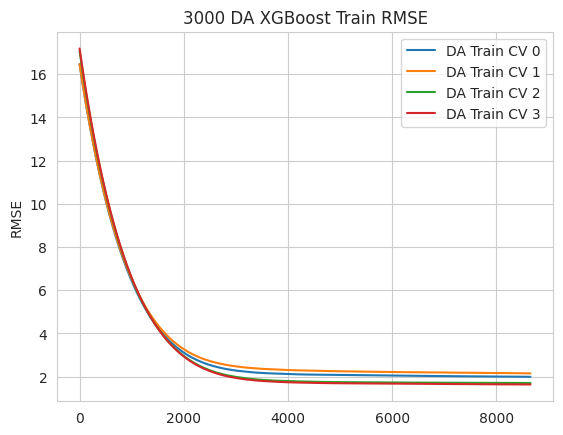

In [53]:
aug3000_scores = []
fig, ax = plt.subplots()

i = 0
for train_index, test_index in kfolds.split(X_aug3000):
    X_train_cv, X_test_cv = X_aug3000[train_index], X_aug3000[test_index]
    y_train_cv, y_test_cv = y_aug3000[train_index], y_aug3000[test_index]


    reg = XGBRegressor(
        n_estimators = 8654, 
        max_depth = 3, 
        subsample = 0.31, 
        colsample_bytree = 0.48, 
        colsample_bylevel = 0.1, 
        learning_rate = 0.001,
        verbose=False
    )
    reg.fit(X_train_cv, y_train_cv, eval_set=[(X_test_cv, y_test_cv)])
    y_pred = reg.predict(X_test)
    score_test = mean_squared_error(y_test, y_pred, squared = False)
    aug3000_scores.append(score_test)
    
    results = reg.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    ax.plot(x_axis, results['validation_0']['rmse'], label=('DA Train CV ' + str(i)))
    
    i = i+1

    
ax.legend()
plt.ylabel('RMSE')
plt.title('3000 DA XGBoost Train RMSE')
plt.show()


# Plot results

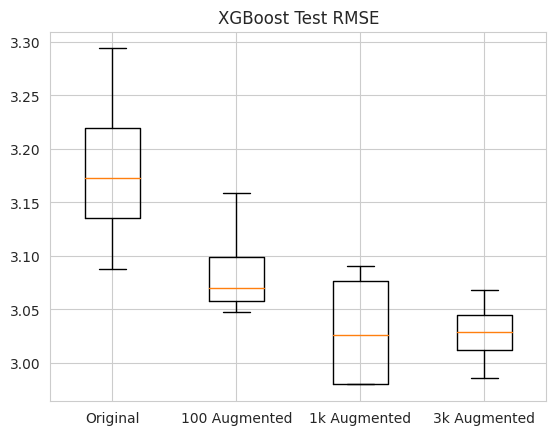

In [55]:
fig, ax = plt.subplots()
ax.boxplot([scores,aug100_scores, aug1000_scores, aug3000_scores])
plt.title('XGBoost Test RMSE')
ax.set_xticklabels(['Original', "100 Augmented", "1k Augmented", "3k Augmented"])
plt.show()